# Dense Channel Aggregation and Reconstruction Network

In [1]:
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Select the GPU index
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import namedtuple
import scipy.io as sio
import math
import thop

from PIL import Image
from collections import OrderedDict
import torchvision.transforms as T
import matplotlib.pyplot as plt
import time
from scipy.io import savemat
import dill as pickle
from torch.optim.lr_scheduler import _LRScheduler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
#Parameters
num_epochs=1000
patience=15
data_dir='../data/' 
scenario='out'
batch_size=200 
workers=5
reduction=4
expansion=50
seed=None
pin_memory=True
schedulertype = 'cosine'
weight_path=f'Experiments/table1/cr{reduction}/{expansion}x_{scenario}/epochs{num_epochs}/'
lr_init = 3e-3
val_freq=10
test_freq=10

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class PreFetcher:
    r""" Data pre-fetcher to accelerate the data loading
    """

    def __init__(self, loader):
        self.ori_loader = loader
        self.len = len(loader)
        self.stream = torch.cuda.Stream()
        self.next_input = None

    def preload(self):
        try:
            self.next_input = next(self.loader)
        except StopIteration:
            self.next_input = None
            return

        with torch.cuda.stream(self.stream):
            for idx, tensor in enumerate(self.next_input):
                self.next_input[idx] = tensor.cuda(non_blocking=True)

    def __len__(self):
        return self.len

    def __iter__(self):
        self.loader = iter(self.ori_loader)
        self.preload()
        return self

    def __next__(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        input = self.next_input
        if input is None:
            raise StopIteration
        for tensor in input:
            tensor.record_stream(torch.cuda.current_stream())
        self.preload()
        return input


In [5]:


class Cost2100DataLoader(object):
    r""" PyTorch DataLoader for COST2100 dataset.
    """

    def __init__(self, root, batch_size, num_workers, pin_memory, scenario):
        
        assert scenario in {"in", "out"}
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory

        dir_train = os.path.join(root, f"DATA_Htrain{scenario}.mat")
        dir_val = os.path.join(root, f"DATA_Hval{scenario}.mat")
        dir_test = os.path.join(root, f"DATA_Htest{scenario}.mat")
        dir_raw = os.path.join(root, f"DATA_HtestF{scenario}_all.mat")
        channel, nt, nc, nc_expand = 2, 32, 32, 125

        # Training data loading
        data_train = sio.loadmat(dir_train)['HT']
        data_train = torch.tensor(data_train, dtype=torch.float32).view(
            data_train.shape[0], channel, nt, nc)
        self.train_dataset = TensorDataset(data_train)

        # Validation data loading
        data_val = sio.loadmat(dir_val)['HT']
        data_val = torch.tensor(data_val, dtype=torch.float32).view(
            data_val.shape[0], channel, nt, nc)
        self.val_dataset = TensorDataset(data_val)

        # Test data loading, including the sparse data and the raw data
        data_test = sio.loadmat(dir_test)['HT']
        data_test = torch.tensor(data_test, dtype=torch.float32).view(
            data_test.shape[0], channel, nt, nc)

        raw_test = sio.loadmat(dir_raw)['HF_all']
        real = torch.tensor(np.real(raw_test), dtype=torch.float32)
        imag = torch.tensor(np.imag(raw_test), dtype=torch.float32)
        raw_test = torch.cat((real.view(raw_test.shape[0], nt, nc_expand, 1),
                              imag.view(raw_test.shape[0], nt, nc_expand, 1)), dim=3)
        self.test_dataset = TensorDataset(data_test, raw_test)

    def __call__(self):
        train_loader = DataLoader(self.train_dataset,
                                  batch_size=self.batch_size,
                                  num_workers=self.num_workers,
                                  pin_memory=self.pin_memory,
                                  shuffle=True)
        val_loader = DataLoader(self.val_dataset,
                                batch_size=self.batch_size,
                                num_workers=self.num_workers,
                                pin_memory=self.pin_memory,
                                shuffle=False)
        test_loader = DataLoader(self.test_dataset,
                                 batch_size=self.batch_size,
                                 num_workers=self.num_workers,
                                 pin_memory=self.pin_memory,
                                 shuffle=False)

        # Accelerate CUDA data loading with pre-fetcher if GPU is used.
        if self.pin_memory is True:
            train_loader = PreFetcher(train_loader)
            val_loader = PreFetcher(val_loader)
            test_loader = PreFetcher(test_loader)

        return train_loader, val_loader, test_loader


In [6]:
# Create the data loader
train_loader, val_loader, test_loader = Cost2100DataLoader(
        root=data_dir,
        batch_size=batch_size,
        num_workers=workers,
        pin_memory=pin_memory,
        scenario=scenario)()

In [7]:
train_iter=iter(train_loader)

In [8]:
x=next(train_iter)

In [9]:
len(x)

1

In [10]:
x[0].shape

torch.Size([200, 2, 32, 32])

In [11]:
len(train_loader)

500

In [12]:
len(test_loader)

100

In [13]:
len(val_loader)

150

In [14]:
def cal_model_parameters(model):
    total_param  = []
    for p1 in model.parameters():
        total_param.append(int(p1.numel()))
    return sum(total_param)

In [15]:
def NMSE_cal(x_hat, x):
    x_real = torch.reshape(torch.real(x), (x.shape[0], -1))
    x_imag = torch.reshape(torch.imag(x), (x.shape[0], -1))
    x_hat_real = torch.reshape(torch.real(x_hat), (x.shape[0], -1))
    x_hat_imag = torch.reshape(torch.imag(x_hat), (x.shape[0], -1))
    power = torch.sum((x_real - 0.5) ** 2 + (x_imag - 0.5) ** 2, dim=1)
    mse = torch.sum((x_real - x_hat_real) ** 2 + (x_imag - x_hat_imag) ** 2, dim=1)
    nmse = torch.mean(mse / power)
    return nmse

In [16]:
class ConvBN(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, groups=1):
        if not isinstance(kernel_size, int):
            padding = [(i - 1) // 2 for i in kernel_size]
        else:
            padding = (kernel_size - 1) // 2
        super(ConvBN, self).__init__(OrderedDict([
            ('conv', nn.Conv2d(in_channels=in_planes,
                               out_channels=out_planes,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               groups=groups,
                               bias=False)),
            ('bn', nn.BatchNorm2d(out_planes))
        ]))

In [17]:
class DCARNDecoderBlock(nn.Module):
  
    def __init__(self, expansion):
        super().__init__()
        width = 10 * expansion
        self.conv1 = ConvBN(2, width, [1, 11])
        self.prelu1 = nn.PReLU(num_parameters=width, init=0.3)
        self.conv2 = ConvBN(2, width, [11, 1])
        self.prelu2 = nn.PReLU(num_parameters=width, init=0.3)
        self.conv3 = ConvBN(2*width, 2, [1, 11])
        self.prelu3 = nn.PReLU(num_parameters=2, init=0.3)
        self.identity = nn.Identity()
    def forward(self, x):
        identity = self.identity(x)
        x1 = self.prelu1(self.conv1(x))

        x2 = self.prelu2(self.conv2(x))

        # Concat instead of add
        x3 = torch.cat([x1, x2], dim=1) 
        x3 = self.prelu3(self.conv3(x3)+identity)

        return x3

In [18]:
class DCARNEncoderBlock(nn.Module):
    def __init__(self):
        super(DCARNEncoderBlock, self).__init__()
        width = 2
        self.conv1 = ConvBN(2, width, [1, 11])
        self.prelu1 = nn.PReLU(num_parameters=width, init=0.3)
        self.conv2 = ConvBN(2, width, [11, 1])
        self.prelu2 = nn.PReLU(num_parameters=width, init=0.3)
        self.conv3 = ConvBN(2*width, 2, [1, 11])
        self.prelu3 = nn.PReLU(num_parameters=2, init=0.3)
        self.identity = nn.Identity()
    def forward(self, x):
        identity = self.identity(x)
        x1 = self.prelu1(self.conv1(x))

        x2 = self.prelu2(self.conv2(x))

        # Concat instead of add
        x3 = torch.cat([x1, x2], dim=1) 
        x3 = self.prelu3(self.conv3(x3)+identity)
        return x3

In [19]:
class DCARN(nn.Module):
    def __init__(self,
                 in_channels=2,
                 reduction=4,
                 expansion=1):
        super(DCARN, self).__init__()
        
        total_size, w, h = 2048, 32, 32

        self.encoder_feature = nn.Sequential(OrderedDict([
            ("conv1x11_bn", ConvBN(in_channels, 2, [1, 11])),
            ("prelu", nn.PReLU(num_parameters=2, init=0.3)),
            ("DCARNEncoderBlock", DCARNEncoderBlock()),
            
        ]))
        
        self.encoder_fc = nn.Linear(total_size, total_size // reduction)

        self.decoder_fc = nn.Linear(total_size // reduction, total_size)
        
        self.decoder_feature = nn.Sequential(OrderedDict([
            ("conv1x11_bn", ConvBN(2, in_channels, [1, 11])),
            ("prelu", nn.PReLU(num_parameters=2, init=0.3)),
            ("DCARNDecoderBlock1", DCARNDecoderBlock(expansion=expansion)),
            ("DCARNDecoderBlock2", DCARNDecoderBlock(expansion=expansion)),
            ("sigmoid", nn.Sigmoid())
        ]))

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        n, c, h, w = x.detach().size()
        out = self.encoder_feature(x)
        out = self.encoder_fc(out.view(n, -1))
        out = self.decoder_fc(out)
        out = self.decoder_feature(out.view(n, c, h, w))
        return out

In [20]:
model = DCARN(in_channels=2, reduction=reduction, expansion=expansion).to(device)

In [21]:
if seed is not None:
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [22]:
cal_model_parameters(model)

2194018

In [23]:
# Define loss function
criterion = nn.MSELoss().to(device)

In [24]:
class WarmUpCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, T_max, T_warmup, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.T_warmup = T_warmup
        self.eta_min = eta_min
        super(WarmUpCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.T_warmup:
            return [base_lr * self.last_epoch / self.T_warmup for base_lr in self.base_lrs]
        else:
            k = 1 + math.cos(math.pi * (self.last_epoch - self.T_warmup) / (self.T_max - self.T_warmup))
            return [self.eta_min + (base_lr - self.eta_min) * k / 2 for base_lr in self.base_lrs]


class FakeLR(_LRScheduler):
    def __init__(self, optimizer):
        super(FakeLR, self).__init__(optimizer=optimizer)

    def get_lr(self):
        return self.base_lrs


In [25]:
# Define optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr_init, betas=(0.9, 0.999))
if schedulertype == 'const':
    scheduler = FakeLR(optimizer=optimizer)

else:
    scheduler = WarmUpCosineAnnealingLR(optimizer=optimizer,
                                        T_max=num_epochs * len(train_loader),
                                        T_warmup=100 * len(train_loader),
                                        eta_min=5e-7)

In [26]:
field = ('nmse', 'rho', 'epoch')
Result = namedtuple('Result', field, defaults=(None,) * len(field))


In [27]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self, name):
        self.reset()
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.name = name

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __repr__(self):
        return f"==> For {self.name}: sum={self.sum}; avg={self.avg}"




In [28]:
def evaluator(sparse_pred, sparse_gt, raw_gt):
    r""" Evaluation of decoding implemented in PyTorch Tensor
         Computes normalized mean square error (NMSE) and rho.
    """

    with torch.no_grad():
        # Basic params
        nt = 32
        nc = 32
        nc_expand = 257

        # De-centralize
        sparse_gt = sparse_gt - 0.5
        sparse_pred = sparse_pred - 0.5

        # Calculate the NMSE
        power_gt = sparse_gt[:, 0, :, :] ** 2 + sparse_gt[:, 1, :, :] ** 2
        difference = sparse_gt - sparse_pred
        mse = difference[:, 0, :, :] ** 2 + difference[:, 1, :, :] ** 2
        nmse = (mse.sum(dim=[1, 2]) / power_gt.sum(dim=[1, 2])).mean()

        # Calculate the Rho
        n = sparse_pred.size(0)
        sparse_pred = sparse_pred.permute(0, 2, 3, 1)  # Move the real/imaginary dim to the last
        zeros = sparse_pred.new_zeros((n, nt, nc_expand - nc, 2))
        sparse_pred = torch.cat((sparse_pred, zeros), dim=2)
        raw_pred = torch.fft.fft(sparse_pred, dim=1)[:, :, :125, :]

        norm_pred = raw_pred[..., 0] ** 2 + raw_pred[..., 1] ** 2
        norm_pred = torch.sqrt(norm_pred.sum(dim=1))

        norm_gt = raw_gt[..., 0] ** 2 + raw_gt[..., 1] ** 2
        norm_gt = torch.sqrt(norm_gt.sum(dim=1))

        real_cross = raw_pred[..., 0] * raw_gt[..., 0] + raw_pred[..., 1] * raw_gt[..., 1]
        real_cross = real_cross.sum(dim=1)
        imag_cross = raw_pred[..., 0] * raw_gt[..., 1] - raw_pred[..., 1] * raw_gt[..., 0]
        imag_cross = imag_cross.sum(dim=1)
        norm_cross = torch.sqrt(real_cross ** 2 + imag_cross ** 2)

        rho = (norm_cross / (norm_pred * norm_gt)).mean()

        return rho, nmse


In [29]:
class Tester:
    r""" The testing interface for classification
    """

    def __init__(self, model, device, criterion, print_freq=20):
        self.model = model
        self.device = device
        self.criterion = criterion
        self.print_freq = print_freq

    def __call__(self, test_data, verbose=True):
        r""" Runs the testing procedure.

        Args:
            test_data (DataLoader): Data loader for validation data.
        """

        self.model.eval()
        with torch.no_grad():
            loss, rho, nmse = self._iteration(test_data)
        if verbose:
            print(f'\n=> Test result: \nloss: {loss:.3e}'
                  f'    rho: {rho:.3e}    NMSE: {nmse:.3e}\n')
        return loss, rho, nmse

    def _iteration(self, data_loader):
        r""" protected function which test the model on given data loader for one epoch.
        """

        iter_rho = AverageMeter('Iter rho')
        iter_nmse = AverageMeter('Iter nmse')
        iter_loss = AverageMeter('Iter loss')
        iter_time = AverageMeter('Iter time')
        time_tmp = time.time()

        for batch_idx, (sparse_gt, raw_gt) in enumerate(data_loader):
            sparse_gt = sparse_gt.to(self.device)
            sparse_pred = self.model(sparse_gt)
            loss = self.criterion(sparse_pred, sparse_gt)
            rho, nmse = evaluator(sparse_pred, sparse_gt, raw_gt)

            # Log and visdom update
            iter_loss.update(loss)
            iter_rho.update(rho)
            iter_nmse.update(nmse)
            iter_time.update(time.time() - time_tmp)
            time_tmp = time.time()

            # plot progress
            if (batch_idx + 1) % self.print_freq == 0:
                print(f'[{batch_idx + 1}/{len(data_loader)}] '
                            f'loss: {iter_loss.avg:.3e} | rho: {iter_rho.avg:.3e} | '
                            f'NMSE: {10 * torch.log10(iter_nmse.avg):.3e} | time: {iter_time.avg:.3f}')
        
        nmse = 10 * torch.log10(iter_nmse.avg)  # global NMSE in dB
        print(f'=> Test rho:{iter_rho.avg:.3e}  NMSE: {nmse:.3e}\n')
        return iter_loss.avg, iter_rho.avg, nmse


In [30]:
val_losses = torch.empty(num_epochs//val_freq)
train_losses = torch.empty(num_epochs)
test_losses = torch.empty(num_epochs//test_freq)
alphas = torch.zeros(num_epochs)
test_nmses = torch.zeros(num_epochs//test_freq)

if not os.path.exists(weight_path + "losses/"):
    os.makedirs(weight_path + "losses/")

In [31]:
class Trainer:
    r""" The training pipeline for encoder-decoder architecture
    """

    def __init__(self, model, device, optimizer, criterion, scheduler, resume=None,
                 save_path=weight_path, print_freq=10, val_freq = val_freq, test_freq = test_freq):

        # Basic arguments
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.device = device

        # Verbose arguments
        self.resume_file = resume
        self.save_path = save_path
        self.print_freq = print_freq
        self.val_freq = val_freq
        self.test_freq = test_freq
        

        # Pipeline arguments
        self.cur_epoch = 1
        self.all_epoch = None
        self.train_loss = None
        self.val_loss = None
        self.test_loss = None
        self.best_rho = Result()
        self.best_nmse = Result()
        
        self.tester = Tester(model, device, criterion, print_freq)
        self.test_loader = None

    def loop(self, epochs, train_loader, val_loader, test_loader):
        r""" The main loop function which runs training and validation iteratively.

        Args:
            epochs (int): The total epoch for training
            train_loader (DataLoader): Data loader for training data.
            val_loader (DataLoader): Data loader for validation data.
            test_loader (DataLoader): Data loader for test data.
        """

        self.all_epoch = epochs
        self._resume()
        vn=0
        tn=0
        for ep in range(self.cur_epoch, epochs + 1):
            self.cur_epoch = ep

            # conduct training, validation and test
            self.train_loss = self.train(train_loader)
            train_losses[ep-1] = self.train_loss.detach()
            if ep % self.val_freq == 0:
                self.val_loss = self.val(val_loader)
                val_losses[vn] = self.val_loss.detach()
                vn=vn+1
            # Save alpha 
            alphas_ep = []
            for m in self.model.modules():
                if isinstance(m, nn.PReLU):
                    alphas_ep.append(m.weight[0])
            alphas[ep-1] = torch.stack(alphas_ep).mean().detach()
            
            if ep % self.test_freq == 0:
                self.test_loss, rho, nmse = self.test(test_loader)
                test_losses[tn] = self.test_loss.detach()
                test_nmses[tn] = nmse.detach()
                tn=tn+1
            else:
                rho, nmse = None, None
            # conduct saving, visualization and log printing
            self._loop_postprocessing(rho, nmse)

    def train(self, train_loader):
        r""" train the model on the given data loader for one epoch.

        Args:
            train_loader (DataLoader): the training data loader
        """

        self.model.train()
        with torch.enable_grad():
            return self._iteration(train_loader)

    def val(self, val_loader):
        r""" exam the model with validation set.

        Args:
            val_loader: (DataLoader): the validation data loader
        """

        self.model.eval()
        with torch.no_grad():
            return self._iteration(val_loader)

    def test(self, test_loader):
        r""" Truly test the model on the test dataset for one epoch.

        Args:
            test_loader (DataLoader): the test data loader
        """

        self.model.eval()
        with torch.no_grad():
            return self.tester(test_loader, verbose=False)

    def _iteration(self, data_loader):
        iter_loss = AverageMeter('Iter loss')
        iter_time = AverageMeter('Iter time')
        time_tmp = time.time()

        for batch_idx, (sparse_gt, ) in enumerate(data_loader):
            sparse_gt = sparse_gt.to(self.device)
            sparse_pred = self.model(sparse_gt)
            loss = self.criterion(sparse_pred, sparse_gt)

            # Scheduler update, backward pass and optimization
            if self.model.training:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

            # Log and visdom update
            iter_loss.update(loss)
            iter_time.update(time.time() - time_tmp)
            time_tmp = time.time()

            # plot progress
            if (batch_idx + 1) % self.print_freq == 0:
                print(f'Epoch: [{self.cur_epoch}/{self.all_epoch}]'
                            f'[{batch_idx + 1}/{len(data_loader)}] '
                            f'lr: {self.scheduler.get_lr()[0]:.2e} | '
                            f'MSE loss: {iter_loss.avg:.3e} | '
                            f'time: {iter_time.avg:.3f}')
                

        mode = 'Train' if self.model.training else 'Val'
        print(f' {mode}  Loss: {iter_loss.avg:.3e}\n')

        return iter_loss.avg

    def _save(self, state, name):
        if self.save_path is None:
            print('No path to save checkpoints.')
            return
        
        os.makedirs(self.save_path, exist_ok=True)
        torch.save(state, os.path.join(self.save_path, name))

    def _resume(self):
        r""" protected function which resume from checkpoint at the beginning of training.
        """

        if self.resume_file is None:
            return None
        assert os.path.isfile(self.resume_file)
        print(f' loading checkpoint {self.resume_file}')
        checkpoint = torch.load(self.resume_file)
        self.cur_epoch = checkpoint['epoch']
        self.model.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        self.best_rho = checkpoint['best_rho']
        self.best_nmse = checkpoint['best_nmse']
        self.cur_epoch += 1  # start from the next epoch

        print(f' successfully loaded checkpoint {self.resume_file} '
                    f'from epoch {checkpoint["epoch"]}.\n')

    def _loop_postprocessing(self, rho, nmse):
        r""" private function which makes loop() function neater.
        """

        # save state generate
        state = {
            'epoch': self.cur_epoch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict(),
            'best_rho': self.best_rho,
            'best_nmse': self.best_nmse
        }

        # save model with best rho and nmse
        if rho is not None:
            if self.best_rho.rho is None or abs(self.best_rho.rho) < abs(rho):
                self.best_rho = Result(rho=rho, nmse=nmse, epoch=self.cur_epoch)
                state['best_rho'] = self.best_rho
                self._save(state, name=f"best_rho.pth")
            if self.best_nmse.nmse is None or self.best_nmse.nmse > nmse:
                self.best_nmse = Result(rho=rho, nmse=nmse, epoch=self.cur_epoch)
                state['best_nmse'] = self.best_nmse
                self._save(state, name=f"best_nmse.pth")

        self._save(state, name='last.pth')

        # print current best results
        if self.best_rho.rho is not None:
            print(f'\n=! Best rho: {self.best_rho.rho:.3e} ('
                  f'Corresponding nmse={self.best_rho.nmse:.3e}; '
                  f'epoch={self.best_rho.epoch})'
                  f'\n   Best NMSE: {self.best_nmse.nmse:.3e} ('
                  f'Corresponding rho={self.best_nmse.rho:.3e};  '
                  f'epoch={self.best_nmse.epoch})\n')
            

In [32]:
# Define the training pipeline
trainer = Trainer(model=model,
                  device=device,
                  optimizer=optimizer,
                  criterion=criterion,
                  scheduler=scheduler)

# Start training
trainer.loop(num_epochs, train_loader, val_loader, test_loader)

Epoch: [1/1000][10/500] lr: 6.00e-07 | MSE loss: 5.368e-02 | time: 0.237
Epoch: [1/1000][20/500] lr: 1.20e-06 | MSE loss: 5.341e-02 | time: 0.207
Epoch: [1/1000][30/500] lr: 1.80e-06 | MSE loss: 5.289e-02 | time: 0.197
Epoch: [1/1000][40/500] lr: 2.40e-06 | MSE loss: 5.216e-02 | time: 0.192
Epoch: [1/1000][50/500] lr: 3.00e-06 | MSE loss: 5.122e-02 | time: 0.189
Epoch: [1/1000][60/500] lr: 3.60e-06 | MSE loss: 5.008e-02 | time: 0.187
Epoch: [1/1000][70/500] lr: 4.20e-06 | MSE loss: 4.877e-02 | time: 0.185
Epoch: [1/1000][80/500] lr: 4.80e-06 | MSE loss: 4.731e-02 | time: 0.184
Epoch: [1/1000][90/500] lr: 5.40e-06 | MSE loss: 4.575e-02 | time: 0.183
Epoch: [1/1000][100/500] lr: 6.00e-06 | MSE loss: 4.412e-02 | time: 0.183
Epoch: [1/1000][110/500] lr: 6.60e-06 | MSE loss: 4.247e-02 | time: 0.182
Epoch: [1/1000][120/500] lr: 7.20e-06 | MSE loss: 4.085e-02 | time: 0.182
Epoch: [1/1000][130/500] lr: 7.80e-06 | MSE loss: 3.927e-02 | time: 0.181
Epoch: [1/1000][140/500] lr: 8.40e-06 | MSE los

Epoch: [3/1000][120/500] lr: 6.72e-05 | MSE loss: 9.852e-04 | time: 0.179
Epoch: [3/1000][130/500] lr: 6.78e-05 | MSE loss: 9.826e-04 | time: 0.179
Epoch: [3/1000][140/500] lr: 6.84e-05 | MSE loss: 9.802e-04 | time: 0.179
Epoch: [3/1000][150/500] lr: 6.90e-05 | MSE loss: 9.785e-04 | time: 0.179
Epoch: [3/1000][160/500] lr: 6.96e-05 | MSE loss: 9.766e-04 | time: 0.178
Epoch: [3/1000][170/500] lr: 7.02e-05 | MSE loss: 9.757e-04 | time: 0.178
Epoch: [3/1000][180/500] lr: 7.08e-05 | MSE loss: 9.738e-04 | time: 0.178
Epoch: [3/1000][190/500] lr: 7.14e-05 | MSE loss: 9.722e-04 | time: 0.178
Epoch: [3/1000][200/500] lr: 7.20e-05 | MSE loss: 9.703e-04 | time: 0.178
Epoch: [3/1000][210/500] lr: 7.26e-05 | MSE loss: 9.690e-04 | time: 0.178
Epoch: [3/1000][220/500] lr: 7.32e-05 | MSE loss: 9.669e-04 | time: 0.178
Epoch: [3/1000][230/500] lr: 7.38e-05 | MSE loss: 9.653e-04 | time: 0.178
Epoch: [3/1000][240/500] lr: 7.44e-05 | MSE loss: 9.637e-04 | time: 0.178
Epoch: [3/1000][250/500] lr: 7.50e-05 

Epoch: [5/1000][230/500] lr: 1.34e-04 | MSE loss: 8.014e-04 | time: 0.178
Epoch: [5/1000][240/500] lr: 1.34e-04 | MSE loss: 8.015e-04 | time: 0.178
Epoch: [5/1000][250/500] lr: 1.35e-04 | MSE loss: 8.019e-04 | time: 0.178
Epoch: [5/1000][260/500] lr: 1.36e-04 | MSE loss: 8.018e-04 | time: 0.178
Epoch: [5/1000][270/500] lr: 1.36e-04 | MSE loss: 8.020e-04 | time: 0.178
Epoch: [5/1000][280/500] lr: 1.37e-04 | MSE loss: 8.020e-04 | time: 0.178
Epoch: [5/1000][290/500] lr: 1.37e-04 | MSE loss: 8.016e-04 | time: 0.178
Epoch: [5/1000][300/500] lr: 1.38e-04 | MSE loss: 8.016e-04 | time: 0.178
Epoch: [5/1000][310/500] lr: 1.39e-04 | MSE loss: 8.017e-04 | time: 0.178
Epoch: [5/1000][320/500] lr: 1.39e-04 | MSE loss: 8.018e-04 | time: 0.178
Epoch: [5/1000][330/500] lr: 1.40e-04 | MSE loss: 8.018e-04 | time: 0.178
Epoch: [5/1000][340/500] lr: 1.40e-04 | MSE loss: 8.016e-04 | time: 0.178
Epoch: [5/1000][350/500] lr: 1.41e-04 | MSE loss: 8.012e-04 | time: 0.178
Epoch: [5/1000][360/500] lr: 1.42e-04 

Epoch: [7/1000][340/500] lr: 2.00e-04 | MSE loss: 8.022e-04 | time: 0.178
Epoch: [7/1000][350/500] lr: 2.01e-04 | MSE loss: 8.020e-04 | time: 0.178
Epoch: [7/1000][360/500] lr: 2.02e-04 | MSE loss: 8.021e-04 | time: 0.178
Epoch: [7/1000][370/500] lr: 2.02e-04 | MSE loss: 8.020e-04 | time: 0.178
Epoch: [7/1000][380/500] lr: 2.03e-04 | MSE loss: 8.017e-04 | time: 0.178
Epoch: [7/1000][390/500] lr: 2.03e-04 | MSE loss: 8.016e-04 | time: 0.178
Epoch: [7/1000][400/500] lr: 2.04e-04 | MSE loss: 8.017e-04 | time: 0.178
Epoch: [7/1000][410/500] lr: 2.05e-04 | MSE loss: 8.018e-04 | time: 0.178
Epoch: [7/1000][420/500] lr: 2.05e-04 | MSE loss: 8.015e-04 | time: 0.178
Epoch: [7/1000][430/500] lr: 2.06e-04 | MSE loss: 8.016e-04 | time: 0.178
Epoch: [7/1000][440/500] lr: 2.06e-04 | MSE loss: 8.016e-04 | time: 0.178
Epoch: [7/1000][450/500] lr: 2.07e-04 | MSE loss: 8.014e-04 | time: 0.178
Epoch: [7/1000][460/500] lr: 2.08e-04 | MSE loss: 8.014e-04 | time: 0.178
Epoch: [7/1000][470/500] lr: 2.08e-04 

Epoch: [9/1000][450/500] lr: 2.67e-04 | MSE loss: 7.674e-04 | time: 0.178
Epoch: [9/1000][460/500] lr: 2.68e-04 | MSE loss: 7.666e-04 | time: 0.178
Epoch: [9/1000][470/500] lr: 2.68e-04 | MSE loss: 7.658e-04 | time: 0.178
Epoch: [9/1000][480/500] lr: 2.69e-04 | MSE loss: 7.649e-04 | time: 0.178
Epoch: [9/1000][490/500] lr: 2.69e-04 | MSE loss: 7.639e-04 | time: 0.178
Epoch: [9/1000][500/500] lr: 2.70e-04 | MSE loss: 7.630e-04 | time: 0.178
 Train  Loss: 7.630e-04

Epoch: [10/1000][10/500] lr: 2.71e-04 | MSE loss: 6.966e-04 | time: 0.200
Epoch: [10/1000][20/500] lr: 2.71e-04 | MSE loss: 7.055e-04 | time: 0.188
Epoch: [10/1000][30/500] lr: 2.72e-04 | MSE loss: 7.042e-04 | time: 0.185
Epoch: [10/1000][40/500] lr: 2.72e-04 | MSE loss: 7.074e-04 | time: 0.183
Epoch: [10/1000][50/500] lr: 2.73e-04 | MSE loss: 7.092e-04 | time: 0.182
Epoch: [10/1000][60/500] lr: 2.74e-04 | MSE loss: 7.086e-04 | time: 0.181
Epoch: [10/1000][70/500] lr: 2.74e-04 | MSE loss: 7.079e-04 | time: 0.180
Epoch: [10/10

Epoch: [11/1000][270/500] lr: 3.16e-04 | MSE loss: 5.516e-04 | time: 0.178
Epoch: [11/1000][280/500] lr: 3.17e-04 | MSE loss: 5.507e-04 | time: 0.178
Epoch: [11/1000][290/500] lr: 3.17e-04 | MSE loss: 5.499e-04 | time: 0.178
Epoch: [11/1000][300/500] lr: 3.18e-04 | MSE loss: 5.493e-04 | time: 0.178
Epoch: [11/1000][310/500] lr: 3.19e-04 | MSE loss: 5.480e-04 | time: 0.178
Epoch: [11/1000][320/500] lr: 3.19e-04 | MSE loss: 5.469e-04 | time: 0.178
Epoch: [11/1000][330/500] lr: 3.20e-04 | MSE loss: 5.455e-04 | time: 0.178
Epoch: [11/1000][340/500] lr: 3.20e-04 | MSE loss: 5.445e-04 | time: 0.178
Epoch: [11/1000][350/500] lr: 3.21e-04 | MSE loss: 5.431e-04 | time: 0.178
Epoch: [11/1000][360/500] lr: 3.22e-04 | MSE loss: 5.419e-04 | time: 0.178
Epoch: [11/1000][370/500] lr: 3.22e-04 | MSE loss: 5.403e-04 | time: 0.178
Epoch: [11/1000][380/500] lr: 3.23e-04 | MSE loss: 5.392e-04 | time: 0.178
Epoch: [11/1000][390/500] lr: 3.23e-04 | MSE loss: 5.378e-04 | time: 0.178
Epoch: [11/1000][400/500]

Epoch: [13/1000][330/500] lr: 3.80e-04 | MSE loss: 3.029e-04 | time: 0.178
Epoch: [13/1000][340/500] lr: 3.80e-04 | MSE loss: 3.021e-04 | time: 0.178
Epoch: [13/1000][350/500] lr: 3.81e-04 | MSE loss: 3.012e-04 | time: 0.178
Epoch: [13/1000][360/500] lr: 3.82e-04 | MSE loss: 3.003e-04 | time: 0.178
Epoch: [13/1000][370/500] lr: 3.82e-04 | MSE loss: 2.995e-04 | time: 0.178
Epoch: [13/1000][380/500] lr: 3.83e-04 | MSE loss: 2.985e-04 | time: 0.178
Epoch: [13/1000][390/500] lr: 3.83e-04 | MSE loss: 2.979e-04 | time: 0.178
Epoch: [13/1000][400/500] lr: 3.84e-04 | MSE loss: 2.974e-04 | time: 0.178
Epoch: [13/1000][410/500] lr: 3.85e-04 | MSE loss: 2.970e-04 | time: 0.178
Epoch: [13/1000][420/500] lr: 3.85e-04 | MSE loss: 2.965e-04 | time: 0.178
Epoch: [13/1000][430/500] lr: 3.86e-04 | MSE loss: 2.960e-04 | time: 0.178
Epoch: [13/1000][440/500] lr: 3.86e-04 | MSE loss: 2.952e-04 | time: 0.178
Epoch: [13/1000][450/500] lr: 3.87e-04 | MSE loss: 2.945e-04 | time: 0.178
Epoch: [13/1000][460/500]

Epoch: [15/1000][390/500] lr: 4.43e-04 | MSE loss: 2.086e-04 | time: 0.178
Epoch: [15/1000][400/500] lr: 4.44e-04 | MSE loss: 2.083e-04 | time: 0.178
Epoch: [15/1000][410/500] lr: 4.45e-04 | MSE loss: 2.082e-04 | time: 0.178
Epoch: [15/1000][420/500] lr: 4.45e-04 | MSE loss: 2.084e-04 | time: 0.178
Epoch: [15/1000][430/500] lr: 4.46e-04 | MSE loss: 2.083e-04 | time: 0.178
Epoch: [15/1000][440/500] lr: 4.46e-04 | MSE loss: 2.081e-04 | time: 0.178
Epoch: [15/1000][450/500] lr: 4.47e-04 | MSE loss: 2.079e-04 | time: 0.178
Epoch: [15/1000][460/500] lr: 4.48e-04 | MSE loss: 2.075e-04 | time: 0.178
Epoch: [15/1000][470/500] lr: 4.48e-04 | MSE loss: 2.071e-04 | time: 0.178
Epoch: [15/1000][480/500] lr: 4.49e-04 | MSE loss: 2.068e-04 | time: 0.178
Epoch: [15/1000][490/500] lr: 4.49e-04 | MSE loss: 2.070e-04 | time: 0.178
Epoch: [15/1000][500/500] lr: 4.50e-04 | MSE loss: 2.069e-04 | time: 0.178
 Train  Loss: 2.069e-04


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NM

Epoch: [17/1000][450/500] lr: 5.07e-04 | MSE loss: 1.660e-04 | time: 0.178
Epoch: [17/1000][460/500] lr: 5.08e-04 | MSE loss: 1.659e-04 | time: 0.178
Epoch: [17/1000][470/500] lr: 5.08e-04 | MSE loss: 1.659e-04 | time: 0.178
Epoch: [17/1000][480/500] lr: 5.09e-04 | MSE loss: 1.658e-04 | time: 0.178
Epoch: [17/1000][490/500] lr: 5.09e-04 | MSE loss: 1.657e-04 | time: 0.178
Epoch: [17/1000][500/500] lr: 5.10e-04 | MSE loss: 1.655e-04 | time: 0.178
 Train  Loss: 1.655e-04


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.403e+00 (Corresponding rho=nan+nanj;  epoch=10)

Epoch: [18/1000][10/500] lr: 5.11e-04 | MSE loss: 1.521e-04 | time: 0.200
Epoch: [18/1000][20/500] lr: 5.11e-04 | MSE loss: 1.522e-04 | time: 0.189
Epoch: [18/1000][30/500] lr: 5.12e-04 | MSE loss: 1.521e-04 | time: 0.185
Epoch: [18/1000][40/500] lr: 5.12e-04 | MSE loss: 1.545e-04 | time: 0.183
Epoch: [18/1000][50/500] lr: 5.13e-04 | MSE loss: 1.556e-04 | time: 0.182
Epoch: [18/1000][60/500]

Epoch: [20/1000][10/500] lr: 5.71e-04 | MSE loss: 1.346e-04 | time: 0.196
Epoch: [20/1000][20/500] lr: 5.71e-04 | MSE loss: 1.350e-04 | time: 0.187
Epoch: [20/1000][30/500] lr: 5.72e-04 | MSE loss: 1.347e-04 | time: 0.184
Epoch: [20/1000][40/500] lr: 5.72e-04 | MSE loss: 1.329e-04 | time: 0.182
Epoch: [20/1000][50/500] lr: 5.73e-04 | MSE loss: 1.330e-04 | time: 0.181
Epoch: [20/1000][60/500] lr: 5.74e-04 | MSE loss: 1.324e-04 | time: 0.181
Epoch: [20/1000][70/500] lr: 5.74e-04 | MSE loss: 1.320e-04 | time: 0.180
Epoch: [20/1000][80/500] lr: 5.75e-04 | MSE loss: 1.322e-04 | time: 0.180
Epoch: [20/1000][90/500] lr: 5.75e-04 | MSE loss: 1.332e-04 | time: 0.179
Epoch: [20/1000][100/500] lr: 5.76e-04 | MSE loss: 1.330e-04 | time: 0.179
Epoch: [20/1000][110/500] lr: 5.77e-04 | MSE loss: 1.330e-04 | time: 0.179
Epoch: [20/1000][120/500] lr: 5.77e-04 | MSE loss: 1.330e-04 | time: 0.179
Epoch: [20/1000][130/500] lr: 5.78e-04 | MSE loss: 1.332e-04 | time: 0.179
Epoch: [20/1000][140/500] lr: 5.78

Epoch: [21/1000][330/500] lr: 6.20e-04 | MSE loss: 1.240e-04 | time: 0.178
Epoch: [21/1000][340/500] lr: 6.20e-04 | MSE loss: 1.238e-04 | time: 0.178
Epoch: [21/1000][350/500] lr: 6.21e-04 | MSE loss: 1.237e-04 | time: 0.178
Epoch: [21/1000][360/500] lr: 6.22e-04 | MSE loss: 1.236e-04 | time: 0.178
Epoch: [21/1000][370/500] lr: 6.22e-04 | MSE loss: 1.235e-04 | time: 0.178
Epoch: [21/1000][380/500] lr: 6.23e-04 | MSE loss: 1.233e-04 | time: 0.178
Epoch: [21/1000][390/500] lr: 6.23e-04 | MSE loss: 1.233e-04 | time: 0.178
Epoch: [21/1000][400/500] lr: 6.24e-04 | MSE loss: 1.232e-04 | time: 0.178
Epoch: [21/1000][410/500] lr: 6.25e-04 | MSE loss: 1.231e-04 | time: 0.178
Epoch: [21/1000][420/500] lr: 6.25e-04 | MSE loss: 1.229e-04 | time: 0.178
Epoch: [21/1000][430/500] lr: 6.26e-04 | MSE loss: 1.228e-04 | time: 0.178
Epoch: [21/1000][440/500] lr: 6.26e-04 | MSE loss: 1.227e-04 | time: 0.178
Epoch: [21/1000][450/500] lr: 6.27e-04 | MSE loss: 1.226e-04 | time: 0.178
Epoch: [21/1000][460/500]

Epoch: [23/1000][390/500] lr: 6.83e-04 | MSE loss: 1.102e-04 | time: 0.178
Epoch: [23/1000][400/500] lr: 6.84e-04 | MSE loss: 1.100e-04 | time: 0.178
Epoch: [23/1000][410/500] lr: 6.85e-04 | MSE loss: 1.099e-04 | time: 0.178
Epoch: [23/1000][420/500] lr: 6.85e-04 | MSE loss: 1.098e-04 | time: 0.178
Epoch: [23/1000][430/500] lr: 6.86e-04 | MSE loss: 1.098e-04 | time: 0.178
Epoch: [23/1000][440/500] lr: 6.86e-04 | MSE loss: 1.096e-04 | time: 0.178
Epoch: [23/1000][450/500] lr: 6.87e-04 | MSE loss: 1.096e-04 | time: 0.178
Epoch: [23/1000][460/500] lr: 6.88e-04 | MSE loss: 1.095e-04 | time: 0.178
Epoch: [23/1000][470/500] lr: 6.88e-04 | MSE loss: 1.095e-04 | time: 0.178
Epoch: [23/1000][480/500] lr: 6.89e-04 | MSE loss: 1.095e-04 | time: 0.178
Epoch: [23/1000][490/500] lr: 6.89e-04 | MSE loss: 1.094e-04 | time: 0.178
Epoch: [23/1000][500/500] lr: 6.90e-04 | MSE loss: 1.094e-04 | time: 0.178
 Train  Loss: 1.094e-04


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NM

Epoch: [25/1000][450/500] lr: 7.47e-04 | MSE loss: 9.985e-05 | time: 0.178
Epoch: [25/1000][460/500] lr: 7.48e-04 | MSE loss: 9.989e-05 | time: 0.178
Epoch: [25/1000][470/500] lr: 7.48e-04 | MSE loss: 1.000e-04 | time: 0.178
Epoch: [25/1000][480/500] lr: 7.49e-04 | MSE loss: 1.001e-04 | time: 0.178
Epoch: [25/1000][490/500] lr: 7.49e-04 | MSE loss: 1.001e-04 | time: 0.178
Epoch: [25/1000][500/500] lr: 7.50e-04 | MSE loss: 1.001e-04 | time: 0.178
 Train  Loss: 1.001e-04


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -7.926e+00 (Corresponding rho=nan+nanj;  epoch=20)

Epoch: [26/1000][10/500] lr: 7.51e-04 | MSE loss: 9.464e-05 | time: 0.198
Epoch: [26/1000][20/500] lr: 7.51e-04 | MSE loss: 9.692e-05 | time: 0.188
Epoch: [26/1000][30/500] lr: 7.52e-04 | MSE loss: 9.848e-05 | time: 0.185
Epoch: [26/1000][40/500] lr: 7.52e-04 | MSE loss: 9.817e-05 | time: 0.183
Epoch: [26/1000][50/500] lr: 7.53e-04 | MSE loss: 9.784e-05 | time: 0.182
Epoch: [26/1000][60/500]

Epoch: [28/1000][10/500] lr: 8.11e-04 | MSE loss: 9.202e-05 | time: 0.197
Epoch: [28/1000][20/500] lr: 8.11e-04 | MSE loss: 9.240e-05 | time: 0.187
Epoch: [28/1000][30/500] lr: 8.12e-04 | MSE loss: 9.179e-05 | time: 0.184
Epoch: [28/1000][40/500] lr: 8.12e-04 | MSE loss: 9.060e-05 | time: 0.182
Epoch: [28/1000][50/500] lr: 8.13e-04 | MSE loss: 8.964e-05 | time: 0.181
Epoch: [28/1000][60/500] lr: 8.14e-04 | MSE loss: 8.998e-05 | time: 0.181
Epoch: [28/1000][70/500] lr: 8.14e-04 | MSE loss: 8.938e-05 | time: 0.180
Epoch: [28/1000][80/500] lr: 8.15e-04 | MSE loss: 8.898e-05 | time: 0.180
Epoch: [28/1000][90/500] lr: 8.15e-04 | MSE loss: 8.876e-05 | time: 0.179
Epoch: [28/1000][100/500] lr: 8.16e-04 | MSE loss: 8.844e-05 | time: 0.179
Epoch: [28/1000][110/500] lr: 8.17e-04 | MSE loss: 8.869e-05 | time: 0.179
Epoch: [28/1000][120/500] lr: 8.17e-04 | MSE loss: 8.852e-05 | time: 0.179
Epoch: [28/1000][130/500] lr: 8.18e-04 | MSE loss: 8.853e-05 | time: 0.179
Epoch: [28/1000][140/500] lr: 8.18

Epoch: [30/1000][70/500] lr: 8.74e-04 | MSE loss: 8.229e-05 | time: 0.180
Epoch: [30/1000][80/500] lr: 8.75e-04 | MSE loss: 8.190e-05 | time: 0.180
Epoch: [30/1000][90/500] lr: 8.75e-04 | MSE loss: 8.187e-05 | time: 0.180
Epoch: [30/1000][100/500] lr: 8.76e-04 | MSE loss: 8.177e-05 | time: 0.179
Epoch: [30/1000][110/500] lr: 8.77e-04 | MSE loss: 8.173e-05 | time: 0.179
Epoch: [30/1000][120/500] lr: 8.77e-04 | MSE loss: 8.176e-05 | time: 0.179
Epoch: [30/1000][130/500] lr: 8.78e-04 | MSE loss: 8.179e-05 | time: 0.179
Epoch: [30/1000][140/500] lr: 8.78e-04 | MSE loss: 8.200e-05 | time: 0.179
Epoch: [30/1000][150/500] lr: 8.79e-04 | MSE loss: 8.200e-05 | time: 0.179
Epoch: [30/1000][160/500] lr: 8.80e-04 | MSE loss: 8.214e-05 | time: 0.179
Epoch: [30/1000][170/500] lr: 8.80e-04 | MSE loss: 8.209e-05 | time: 0.178
Epoch: [30/1000][180/500] lr: 8.81e-04 | MSE loss: 8.208e-05 | time: 0.178
Epoch: [30/1000][190/500] lr: 8.81e-04 | MSE loss: 8.214e-05 | time: 0.178
Epoch: [30/1000][200/500] lr

Epoch: [31/1000][390/500] lr: 9.23e-04 | MSE loss: 7.834e-05 | time: 0.178
Epoch: [31/1000][400/500] lr: 9.24e-04 | MSE loss: 7.841e-05 | time: 0.178
Epoch: [31/1000][410/500] lr: 9.25e-04 | MSE loss: 7.843e-05 | time: 0.178
Epoch: [31/1000][420/500] lr: 9.25e-04 | MSE loss: 7.838e-05 | time: 0.178
Epoch: [31/1000][430/500] lr: 9.26e-04 | MSE loss: 7.843e-05 | time: 0.178
Epoch: [31/1000][440/500] lr: 9.26e-04 | MSE loss: 7.842e-05 | time: 0.178
Epoch: [31/1000][450/500] lr: 9.27e-04 | MSE loss: 7.844e-05 | time: 0.178
Epoch: [31/1000][460/500] lr: 9.28e-04 | MSE loss: 7.837e-05 | time: 0.178
Epoch: [31/1000][470/500] lr: 9.28e-04 | MSE loss: 7.829e-05 | time: 0.178
Epoch: [31/1000][480/500] lr: 9.29e-04 | MSE loss: 7.825e-05 | time: 0.178
Epoch: [31/1000][490/500] lr: 9.29e-04 | MSE loss: 7.821e-05 | time: 0.178
Epoch: [31/1000][500/500] lr: 9.30e-04 | MSE loss: 7.825e-05 | time: 0.178
 Train  Loss: 7.825e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NM

Epoch: [33/1000][450/500] lr: 9.87e-04 | MSE loss: 7.407e-05 | time: 0.178
Epoch: [33/1000][460/500] lr: 9.88e-04 | MSE loss: 7.407e-05 | time: 0.178
Epoch: [33/1000][470/500] lr: 9.88e-04 | MSE loss: 7.401e-05 | time: 0.178
Epoch: [33/1000][480/500] lr: 9.89e-04 | MSE loss: 7.394e-05 | time: 0.178
Epoch: [33/1000][490/500] lr: 9.89e-04 | MSE loss: 7.393e-05 | time: 0.178
Epoch: [33/1000][500/500] lr: 9.90e-04 | MSE loss: 7.389e-05 | time: 0.178
 Train  Loss: 7.389e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.016e+01 (Corresponding rho=nan+nanj;  epoch=30)

Epoch: [34/1000][10/500] lr: 9.91e-04 | MSE loss: 6.997e-05 | time: 0.198
Epoch: [34/1000][20/500] lr: 9.91e-04 | MSE loss: 7.044e-05 | time: 0.188
Epoch: [34/1000][30/500] lr: 9.92e-04 | MSE loss: 6.965e-05 | time: 0.184
Epoch: [34/1000][40/500] lr: 9.92e-04 | MSE loss: 6.973e-05 | time: 0.182
Epoch: [34/1000][50/500] lr: 9.93e-04 | MSE loss: 7.042e-05 | time: 0.181
Epoch: [34/1000][60/500]


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.016e+01 (Corresponding rho=nan+nanj;  epoch=30)

Epoch: [36/1000][10/500] lr: 1.05e-03 | MSE loss: 6.645e-05 | time: 0.199
Epoch: [36/1000][20/500] lr: 1.05e-03 | MSE loss: 6.659e-05 | time: 0.188
Epoch: [36/1000][30/500] lr: 1.05e-03 | MSE loss: 6.770e-05 | time: 0.184
Epoch: [36/1000][40/500] lr: 1.05e-03 | MSE loss: 6.792e-05 | time: 0.183
Epoch: [36/1000][50/500] lr: 1.05e-03 | MSE loss: 6.912e-05 | time: 0.182
Epoch: [36/1000][60/500] lr: 1.05e-03 | MSE loss: 6.946e-05 | time: 0.181
Epoch: [36/1000][70/500] lr: 1.05e-03 | MSE loss: 6.935e-05 | time: 0.180
Epoch: [36/1000][80/500] lr: 1.05e-03 | MSE loss: 6.909e-05 | time: 0.180
Epoch: [36/1000][90/500] lr: 1.06e-03 | MSE loss: 6.882e-05 | time: 0.180
Epoch: [36/1000][100/500] lr: 1.06e-03 | MSE loss: 6.867e-05 | time: 0.179
Epoch: [36/1000][110/500] lr: 1.06e-03 | MSE loss: 6.854e-05 | time: 0.179
Epoch: [36/1000][120/500] lr: 1.06e-03 | MSE loss: 6.

Epoch: [38/1000][50/500] lr: 1.11e-03 | MSE loss: 6.492e-05 | time: 0.183
Epoch: [38/1000][60/500] lr: 1.11e-03 | MSE loss: 6.519e-05 | time: 0.182
Epoch: [38/1000][70/500] lr: 1.11e-03 | MSE loss: 6.535e-05 | time: 0.181
Epoch: [38/1000][80/500] lr: 1.11e-03 | MSE loss: 6.571e-05 | time: 0.181
Epoch: [38/1000][90/500] lr: 1.12e-03 | MSE loss: 6.555e-05 | time: 0.180
Epoch: [38/1000][100/500] lr: 1.12e-03 | MSE loss: 6.529e-05 | time: 0.180
Epoch: [38/1000][110/500] lr: 1.12e-03 | MSE loss: 6.504e-05 | time: 0.180
Epoch: [38/1000][120/500] lr: 1.12e-03 | MSE loss: 6.491e-05 | time: 0.179
Epoch: [38/1000][130/500] lr: 1.12e-03 | MSE loss: 6.481e-05 | time: 0.179
Epoch: [38/1000][140/500] lr: 1.12e-03 | MSE loss: 6.482e-05 | time: 0.179
Epoch: [38/1000][150/500] lr: 1.12e-03 | MSE loss: 6.457e-05 | time: 0.179
Epoch: [38/1000][160/500] lr: 1.12e-03 | MSE loss: 6.485e-05 | time: 0.179
Epoch: [38/1000][170/500] lr: 1.12e-03 | MSE loss: 6.463e-05 | time: 0.179
Epoch: [38/1000][180/500] lr: 

Epoch: [40/1000][110/500] lr: 1.18e-03 | MSE loss: 6.133e-05 | time: 0.179
Epoch: [40/1000][120/500] lr: 1.18e-03 | MSE loss: 6.135e-05 | time: 0.179
Epoch: [40/1000][130/500] lr: 1.18e-03 | MSE loss: 6.125e-05 | time: 0.179
Epoch: [40/1000][140/500] lr: 1.18e-03 | MSE loss: 6.140e-05 | time: 0.179
Epoch: [40/1000][150/500] lr: 1.18e-03 | MSE loss: 6.137e-05 | time: 0.179
Epoch: [40/1000][160/500] lr: 1.18e-03 | MSE loss: 6.134e-05 | time: 0.179
Epoch: [40/1000][170/500] lr: 1.18e-03 | MSE loss: 6.139e-05 | time: 0.179
Epoch: [40/1000][180/500] lr: 1.18e-03 | MSE loss: 6.144e-05 | time: 0.178
Epoch: [40/1000][190/500] lr: 1.18e-03 | MSE loss: 6.133e-05 | time: 0.178
Epoch: [40/1000][200/500] lr: 1.18e-03 | MSE loss: 6.135e-05 | time: 0.178
Epoch: [40/1000][210/500] lr: 1.18e-03 | MSE loss: 6.150e-05 | time: 0.178
Epoch: [40/1000][220/500] lr: 1.18e-03 | MSE loss: 6.150e-05 | time: 0.178
Epoch: [40/1000][230/500] lr: 1.18e-03 | MSE loss: 6.159e-05 | time: 0.178
Epoch: [40/1000][240/500]

Epoch: [41/1000][430/500] lr: 1.23e-03 | MSE loss: 6.061e-05 | time: 0.178
Epoch: [41/1000][440/500] lr: 1.23e-03 | MSE loss: 6.058e-05 | time: 0.177
Epoch: [41/1000][450/500] lr: 1.23e-03 | MSE loss: 6.062e-05 | time: 0.177
Epoch: [41/1000][460/500] lr: 1.23e-03 | MSE loss: 6.066e-05 | time: 0.177
Epoch: [41/1000][470/500] lr: 1.23e-03 | MSE loss: 6.065e-05 | time: 0.177
Epoch: [41/1000][480/500] lr: 1.23e-03 | MSE loss: 6.065e-05 | time: 0.177
Epoch: [41/1000][490/500] lr: 1.23e-03 | MSE loss: 6.065e-05 | time: 0.177
Epoch: [41/1000][500/500] lr: 1.23e-03 | MSE loss: 6.065e-05 | time: 0.177
 Train  Loss: 6.065e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.123e+01 (Corresponding rho=nan+nanj;  epoch=40)

Epoch: [42/1000][10/500] lr: 1.23e-03 | MSE loss: 5.869e-05 | time: 0.200
Epoch: [42/1000][20/500] lr: 1.23e-03 | MSE loss: 5.876e-05 | time: 0.189
Epoch: [42/1000][30/500] lr: 1.23e-03 | MSE loss: 5.942e-05 | time: 0.185
Epoch: [42/1000][40/50

Epoch: [43/1000][490/500] lr: 1.29e-03 | MSE loss: 5.824e-05 | time: 0.178
Epoch: [43/1000][500/500] lr: 1.29e-03 | MSE loss: 5.824e-05 | time: 0.178
 Train  Loss: 5.824e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.123e+01 (Corresponding rho=nan+nanj;  epoch=40)

Epoch: [44/1000][10/500] lr: 1.29e-03 | MSE loss: 5.675e-05 | time: 0.200
Epoch: [44/1000][20/500] lr: 1.29e-03 | MSE loss: 5.589e-05 | time: 0.189
Epoch: [44/1000][30/500] lr: 1.29e-03 | MSE loss: 5.590e-05 | time: 0.185
Epoch: [44/1000][40/500] lr: 1.29e-03 | MSE loss: 5.597e-05 | time: 0.183
Epoch: [44/1000][50/500] lr: 1.29e-03 | MSE loss: 5.626e-05 | time: 0.182
Epoch: [44/1000][60/500] lr: 1.29e-03 | MSE loss: 5.668e-05 | time: 0.181
Epoch: [44/1000][70/500] lr: 1.29e-03 | MSE loss: 5.682e-05 | time: 0.180
Epoch: [44/1000][80/500] lr: 1.29e-03 | MSE loss: 5.722e-05 | time: 0.180
Epoch: [44/1000][90/500] lr: 1.30e-03 | MSE loss: 5.750e-05 | time: 0.180
Epoch: [44/1000][100/500] lr

Epoch: [46/1000][30/500] lr: 1.35e-03 | MSE loss: 5.553e-05 | time: 0.184
Epoch: [46/1000][40/500] lr: 1.35e-03 | MSE loss: 5.604e-05 | time: 0.182
Epoch: [46/1000][50/500] lr: 1.35e-03 | MSE loss: 5.628e-05 | time: 0.181
Epoch: [46/1000][60/500] lr: 1.35e-03 | MSE loss: 5.629e-05 | time: 0.181
Epoch: [46/1000][70/500] lr: 1.35e-03 | MSE loss: 5.634e-05 | time: 0.180
Epoch: [46/1000][80/500] lr: 1.35e-03 | MSE loss: 5.619e-05 | time: 0.180
Epoch: [46/1000][90/500] lr: 1.36e-03 | MSE loss: 5.604e-05 | time: 0.180
Epoch: [46/1000][100/500] lr: 1.36e-03 | MSE loss: 5.565e-05 | time: 0.179
Epoch: [46/1000][110/500] lr: 1.36e-03 | MSE loss: 5.569e-05 | time: 0.179
Epoch: [46/1000][120/500] lr: 1.36e-03 | MSE loss: 5.563e-05 | time: 0.179
Epoch: [46/1000][130/500] lr: 1.36e-03 | MSE loss: 5.558e-05 | time: 0.179
Epoch: [46/1000][140/500] lr: 1.36e-03 | MSE loss: 5.547e-05 | time: 0.179
Epoch: [46/1000][150/500] lr: 1.36e-03 | MSE loss: 5.560e-05 | time: 0.179
Epoch: [46/1000][160/500] lr: 1.

Epoch: [48/1000][90/500] lr: 1.42e-03 | MSE loss: 5.440e-05 | time: 0.180
Epoch: [48/1000][100/500] lr: 1.42e-03 | MSE loss: 5.431e-05 | time: 0.179
Epoch: [48/1000][110/500] lr: 1.42e-03 | MSE loss: 5.426e-05 | time: 0.179
Epoch: [48/1000][120/500] lr: 1.42e-03 | MSE loss: 5.418e-05 | time: 0.179
Epoch: [48/1000][130/500] lr: 1.42e-03 | MSE loss: 5.402e-05 | time: 0.179
Epoch: [48/1000][140/500] lr: 1.42e-03 | MSE loss: 5.405e-05 | time: 0.179
Epoch: [48/1000][150/500] lr: 1.42e-03 | MSE loss: 5.414e-05 | time: 0.179
Epoch: [48/1000][160/500] lr: 1.42e-03 | MSE loss: 5.404e-05 | time: 0.179
Epoch: [48/1000][170/500] lr: 1.42e-03 | MSE loss: 5.389e-05 | time: 0.179
Epoch: [48/1000][180/500] lr: 1.42e-03 | MSE loss: 5.393e-05 | time: 0.178
Epoch: [48/1000][190/500] lr: 1.42e-03 | MSE loss: 5.390e-05 | time: 0.178
Epoch: [48/1000][200/500] lr: 1.42e-03 | MSE loss: 5.387e-05 | time: 0.178
Epoch: [48/1000][210/500] lr: 1.42e-03 | MSE loss: 5.385e-05 | time: 0.178
Epoch: [48/1000][220/500] 

Epoch: [50/1000][150/500] lr: 1.48e-03 | MSE loss: 5.353e-05 | time: 0.179
Epoch: [50/1000][160/500] lr: 1.48e-03 | MSE loss: 5.334e-05 | time: 0.179
Epoch: [50/1000][170/500] lr: 1.48e-03 | MSE loss: 5.324e-05 | time: 0.179
Epoch: [50/1000][180/500] lr: 1.48e-03 | MSE loss: 5.318e-05 | time: 0.179
Epoch: [50/1000][190/500] lr: 1.48e-03 | MSE loss: 5.313e-05 | time: 0.179
Epoch: [50/1000][200/500] lr: 1.48e-03 | MSE loss: 5.321e-05 | time: 0.178
Epoch: [50/1000][210/500] lr: 1.48e-03 | MSE loss: 5.328e-05 | time: 0.178
Epoch: [50/1000][220/500] lr: 1.48e-03 | MSE loss: 5.330e-05 | time: 0.178
Epoch: [50/1000][230/500] lr: 1.48e-03 | MSE loss: 5.322e-05 | time: 0.178
Epoch: [50/1000][240/500] lr: 1.48e-03 | MSE loss: 5.315e-05 | time: 0.178
Epoch: [50/1000][250/500] lr: 1.48e-03 | MSE loss: 5.308e-05 | time: 0.178
Epoch: [50/1000][260/500] lr: 1.49e-03 | MSE loss: 5.301e-05 | time: 0.178
Epoch: [50/1000][270/500] lr: 1.49e-03 | MSE loss: 5.290e-05 | time: 0.178
Epoch: [50/1000][280/500]

Epoch: [51/1000][470/500] lr: 1.53e-03 | MSE loss: 5.219e-05 | time: 0.178
Epoch: [51/1000][480/500] lr: 1.53e-03 | MSE loss: 5.214e-05 | time: 0.178
Epoch: [51/1000][490/500] lr: 1.53e-03 | MSE loss: 5.211e-05 | time: 0.178
Epoch: [51/1000][500/500] lr: 1.53e-03 | MSE loss: 5.209e-05 | time: 0.178
 Train  Loss: 5.209e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.178e+01 (Corresponding rho=nan+nanj;  epoch=50)

Epoch: [52/1000][10/500] lr: 1.53e-03 | MSE loss: 4.746e-05 | time: 0.198
Epoch: [52/1000][20/500] lr: 1.53e-03 | MSE loss: 4.847e-05 | time: 0.188
Epoch: [52/1000][30/500] lr: 1.53e-03 | MSE loss: 4.961e-05 | time: 0.184
Epoch: [52/1000][40/500] lr: 1.53e-03 | MSE loss: 5.008e-05 | time: 0.183
Epoch: [52/1000][50/500] lr: 1.53e-03 | MSE loss: 5.049e-05 | time: 0.182
Epoch: [52/1000][60/500] lr: 1.53e-03 | MSE loss: 5.084e-05 | time: 0.181
Epoch: [52/1000][70/500] lr: 1.53e-03 | MSE loss: 5.078e-05 | time: 0.180
Epoch: [52/1000][80/500] l

Epoch: [54/1000][10/500] lr: 1.59e-03 | MSE loss: 4.870e-05 | time: 0.197
Epoch: [54/1000][20/500] lr: 1.59e-03 | MSE loss: 4.911e-05 | time: 0.187
Epoch: [54/1000][30/500] lr: 1.59e-03 | MSE loss: 5.002e-05 | time: 0.184
Epoch: [54/1000][40/500] lr: 1.59e-03 | MSE loss: 5.059e-05 | time: 0.182
Epoch: [54/1000][50/500] lr: 1.59e-03 | MSE loss: 5.035e-05 | time: 0.181
Epoch: [54/1000][60/500] lr: 1.59e-03 | MSE loss: 4.996e-05 | time: 0.181
Epoch: [54/1000][70/500] lr: 1.59e-03 | MSE loss: 5.004e-05 | time: 0.180
Epoch: [54/1000][80/500] lr: 1.59e-03 | MSE loss: 4.997e-05 | time: 0.180
Epoch: [54/1000][90/500] lr: 1.60e-03 | MSE loss: 5.019e-05 | time: 0.179
Epoch: [54/1000][100/500] lr: 1.60e-03 | MSE loss: 5.020e-05 | time: 0.179
Epoch: [54/1000][110/500] lr: 1.60e-03 | MSE loss: 5.015e-05 | time: 0.179
Epoch: [54/1000][120/500] lr: 1.60e-03 | MSE loss: 5.020e-05 | time: 0.179
Epoch: [54/1000][130/500] lr: 1.60e-03 | MSE loss: 5.031e-05 | time: 0.179
Epoch: [54/1000][140/500] lr: 1.60

Epoch: [56/1000][70/500] lr: 1.65e-03 | MSE loss: 4.773e-05 | time: 0.180
Epoch: [56/1000][80/500] lr: 1.65e-03 | MSE loss: 4.780e-05 | time: 0.180
Epoch: [56/1000][90/500] lr: 1.66e-03 | MSE loss: 4.790e-05 | time: 0.180
Epoch: [56/1000][100/500] lr: 1.66e-03 | MSE loss: 4.795e-05 | time: 0.179
Epoch: [56/1000][110/500] lr: 1.66e-03 | MSE loss: 4.796e-05 | time: 0.179
Epoch: [56/1000][120/500] lr: 1.66e-03 | MSE loss: 4.786e-05 | time: 0.179
Epoch: [56/1000][130/500] lr: 1.66e-03 | MSE loss: 4.799e-05 | time: 0.179
Epoch: [56/1000][140/500] lr: 1.66e-03 | MSE loss: 4.813e-05 | time: 0.179
Epoch: [56/1000][150/500] lr: 1.66e-03 | MSE loss: 4.823e-05 | time: 0.179
Epoch: [56/1000][160/500] lr: 1.66e-03 | MSE loss: 4.828e-05 | time: 0.179
Epoch: [56/1000][170/500] lr: 1.66e-03 | MSE loss: 4.832e-05 | time: 0.178
Epoch: [56/1000][180/500] lr: 1.66e-03 | MSE loss: 4.833e-05 | time: 0.178
Epoch: [56/1000][190/500] lr: 1.66e-03 | MSE loss: 4.836e-05 | time: 0.178
Epoch: [56/1000][200/500] lr

Epoch: [58/1000][130/500] lr: 1.72e-03 | MSE loss: 4.732e-05 | time: 0.179
Epoch: [58/1000][140/500] lr: 1.72e-03 | MSE loss: 4.733e-05 | time: 0.179
Epoch: [58/1000][150/500] lr: 1.72e-03 | MSE loss: 4.733e-05 | time: 0.179
Epoch: [58/1000][160/500] lr: 1.72e-03 | MSE loss: 4.742e-05 | time: 0.179
Epoch: [58/1000][170/500] lr: 1.72e-03 | MSE loss: 4.749e-05 | time: 0.178
Epoch: [58/1000][180/500] lr: 1.72e-03 | MSE loss: 4.757e-05 | time: 0.178
Epoch: [58/1000][190/500] lr: 1.72e-03 | MSE loss: 4.755e-05 | time: 0.178
Epoch: [58/1000][200/500] lr: 1.72e-03 | MSE loss: 4.752e-05 | time: 0.178
Epoch: [58/1000][210/500] lr: 1.72e-03 | MSE loss: 4.748e-05 | time: 0.178
Epoch: [58/1000][220/500] lr: 1.72e-03 | MSE loss: 4.740e-05 | time: 0.178
Epoch: [58/1000][230/500] lr: 1.72e-03 | MSE loss: 4.739e-05 | time: 0.178
Epoch: [58/1000][240/500] lr: 1.72e-03 | MSE loss: 4.733e-05 | time: 0.178
Epoch: [58/1000][250/500] lr: 1.72e-03 | MSE loss: 4.728e-05 | time: 0.178
Epoch: [58/1000][260/500]

Epoch: [60/1000][190/500] lr: 1.78e-03 | MSE loss: 4.669e-05 | time: 0.178
Epoch: [60/1000][200/500] lr: 1.78e-03 | MSE loss: 4.668e-05 | time: 0.178
Epoch: [60/1000][210/500] lr: 1.78e-03 | MSE loss: 4.672e-05 | time: 0.178
Epoch: [60/1000][220/500] lr: 1.78e-03 | MSE loss: 4.685e-05 | time: 0.178
Epoch: [60/1000][230/500] lr: 1.78e-03 | MSE loss: 4.693e-05 | time: 0.178
Epoch: [60/1000][240/500] lr: 1.78e-03 | MSE loss: 4.692e-05 | time: 0.178
Epoch: [60/1000][250/500] lr: 1.78e-03 | MSE loss: 4.694e-05 | time: 0.178
Epoch: [60/1000][260/500] lr: 1.79e-03 | MSE loss: 4.690e-05 | time: 0.178
Epoch: [60/1000][270/500] lr: 1.79e-03 | MSE loss: 4.692e-05 | time: 0.178
Epoch: [60/1000][280/500] lr: 1.79e-03 | MSE loss: 4.690e-05 | time: 0.178
Epoch: [60/1000][290/500] lr: 1.79e-03 | MSE loss: 4.688e-05 | time: 0.178
Epoch: [60/1000][300/500] lr: 1.79e-03 | MSE loss: 4.686e-05 | time: 0.178
Epoch: [60/1000][310/500] lr: 1.79e-03 | MSE loss: 4.686e-05 | time: 0.178
Epoch: [60/1000][320/500]

Epoch: [62/1000][10/500] lr: 1.83e-03 | MSE loss: 4.440e-05 | time: 0.198
Epoch: [62/1000][20/500] lr: 1.83e-03 | MSE loss: 4.500e-05 | time: 0.188
Epoch: [62/1000][30/500] lr: 1.83e-03 | MSE loss: 4.535e-05 | time: 0.184
Epoch: [62/1000][40/500] lr: 1.83e-03 | MSE loss: 4.584e-05 | time: 0.183
Epoch: [62/1000][50/500] lr: 1.83e-03 | MSE loss: 4.599e-05 | time: 0.181
Epoch: [62/1000][60/500] lr: 1.83e-03 | MSE loss: 4.582e-05 | time: 0.181
Epoch: [62/1000][70/500] lr: 1.83e-03 | MSE loss: 4.590e-05 | time: 0.180
Epoch: [62/1000][80/500] lr: 1.83e-03 | MSE loss: 4.593e-05 | time: 0.180
Epoch: [62/1000][90/500] lr: 1.84e-03 | MSE loss: 4.589e-05 | time: 0.180
Epoch: [62/1000][100/500] lr: 1.84e-03 | MSE loss: 4.591e-05 | time: 0.179
Epoch: [62/1000][110/500] lr: 1.84e-03 | MSE loss: 4.592e-05 | time: 0.179
Epoch: [62/1000][120/500] lr: 1.84e-03 | MSE loss: 4.599e-05 | time: 0.179
Epoch: [62/1000][130/500] lr: 1.84e-03 | MSE loss: 4.586e-05 | time: 0.179
Epoch: [62/1000][140/500] lr: 1.84

Epoch: [64/1000][70/500] lr: 1.89e-03 | MSE loss: 4.561e-05 | time: 0.180
Epoch: [64/1000][80/500] lr: 1.89e-03 | MSE loss: 4.555e-05 | time: 0.180
Epoch: [64/1000][90/500] lr: 1.90e-03 | MSE loss: 4.543e-05 | time: 0.179
Epoch: [64/1000][100/500] lr: 1.90e-03 | MSE loss: 4.547e-05 | time: 0.179
Epoch: [64/1000][110/500] lr: 1.90e-03 | MSE loss: 4.551e-05 | time: 0.179
Epoch: [64/1000][120/500] lr: 1.90e-03 | MSE loss: 4.555e-05 | time: 0.179
Epoch: [64/1000][130/500] lr: 1.90e-03 | MSE loss: 4.550e-05 | time: 0.179
Epoch: [64/1000][140/500] lr: 1.90e-03 | MSE loss: 4.547e-05 | time: 0.179
Epoch: [64/1000][150/500] lr: 1.90e-03 | MSE loss: 4.551e-05 | time: 0.178
Epoch: [64/1000][160/500] lr: 1.90e-03 | MSE loss: 4.542e-05 | time: 0.178
Epoch: [64/1000][170/500] lr: 1.90e-03 | MSE loss: 4.524e-05 | time: 0.178
Epoch: [64/1000][180/500] lr: 1.90e-03 | MSE loss: 4.513e-05 | time: 0.178
Epoch: [64/1000][190/500] lr: 1.90e-03 | MSE loss: 4.518e-05 | time: 0.178
Epoch: [64/1000][200/500] lr

Epoch: [66/1000][130/500] lr: 1.96e-03 | MSE loss: 4.450e-05 | time: 0.179
Epoch: [66/1000][140/500] lr: 1.96e-03 | MSE loss: 4.447e-05 | time: 0.179
Epoch: [66/1000][150/500] lr: 1.96e-03 | MSE loss: 4.442e-05 | time: 0.179
Epoch: [66/1000][160/500] lr: 1.96e-03 | MSE loss: 4.435e-05 | time: 0.178
Epoch: [66/1000][170/500] lr: 1.96e-03 | MSE loss: 4.441e-05 | time: 0.178
Epoch: [66/1000][180/500] lr: 1.96e-03 | MSE loss: 4.443e-05 | time: 0.178
Epoch: [66/1000][190/500] lr: 1.96e-03 | MSE loss: 4.437e-05 | time: 0.178
Epoch: [66/1000][200/500] lr: 1.96e-03 | MSE loss: 4.436e-05 | time: 0.178
Epoch: [66/1000][210/500] lr: 1.96e-03 | MSE loss: 4.443e-05 | time: 0.178
Epoch: [66/1000][220/500] lr: 1.96e-03 | MSE loss: 4.447e-05 | time: 0.178
Epoch: [66/1000][230/500] lr: 1.96e-03 | MSE loss: 4.447e-05 | time: 0.178
Epoch: [66/1000][240/500] lr: 1.96e-03 | MSE loss: 4.446e-05 | time: 0.178
Epoch: [66/1000][250/500] lr: 1.97e-03 | MSE loss: 4.449e-05 | time: 0.178
Epoch: [66/1000][260/500]

Epoch: [68/1000][190/500] lr: 2.02e-03 | MSE loss: 4.364e-05 | time: 0.178
Epoch: [68/1000][200/500] lr: 2.02e-03 | MSE loss: 4.361e-05 | time: 0.178
Epoch: [68/1000][210/500] lr: 2.02e-03 | MSE loss: 4.360e-05 | time: 0.178
Epoch: [68/1000][220/500] lr: 2.02e-03 | MSE loss: 4.358e-05 | time: 0.178
Epoch: [68/1000][230/500] lr: 2.02e-03 | MSE loss: 4.355e-05 | time: 0.178
Epoch: [68/1000][240/500] lr: 2.02e-03 | MSE loss: 4.354e-05 | time: 0.178
Epoch: [68/1000][250/500] lr: 2.02e-03 | MSE loss: 4.354e-05 | time: 0.178
Epoch: [68/1000][260/500] lr: 2.03e-03 | MSE loss: 4.360e-05 | time: 0.178
Epoch: [68/1000][270/500] lr: 2.03e-03 | MSE loss: 4.358e-05 | time: 0.178
Epoch: [68/1000][280/500] lr: 2.03e-03 | MSE loss: 4.358e-05 | time: 0.178
Epoch: [68/1000][290/500] lr: 2.03e-03 | MSE loss: 4.360e-05 | time: 0.178
Epoch: [68/1000][300/500] lr: 2.03e-03 | MSE loss: 4.359e-05 | time: 0.178
Epoch: [68/1000][310/500] lr: 2.03e-03 | MSE loss: 4.359e-05 | time: 0.178
Epoch: [68/1000][320/500]

Epoch: [70/1000][250/500] lr: 2.09e-03 | MSE loss: 4.265e-05 | time: 0.178
Epoch: [70/1000][260/500] lr: 2.09e-03 | MSE loss: 4.269e-05 | time: 0.178
Epoch: [70/1000][270/500] lr: 2.09e-03 | MSE loss: 4.278e-05 | time: 0.178
Epoch: [70/1000][280/500] lr: 2.09e-03 | MSE loss: 4.281e-05 | time: 0.178
Epoch: [70/1000][290/500] lr: 2.09e-03 | MSE loss: 4.280e-05 | time: 0.178
Epoch: [70/1000][300/500] lr: 2.09e-03 | MSE loss: 4.281e-05 | time: 0.178
Epoch: [70/1000][310/500] lr: 2.09e-03 | MSE loss: 4.283e-05 | time: 0.178
Epoch: [70/1000][320/500] lr: 2.09e-03 | MSE loss: 4.282e-05 | time: 0.178
Epoch: [70/1000][330/500] lr: 2.09e-03 | MSE loss: 4.279e-05 | time: 0.178
Epoch: [70/1000][340/500] lr: 2.09e-03 | MSE loss: 4.276e-05 | time: 0.178
Epoch: [70/1000][350/500] lr: 2.09e-03 | MSE loss: 4.278e-05 | time: 0.178
Epoch: [70/1000][360/500] lr: 2.09e-03 | MSE loss: 4.282e-05 | time: 0.178
Epoch: [70/1000][370/500] lr: 2.09e-03 | MSE loss: 4.286e-05 | time: 0.178
Epoch: [70/1000][380/500]

Epoch: [72/1000][50/500] lr: 2.13e-03 | MSE loss: 4.131e-05 | time: 0.181
Epoch: [72/1000][60/500] lr: 2.13e-03 | MSE loss: 4.151e-05 | time: 0.181
Epoch: [72/1000][70/500] lr: 2.13e-03 | MSE loss: 4.176e-05 | time: 0.180
Epoch: [72/1000][80/500] lr: 2.13e-03 | MSE loss: 4.208e-05 | time: 0.180
Epoch: [72/1000][90/500] lr: 2.14e-03 | MSE loss: 4.205e-05 | time: 0.179
Epoch: [72/1000][100/500] lr: 2.14e-03 | MSE loss: 4.219e-05 | time: 0.179
Epoch: [72/1000][110/500] lr: 2.14e-03 | MSE loss: 4.231e-05 | time: 0.179
Epoch: [72/1000][120/500] lr: 2.14e-03 | MSE loss: 4.221e-05 | time: 0.179
Epoch: [72/1000][130/500] lr: 2.14e-03 | MSE loss: 4.234e-05 | time: 0.179
Epoch: [72/1000][140/500] lr: 2.14e-03 | MSE loss: 4.246e-05 | time: 0.179
Epoch: [72/1000][150/500] lr: 2.14e-03 | MSE loss: 4.254e-05 | time: 0.179
Epoch: [72/1000][160/500] lr: 2.14e-03 | MSE loss: 4.260e-05 | time: 0.178
Epoch: [72/1000][170/500] lr: 2.14e-03 | MSE loss: 4.263e-05 | time: 0.178
Epoch: [72/1000][180/500] lr: 

Epoch: [74/1000][110/500] lr: 2.20e-03 | MSE loss: 4.199e-05 | time: 0.179
Epoch: [74/1000][120/500] lr: 2.20e-03 | MSE loss: 4.192e-05 | time: 0.179
Epoch: [74/1000][130/500] lr: 2.20e-03 | MSE loss: 4.203e-05 | time: 0.179
Epoch: [74/1000][140/500] lr: 2.20e-03 | MSE loss: 4.209e-05 | time: 0.179
Epoch: [74/1000][150/500] lr: 2.20e-03 | MSE loss: 4.203e-05 | time: 0.178
Epoch: [74/1000][160/500] lr: 2.20e-03 | MSE loss: 4.203e-05 | time: 0.178
Epoch: [74/1000][170/500] lr: 2.20e-03 | MSE loss: 4.205e-05 | time: 0.178
Epoch: [74/1000][180/500] lr: 2.20e-03 | MSE loss: 4.205e-05 | time: 0.178
Epoch: [74/1000][190/500] lr: 2.20e-03 | MSE loss: 4.208e-05 | time: 0.178
Epoch: [74/1000][200/500] lr: 2.20e-03 | MSE loss: 4.209e-05 | time: 0.178
Epoch: [74/1000][210/500] lr: 2.20e-03 | MSE loss: 4.210e-05 | time: 0.178
Epoch: [74/1000][220/500] lr: 2.20e-03 | MSE loss: 4.214e-05 | time: 0.178
Epoch: [74/1000][230/500] lr: 2.20e-03 | MSE loss: 4.225e-05 | time: 0.178
Epoch: [74/1000][240/500]

Epoch: [76/1000][170/500] lr: 2.26e-03 | MSE loss: 4.175e-05 | time: 0.179
Epoch: [76/1000][180/500] lr: 2.26e-03 | MSE loss: 4.176e-05 | time: 0.179
Epoch: [76/1000][190/500] lr: 2.26e-03 | MSE loss: 4.183e-05 | time: 0.179
Epoch: [76/1000][200/500] lr: 2.26e-03 | MSE loss: 4.185e-05 | time: 0.179
Epoch: [76/1000][210/500] lr: 2.26e-03 | MSE loss: 4.177e-05 | time: 0.179
Epoch: [76/1000][220/500] lr: 2.26e-03 | MSE loss: 4.177e-05 | time: 0.178
Epoch: [76/1000][230/500] lr: 2.26e-03 | MSE loss: 4.172e-05 | time: 0.178
Epoch: [76/1000][240/500] lr: 2.26e-03 | MSE loss: 4.170e-05 | time: 0.178
Epoch: [76/1000][250/500] lr: 2.27e-03 | MSE loss: 4.171e-05 | time: 0.178
Epoch: [76/1000][260/500] lr: 2.27e-03 | MSE loss: 4.169e-05 | time: 0.178
Epoch: [76/1000][270/500] lr: 2.27e-03 | MSE loss: 4.169e-05 | time: 0.178
Epoch: [76/1000][280/500] lr: 2.27e-03 | MSE loss: 4.173e-05 | time: 0.178
Epoch: [76/1000][290/500] lr: 2.27e-03 | MSE loss: 4.174e-05 | time: 0.178
Epoch: [76/1000][300/500]

Epoch: [78/1000][230/500] lr: 2.32e-03 | MSE loss: 4.137e-05 | time: 0.178
Epoch: [78/1000][240/500] lr: 2.32e-03 | MSE loss: 4.133e-05 | time: 0.178
Epoch: [78/1000][250/500] lr: 2.32e-03 | MSE loss: 4.137e-05 | time: 0.178
Epoch: [78/1000][260/500] lr: 2.33e-03 | MSE loss: 4.137e-05 | time: 0.178
Epoch: [78/1000][270/500] lr: 2.33e-03 | MSE loss: 4.141e-05 | time: 0.178
Epoch: [78/1000][280/500] lr: 2.33e-03 | MSE loss: 4.142e-05 | time: 0.178
Epoch: [78/1000][290/500] lr: 2.33e-03 | MSE loss: 4.138e-05 | time: 0.178
Epoch: [78/1000][300/500] lr: 2.33e-03 | MSE loss: 4.133e-05 | time: 0.178
Epoch: [78/1000][310/500] lr: 2.33e-03 | MSE loss: 4.131e-05 | time: 0.178
Epoch: [78/1000][320/500] lr: 2.33e-03 | MSE loss: 4.129e-05 | time: 0.178
Epoch: [78/1000][330/500] lr: 2.33e-03 | MSE loss: 4.129e-05 | time: 0.178
Epoch: [78/1000][340/500] lr: 2.33e-03 | MSE loss: 4.128e-05 | time: 0.178
Epoch: [78/1000][350/500] lr: 2.33e-03 | MSE loss: 4.128e-05 | time: 0.178
Epoch: [78/1000][360/500]

Epoch: [80/1000][290/500] lr: 2.39e-03 | MSE loss: 4.132e-05 | time: 0.178
Epoch: [80/1000][300/500] lr: 2.39e-03 | MSE loss: 4.129e-05 | time: 0.178
Epoch: [80/1000][310/500] lr: 2.39e-03 | MSE loss: 4.128e-05 | time: 0.178
Epoch: [80/1000][320/500] lr: 2.39e-03 | MSE loss: 4.129e-05 | time: 0.178
Epoch: [80/1000][330/500] lr: 2.39e-03 | MSE loss: 4.130e-05 | time: 0.178
Epoch: [80/1000][340/500] lr: 2.39e-03 | MSE loss: 4.130e-05 | time: 0.178
Epoch: [80/1000][350/500] lr: 2.39e-03 | MSE loss: 4.130e-05 | time: 0.178
Epoch: [80/1000][360/500] lr: 2.39e-03 | MSE loss: 4.132e-05 | time: 0.178
Epoch: [80/1000][370/500] lr: 2.39e-03 | MSE loss: 4.135e-05 | time: 0.178
Epoch: [80/1000][380/500] lr: 2.39e-03 | MSE loss: 4.134e-05 | time: 0.178
Epoch: [80/1000][390/500] lr: 2.39e-03 | MSE loss: 4.134e-05 | time: 0.178
Epoch: [80/1000][400/500] lr: 2.39e-03 | MSE loss: 4.143e-05 | time: 0.178
Epoch: [80/1000][410/500] lr: 2.39e-03 | MSE loss: 4.150e-05 | time: 0.178
Epoch: [80/1000][420/500]

Epoch: [82/1000][90/500] lr: 2.44e-03 | MSE loss: 4.020e-05 | time: 0.180
Epoch: [82/1000][100/500] lr: 2.44e-03 | MSE loss: 4.016e-05 | time: 0.179
Epoch: [82/1000][110/500] lr: 2.44e-03 | MSE loss: 4.009e-05 | time: 0.179
Epoch: [82/1000][120/500] lr: 2.44e-03 | MSE loss: 4.015e-05 | time: 0.179
Epoch: [82/1000][130/500] lr: 2.44e-03 | MSE loss: 4.020e-05 | time: 0.179
Epoch: [82/1000][140/500] lr: 2.44e-03 | MSE loss: 4.022e-05 | time: 0.179
Epoch: [82/1000][150/500] lr: 2.44e-03 | MSE loss: 4.016e-05 | time: 0.179
Epoch: [82/1000][160/500] lr: 2.44e-03 | MSE loss: 4.018e-05 | time: 0.179
Epoch: [82/1000][170/500] lr: 2.44e-03 | MSE loss: 4.024e-05 | time: 0.178
Epoch: [82/1000][180/500] lr: 2.44e-03 | MSE loss: 4.025e-05 | time: 0.178
Epoch: [82/1000][190/500] lr: 2.44e-03 | MSE loss: 4.028e-05 | time: 0.178
Epoch: [82/1000][200/500] lr: 2.44e-03 | MSE loss: 4.026e-05 | time: 0.178
Epoch: [82/1000][210/500] lr: 2.44e-03 | MSE loss: 4.023e-05 | time: 0.178
Epoch: [82/1000][220/500] 

Epoch: [84/1000][150/500] lr: 2.50e-03 | MSE loss: 4.027e-05 | time: 0.178
Epoch: [84/1000][160/500] lr: 2.50e-03 | MSE loss: 4.029e-05 | time: 0.178
Epoch: [84/1000][170/500] lr: 2.50e-03 | MSE loss: 4.029e-05 | time: 0.178
Epoch: [84/1000][180/500] lr: 2.50e-03 | MSE loss: 4.030e-05 | time: 0.178
Epoch: [84/1000][190/500] lr: 2.50e-03 | MSE loss: 4.032e-05 | time: 0.178
Epoch: [84/1000][200/500] lr: 2.50e-03 | MSE loss: 4.039e-05 | time: 0.178
Epoch: [84/1000][210/500] lr: 2.50e-03 | MSE loss: 4.034e-05 | time: 0.178
Epoch: [84/1000][220/500] lr: 2.50e-03 | MSE loss: 4.030e-05 | time: 0.178
Epoch: [84/1000][230/500] lr: 2.50e-03 | MSE loss: 4.024e-05 | time: 0.178
Epoch: [84/1000][240/500] lr: 2.50e-03 | MSE loss: 4.029e-05 | time: 0.178
Epoch: [84/1000][250/500] lr: 2.50e-03 | MSE loss: 4.027e-05 | time: 0.178
Epoch: [84/1000][260/500] lr: 2.51e-03 | MSE loss: 4.028e-05 | time: 0.178
Epoch: [84/1000][270/500] lr: 2.51e-03 | MSE loss: 4.025e-05 | time: 0.178
Epoch: [84/1000][280/500]

Epoch: [86/1000][210/500] lr: 2.56e-03 | MSE loss: 3.976e-05 | time: 0.178
Epoch: [86/1000][220/500] lr: 2.56e-03 | MSE loss: 3.981e-05 | time: 0.178
Epoch: [86/1000][230/500] lr: 2.56e-03 | MSE loss: 3.984e-05 | time: 0.178
Epoch: [86/1000][240/500] lr: 2.56e-03 | MSE loss: 3.991e-05 | time: 0.178
Epoch: [86/1000][250/500] lr: 2.57e-03 | MSE loss: 3.996e-05 | time: 0.178
Epoch: [86/1000][260/500] lr: 2.57e-03 | MSE loss: 3.998e-05 | time: 0.178
Epoch: [86/1000][270/500] lr: 2.57e-03 | MSE loss: 4.002e-05 | time: 0.178
Epoch: [86/1000][280/500] lr: 2.57e-03 | MSE loss: 4.001e-05 | time: 0.178
Epoch: [86/1000][290/500] lr: 2.57e-03 | MSE loss: 3.999e-05 | time: 0.178
Epoch: [86/1000][300/500] lr: 2.57e-03 | MSE loss: 3.993e-05 | time: 0.178
Epoch: [86/1000][310/500] lr: 2.57e-03 | MSE loss: 3.988e-05 | time: 0.178
Epoch: [86/1000][320/500] lr: 2.57e-03 | MSE loss: 3.990e-05 | time: 0.178
Epoch: [86/1000][330/500] lr: 2.57e-03 | MSE loss: 3.993e-05 | time: 0.178
Epoch: [86/1000][340/500]

Epoch: [88/1000][270/500] lr: 2.63e-03 | MSE loss: 3.886e-05 | time: 0.178
Epoch: [88/1000][280/500] lr: 2.63e-03 | MSE loss: 3.894e-05 | time: 0.178
Epoch: [88/1000][290/500] lr: 2.63e-03 | MSE loss: 3.895e-05 | time: 0.178
Epoch: [88/1000][300/500] lr: 2.63e-03 | MSE loss: 3.898e-05 | time: 0.178
Epoch: [88/1000][310/500] lr: 2.63e-03 | MSE loss: 3.901e-05 | time: 0.178
Epoch: [88/1000][320/500] lr: 2.63e-03 | MSE loss: 3.903e-05 | time: 0.178
Epoch: [88/1000][330/500] lr: 2.63e-03 | MSE loss: 3.905e-05 | time: 0.178
Epoch: [88/1000][340/500] lr: 2.63e-03 | MSE loss: 3.908e-05 | time: 0.178
Epoch: [88/1000][350/500] lr: 2.63e-03 | MSE loss: 3.913e-05 | time: 0.178
Epoch: [88/1000][360/500] lr: 2.63e-03 | MSE loss: 3.916e-05 | time: 0.178
Epoch: [88/1000][370/500] lr: 2.63e-03 | MSE loss: 3.919e-05 | time: 0.178
Epoch: [88/1000][380/500] lr: 2.63e-03 | MSE loss: 3.918e-05 | time: 0.178
Epoch: [88/1000][390/500] lr: 2.63e-03 | MSE loss: 3.919e-05 | time: 0.178
Epoch: [88/1000][400/500]

Epoch: [90/1000][330/500] lr: 2.69e-03 | MSE loss: 3.905e-05 | time: 0.178
Epoch: [90/1000][340/500] lr: 2.69e-03 | MSE loss: 3.904e-05 | time: 0.178
Epoch: [90/1000][350/500] lr: 2.69e-03 | MSE loss: 3.906e-05 | time: 0.178
Epoch: [90/1000][360/500] lr: 2.69e-03 | MSE loss: 3.906e-05 | time: 0.178
Epoch: [90/1000][370/500] lr: 2.69e-03 | MSE loss: 3.901e-05 | time: 0.178
Epoch: [90/1000][380/500] lr: 2.69e-03 | MSE loss: 3.898e-05 | time: 0.178
Epoch: [90/1000][390/500] lr: 2.69e-03 | MSE loss: 3.896e-05 | time: 0.178
Epoch: [90/1000][400/500] lr: 2.69e-03 | MSE loss: 3.892e-05 | time: 0.178
Epoch: [90/1000][410/500] lr: 2.69e-03 | MSE loss: 3.895e-05 | time: 0.178
Epoch: [90/1000][420/500] lr: 2.70e-03 | MSE loss: 3.899e-05 | time: 0.178
Epoch: [90/1000][430/500] lr: 2.70e-03 | MSE loss: 3.897e-05 | time: 0.178
Epoch: [90/1000][440/500] lr: 2.70e-03 | MSE loss: 3.898e-05 | time: 0.178
Epoch: [90/1000][450/500] lr: 2.70e-03 | MSE loss: 3.901e-05 | time: 0.178
Epoch: [90/1000][460/500]

Epoch: [92/1000][130/500] lr: 2.74e-03 | MSE loss: 3.815e-05 | time: 0.179
Epoch: [92/1000][140/500] lr: 2.74e-03 | MSE loss: 3.820e-05 | time: 0.179
Epoch: [92/1000][150/500] lr: 2.74e-03 | MSE loss: 3.831e-05 | time: 0.179
Epoch: [92/1000][160/500] lr: 2.74e-03 | MSE loss: 3.834e-05 | time: 0.179
Epoch: [92/1000][170/500] lr: 2.74e-03 | MSE loss: 3.836e-05 | time: 0.179
Epoch: [92/1000][180/500] lr: 2.74e-03 | MSE loss: 3.837e-05 | time: 0.178
Epoch: [92/1000][190/500] lr: 2.74e-03 | MSE loss: 3.835e-05 | time: 0.178
Epoch: [92/1000][200/500] lr: 2.74e-03 | MSE loss: 3.838e-05 | time: 0.178
Epoch: [92/1000][210/500] lr: 2.74e-03 | MSE loss: 3.839e-05 | time: 0.178
Epoch: [92/1000][220/500] lr: 2.74e-03 | MSE loss: 3.834e-05 | time: 0.178
Epoch: [92/1000][230/500] lr: 2.74e-03 | MSE loss: 3.835e-05 | time: 0.178
Epoch: [92/1000][240/500] lr: 2.74e-03 | MSE loss: 3.835e-05 | time: 0.178
Epoch: [92/1000][250/500] lr: 2.75e-03 | MSE loss: 3.832e-05 | time: 0.178
Epoch: [92/1000][260/500]

Epoch: [94/1000][190/500] lr: 2.80e-03 | MSE loss: 3.861e-05 | time: 0.178
Epoch: [94/1000][200/500] lr: 2.80e-03 | MSE loss: 3.864e-05 | time: 0.178
Epoch: [94/1000][210/500] lr: 2.80e-03 | MSE loss: 3.867e-05 | time: 0.178
Epoch: [94/1000][220/500] lr: 2.80e-03 | MSE loss: 3.867e-05 | time: 0.178
Epoch: [94/1000][230/500] lr: 2.80e-03 | MSE loss: 3.864e-05 | time: 0.178
Epoch: [94/1000][240/500] lr: 2.80e-03 | MSE loss: 3.866e-05 | time: 0.178
Epoch: [94/1000][250/500] lr: 2.81e-03 | MSE loss: 3.863e-05 | time: 0.178
Epoch: [94/1000][260/500] lr: 2.81e-03 | MSE loss: 3.861e-05 | time: 0.178
Epoch: [94/1000][270/500] lr: 2.81e-03 | MSE loss: 3.862e-05 | time: 0.178
Epoch: [94/1000][280/500] lr: 2.81e-03 | MSE loss: 3.863e-05 | time: 0.178
Epoch: [94/1000][290/500] lr: 2.81e-03 | MSE loss: 3.861e-05 | time: 0.178
Epoch: [94/1000][300/500] lr: 2.81e-03 | MSE loss: 3.863e-05 | time: 0.178
Epoch: [94/1000][310/500] lr: 2.81e-03 | MSE loss: 3.864e-05 | time: 0.178
Epoch: [94/1000][320/500]

Epoch: [96/1000][250/500] lr: 2.86e-03 | MSE loss: 3.826e-05 | time: 0.178
Epoch: [96/1000][260/500] lr: 2.87e-03 | MSE loss: 3.829e-05 | time: 0.178
Epoch: [96/1000][270/500] lr: 2.87e-03 | MSE loss: 3.824e-05 | time: 0.178
Epoch: [96/1000][280/500] lr: 2.87e-03 | MSE loss: 3.822e-05 | time: 0.178
Epoch: [96/1000][290/500] lr: 2.87e-03 | MSE loss: 3.826e-05 | time: 0.178
Epoch: [96/1000][300/500] lr: 2.87e-03 | MSE loss: 3.826e-05 | time: 0.178
Epoch: [96/1000][310/500] lr: 2.87e-03 | MSE loss: 3.823e-05 | time: 0.178
Epoch: [96/1000][320/500] lr: 2.87e-03 | MSE loss: 3.821e-05 | time: 0.178
Epoch: [96/1000][330/500] lr: 2.87e-03 | MSE loss: 3.820e-05 | time: 0.178
Epoch: [96/1000][340/500] lr: 2.87e-03 | MSE loss: 3.817e-05 | time: 0.178
Epoch: [96/1000][350/500] lr: 2.87e-03 | MSE loss: 3.815e-05 | time: 0.178
Epoch: [96/1000][360/500] lr: 2.87e-03 | MSE loss: 3.814e-05 | time: 0.178
Epoch: [96/1000][370/500] lr: 2.87e-03 | MSE loss: 3.813e-05 | time: 0.178
Epoch: [96/1000][380/500]

Epoch: [98/1000][310/500] lr: 2.93e-03 | MSE loss: 3.786e-05 | time: 0.178
Epoch: [98/1000][320/500] lr: 2.93e-03 | MSE loss: 3.787e-05 | time: 0.178
Epoch: [98/1000][330/500] lr: 2.93e-03 | MSE loss: 3.789e-05 | time: 0.178
Epoch: [98/1000][340/500] lr: 2.93e-03 | MSE loss: 3.787e-05 | time: 0.178
Epoch: [98/1000][350/500] lr: 2.93e-03 | MSE loss: 3.787e-05 | time: 0.178
Epoch: [98/1000][360/500] lr: 2.93e-03 | MSE loss: 3.789e-05 | time: 0.178
Epoch: [98/1000][370/500] lr: 2.93e-03 | MSE loss: 3.789e-05 | time: 0.178
Epoch: [98/1000][380/500] lr: 2.93e-03 | MSE loss: 3.790e-05 | time: 0.178
Epoch: [98/1000][390/500] lr: 2.93e-03 | MSE loss: 3.787e-05 | time: 0.178
Epoch: [98/1000][400/500] lr: 2.93e-03 | MSE loss: 3.790e-05 | time: 0.178
Epoch: [98/1000][410/500] lr: 2.93e-03 | MSE loss: 3.791e-05 | time: 0.178
Epoch: [98/1000][420/500] lr: 2.94e-03 | MSE loss: 3.790e-05 | time: 0.178
Epoch: [98/1000][430/500] lr: 2.94e-03 | MSE loss: 3.792e-05 | time: 0.178
Epoch: [98/1000][440/500]

Epoch: [100/1000][360/500] lr: 2.99e-03 | MSE loss: 3.747e-05 | time: 0.178
Epoch: [100/1000][370/500] lr: 2.99e-03 | MSE loss: 3.752e-05 | time: 0.178
Epoch: [100/1000][380/500] lr: 2.99e-03 | MSE loss: 3.753e-05 | time: 0.178
Epoch: [100/1000][390/500] lr: 2.99e-03 | MSE loss: 3.757e-05 | time: 0.178
Epoch: [100/1000][400/500] lr: 2.99e-03 | MSE loss: 3.759e-05 | time: 0.178
Epoch: [100/1000][410/500] lr: 2.99e-03 | MSE loss: 3.761e-05 | time: 0.178
Epoch: [100/1000][420/500] lr: 3.00e-03 | MSE loss: 3.764e-05 | time: 0.178
Epoch: [100/1000][430/500] lr: 3.00e-03 | MSE loss: 3.764e-05 | time: 0.178
Epoch: [100/1000][440/500] lr: 3.00e-03 | MSE loss: 3.762e-05 | time: 0.178
Epoch: [100/1000][450/500] lr: 3.00e-03 | MSE loss: 3.762e-05 | time: 0.178
Epoch: [100/1000][460/500] lr: 3.00e-03 | MSE loss: 3.763e-05 | time: 0.178
Epoch: [100/1000][470/500] lr: 3.00e-03 | MSE loss: 3.765e-05 | time: 0.178
Epoch: [100/1000][480/500] lr: 3.00e-03 | MSE loss: 3.768e-05 | time: 0.178
Epoch: [100/

Epoch: [102/1000][150/500] lr: 3.00e-03 | MSE loss: 3.760e-05 | time: 0.179
Epoch: [102/1000][160/500] lr: 3.00e-03 | MSE loss: 3.756e-05 | time: 0.179
Epoch: [102/1000][170/500] lr: 3.00e-03 | MSE loss: 3.753e-05 | time: 0.179
Epoch: [102/1000][180/500] lr: 3.00e-03 | MSE loss: 3.749e-05 | time: 0.179
Epoch: [102/1000][190/500] lr: 3.00e-03 | MSE loss: 3.742e-05 | time: 0.178
Epoch: [102/1000][200/500] lr: 3.00e-03 | MSE loss: 3.741e-05 | time: 0.178
Epoch: [102/1000][210/500] lr: 3.00e-03 | MSE loss: 3.736e-05 | time: 0.178
Epoch: [102/1000][220/500] lr: 3.00e-03 | MSE loss: 3.733e-05 | time: 0.178
Epoch: [102/1000][230/500] lr: 3.00e-03 | MSE loss: 3.735e-05 | time: 0.178
Epoch: [102/1000][240/500] lr: 3.00e-03 | MSE loss: 3.741e-05 | time: 0.178
Epoch: [102/1000][250/500] lr: 3.00e-03 | MSE loss: 3.743e-05 | time: 0.178
Epoch: [102/1000][260/500] lr: 3.00e-03 | MSE loss: 3.742e-05 | time: 0.178
Epoch: [102/1000][270/500] lr: 3.00e-03 | MSE loss: 3.740e-05 | time: 0.178
Epoch: [102/

Epoch: [104/1000][190/500] lr: 3.00e-03 | MSE loss: 3.710e-05 | time: 0.178
Epoch: [104/1000][200/500] lr: 3.00e-03 | MSE loss: 3.710e-05 | time: 0.178
Epoch: [104/1000][210/500] lr: 3.00e-03 | MSE loss: 3.709e-05 | time: 0.178
Epoch: [104/1000][220/500] lr: 3.00e-03 | MSE loss: 3.707e-05 | time: 0.178
Epoch: [104/1000][230/500] lr: 3.00e-03 | MSE loss: 3.703e-05 | time: 0.178
Epoch: [104/1000][240/500] lr: 3.00e-03 | MSE loss: 3.702e-05 | time: 0.178
Epoch: [104/1000][250/500] lr: 3.00e-03 | MSE loss: 3.701e-05 | time: 0.178
Epoch: [104/1000][260/500] lr: 3.00e-03 | MSE loss: 3.695e-05 | time: 0.178
Epoch: [104/1000][270/500] lr: 3.00e-03 | MSE loss: 3.694e-05 | time: 0.178
Epoch: [104/1000][280/500] lr: 3.00e-03 | MSE loss: 3.687e-05 | time: 0.178
Epoch: [104/1000][290/500] lr: 3.00e-03 | MSE loss: 3.687e-05 | time: 0.178
Epoch: [104/1000][300/500] lr: 3.00e-03 | MSE loss: 3.688e-05 | time: 0.178
Epoch: [104/1000][310/500] lr: 3.00e-03 | MSE loss: 3.687e-05 | time: 0.178
Epoch: [104/

Epoch: [106/1000][230/500] lr: 3.00e-03 | MSE loss: 3.652e-05 | time: 0.178
Epoch: [106/1000][240/500] lr: 3.00e-03 | MSE loss: 3.657e-05 | time: 0.178
Epoch: [106/1000][250/500] lr: 3.00e-03 | MSE loss: 3.658e-05 | time: 0.178
Epoch: [106/1000][260/500] lr: 3.00e-03 | MSE loss: 3.659e-05 | time: 0.178
Epoch: [106/1000][270/500] lr: 3.00e-03 | MSE loss: 3.656e-05 | time: 0.178
Epoch: [106/1000][280/500] lr: 3.00e-03 | MSE loss: 3.657e-05 | time: 0.178
Epoch: [106/1000][290/500] lr: 3.00e-03 | MSE loss: 3.661e-05 | time: 0.178
Epoch: [106/1000][300/500] lr: 3.00e-03 | MSE loss: 3.660e-05 | time: 0.178
Epoch: [106/1000][310/500] lr: 3.00e-03 | MSE loss: 3.656e-05 | time: 0.178
Epoch: [106/1000][320/500] lr: 3.00e-03 | MSE loss: 3.654e-05 | time: 0.178
Epoch: [106/1000][330/500] lr: 3.00e-03 | MSE loss: 3.655e-05 | time: 0.178
Epoch: [106/1000][340/500] lr: 3.00e-03 | MSE loss: 3.659e-05 | time: 0.178
Epoch: [106/1000][350/500] lr: 3.00e-03 | MSE loss: 3.660e-05 | time: 0.178
Epoch: [106/

Epoch: [108/1000][270/500] lr: 3.00e-03 | MSE loss: 3.571e-05 | time: 0.178
Epoch: [108/1000][280/500] lr: 3.00e-03 | MSE loss: 3.571e-05 | time: 0.178
Epoch: [108/1000][290/500] lr: 3.00e-03 | MSE loss: 3.572e-05 | time: 0.178
Epoch: [108/1000][300/500] lr: 3.00e-03 | MSE loss: 3.578e-05 | time: 0.178
Epoch: [108/1000][310/500] lr: 3.00e-03 | MSE loss: 3.581e-05 | time: 0.178
Epoch: [108/1000][320/500] lr: 3.00e-03 | MSE loss: 3.584e-05 | time: 0.178
Epoch: [108/1000][330/500] lr: 3.00e-03 | MSE loss: 3.587e-05 | time: 0.178
Epoch: [108/1000][340/500] lr: 3.00e-03 | MSE loss: 3.592e-05 | time: 0.178
Epoch: [108/1000][350/500] lr: 3.00e-03 | MSE loss: 3.595e-05 | time: 0.178
Epoch: [108/1000][360/500] lr: 3.00e-03 | MSE loss: 3.600e-05 | time: 0.178
Epoch: [108/1000][370/500] lr: 3.00e-03 | MSE loss: 3.598e-05 | time: 0.178
Epoch: [108/1000][380/500] lr: 3.00e-03 | MSE loss: 3.598e-05 | time: 0.178
Epoch: [108/1000][390/500] lr: 3.00e-03 | MSE loss: 3.597e-05 | time: 0.178
Epoch: [108/

Epoch: [110/1000][310/500] lr: 3.00e-03 | MSE loss: 3.613e-05 | time: 0.178
Epoch: [110/1000][320/500] lr: 3.00e-03 | MSE loss: 3.609e-05 | time: 0.178
Epoch: [110/1000][330/500] lr: 3.00e-03 | MSE loss: 3.610e-05 | time: 0.178
Epoch: [110/1000][340/500] lr: 3.00e-03 | MSE loss: 3.613e-05 | time: 0.178
Epoch: [110/1000][350/500] lr: 3.00e-03 | MSE loss: 3.619e-05 | time: 0.178
Epoch: [110/1000][360/500] lr: 3.00e-03 | MSE loss: 3.618e-05 | time: 0.178
Epoch: [110/1000][370/500] lr: 3.00e-03 | MSE loss: 3.617e-05 | time: 0.178
Epoch: [110/1000][380/500] lr: 3.00e-03 | MSE loss: 3.615e-05 | time: 0.178
Epoch: [110/1000][390/500] lr: 3.00e-03 | MSE loss: 3.613e-05 | time: 0.178
Epoch: [110/1000][400/500] lr: 3.00e-03 | MSE loss: 3.617e-05 | time: 0.178
Epoch: [110/1000][410/500] lr: 3.00e-03 | MSE loss: 3.619e-05 | time: 0.178
Epoch: [110/1000][420/500] lr: 3.00e-03 | MSE loss: 3.618e-05 | time: 0.178
Epoch: [110/1000][430/500] lr: 3.00e-03 | MSE loss: 3.617e-05 | time: 0.178
Epoch: [110/

Epoch: [112/1000][100/500] lr: 3.00e-03 | MSE loss: 3.587e-05 | time: 0.179
Epoch: [112/1000][110/500] lr: 3.00e-03 | MSE loss: 3.590e-05 | time: 0.179
Epoch: [112/1000][120/500] lr: 3.00e-03 | MSE loss: 3.583e-05 | time: 0.179
Epoch: [112/1000][130/500] lr: 3.00e-03 | MSE loss: 3.572e-05 | time: 0.179
Epoch: [112/1000][140/500] lr: 3.00e-03 | MSE loss: 3.570e-05 | time: 0.179
Epoch: [112/1000][150/500] lr: 3.00e-03 | MSE loss: 3.571e-05 | time: 0.179
Epoch: [112/1000][160/500] lr: 3.00e-03 | MSE loss: 3.575e-05 | time: 0.178
Epoch: [112/1000][170/500] lr: 3.00e-03 | MSE loss: 3.572e-05 | time: 0.178
Epoch: [112/1000][180/500] lr: 3.00e-03 | MSE loss: 3.572e-05 | time: 0.178
Epoch: [112/1000][190/500] lr: 3.00e-03 | MSE loss: 3.576e-05 | time: 0.178
Epoch: [112/1000][200/500] lr: 3.00e-03 | MSE loss: 3.582e-05 | time: 0.178
Epoch: [112/1000][210/500] lr: 3.00e-03 | MSE loss: 3.582e-05 | time: 0.178
Epoch: [112/1000][220/500] lr: 3.00e-03 | MSE loss: 3.586e-05 | time: 0.178
Epoch: [112/

Epoch: [114/1000][140/500] lr: 3.00e-03 | MSE loss: 3.516e-05 | time: 0.178
Epoch: [114/1000][150/500] lr: 3.00e-03 | MSE loss: 3.511e-05 | time: 0.178
Epoch: [114/1000][160/500] lr: 3.00e-03 | MSE loss: 3.510e-05 | time: 0.178
Epoch: [114/1000][170/500] lr: 3.00e-03 | MSE loss: 3.510e-05 | time: 0.178
Epoch: [114/1000][180/500] lr: 3.00e-03 | MSE loss: 3.508e-05 | time: 0.178
Epoch: [114/1000][190/500] lr: 3.00e-03 | MSE loss: 3.507e-05 | time: 0.178
Epoch: [114/1000][200/500] lr: 3.00e-03 | MSE loss: 3.512e-05 | time: 0.178
Epoch: [114/1000][210/500] lr: 3.00e-03 | MSE loss: 3.518e-05 | time: 0.178
Epoch: [114/1000][220/500] lr: 3.00e-03 | MSE loss: 3.521e-05 | time: 0.178
Epoch: [114/1000][230/500] lr: 3.00e-03 | MSE loss: 3.522e-05 | time: 0.178
Epoch: [114/1000][240/500] lr: 3.00e-03 | MSE loss: 3.524e-05 | time: 0.178
Epoch: [114/1000][250/500] lr: 3.00e-03 | MSE loss: 3.532e-05 | time: 0.178
Epoch: [114/1000][260/500] lr: 3.00e-03 | MSE loss: 3.536e-05 | time: 0.178
Epoch: [114/

Epoch: [116/1000][180/500] lr: 3.00e-03 | MSE loss: 3.471e-05 | time: 0.178
Epoch: [116/1000][190/500] lr: 3.00e-03 | MSE loss: 3.470e-05 | time: 0.178
Epoch: [116/1000][200/500] lr: 3.00e-03 | MSE loss: 3.472e-05 | time: 0.178
Epoch: [116/1000][210/500] lr: 3.00e-03 | MSE loss: 3.471e-05 | time: 0.178
Epoch: [116/1000][220/500] lr: 3.00e-03 | MSE loss: 3.474e-05 | time: 0.178
Epoch: [116/1000][230/500] lr: 3.00e-03 | MSE loss: 3.477e-05 | time: 0.178
Epoch: [116/1000][240/500] lr: 3.00e-03 | MSE loss: 3.479e-05 | time: 0.178
Epoch: [116/1000][250/500] lr: 3.00e-03 | MSE loss: 3.480e-05 | time: 0.178
Epoch: [116/1000][260/500] lr: 3.00e-03 | MSE loss: 3.482e-05 | time: 0.178
Epoch: [116/1000][270/500] lr: 3.00e-03 | MSE loss: 3.481e-05 | time: 0.178
Epoch: [116/1000][280/500] lr: 3.00e-03 | MSE loss: 3.480e-05 | time: 0.178
Epoch: [116/1000][290/500] lr: 3.00e-03 | MSE loss: 3.478e-05 | time: 0.178
Epoch: [116/1000][300/500] lr: 3.00e-03 | MSE loss: 3.482e-05 | time: 0.178
Epoch: [116/

Epoch: [118/1000][220/500] lr: 3.00e-03 | MSE loss: 3.493e-05 | time: 0.178
Epoch: [118/1000][230/500] lr: 3.00e-03 | MSE loss: 3.494e-05 | time: 0.178
Epoch: [118/1000][240/500] lr: 3.00e-03 | MSE loss: 3.491e-05 | time: 0.178
Epoch: [118/1000][250/500] lr: 3.00e-03 | MSE loss: 3.491e-05 | time: 0.178
Epoch: [118/1000][260/500] lr: 3.00e-03 | MSE loss: 3.496e-05 | time: 0.178
Epoch: [118/1000][270/500] lr: 3.00e-03 | MSE loss: 3.500e-05 | time: 0.178
Epoch: [118/1000][280/500] lr: 3.00e-03 | MSE loss: 3.504e-05 | time: 0.178
Epoch: [118/1000][290/500] lr: 3.00e-03 | MSE loss: 3.505e-05 | time: 0.178
Epoch: [118/1000][300/500] lr: 3.00e-03 | MSE loss: 3.509e-05 | time: 0.178
Epoch: [118/1000][310/500] lr: 3.00e-03 | MSE loss: 3.510e-05 | time: 0.178
Epoch: [118/1000][320/500] lr: 3.00e-03 | MSE loss: 3.507e-05 | time: 0.178
Epoch: [118/1000][330/500] lr: 3.00e-03 | MSE loss: 3.507e-05 | time: 0.178
Epoch: [118/1000][340/500] lr: 3.00e-03 | MSE loss: 3.508e-05 | time: 0.178
Epoch: [118/

Epoch: [120/1000][260/500] lr: 3.00e-03 | MSE loss: 3.469e-05 | time: 0.178
Epoch: [120/1000][270/500] lr: 3.00e-03 | MSE loss: 3.470e-05 | time: 0.178
Epoch: [120/1000][280/500] lr: 3.00e-03 | MSE loss: 3.469e-05 | time: 0.178
Epoch: [120/1000][290/500] lr: 3.00e-03 | MSE loss: 3.471e-05 | time: 0.178
Epoch: [120/1000][300/500] lr: 3.00e-03 | MSE loss: 3.471e-05 | time: 0.178
Epoch: [120/1000][310/500] lr: 3.00e-03 | MSE loss: 3.472e-05 | time: 0.178
Epoch: [120/1000][320/500] lr: 3.00e-03 | MSE loss: 3.473e-05 | time: 0.178
Epoch: [120/1000][330/500] lr: 3.00e-03 | MSE loss: 3.471e-05 | time: 0.178
Epoch: [120/1000][340/500] lr: 3.00e-03 | MSE loss: 3.474e-05 | time: 0.178
Epoch: [120/1000][350/500] lr: 3.00e-03 | MSE loss: 3.473e-05 | time: 0.178
Epoch: [120/1000][360/500] lr: 3.00e-03 | MSE loss: 3.474e-05 | time: 0.178
Epoch: [120/1000][370/500] lr: 3.00e-03 | MSE loss: 3.475e-05 | time: 0.178
Epoch: [120/1000][380/500] lr: 3.00e-03 | MSE loss: 3.475e-05 | time: 0.178
Epoch: [120/

Epoch: [122/1000][50/500] lr: 3.00e-03 | MSE loss: 3.390e-05 | time: 0.181
Epoch: [122/1000][60/500] lr: 3.00e-03 | MSE loss: 3.395e-05 | time: 0.181
Epoch: [122/1000][70/500] lr: 3.00e-03 | MSE loss: 3.411e-05 | time: 0.180
Epoch: [122/1000][80/500] lr: 3.00e-03 | MSE loss: 3.413e-05 | time: 0.180
Epoch: [122/1000][90/500] lr: 3.00e-03 | MSE loss: 3.413e-05 | time: 0.180
Epoch: [122/1000][100/500] lr: 3.00e-03 | MSE loss: 3.423e-05 | time: 0.179
Epoch: [122/1000][110/500] lr: 3.00e-03 | MSE loss: 3.438e-05 | time: 0.179
Epoch: [122/1000][120/500] lr: 3.00e-03 | MSE loss: 3.442e-05 | time: 0.179
Epoch: [122/1000][130/500] lr: 3.00e-03 | MSE loss: 3.446e-05 | time: 0.179
Epoch: [122/1000][140/500] lr: 3.00e-03 | MSE loss: 3.452e-05 | time: 0.179
Epoch: [122/1000][150/500] lr: 3.00e-03 | MSE loss: 3.456e-05 | time: 0.179
Epoch: [122/1000][160/500] lr: 3.00e-03 | MSE loss: 3.461e-05 | time: 0.179
Epoch: [122/1000][170/500] lr: 3.00e-03 | MSE loss: 3.461e-05 | time: 0.178
Epoch: [122/1000]

Epoch: [124/1000][90/500] lr: 3.00e-03 | MSE loss: 3.460e-05 | time: 0.179
Epoch: [124/1000][100/500] lr: 3.00e-03 | MSE loss: 3.462e-05 | time: 0.179
Epoch: [124/1000][110/500] lr: 3.00e-03 | MSE loss: 3.461e-05 | time: 0.179
Epoch: [124/1000][120/500] lr: 3.00e-03 | MSE loss: 3.457e-05 | time: 0.179
Epoch: [124/1000][130/500] lr: 3.00e-03 | MSE loss: 3.459e-05 | time: 0.179
Epoch: [124/1000][140/500] lr: 3.00e-03 | MSE loss: 3.459e-05 | time: 0.179
Epoch: [124/1000][150/500] lr: 3.00e-03 | MSE loss: 3.458e-05 | time: 0.178
Epoch: [124/1000][160/500] lr: 3.00e-03 | MSE loss: 3.461e-05 | time: 0.178
Epoch: [124/1000][170/500] lr: 3.00e-03 | MSE loss: 3.461e-05 | time: 0.178
Epoch: [124/1000][180/500] lr: 3.00e-03 | MSE loss: 3.461e-05 | time: 0.178
Epoch: [124/1000][190/500] lr: 3.00e-03 | MSE loss: 3.460e-05 | time: 0.178
Epoch: [124/1000][200/500] lr: 2.99e-03 | MSE loss: 3.459e-05 | time: 0.178
Epoch: [124/1000][210/500] lr: 2.99e-03 | MSE loss: 3.457e-05 | time: 0.178
Epoch: [124/1

Epoch: [126/1000][130/500] lr: 2.99e-03 | MSE loss: 3.392e-05 | time: 0.179
Epoch: [126/1000][140/500] lr: 2.99e-03 | MSE loss: 3.396e-05 | time: 0.179
Epoch: [126/1000][150/500] lr: 2.99e-03 | MSE loss: 3.402e-05 | time: 0.179
Epoch: [126/1000][160/500] lr: 2.99e-03 | MSE loss: 3.396e-05 | time: 0.179
Epoch: [126/1000][170/500] lr: 2.99e-03 | MSE loss: 3.399e-05 | time: 0.178
Epoch: [126/1000][180/500] lr: 2.99e-03 | MSE loss: 3.400e-05 | time: 0.178
Epoch: [126/1000][190/500] lr: 2.99e-03 | MSE loss: 3.394e-05 | time: 0.178
Epoch: [126/1000][200/500] lr: 2.99e-03 | MSE loss: 3.394e-05 | time: 0.178
Epoch: [126/1000][210/500] lr: 2.99e-03 | MSE loss: 3.397e-05 | time: 0.178
Epoch: [126/1000][220/500] lr: 2.99e-03 | MSE loss: 3.399e-05 | time: 0.178
Epoch: [126/1000][230/500] lr: 2.99e-03 | MSE loss: 3.400e-05 | time: 0.178
Epoch: [126/1000][240/500] lr: 2.99e-03 | MSE loss: 3.402e-05 | time: 0.178
Epoch: [126/1000][250/500] lr: 2.99e-03 | MSE loss: 3.407e-05 | time: 0.178
Epoch: [126/

Epoch: [128/1000][170/500] lr: 2.99e-03 | MSE loss: 3.418e-05 | time: 0.178
Epoch: [128/1000][180/500] lr: 2.99e-03 | MSE loss: 3.417e-05 | time: 0.178
Epoch: [128/1000][190/500] lr: 2.99e-03 | MSE loss: 3.420e-05 | time: 0.178
Epoch: [128/1000][200/500] lr: 2.99e-03 | MSE loss: 3.418e-05 | time: 0.178
Epoch: [128/1000][210/500] lr: 2.99e-03 | MSE loss: 3.420e-05 | time: 0.178
Epoch: [128/1000][220/500] lr: 2.99e-03 | MSE loss: 3.424e-05 | time: 0.178
Epoch: [128/1000][230/500] lr: 2.99e-03 | MSE loss: 3.426e-05 | time: 0.178
Epoch: [128/1000][240/500] lr: 2.99e-03 | MSE loss: 3.424e-05 | time: 0.178
Epoch: [128/1000][250/500] lr: 2.99e-03 | MSE loss: 3.429e-05 | time: 0.178
Epoch: [128/1000][260/500] lr: 2.99e-03 | MSE loss: 3.429e-05 | time: 0.178
Epoch: [128/1000][270/500] lr: 2.99e-03 | MSE loss: 3.427e-05 | time: 0.178
Epoch: [128/1000][280/500] lr: 2.99e-03 | MSE loss: 3.426e-05 | time: 0.178
Epoch: [128/1000][290/500] lr: 2.99e-03 | MSE loss: 3.421e-05 | time: 0.178
Epoch: [128/

Epoch: [130/1000][210/500] lr: 2.99e-03 | MSE loss: 3.381e-05 | time: 0.178
Epoch: [130/1000][220/500] lr: 2.99e-03 | MSE loss: 3.383e-05 | time: 0.178
Epoch: [130/1000][230/500] lr: 2.99e-03 | MSE loss: 3.384e-05 | time: 0.178
Epoch: [130/1000][240/500] lr: 2.99e-03 | MSE loss: 3.382e-05 | time: 0.178
Epoch: [130/1000][250/500] lr: 2.99e-03 | MSE loss: 3.382e-05 | time: 0.178
Epoch: [130/1000][260/500] lr: 2.99e-03 | MSE loss: 3.380e-05 | time: 0.178
Epoch: [130/1000][270/500] lr: 2.99e-03 | MSE loss: 3.380e-05 | time: 0.178
Epoch: [130/1000][280/500] lr: 2.99e-03 | MSE loss: 3.383e-05 | time: 0.178
Epoch: [130/1000][290/500] lr: 2.99e-03 | MSE loss: 3.384e-05 | time: 0.178
Epoch: [130/1000][300/500] lr: 2.99e-03 | MSE loss: 3.386e-05 | time: 0.178
Epoch: [130/1000][310/500] lr: 2.99e-03 | MSE loss: 3.387e-05 | time: 0.178
Epoch: [130/1000][320/500] lr: 2.99e-03 | MSE loss: 3.385e-05 | time: 0.178
Epoch: [130/1000][330/500] lr: 2.99e-03 | MSE loss: 3.385e-05 | time: 0.178
Epoch: [130/

Epoch: [132/1000][10/500] lr: 2.99e-03 | MSE loss: 3.396e-05 | time: 0.198
Epoch: [132/1000][20/500] lr: 2.99e-03 | MSE loss: 3.455e-05 | time: 0.188
Epoch: [132/1000][30/500] lr: 2.99e-03 | MSE loss: 3.414e-05 | time: 0.185
Epoch: [132/1000][40/500] lr: 2.99e-03 | MSE loss: 3.375e-05 | time: 0.183
Epoch: [132/1000][50/500] lr: 2.99e-03 | MSE loss: 3.365e-05 | time: 0.182
Epoch: [132/1000][60/500] lr: 2.99e-03 | MSE loss: 3.360e-05 | time: 0.181
Epoch: [132/1000][70/500] lr: 2.99e-03 | MSE loss: 3.365e-05 | time: 0.180
Epoch: [132/1000][80/500] lr: 2.99e-03 | MSE loss: 3.371e-05 | time: 0.180
Epoch: [132/1000][90/500] lr: 2.99e-03 | MSE loss: 3.367e-05 | time: 0.180
Epoch: [132/1000][100/500] lr: 2.99e-03 | MSE loss: 3.370e-05 | time: 0.179
Epoch: [132/1000][110/500] lr: 2.99e-03 | MSE loss: 3.386e-05 | time: 0.179
Epoch: [132/1000][120/500] lr: 2.99e-03 | MSE loss: 3.388e-05 | time: 0.179
Epoch: [132/1000][130/500] lr: 2.99e-03 | MSE loss: 3.396e-05 | time: 0.179
Epoch: [132/1000][140

Epoch: [134/1000][50/500] lr: 2.99e-03 | MSE loss: 3.365e-05 | time: 0.182
Epoch: [134/1000][60/500] lr: 2.99e-03 | MSE loss: 3.345e-05 | time: 0.181
Epoch: [134/1000][70/500] lr: 2.99e-03 | MSE loss: 3.327e-05 | time: 0.180
Epoch: [134/1000][80/500] lr: 2.99e-03 | MSE loss: 3.330e-05 | time: 0.180
Epoch: [134/1000][90/500] lr: 2.99e-03 | MSE loss: 3.333e-05 | time: 0.180
Epoch: [134/1000][100/500] lr: 2.99e-03 | MSE loss: 3.326e-05 | time: 0.179
Epoch: [134/1000][110/500] lr: 2.99e-03 | MSE loss: 3.325e-05 | time: 0.179
Epoch: [134/1000][120/500] lr: 2.99e-03 | MSE loss: 3.318e-05 | time: 0.179
Epoch: [134/1000][130/500] lr: 2.99e-03 | MSE loss: 3.320e-05 | time: 0.179
Epoch: [134/1000][140/500] lr: 2.99e-03 | MSE loss: 3.316e-05 | time: 0.179
Epoch: [134/1000][150/500] lr: 2.99e-03 | MSE loss: 3.320e-05 | time: 0.179
Epoch: [134/1000][160/500] lr: 2.99e-03 | MSE loss: 3.332e-05 | time: 0.179
Epoch: [134/1000][170/500] lr: 2.99e-03 | MSE loss: 3.335e-05 | time: 0.178
Epoch: [134/1000]

Epoch: [136/1000][90/500] lr: 2.99e-03 | MSE loss: 3.284e-05 | time: 0.179
Epoch: [136/1000][100/500] lr: 2.99e-03 | MSE loss: 3.282e-05 | time: 0.179
Epoch: [136/1000][110/500] lr: 2.99e-03 | MSE loss: 3.289e-05 | time: 0.179
Epoch: [136/1000][120/500] lr: 2.99e-03 | MSE loss: 3.284e-05 | time: 0.179
Epoch: [136/1000][130/500] lr: 2.99e-03 | MSE loss: 3.289e-05 | time: 0.179
Epoch: [136/1000][140/500] lr: 2.99e-03 | MSE loss: 3.297e-05 | time: 0.179
Epoch: [136/1000][150/500] lr: 2.99e-03 | MSE loss: 3.300e-05 | time: 0.179
Epoch: [136/1000][160/500] lr: 2.99e-03 | MSE loss: 3.298e-05 | time: 0.178
Epoch: [136/1000][170/500] lr: 2.99e-03 | MSE loss: 3.298e-05 | time: 0.178
Epoch: [136/1000][180/500] lr: 2.99e-03 | MSE loss: 3.296e-05 | time: 0.178
Epoch: [136/1000][190/500] lr: 2.99e-03 | MSE loss: 3.296e-05 | time: 0.178
Epoch: [136/1000][200/500] lr: 2.99e-03 | MSE loss: 3.298e-05 | time: 0.178
Epoch: [136/1000][210/500] lr: 2.99e-03 | MSE loss: 3.298e-05 | time: 0.178
Epoch: [136/1

Epoch: [138/1000][130/500] lr: 2.99e-03 | MSE loss: 3.277e-05 | time: 0.179
Epoch: [138/1000][140/500] lr: 2.99e-03 | MSE loss: 3.277e-05 | time: 0.179
Epoch: [138/1000][150/500] lr: 2.99e-03 | MSE loss: 3.281e-05 | time: 0.179
Epoch: [138/1000][160/500] lr: 2.99e-03 | MSE loss: 3.277e-05 | time: 0.178
Epoch: [138/1000][170/500] lr: 2.99e-03 | MSE loss: 3.278e-05 | time: 0.178
Epoch: [138/1000][180/500] lr: 2.99e-03 | MSE loss: 3.279e-05 | time: 0.178
Epoch: [138/1000][190/500] lr: 2.99e-03 | MSE loss: 3.280e-05 | time: 0.178
Epoch: [138/1000][200/500] lr: 2.99e-03 | MSE loss: 3.279e-05 | time: 0.178
Epoch: [138/1000][210/500] lr: 2.99e-03 | MSE loss: 3.275e-05 | time: 0.178
Epoch: [138/1000][220/500] lr: 2.99e-03 | MSE loss: 3.278e-05 | time: 0.178
Epoch: [138/1000][230/500] lr: 2.99e-03 | MSE loss: 3.281e-05 | time: 0.178
Epoch: [138/1000][240/500] lr: 2.99e-03 | MSE loss: 3.287e-05 | time: 0.178
Epoch: [138/1000][250/500] lr: 2.99e-03 | MSE loss: 3.290e-05 | time: 0.178
Epoch: [138/

Epoch: [140/1000][170/500] lr: 2.99e-03 | MSE loss: 3.305e-05 | time: 0.178
Epoch: [140/1000][180/500] lr: 2.99e-03 | MSE loss: 3.310e-05 | time: 0.178
Epoch: [140/1000][190/500] lr: 2.99e-03 | MSE loss: 3.311e-05 | time: 0.178
Epoch: [140/1000][200/500] lr: 2.99e-03 | MSE loss: 3.310e-05 | time: 0.178
Epoch: [140/1000][210/500] lr: 2.99e-03 | MSE loss: 3.310e-05 | time: 0.178
Epoch: [140/1000][220/500] lr: 2.99e-03 | MSE loss: 3.308e-05 | time: 0.178
Epoch: [140/1000][230/500] lr: 2.99e-03 | MSE loss: 3.309e-05 | time: 0.178
Epoch: [140/1000][240/500] lr: 2.99e-03 | MSE loss: 3.309e-05 | time: 0.178
Epoch: [140/1000][250/500] lr: 2.99e-03 | MSE loss: 3.311e-05 | time: 0.178
Epoch: [140/1000][260/500] lr: 2.99e-03 | MSE loss: 3.308e-05 | time: 0.178
Epoch: [140/1000][270/500] lr: 2.99e-03 | MSE loss: 3.306e-05 | time: 0.178
Epoch: [140/1000][280/500] lr: 2.99e-03 | MSE loss: 3.303e-05 | time: 0.178
Epoch: [140/1000][290/500] lr: 2.99e-03 | MSE loss: 3.304e-05 | time: 0.178
Epoch: [140/

Epoch: [141/1000][480/500] lr: 2.98e-03 | MSE loss: 3.309e-05 | time: 0.178
Epoch: [141/1000][490/500] lr: 2.98e-03 | MSE loss: 3.309e-05 | time: 0.178
Epoch: [141/1000][500/500] lr: 2.98e-03 | MSE loss: 3.310e-05 | time: 0.178
 Train  Loss: 3.310e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.359e+01 (Corresponding rho=nan+nanj;  epoch=130)

Epoch: [142/1000][10/500] lr: 2.98e-03 | MSE loss: 3.241e-05 | time: 0.197
Epoch: [142/1000][20/500] lr: 2.98e-03 | MSE loss: 3.237e-05 | time: 0.187
Epoch: [142/1000][30/500] lr: 2.98e-03 | MSE loss: 3.217e-05 | time: 0.184
Epoch: [142/1000][40/500] lr: 2.98e-03 | MSE loss: 3.235e-05 | time: 0.182
Epoch: [142/1000][50/500] lr: 2.98e-03 | MSE loss: 3.251e-05 | time: 0.181
Epoch: [142/1000][60/500] lr: 2.98e-03 | MSE loss: 3.258e-05 | time: 0.180
Epoch: [142/1000][70/500] lr: 2.98e-03 | MSE loss: 3.278e-05 | time: 0.180
Epoch: [142/1000][80/500] lr: 2.98e-03 | MSE loss: 3.297e-05 | time: 0.180
Epoch: [142/100

Epoch: [144/1000][10/500] lr: 2.98e-03 | MSE loss: 3.333e-05 | time: 0.198
Epoch: [144/1000][20/500] lr: 2.98e-03 | MSE loss: 3.306e-05 | time: 0.188
Epoch: [144/1000][30/500] lr: 2.98e-03 | MSE loss: 3.291e-05 | time: 0.184
Epoch: [144/1000][40/500] lr: 2.98e-03 | MSE loss: 3.285e-05 | time: 0.182
Epoch: [144/1000][50/500] lr: 2.98e-03 | MSE loss: 3.269e-05 | time: 0.181
Epoch: [144/1000][60/500] lr: 2.98e-03 | MSE loss: 3.266e-05 | time: 0.181
Epoch: [144/1000][70/500] lr: 2.98e-03 | MSE loss: 3.263e-05 | time: 0.180
Epoch: [144/1000][80/500] lr: 2.98e-03 | MSE loss: 3.256e-05 | time: 0.180
Epoch: [144/1000][90/500] lr: 2.98e-03 | MSE loss: 3.247e-05 | time: 0.180
Epoch: [144/1000][100/500] lr: 2.98e-03 | MSE loss: 3.246e-05 | time: 0.179
Epoch: [144/1000][110/500] lr: 2.98e-03 | MSE loss: 3.244e-05 | time: 0.179
Epoch: [144/1000][120/500] lr: 2.98e-03 | MSE loss: 3.248e-05 | time: 0.179
Epoch: [144/1000][130/500] lr: 2.98e-03 | MSE loss: 3.251e-05 | time: 0.179
Epoch: [144/1000][140

Epoch: [146/1000][50/500] lr: 2.98e-03 | MSE loss: 3.317e-05 | time: 0.181
Epoch: [146/1000][60/500] lr: 2.98e-03 | MSE loss: 3.312e-05 | time: 0.180
Epoch: [146/1000][70/500] lr: 2.98e-03 | MSE loss: 3.305e-05 | time: 0.180
Epoch: [146/1000][80/500] lr: 2.98e-03 | MSE loss: 3.293e-05 | time: 0.180
Epoch: [146/1000][90/500] lr: 2.98e-03 | MSE loss: 3.300e-05 | time: 0.179
Epoch: [146/1000][100/500] lr: 2.98e-03 | MSE loss: 3.306e-05 | time: 0.179
Epoch: [146/1000][110/500] lr: 2.98e-03 | MSE loss: 3.302e-05 | time: 0.179
Epoch: [146/1000][120/500] lr: 2.98e-03 | MSE loss: 3.293e-05 | time: 0.179
Epoch: [146/1000][130/500] lr: 2.98e-03 | MSE loss: 3.298e-05 | time: 0.179
Epoch: [146/1000][140/500] lr: 2.98e-03 | MSE loss: 3.303e-05 | time: 0.178
Epoch: [146/1000][150/500] lr: 2.98e-03 | MSE loss: 3.302e-05 | time: 0.178
Epoch: [146/1000][160/500] lr: 2.98e-03 | MSE loss: 3.305e-05 | time: 0.178
Epoch: [146/1000][170/500] lr: 2.98e-03 | MSE loss: 3.304e-05 | time: 0.178
Epoch: [146/1000]

Epoch: [148/1000][90/500] lr: 2.98e-03 | MSE loss: 3.288e-05 | time: 0.180
Epoch: [148/1000][100/500] lr: 2.98e-03 | MSE loss: 3.279e-05 | time: 0.179
Epoch: [148/1000][110/500] lr: 2.98e-03 | MSE loss: 3.285e-05 | time: 0.179
Epoch: [148/1000][120/500] lr: 2.98e-03 | MSE loss: 3.289e-05 | time: 0.179
Epoch: [148/1000][130/500] lr: 2.98e-03 | MSE loss: 3.288e-05 | time: 0.179
Epoch: [148/1000][140/500] lr: 2.98e-03 | MSE loss: 3.287e-05 | time: 0.179
Epoch: [148/1000][150/500] lr: 2.98e-03 | MSE loss: 3.286e-05 | time: 0.179
Epoch: [148/1000][160/500] lr: 2.98e-03 | MSE loss: 3.288e-05 | time: 0.179
Epoch: [148/1000][170/500] lr: 2.98e-03 | MSE loss: 3.288e-05 | time: 0.178
Epoch: [148/1000][180/500] lr: 2.98e-03 | MSE loss: 3.286e-05 | time: 0.178
Epoch: [148/1000][190/500] lr: 2.98e-03 | MSE loss: 3.288e-05 | time: 0.178
Epoch: [148/1000][200/500] lr: 2.98e-03 | MSE loss: 3.289e-05 | time: 0.178
Epoch: [148/1000][210/500] lr: 2.98e-03 | MSE loss: 3.286e-05 | time: 0.178
Epoch: [148/1

Epoch: [150/1000][130/500] lr: 2.98e-03 | MSE loss: 3.241e-05 | time: 0.179
Epoch: [150/1000][140/500] lr: 2.98e-03 | MSE loss: 3.242e-05 | time: 0.179
Epoch: [150/1000][150/500] lr: 2.98e-03 | MSE loss: 3.250e-05 | time: 0.179
Epoch: [150/1000][160/500] lr: 2.98e-03 | MSE loss: 3.246e-05 | time: 0.178
Epoch: [150/1000][170/500] lr: 2.98e-03 | MSE loss: 3.251e-05 | time: 0.178
Epoch: [150/1000][180/500] lr: 2.98e-03 | MSE loss: 3.249e-05 | time: 0.178
Epoch: [150/1000][190/500] lr: 2.98e-03 | MSE loss: 3.246e-05 | time: 0.178
Epoch: [150/1000][200/500] lr: 2.98e-03 | MSE loss: 3.249e-05 | time: 0.178
Epoch: [150/1000][210/500] lr: 2.98e-03 | MSE loss: 3.254e-05 | time: 0.178
Epoch: [150/1000][220/500] lr: 2.98e-03 | MSE loss: 3.255e-05 | time: 0.178
Epoch: [150/1000][230/500] lr: 2.98e-03 | MSE loss: 3.257e-05 | time: 0.178
Epoch: [150/1000][240/500] lr: 2.98e-03 | MSE loss: 3.263e-05 | time: 0.178
Epoch: [150/1000][250/500] lr: 2.98e-03 | MSE loss: 3.269e-05 | time: 0.178
Epoch: [150/

Epoch: [151/1000][440/500] lr: 2.98e-03 | MSE loss: 3.232e-05 | time: 0.178
Epoch: [151/1000][450/500] lr: 2.98e-03 | MSE loss: 3.231e-05 | time: 0.178
Epoch: [151/1000][460/500] lr: 2.98e-03 | MSE loss: 3.229e-05 | time: 0.178
Epoch: [151/1000][470/500] lr: 2.98e-03 | MSE loss: 3.229e-05 | time: 0.178
Epoch: [151/1000][480/500] lr: 2.98e-03 | MSE loss: 3.230e-05 | time: 0.178
Epoch: [151/1000][490/500] lr: 2.98e-03 | MSE loss: 3.229e-05 | time: 0.178
Epoch: [151/1000][500/500] lr: 2.98e-03 | MSE loss: 3.229e-05 | time: 0.178
 Train  Loss: 3.229e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.359e+01 (Corresponding rho=nan+nanj;  epoch=130)

Epoch: [152/1000][10/500] lr: 2.98e-03 | MSE loss: 3.122e-05 | time: 0.197
Epoch: [152/1000][20/500] lr: 2.98e-03 | MSE loss: 3.141e-05 | time: 0.187
Epoch: [152/1000][30/500] lr: 2.98e-03 | MSE loss: 3.128e-05 | time: 0.184
Epoch: [152/1000][40/500] lr: 2.98e-03 | MSE loss: 3.118e-05 | time: 0.182
Epoch: [152

Epoch: [153/1000][480/500] lr: 2.97e-03 | MSE loss: 3.239e-05 | time: 0.178
Epoch: [153/1000][490/500] lr: 2.97e-03 | MSE loss: 3.239e-05 | time: 0.178
Epoch: [153/1000][500/500] lr: 2.97e-03 | MSE loss: 3.239e-05 | time: 0.178
 Train  Loss: 3.239e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.359e+01 (Corresponding rho=nan+nanj;  epoch=130)

Epoch: [154/1000][10/500] lr: 2.97e-03 | MSE loss: 3.173e-05 | time: 0.199
Epoch: [154/1000][20/500] lr: 2.97e-03 | MSE loss: 3.184e-05 | time: 0.188
Epoch: [154/1000][30/500] lr: 2.97e-03 | MSE loss: 3.185e-05 | time: 0.184
Epoch: [154/1000][40/500] lr: 2.97e-03 | MSE loss: 3.216e-05 | time: 0.183
Epoch: [154/1000][50/500] lr: 2.97e-03 | MSE loss: 3.223e-05 | time: 0.182
Epoch: [154/1000][60/500] lr: 2.97e-03 | MSE loss: 3.211e-05 | time: 0.181
Epoch: [154/1000][70/500] lr: 2.97e-03 | MSE loss: 3.217e-05 | time: 0.180
Epoch: [154/1000][80/500] lr: 2.97e-03 | MSE loss: 3.222e-05 | time: 0.180
Epoch: [154/100

Epoch: [156/1000][10/500] lr: 2.97e-03 | MSE loss: 3.229e-05 | time: 0.199
Epoch: [156/1000][20/500] lr: 2.97e-03 | MSE loss: 3.222e-05 | time: 0.188
Epoch: [156/1000][30/500] lr: 2.97e-03 | MSE loss: 3.252e-05 | time: 0.185
Epoch: [156/1000][40/500] lr: 2.97e-03 | MSE loss: 3.226e-05 | time: 0.183
Epoch: [156/1000][50/500] lr: 2.97e-03 | MSE loss: 3.214e-05 | time: 0.182
Epoch: [156/1000][60/500] lr: 2.97e-03 | MSE loss: 3.216e-05 | time: 0.181
Epoch: [156/1000][70/500] lr: 2.97e-03 | MSE loss: 3.222e-05 | time: 0.180
Epoch: [156/1000][80/500] lr: 2.97e-03 | MSE loss: 3.227e-05 | time: 0.180
Epoch: [156/1000][90/500] lr: 2.97e-03 | MSE loss: 3.222e-05 | time: 0.180
Epoch: [156/1000][100/500] lr: 2.97e-03 | MSE loss: 3.223e-05 | time: 0.179
Epoch: [156/1000][110/500] lr: 2.97e-03 | MSE loss: 3.213e-05 | time: 0.179
Epoch: [156/1000][120/500] lr: 2.97e-03 | MSE loss: 3.210e-05 | time: 0.179
Epoch: [156/1000][130/500] lr: 2.97e-03 | MSE loss: 3.211e-05 | time: 0.179
Epoch: [156/1000][140

Epoch: [158/1000][50/500] lr: 2.97e-03 | MSE loss: 3.196e-05 | time: 0.181
Epoch: [158/1000][60/500] lr: 2.97e-03 | MSE loss: 3.191e-05 | time: 0.181
Epoch: [158/1000][70/500] lr: 2.97e-03 | MSE loss: 3.181e-05 | time: 0.180
Epoch: [158/1000][80/500] lr: 2.97e-03 | MSE loss: 3.177e-05 | time: 0.180
Epoch: [158/1000][90/500] lr: 2.97e-03 | MSE loss: 3.182e-05 | time: 0.179
Epoch: [158/1000][100/500] lr: 2.97e-03 | MSE loss: 3.191e-05 | time: 0.179
Epoch: [158/1000][110/500] lr: 2.97e-03 | MSE loss: 3.198e-05 | time: 0.179
Epoch: [158/1000][120/500] lr: 2.97e-03 | MSE loss: 3.204e-05 | time: 0.179
Epoch: [158/1000][130/500] lr: 2.97e-03 | MSE loss: 3.209e-05 | time: 0.179
Epoch: [158/1000][140/500] lr: 2.97e-03 | MSE loss: 3.215e-05 | time: 0.179
Epoch: [158/1000][150/500] lr: 2.97e-03 | MSE loss: 3.210e-05 | time: 0.179
Epoch: [158/1000][160/500] lr: 2.97e-03 | MSE loss: 3.207e-05 | time: 0.178
Epoch: [158/1000][170/500] lr: 2.97e-03 | MSE loss: 3.209e-05 | time: 0.178
Epoch: [158/1000]

Epoch: [160/1000][90/500] lr: 2.97e-03 | MSE loss: 3.211e-05 | time: 0.179
Epoch: [160/1000][100/500] lr: 2.97e-03 | MSE loss: 3.209e-05 | time: 0.179
Epoch: [160/1000][110/500] lr: 2.97e-03 | MSE loss: 3.199e-05 | time: 0.179
Epoch: [160/1000][120/500] lr: 2.97e-03 | MSE loss: 3.196e-05 | time: 0.179
Epoch: [160/1000][130/500] lr: 2.97e-03 | MSE loss: 3.194e-05 | time: 0.179
Epoch: [160/1000][140/500] lr: 2.97e-03 | MSE loss: 3.189e-05 | time: 0.179
Epoch: [160/1000][150/500] lr: 2.97e-03 | MSE loss: 3.187e-05 | time: 0.179
Epoch: [160/1000][160/500] lr: 2.97e-03 | MSE loss: 3.189e-05 | time: 0.178
Epoch: [160/1000][170/500] lr: 2.97e-03 | MSE loss: 3.196e-05 | time: 0.178
Epoch: [160/1000][180/500] lr: 2.97e-03 | MSE loss: 3.197e-05 | time: 0.178
Epoch: [160/1000][190/500] lr: 2.97e-03 | MSE loss: 3.195e-05 | time: 0.178
Epoch: [160/1000][200/500] lr: 2.97e-03 | MSE loss: 3.194e-05 | time: 0.178
Epoch: [160/1000][210/500] lr: 2.97e-03 | MSE loss: 3.190e-05 | time: 0.178
Epoch: [160/1

Epoch: [161/1000][400/500] lr: 2.97e-03 | MSE loss: 3.200e-05 | time: 0.178
Epoch: [161/1000][410/500] lr: 2.97e-03 | MSE loss: 3.198e-05 | time: 0.178
Epoch: [161/1000][420/500] lr: 2.97e-03 | MSE loss: 3.198e-05 | time: 0.178
Epoch: [161/1000][430/500] lr: 2.97e-03 | MSE loss: 3.198e-05 | time: 0.178
Epoch: [161/1000][440/500] lr: 2.97e-03 | MSE loss: 3.197e-05 | time: 0.178
Epoch: [161/1000][450/500] lr: 2.97e-03 | MSE loss: 3.198e-05 | time: 0.178
Epoch: [161/1000][460/500] lr: 2.97e-03 | MSE loss: 3.196e-05 | time: 0.178
Epoch: [161/1000][470/500] lr: 2.97e-03 | MSE loss: 3.195e-05 | time: 0.178
Epoch: [161/1000][480/500] lr: 2.97e-03 | MSE loss: 3.194e-05 | time: 0.178
Epoch: [161/1000][490/500] lr: 2.97e-03 | MSE loss: 3.196e-05 | time: 0.178
Epoch: [161/1000][500/500] lr: 2.97e-03 | MSE loss: 3.196e-05 | time: 0.178
 Train  Loss: 3.196e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.359e+01 (Corresponding rho=nan+nanj;  epoch=130)

Epoch: 

Epoch: [163/1000][440/500] lr: 2.96e-03 | MSE loss: 3.166e-05 | time: 0.178
Epoch: [163/1000][450/500] lr: 2.96e-03 | MSE loss: 3.165e-05 | time: 0.178
Epoch: [163/1000][460/500] lr: 2.96e-03 | MSE loss: 3.167e-05 | time: 0.178
Epoch: [163/1000][470/500] lr: 2.96e-03 | MSE loss: 3.167e-05 | time: 0.178
Epoch: [163/1000][480/500] lr: 2.96e-03 | MSE loss: 3.169e-05 | time: 0.178
Epoch: [163/1000][490/500] lr: 2.96e-03 | MSE loss: 3.169e-05 | time: 0.178
Epoch: [163/1000][500/500] lr: 2.96e-03 | MSE loss: 3.168e-05 | time: 0.178
 Train  Loss: 3.168e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.359e+01 (Corresponding rho=nan+nanj;  epoch=130)

Epoch: [164/1000][10/500] lr: 2.96e-03 | MSE loss: 3.051e-05 | time: 0.198
Epoch: [164/1000][20/500] lr: 2.96e-03 | MSE loss: 3.098e-05 | time: 0.188
Epoch: [164/1000][30/500] lr: 2.96e-03 | MSE loss: 3.125e-05 | time: 0.184
Epoch: [164/1000][40/500] lr: 2.96e-03 | MSE loss: 3.122e-05 | time: 0.182
Epoch: [164

Epoch: [165/1000][480/500] lr: 2.96e-03 | MSE loss: 3.163e-05 | time: 0.178
Epoch: [165/1000][490/500] lr: 2.96e-03 | MSE loss: 3.167e-05 | time: 0.178
Epoch: [165/1000][500/500] lr: 2.96e-03 | MSE loss: 3.168e-05 | time: 0.178
 Train  Loss: 3.168e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.359e+01 (Corresponding rho=nan+nanj;  epoch=130)

Epoch: [166/1000][10/500] lr: 2.96e-03 | MSE loss: 3.167e-05 | time: 0.198
Epoch: [166/1000][20/500] lr: 2.96e-03 | MSE loss: 3.165e-05 | time: 0.188
Epoch: [166/1000][30/500] lr: 2.96e-03 | MSE loss: 3.151e-05 | time: 0.184
Epoch: [166/1000][40/500] lr: 2.96e-03 | MSE loss: 3.175e-05 | time: 0.183
Epoch: [166/1000][50/500] lr: 2.96e-03 | MSE loss: 3.161e-05 | time: 0.182
Epoch: [166/1000][60/500] lr: 2.96e-03 | MSE loss: 3.152e-05 | time: 0.181
Epoch: [166/1000][70/500] lr: 2.96e-03 | MSE loss: 3.138e-05 | time: 0.180
Epoch: [166/1000][80/500] lr: 2.96e-03 | MSE loss: 3.136e-05 | time: 0.180
Epoch: [166/100

Epoch: [168/1000][10/500] lr: 2.96e-03 | MSE loss: 3.133e-05 | time: 0.197
Epoch: [168/1000][20/500] lr: 2.96e-03 | MSE loss: 3.129e-05 | time: 0.187
Epoch: [168/1000][30/500] lr: 2.96e-03 | MSE loss: 3.157e-05 | time: 0.184
Epoch: [168/1000][40/500] lr: 2.96e-03 | MSE loss: 3.176e-05 | time: 0.182
Epoch: [168/1000][50/500] lr: 2.96e-03 | MSE loss: 3.186e-05 | time: 0.181
Epoch: [168/1000][60/500] lr: 2.96e-03 | MSE loss: 3.186e-05 | time: 0.181
Epoch: [168/1000][70/500] lr: 2.96e-03 | MSE loss: 3.187e-05 | time: 0.180
Epoch: [168/1000][80/500] lr: 2.96e-03 | MSE loss: 3.178e-05 | time: 0.180
Epoch: [168/1000][90/500] lr: 2.96e-03 | MSE loss: 3.178e-05 | time: 0.179
Epoch: [168/1000][100/500] lr: 2.96e-03 | MSE loss: 3.162e-05 | time: 0.179
Epoch: [168/1000][110/500] lr: 2.96e-03 | MSE loss: 3.170e-05 | time: 0.179
Epoch: [168/1000][120/500] lr: 2.96e-03 | MSE loss: 3.177e-05 | time: 0.179
Epoch: [168/1000][130/500] lr: 2.96e-03 | MSE loss: 3.179e-05 | time: 0.179
Epoch: [168/1000][140

Epoch: [170/1000][50/500] lr: 2.96e-03 | MSE loss: 3.056e-05 | time: 0.181
Epoch: [170/1000][60/500] lr: 2.96e-03 | MSE loss: 3.073e-05 | time: 0.181
Epoch: [170/1000][70/500] lr: 2.96e-03 | MSE loss: 3.081e-05 | time: 0.180
Epoch: [170/1000][80/500] lr: 2.96e-03 | MSE loss: 3.080e-05 | time: 0.180
Epoch: [170/1000][90/500] lr: 2.96e-03 | MSE loss: 3.081e-05 | time: 0.179
Epoch: [170/1000][100/500] lr: 2.96e-03 | MSE loss: 3.088e-05 | time: 0.179
Epoch: [170/1000][110/500] lr: 2.96e-03 | MSE loss: 3.093e-05 | time: 0.179
Epoch: [170/1000][120/500] lr: 2.96e-03 | MSE loss: 3.104e-05 | time: 0.179
Epoch: [170/1000][130/500] lr: 2.96e-03 | MSE loss: 3.107e-05 | time: 0.179
Epoch: [170/1000][140/500] lr: 2.96e-03 | MSE loss: 3.115e-05 | time: 0.179
Epoch: [170/1000][150/500] lr: 2.96e-03 | MSE loss: 3.118e-05 | time: 0.179
Epoch: [170/1000][160/500] lr: 2.96e-03 | MSE loss: 3.122e-05 | time: 0.178
Epoch: [170/1000][170/500] lr: 2.96e-03 | MSE loss: 3.119e-05 | time: 0.178
Epoch: [170/1000]

Epoch: [171/1000][360/500] lr: 2.95e-03 | MSE loss: 3.114e-05 | time: 0.178
Epoch: [171/1000][370/500] lr: 2.95e-03 | MSE loss: 3.115e-05 | time: 0.178
Epoch: [171/1000][380/500] lr: 2.95e-03 | MSE loss: 3.114e-05 | time: 0.178
Epoch: [171/1000][390/500] lr: 2.95e-03 | MSE loss: 3.115e-05 | time: 0.178
Epoch: [171/1000][400/500] lr: 2.95e-03 | MSE loss: 3.116e-05 | time: 0.178
Epoch: [171/1000][410/500] lr: 2.95e-03 | MSE loss: 3.118e-05 | time: 0.178
Epoch: [171/1000][420/500] lr: 2.95e-03 | MSE loss: 3.117e-05 | time: 0.178
Epoch: [171/1000][430/500] lr: 2.95e-03 | MSE loss: 3.120e-05 | time: 0.178
Epoch: [171/1000][440/500] lr: 2.95e-03 | MSE loss: 3.126e-05 | time: 0.178
Epoch: [171/1000][450/500] lr: 2.95e-03 | MSE loss: 3.127e-05 | time: 0.178
Epoch: [171/1000][460/500] lr: 2.95e-03 | MSE loss: 3.126e-05 | time: 0.178
Epoch: [171/1000][470/500] lr: 2.95e-03 | MSE loss: 3.128e-05 | time: 0.178
Epoch: [171/1000][480/500] lr: 2.95e-03 | MSE loss: 3.129e-05 | time: 0.178
Epoch: [171/

Epoch: [173/1000][400/500] lr: 2.95e-03 | MSE loss: 3.139e-05 | time: 0.178
Epoch: [173/1000][410/500] lr: 2.95e-03 | MSE loss: 3.138e-05 | time: 0.178
Epoch: [173/1000][420/500] lr: 2.95e-03 | MSE loss: 3.137e-05 | time: 0.178
Epoch: [173/1000][430/500] lr: 2.95e-03 | MSE loss: 3.137e-05 | time: 0.178
Epoch: [173/1000][440/500] lr: 2.95e-03 | MSE loss: 3.135e-05 | time: 0.178
Epoch: [173/1000][450/500] lr: 2.95e-03 | MSE loss: 3.136e-05 | time: 0.178
Epoch: [173/1000][460/500] lr: 2.95e-03 | MSE loss: 3.136e-05 | time: 0.178
Epoch: [173/1000][470/500] lr: 2.95e-03 | MSE loss: 3.138e-05 | time: 0.178
Epoch: [173/1000][480/500] lr: 2.95e-03 | MSE loss: 3.137e-05 | time: 0.178
Epoch: [173/1000][490/500] lr: 2.95e-03 | MSE loss: 3.136e-05 | time: 0.178
Epoch: [173/1000][500/500] lr: 2.95e-03 | MSE loss: 3.136e-05 | time: 0.178
 Train  Loss: 3.136e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.366e+01 (Corresponding rho=nan+nanj;  epoch=170)

Epoch: 

Epoch: [175/1000][440/500] lr: 2.95e-03 | MSE loss: 3.123e-05 | time: 0.178
Epoch: [175/1000][450/500] lr: 2.95e-03 | MSE loss: 3.124e-05 | time: 0.178
Epoch: [175/1000][460/500] lr: 2.95e-03 | MSE loss: 3.126e-05 | time: 0.178
Epoch: [175/1000][470/500] lr: 2.95e-03 | MSE loss: 3.128e-05 | time: 0.178
Epoch: [175/1000][480/500] lr: 2.95e-03 | MSE loss: 3.128e-05 | time: 0.178
Epoch: [175/1000][490/500] lr: 2.95e-03 | MSE loss: 3.127e-05 | time: 0.178
Epoch: [175/1000][500/500] lr: 2.95e-03 | MSE loss: 3.127e-05 | time: 0.178
 Train  Loss: 3.127e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.366e+01 (Corresponding rho=nan+nanj;  epoch=170)

Epoch: [176/1000][10/500] lr: 2.95e-03 | MSE loss: 3.027e-05 | time: 0.198
Epoch: [176/1000][20/500] lr: 2.95e-03 | MSE loss: 3.063e-05 | time: 0.188
Epoch: [176/1000][30/500] lr: 2.95e-03 | MSE loss: 3.064e-05 | time: 0.184
Epoch: [176/1000][40/500] lr: 2.95e-03 | MSE loss: 3.074e-05 | time: 0.183
Epoch: [176

Epoch: [177/1000][480/500] lr: 2.95e-03 | MSE loss: 3.115e-05 | time: 0.178
Epoch: [177/1000][490/500] lr: 2.95e-03 | MSE loss: 3.114e-05 | time: 0.178
Epoch: [177/1000][500/500] lr: 2.95e-03 | MSE loss: 3.113e-05 | time: 0.178
 Train  Loss: 3.113e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.366e+01 (Corresponding rho=nan+nanj;  epoch=170)

Epoch: [178/1000][10/500] lr: 2.95e-03 | MSE loss: 3.010e-05 | time: 0.197
Epoch: [178/1000][20/500] lr: 2.95e-03 | MSE loss: 3.057e-05 | time: 0.187
Epoch: [178/1000][30/500] lr: 2.95e-03 | MSE loss: 3.072e-05 | time: 0.184
Epoch: [178/1000][40/500] lr: 2.95e-03 | MSE loss: 3.061e-05 | time: 0.182
Epoch: [178/1000][50/500] lr: 2.95e-03 | MSE loss: 3.062e-05 | time: 0.181
Epoch: [178/1000][60/500] lr: 2.95e-03 | MSE loss: 3.056e-05 | time: 0.181
Epoch: [178/1000][70/500] lr: 2.95e-03 | MSE loss: 3.060e-05 | time: 0.180
Epoch: [178/1000][80/500] lr: 2.95e-03 | MSE loss: 3.080e-05 | time: 0.180
Epoch: [178/100

Epoch: [180/1000][10/500] lr: 2.94e-03 | MSE loss: 3.039e-05 | time: 0.199
Epoch: [180/1000][20/500] lr: 2.94e-03 | MSE loss: 3.075e-05 | time: 0.188
Epoch: [180/1000][30/500] lr: 2.94e-03 | MSE loss: 3.053e-05 | time: 0.184
Epoch: [180/1000][40/500] lr: 2.94e-03 | MSE loss: 3.064e-05 | time: 0.183
Epoch: [180/1000][50/500] lr: 2.94e-03 | MSE loss: 3.079e-05 | time: 0.182
Epoch: [180/1000][60/500] lr: 2.94e-03 | MSE loss: 3.097e-05 | time: 0.181
Epoch: [180/1000][70/500] lr: 2.94e-03 | MSE loss: 3.101e-05 | time: 0.180
Epoch: [180/1000][80/500] lr: 2.94e-03 | MSE loss: 3.101e-05 | time: 0.180
Epoch: [180/1000][90/500] lr: 2.94e-03 | MSE loss: 3.097e-05 | time: 0.180
Epoch: [180/1000][100/500] lr: 2.94e-03 | MSE loss: 3.094e-05 | time: 0.179
Epoch: [180/1000][110/500] lr: 2.94e-03 | MSE loss: 3.099e-05 | time: 0.179
Epoch: [180/1000][120/500] lr: 2.94e-03 | MSE loss: 3.112e-05 | time: 0.179
Epoch: [180/1000][130/500] lr: 2.94e-03 | MSE loss: 3.125e-05 | time: 0.179
Epoch: [180/1000][140

Epoch: [181/1000][320/500] lr: 2.94e-03 | MSE loss: 3.088e-05 | time: 0.178
Epoch: [181/1000][330/500] lr: 2.94e-03 | MSE loss: 3.090e-05 | time: 0.178
Epoch: [181/1000][340/500] lr: 2.94e-03 | MSE loss: 3.092e-05 | time: 0.178
Epoch: [181/1000][350/500] lr: 2.94e-03 | MSE loss: 3.092e-05 | time: 0.178
Epoch: [181/1000][360/500] lr: 2.94e-03 | MSE loss: 3.094e-05 | time: 0.178
Epoch: [181/1000][370/500] lr: 2.94e-03 | MSE loss: 3.094e-05 | time: 0.178
Epoch: [181/1000][380/500] lr: 2.94e-03 | MSE loss: 3.097e-05 | time: 0.178
Epoch: [181/1000][390/500] lr: 2.94e-03 | MSE loss: 3.097e-05 | time: 0.178
Epoch: [181/1000][400/500] lr: 2.94e-03 | MSE loss: 3.099e-05 | time: 0.178
Epoch: [181/1000][410/500] lr: 2.94e-03 | MSE loss: 3.100e-05 | time: 0.178
Epoch: [181/1000][420/500] lr: 2.94e-03 | MSE loss: 3.102e-05 | time: 0.178
Epoch: [181/1000][430/500] lr: 2.94e-03 | MSE loss: 3.104e-05 | time: 0.178
Epoch: [181/1000][440/500] lr: 2.94e-03 | MSE loss: 3.106e-05 | time: 0.178
Epoch: [181/

Epoch: [183/1000][360/500] lr: 2.94e-03 | MSE loss: 3.093e-05 | time: 0.178
Epoch: [183/1000][370/500] lr: 2.94e-03 | MSE loss: 3.093e-05 | time: 0.178
Epoch: [183/1000][380/500] lr: 2.94e-03 | MSE loss: 3.093e-05 | time: 0.178
Epoch: [183/1000][390/500] lr: 2.94e-03 | MSE loss: 3.096e-05 | time: 0.178
Epoch: [183/1000][400/500] lr: 2.94e-03 | MSE loss: 3.097e-05 | time: 0.178
Epoch: [183/1000][410/500] lr: 2.94e-03 | MSE loss: 3.099e-05 | time: 0.178
Epoch: [183/1000][420/500] lr: 2.94e-03 | MSE loss: 3.100e-05 | time: 0.178
Epoch: [183/1000][430/500] lr: 2.94e-03 | MSE loss: 3.101e-05 | time: 0.178
Epoch: [183/1000][440/500] lr: 2.94e-03 | MSE loss: 3.103e-05 | time: 0.178
Epoch: [183/1000][450/500] lr: 2.94e-03 | MSE loss: 3.103e-05 | time: 0.178
Epoch: [183/1000][460/500] lr: 2.94e-03 | MSE loss: 3.103e-05 | time: 0.178
Epoch: [183/1000][470/500] lr: 2.94e-03 | MSE loss: 3.102e-05 | time: 0.178
Epoch: [183/1000][480/500] lr: 2.94e-03 | MSE loss: 3.102e-05 | time: 0.178
Epoch: [183/

Epoch: [185/1000][400/500] lr: 2.93e-03 | MSE loss: 3.077e-05 | time: 0.178
Epoch: [185/1000][410/500] lr: 2.93e-03 | MSE loss: 3.079e-05 | time: 0.178
Epoch: [185/1000][420/500] lr: 2.93e-03 | MSE loss: 3.081e-05 | time: 0.178
Epoch: [185/1000][430/500] lr: 2.93e-03 | MSE loss: 3.082e-05 | time: 0.178
Epoch: [185/1000][440/500] lr: 2.93e-03 | MSE loss: 3.081e-05 | time: 0.178
Epoch: [185/1000][450/500] lr: 2.93e-03 | MSE loss: 3.080e-05 | time: 0.178
Epoch: [185/1000][460/500] lr: 2.93e-03 | MSE loss: 3.080e-05 | time: 0.178
Epoch: [185/1000][470/500] lr: 2.93e-03 | MSE loss: 3.080e-05 | time: 0.178
Epoch: [185/1000][480/500] lr: 2.93e-03 | MSE loss: 3.080e-05 | time: 0.178
Epoch: [185/1000][490/500] lr: 2.93e-03 | MSE loss: 3.082e-05 | time: 0.178
Epoch: [185/1000][500/500] lr: 2.93e-03 | MSE loss: 3.082e-05 | time: 0.178
 Train  Loss: 3.082e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.392e+01 (Corresponding rho=nan+nanj;  epoch=180)

Epoch: 

Epoch: [187/1000][440/500] lr: 2.93e-03 | MSE loss: 3.072e-05 | time: 0.178
Epoch: [187/1000][450/500] lr: 2.93e-03 | MSE loss: 3.072e-05 | time: 0.178
Epoch: [187/1000][460/500] lr: 2.93e-03 | MSE loss: 3.072e-05 | time: 0.178
Epoch: [187/1000][470/500] lr: 2.93e-03 | MSE loss: 3.071e-05 | time: 0.178
Epoch: [187/1000][480/500] lr: 2.93e-03 | MSE loss: 3.072e-05 | time: 0.178
Epoch: [187/1000][490/500] lr: 2.93e-03 | MSE loss: 3.072e-05 | time: 0.178
Epoch: [187/1000][500/500] lr: 2.93e-03 | MSE loss: 3.074e-05 | time: 0.178
 Train  Loss: 3.074e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.392e+01 (Corresponding rho=nan+nanj;  epoch=180)

Epoch: [188/1000][10/500] lr: 2.93e-03 | MSE loss: 2.980e-05 | time: 0.198
Epoch: [188/1000][20/500] lr: 2.93e-03 | MSE loss: 2.989e-05 | time: 0.187
Epoch: [188/1000][30/500] lr: 2.93e-03 | MSE loss: 2.978e-05 | time: 0.184
Epoch: [188/1000][40/500] lr: 2.93e-03 | MSE loss: 2.997e-05 | time: 0.182
Epoch: [188

Epoch: [189/1000][480/500] lr: 2.93e-03 | MSE loss: 3.055e-05 | time: 0.178
Epoch: [189/1000][490/500] lr: 2.93e-03 | MSE loss: 3.056e-05 | time: 0.178
Epoch: [189/1000][500/500] lr: 2.93e-03 | MSE loss: 3.059e-05 | time: 0.178
 Train  Loss: 3.059e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.392e+01 (Corresponding rho=nan+nanj;  epoch=180)

Epoch: [190/1000][10/500] lr: 2.93e-03 | MSE loss: 3.077e-05 | time: 0.202
Epoch: [190/1000][20/500] lr: 2.93e-03 | MSE loss: 3.040e-05 | time: 0.189
Epoch: [190/1000][30/500] lr: 2.93e-03 | MSE loss: 3.036e-05 | time: 0.185
Epoch: [190/1000][40/500] lr: 2.93e-03 | MSE loss: 3.030e-05 | time: 0.183
Epoch: [190/1000][50/500] lr: 2.93e-03 | MSE loss: 3.043e-05 | time: 0.182
Epoch: [190/1000][60/500] lr: 2.93e-03 | MSE loss: 3.039e-05 | time: 0.181
Epoch: [190/1000][70/500] lr: 2.93e-03 | MSE loss: 3.045e-05 | time: 0.181
Epoch: [190/1000][80/500] lr: 2.93e-03 | MSE loss: 3.039e-05 | time: 0.180
Epoch: [190/100

Epoch: [191/1000][270/500] lr: 2.93e-03 | MSE loss: 3.057e-05 | time: 0.178
Epoch: [191/1000][280/500] lr: 2.93e-03 | MSE loss: 3.059e-05 | time: 0.178
Epoch: [191/1000][290/500] lr: 2.93e-03 | MSE loss: 3.059e-05 | time: 0.178
Epoch: [191/1000][300/500] lr: 2.93e-03 | MSE loss: 3.059e-05 | time: 0.178
Epoch: [191/1000][310/500] lr: 2.93e-03 | MSE loss: 3.056e-05 | time: 0.178
Epoch: [191/1000][320/500] lr: 2.93e-03 | MSE loss: 3.056e-05 | time: 0.178
Epoch: [191/1000][330/500] lr: 2.93e-03 | MSE loss: 3.055e-05 | time: 0.178
Epoch: [191/1000][340/500] lr: 2.93e-03 | MSE loss: 3.054e-05 | time: 0.178
Epoch: [191/1000][350/500] lr: 2.93e-03 | MSE loss: 3.052e-05 | time: 0.178
Epoch: [191/1000][360/500] lr: 2.93e-03 | MSE loss: 3.051e-05 | time: 0.178
Epoch: [191/1000][370/500] lr: 2.93e-03 | MSE loss: 3.051e-05 | time: 0.178
Epoch: [191/1000][380/500] lr: 2.93e-03 | MSE loss: 3.048e-05 | time: 0.178
Epoch: [191/1000][390/500] lr: 2.93e-03 | MSE loss: 3.049e-05 | time: 0.178
Epoch: [191/

Epoch: [193/1000][310/500] lr: 2.92e-03 | MSE loss: 3.047e-05 | time: 0.178
Epoch: [193/1000][320/500] lr: 2.92e-03 | MSE loss: 3.046e-05 | time: 0.178
Epoch: [193/1000][330/500] lr: 2.92e-03 | MSE loss: 3.046e-05 | time: 0.178
Epoch: [193/1000][340/500] lr: 2.92e-03 | MSE loss: 3.047e-05 | time: 0.178
Epoch: [193/1000][350/500] lr: 2.92e-03 | MSE loss: 3.045e-05 | time: 0.178
Epoch: [193/1000][360/500] lr: 2.92e-03 | MSE loss: 3.045e-05 | time: 0.178
Epoch: [193/1000][370/500] lr: 2.92e-03 | MSE loss: 3.045e-05 | time: 0.178
Epoch: [193/1000][380/500] lr: 2.92e-03 | MSE loss: 3.045e-05 | time: 0.178
Epoch: [193/1000][390/500] lr: 2.92e-03 | MSE loss: 3.045e-05 | time: 0.178
Epoch: [193/1000][400/500] lr: 2.92e-03 | MSE loss: 3.045e-05 | time: 0.178
Epoch: [193/1000][410/500] lr: 2.92e-03 | MSE loss: 3.047e-05 | time: 0.178
Epoch: [193/1000][420/500] lr: 2.92e-03 | MSE loss: 3.046e-05 | time: 0.178
Epoch: [193/1000][430/500] lr: 2.92e-03 | MSE loss: 3.047e-05 | time: 0.178
Epoch: [193/

Epoch: [195/1000][350/500] lr: 2.92e-03 | MSE loss: 3.042e-05 | time: 0.178
Epoch: [195/1000][360/500] lr: 2.92e-03 | MSE loss: 3.042e-05 | time: 0.178
Epoch: [195/1000][370/500] lr: 2.92e-03 | MSE loss: 3.043e-05 | time: 0.178
Epoch: [195/1000][380/500] lr: 2.92e-03 | MSE loss: 3.041e-05 | time: 0.178
Epoch: [195/1000][390/500] lr: 2.92e-03 | MSE loss: 3.040e-05 | time: 0.178
Epoch: [195/1000][400/500] lr: 2.92e-03 | MSE loss: 3.040e-05 | time: 0.178
Epoch: [195/1000][410/500] lr: 2.92e-03 | MSE loss: 3.042e-05 | time: 0.178
Epoch: [195/1000][420/500] lr: 2.92e-03 | MSE loss: 3.046e-05 | time: 0.178
Epoch: [195/1000][430/500] lr: 2.92e-03 | MSE loss: 3.049e-05 | time: 0.178
Epoch: [195/1000][440/500] lr: 2.92e-03 | MSE loss: 3.050e-05 | time: 0.178
Epoch: [195/1000][450/500] lr: 2.92e-03 | MSE loss: 3.052e-05 | time: 0.178
Epoch: [195/1000][460/500] lr: 2.92e-03 | MSE loss: 3.052e-05 | time: 0.178
Epoch: [195/1000][470/500] lr: 2.92e-03 | MSE loss: 3.050e-05 | time: 0.178
Epoch: [195/

Epoch: [197/1000][390/500] lr: 2.92e-03 | MSE loss: 3.033e-05 | time: 0.178
Epoch: [197/1000][400/500] lr: 2.92e-03 | MSE loss: 3.035e-05 | time: 0.178
Epoch: [197/1000][410/500] lr: 2.92e-03 | MSE loss: 3.038e-05 | time: 0.178
Epoch: [197/1000][420/500] lr: 2.92e-03 | MSE loss: 3.038e-05 | time: 0.178
Epoch: [197/1000][430/500] lr: 2.92e-03 | MSE loss: 3.039e-05 | time: 0.178
Epoch: [197/1000][440/500] lr: 2.92e-03 | MSE loss: 3.040e-05 | time: 0.178
Epoch: [197/1000][450/500] lr: 2.92e-03 | MSE loss: 3.040e-05 | time: 0.178
Epoch: [197/1000][460/500] lr: 2.91e-03 | MSE loss: 3.042e-05 | time: 0.178
Epoch: [197/1000][470/500] lr: 2.91e-03 | MSE loss: 3.043e-05 | time: 0.178
Epoch: [197/1000][480/500] lr: 2.91e-03 | MSE loss: 3.043e-05 | time: 0.178
Epoch: [197/1000][490/500] lr: 2.91e-03 | MSE loss: 3.043e-05 | time: 0.178
Epoch: [197/1000][500/500] lr: 2.91e-03 | MSE loss: 3.043e-05 | time: 0.178
 Train  Loss: 3.043e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10

Epoch: [199/1000][430/500] lr: 2.91e-03 | MSE loss: 3.033e-05 | time: 0.178
Epoch: [199/1000][440/500] lr: 2.91e-03 | MSE loss: 3.037e-05 | time: 0.178
Epoch: [199/1000][450/500] lr: 2.91e-03 | MSE loss: 3.039e-05 | time: 0.178
Epoch: [199/1000][460/500] lr: 2.91e-03 | MSE loss: 3.040e-05 | time: 0.178
Epoch: [199/1000][470/500] lr: 2.91e-03 | MSE loss: 3.041e-05 | time: 0.178
Epoch: [199/1000][480/500] lr: 2.91e-03 | MSE loss: 3.042e-05 | time: 0.178
Epoch: [199/1000][490/500] lr: 2.91e-03 | MSE loss: 3.043e-05 | time: 0.178
Epoch: [199/1000][500/500] lr: 2.91e-03 | MSE loss: 3.043e-05 | time: 0.178
 Train  Loss: 3.043e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.392e+01 (Corresponding rho=nan+nanj;  epoch=180)

Epoch: [200/1000][10/500] lr: 2.91e-03 | MSE loss: 2.961e-05 | time: 0.197
Epoch: [200/1000][20/500] lr: 2.91e-03 | MSE loss: 2.967e-05 | time: 0.187
Epoch: [200/1000][30/500] lr: 2.91e-03 | MSE loss: 2.959e-05 | time: 0.184
Epoch: [20

Epoch: [201/1000][220/500] lr: 2.91e-03 | MSE loss: 3.035e-05 | time: 0.178
Epoch: [201/1000][230/500] lr: 2.91e-03 | MSE loss: 3.034e-05 | time: 0.178
Epoch: [201/1000][240/500] lr: 2.91e-03 | MSE loss: 3.036e-05 | time: 0.178
Epoch: [201/1000][250/500] lr: 2.91e-03 | MSE loss: 3.034e-05 | time: 0.178
Epoch: [201/1000][260/500] lr: 2.91e-03 | MSE loss: 3.034e-05 | time: 0.178
Epoch: [201/1000][270/500] lr: 2.91e-03 | MSE loss: 3.037e-05 | time: 0.178
Epoch: [201/1000][280/500] lr: 2.91e-03 | MSE loss: 3.035e-05 | time: 0.178
Epoch: [201/1000][290/500] lr: 2.91e-03 | MSE loss: 3.038e-05 | time: 0.178
Epoch: [201/1000][300/500] lr: 2.91e-03 | MSE loss: 3.035e-05 | time: 0.178
Epoch: [201/1000][310/500] lr: 2.91e-03 | MSE loss: 3.034e-05 | time: 0.178
Epoch: [201/1000][320/500] lr: 2.91e-03 | MSE loss: 3.034e-05 | time: 0.178
Epoch: [201/1000][330/500] lr: 2.91e-03 | MSE loss: 3.035e-05 | time: 0.178
Epoch: [201/1000][340/500] lr: 2.91e-03 | MSE loss: 3.038e-05 | time: 0.178
Epoch: [201/

Epoch: [203/1000][260/500] lr: 2.90e-03 | MSE loss: 3.028e-05 | time: 0.178
Epoch: [203/1000][270/500] lr: 2.90e-03 | MSE loss: 3.029e-05 | time: 0.178
Epoch: [203/1000][280/500] lr: 2.90e-03 | MSE loss: 3.031e-05 | time: 0.178
Epoch: [203/1000][290/500] lr: 2.90e-03 | MSE loss: 3.030e-05 | time: 0.178
Epoch: [203/1000][300/500] lr: 2.90e-03 | MSE loss: 3.028e-05 | time: 0.178
Epoch: [203/1000][310/500] lr: 2.90e-03 | MSE loss: 3.029e-05 | time: 0.178
Epoch: [203/1000][320/500] lr: 2.90e-03 | MSE loss: 3.032e-05 | time: 0.178
Epoch: [203/1000][330/500] lr: 2.90e-03 | MSE loss: 3.031e-05 | time: 0.178
Epoch: [203/1000][340/500] lr: 2.90e-03 | MSE loss: 3.030e-05 | time: 0.178
Epoch: [203/1000][350/500] lr: 2.90e-03 | MSE loss: 3.031e-05 | time: 0.178
Epoch: [203/1000][360/500] lr: 2.90e-03 | MSE loss: 3.032e-05 | time: 0.178
Epoch: [203/1000][370/500] lr: 2.90e-03 | MSE loss: 3.031e-05 | time: 0.178
Epoch: [203/1000][380/500] lr: 2.90e-03 | MSE loss: 3.032e-05 | time: 0.178
Epoch: [203/

Epoch: [205/1000][300/500] lr: 2.90e-03 | MSE loss: 3.020e-05 | time: 0.178
Epoch: [205/1000][310/500] lr: 2.90e-03 | MSE loss: 3.022e-05 | time: 0.178
Epoch: [205/1000][320/500] lr: 2.90e-03 | MSE loss: 3.022e-05 | time: 0.178
Epoch: [205/1000][330/500] lr: 2.90e-03 | MSE loss: 3.023e-05 | time: 0.178
Epoch: [205/1000][340/500] lr: 2.90e-03 | MSE loss: 3.024e-05 | time: 0.178
Epoch: [205/1000][350/500] lr: 2.90e-03 | MSE loss: 3.022e-05 | time: 0.178
Epoch: [205/1000][360/500] lr: 2.90e-03 | MSE loss: 3.020e-05 | time: 0.178
Epoch: [205/1000][370/500] lr: 2.90e-03 | MSE loss: 3.020e-05 | time: 0.178
Epoch: [205/1000][380/500] lr: 2.90e-03 | MSE loss: 3.017e-05 | time: 0.178
Epoch: [205/1000][390/500] lr: 2.90e-03 | MSE loss: 3.016e-05 | time: 0.178
Epoch: [205/1000][400/500] lr: 2.90e-03 | MSE loss: 3.014e-05 | time: 0.178
Epoch: [205/1000][410/500] lr: 2.90e-03 | MSE loss: 3.012e-05 | time: 0.178
Epoch: [205/1000][420/500] lr: 2.90e-03 | MSE loss: 3.013e-05 | time: 0.178
Epoch: [205/

Epoch: [207/1000][340/500] lr: 2.90e-03 | MSE loss: 2.994e-05 | time: 0.178
Epoch: [207/1000][350/500] lr: 2.90e-03 | MSE loss: 2.997e-05 | time: 0.178
Epoch: [207/1000][360/500] lr: 2.90e-03 | MSE loss: 2.999e-05 | time: 0.178
Epoch: [207/1000][370/500] lr: 2.90e-03 | MSE loss: 3.001e-05 | time: 0.178
Epoch: [207/1000][380/500] lr: 2.90e-03 | MSE loss: 3.003e-05 | time: 0.178
Epoch: [207/1000][390/500] lr: 2.90e-03 | MSE loss: 3.002e-05 | time: 0.178
Epoch: [207/1000][400/500] lr: 2.90e-03 | MSE loss: 3.001e-05 | time: 0.178
Epoch: [207/1000][410/500] lr: 2.90e-03 | MSE loss: 2.999e-05 | time: 0.178
Epoch: [207/1000][420/500] lr: 2.90e-03 | MSE loss: 3.000e-05 | time: 0.178
Epoch: [207/1000][430/500] lr: 2.90e-03 | MSE loss: 3.002e-05 | time: 0.178
Epoch: [207/1000][440/500] lr: 2.90e-03 | MSE loss: 3.002e-05 | time: 0.178
Epoch: [207/1000][450/500] lr: 2.90e-03 | MSE loss: 3.003e-05 | time: 0.178
Epoch: [207/1000][460/500] lr: 2.90e-03 | MSE loss: 3.006e-05 | time: 0.178
Epoch: [207/

Epoch: [209/1000][380/500] lr: 2.89e-03 | MSE loss: 3.021e-05 | time: 0.178
Epoch: [209/1000][390/500] lr: 2.89e-03 | MSE loss: 3.020e-05 | time: 0.178
Epoch: [209/1000][400/500] lr: 2.89e-03 | MSE loss: 3.022e-05 | time: 0.178
Epoch: [209/1000][410/500] lr: 2.89e-03 | MSE loss: 3.023e-05 | time: 0.178
Epoch: [209/1000][420/500] lr: 2.89e-03 | MSE loss: 3.024e-05 | time: 0.178
Epoch: [209/1000][430/500] lr: 2.89e-03 | MSE loss: 3.023e-05 | time: 0.178
Epoch: [209/1000][440/500] lr: 2.89e-03 | MSE loss: 3.022e-05 | time: 0.178
Epoch: [209/1000][450/500] lr: 2.89e-03 | MSE loss: 3.021e-05 | time: 0.178
Epoch: [209/1000][460/500] lr: 2.89e-03 | MSE loss: 3.020e-05 | time: 0.178
Epoch: [209/1000][470/500] lr: 2.89e-03 | MSE loss: 3.019e-05 | time: 0.178
Epoch: [209/1000][480/500] lr: 2.89e-03 | MSE loss: 3.018e-05 | time: 0.178
Epoch: [209/1000][490/500] lr: 2.89e-03 | MSE loss: 3.017e-05 | time: 0.178
Epoch: [209/1000][500/500] lr: 2.89e-03 | MSE loss: 3.017e-05 | time: 0.178
 Train  Loss

Epoch: [211/1000][170/500] lr: 2.89e-03 | MSE loss: 2.971e-05 | time: 0.179
Epoch: [211/1000][180/500] lr: 2.89e-03 | MSE loss: 2.973e-05 | time: 0.178
Epoch: [211/1000][190/500] lr: 2.89e-03 | MSE loss: 2.975e-05 | time: 0.178
Epoch: [211/1000][200/500] lr: 2.89e-03 | MSE loss: 2.976e-05 | time: 0.178
Epoch: [211/1000][210/500] lr: 2.89e-03 | MSE loss: 2.975e-05 | time: 0.178
Epoch: [211/1000][220/500] lr: 2.89e-03 | MSE loss: 2.974e-05 | time: 0.178
Epoch: [211/1000][230/500] lr: 2.89e-03 | MSE loss: 2.969e-05 | time: 0.178
Epoch: [211/1000][240/500] lr: 2.89e-03 | MSE loss: 2.966e-05 | time: 0.178
Epoch: [211/1000][250/500] lr: 2.89e-03 | MSE loss: 2.969e-05 | time: 0.178
Epoch: [211/1000][260/500] lr: 2.89e-03 | MSE loss: 2.970e-05 | time: 0.178
Epoch: [211/1000][270/500] lr: 2.89e-03 | MSE loss: 2.969e-05 | time: 0.178
Epoch: [211/1000][280/500] lr: 2.89e-03 | MSE loss: 2.968e-05 | time: 0.178
Epoch: [211/1000][290/500] lr: 2.89e-03 | MSE loss: 2.968e-05 | time: 0.178
Epoch: [211/

Epoch: [213/1000][210/500] lr: 2.89e-03 | MSE loss: 2.968e-05 | time: 0.178
Epoch: [213/1000][220/500] lr: 2.89e-03 | MSE loss: 2.968e-05 | time: 0.178
Epoch: [213/1000][230/500] lr: 2.89e-03 | MSE loss: 2.967e-05 | time: 0.178
Epoch: [213/1000][240/500] lr: 2.89e-03 | MSE loss: 2.972e-05 | time: 0.178
Epoch: [213/1000][250/500] lr: 2.89e-03 | MSE loss: 2.972e-05 | time: 0.178
Epoch: [213/1000][260/500] lr: 2.89e-03 | MSE loss: 2.977e-05 | time: 0.178
Epoch: [213/1000][270/500] lr: 2.89e-03 | MSE loss: 2.979e-05 | time: 0.178
Epoch: [213/1000][280/500] lr: 2.89e-03 | MSE loss: 2.979e-05 | time: 0.178
Epoch: [213/1000][290/500] lr: 2.89e-03 | MSE loss: 2.979e-05 | time: 0.178
Epoch: [213/1000][300/500] lr: 2.89e-03 | MSE loss: 2.980e-05 | time: 0.178
Epoch: [213/1000][310/500] lr: 2.89e-03 | MSE loss: 2.980e-05 | time: 0.178
Epoch: [213/1000][320/500] lr: 2.89e-03 | MSE loss: 2.978e-05 | time: 0.178
Epoch: [213/1000][330/500] lr: 2.89e-03 | MSE loss: 2.976e-05 | time: 0.178
Epoch: [213/

Epoch: [215/1000][250/500] lr: 2.88e-03 | MSE loss: 2.991e-05 | time: 0.178
Epoch: [215/1000][260/500] lr: 2.88e-03 | MSE loss: 2.990e-05 | time: 0.178
Epoch: [215/1000][270/500] lr: 2.88e-03 | MSE loss: 2.988e-05 | time: 0.178
Epoch: [215/1000][280/500] lr: 2.88e-03 | MSE loss: 2.987e-05 | time: 0.178
Epoch: [215/1000][290/500] lr: 2.88e-03 | MSE loss: 2.990e-05 | time: 0.178
Epoch: [215/1000][300/500] lr: 2.88e-03 | MSE loss: 2.992e-05 | time: 0.178
Epoch: [215/1000][310/500] lr: 2.88e-03 | MSE loss: 2.993e-05 | time: 0.178
Epoch: [215/1000][320/500] lr: 2.88e-03 | MSE loss: 2.991e-05 | time: 0.178
Epoch: [215/1000][330/500] lr: 2.88e-03 | MSE loss: 2.992e-05 | time: 0.178
Epoch: [215/1000][340/500] lr: 2.88e-03 | MSE loss: 2.992e-05 | time: 0.178
Epoch: [215/1000][350/500] lr: 2.88e-03 | MSE loss: 2.995e-05 | time: 0.178
Epoch: [215/1000][360/500] lr: 2.88e-03 | MSE loss: 2.997e-05 | time: 0.178
Epoch: [215/1000][370/500] lr: 2.88e-03 | MSE loss: 2.995e-05 | time: 0.178
Epoch: [215/

Epoch: [217/1000][290/500] lr: 2.88e-03 | MSE loss: 2.976e-05 | time: 0.178
Epoch: [217/1000][300/500] lr: 2.88e-03 | MSE loss: 2.976e-05 | time: 0.178
Epoch: [217/1000][310/500] lr: 2.88e-03 | MSE loss: 2.977e-05 | time: 0.178
Epoch: [217/1000][320/500] lr: 2.88e-03 | MSE loss: 2.979e-05 | time: 0.178
Epoch: [217/1000][330/500] lr: 2.88e-03 | MSE loss: 2.979e-05 | time: 0.178
Epoch: [217/1000][340/500] lr: 2.88e-03 | MSE loss: 2.981e-05 | time: 0.178
Epoch: [217/1000][350/500] lr: 2.88e-03 | MSE loss: 2.981e-05 | time: 0.178
Epoch: [217/1000][360/500] lr: 2.88e-03 | MSE loss: 2.981e-05 | time: 0.178
Epoch: [217/1000][370/500] lr: 2.88e-03 | MSE loss: 2.980e-05 | time: 0.178
Epoch: [217/1000][380/500] lr: 2.88e-03 | MSE loss: 2.981e-05 | time: 0.178
Epoch: [217/1000][390/500] lr: 2.88e-03 | MSE loss: 2.982e-05 | time: 0.178
Epoch: [217/1000][400/500] lr: 2.88e-03 | MSE loss: 2.982e-05 | time: 0.178
Epoch: [217/1000][410/500] lr: 2.88e-03 | MSE loss: 2.984e-05 | time: 0.178
Epoch: [217/

Epoch: [219/1000][330/500] lr: 2.87e-03 | MSE loss: 2.980e-05 | time: 0.178
Epoch: [219/1000][340/500] lr: 2.87e-03 | MSE loss: 2.981e-05 | time: 0.178
Epoch: [219/1000][350/500] lr: 2.87e-03 | MSE loss: 2.981e-05 | time: 0.178
Epoch: [219/1000][360/500] lr: 2.87e-03 | MSE loss: 2.981e-05 | time: 0.178
Epoch: [219/1000][370/500] lr: 2.87e-03 | MSE loss: 2.984e-05 | time: 0.178
Epoch: [219/1000][380/500] lr: 2.87e-03 | MSE loss: 2.984e-05 | time: 0.178
Epoch: [219/1000][390/500] lr: 2.87e-03 | MSE loss: 2.982e-05 | time: 0.178
Epoch: [219/1000][400/500] lr: 2.87e-03 | MSE loss: 2.982e-05 | time: 0.178
Epoch: [219/1000][410/500] lr: 2.87e-03 | MSE loss: 2.984e-05 | time: 0.178
Epoch: [219/1000][420/500] lr: 2.87e-03 | MSE loss: 2.982e-05 | time: 0.178
Epoch: [219/1000][430/500] lr: 2.87e-03 | MSE loss: 2.981e-05 | time: 0.178
Epoch: [219/1000][440/500] lr: 2.87e-03 | MSE loss: 2.981e-05 | time: 0.178
Epoch: [219/1000][450/500] lr: 2.87e-03 | MSE loss: 2.982e-05 | time: 0.178
Epoch: [219/

Epoch: [221/1000][120/500] lr: 2.87e-03 | MSE loss: 2.952e-05 | time: 0.179
Epoch: [221/1000][130/500] lr: 2.87e-03 | MSE loss: 2.953e-05 | time: 0.179
Epoch: [221/1000][140/500] lr: 2.87e-03 | MSE loss: 2.953e-05 | time: 0.179
Epoch: [221/1000][150/500] lr: 2.87e-03 | MSE loss: 2.961e-05 | time: 0.179
Epoch: [221/1000][160/500] lr: 2.87e-03 | MSE loss: 2.962e-05 | time: 0.179
Epoch: [221/1000][170/500] lr: 2.87e-03 | MSE loss: 2.964e-05 | time: 0.178
Epoch: [221/1000][180/500] lr: 2.87e-03 | MSE loss: 2.963e-05 | time: 0.178
Epoch: [221/1000][190/500] lr: 2.87e-03 | MSE loss: 2.964e-05 | time: 0.178
Epoch: [221/1000][200/500] lr: 2.87e-03 | MSE loss: 2.970e-05 | time: 0.178
Epoch: [221/1000][210/500] lr: 2.87e-03 | MSE loss: 2.970e-05 | time: 0.178
Epoch: [221/1000][220/500] lr: 2.87e-03 | MSE loss: 2.973e-05 | time: 0.178
Epoch: [221/1000][230/500] lr: 2.87e-03 | MSE loss: 2.977e-05 | time: 0.178
Epoch: [221/1000][240/500] lr: 2.87e-03 | MSE loss: 2.975e-05 | time: 0.178
Epoch: [221/

Epoch: [223/1000][160/500] lr: 2.87e-03 | MSE loss: 2.918e-05 | time: 0.179
Epoch: [223/1000][170/500] lr: 2.87e-03 | MSE loss: 2.917e-05 | time: 0.178
Epoch: [223/1000][180/500] lr: 2.87e-03 | MSE loss: 2.926e-05 | time: 0.178
Epoch: [223/1000][190/500] lr: 2.87e-03 | MSE loss: 2.929e-05 | time: 0.178
Epoch: [223/1000][200/500] lr: 2.87e-03 | MSE loss: 2.932e-05 | time: 0.178
Epoch: [223/1000][210/500] lr: 2.87e-03 | MSE loss: 2.935e-05 | time: 0.178
Epoch: [223/1000][220/500] lr: 2.87e-03 | MSE loss: 2.933e-05 | time: 0.178
Epoch: [223/1000][230/500] lr: 2.87e-03 | MSE loss: 2.930e-05 | time: 0.178
Epoch: [223/1000][240/500] lr: 2.87e-03 | MSE loss: 2.930e-05 | time: 0.178
Epoch: [223/1000][250/500] lr: 2.86e-03 | MSE loss: 2.932e-05 | time: 0.178
Epoch: [223/1000][260/500] lr: 2.86e-03 | MSE loss: 2.935e-05 | time: 0.178
Epoch: [223/1000][270/500] lr: 2.86e-03 | MSE loss: 2.938e-05 | time: 0.178
Epoch: [223/1000][280/500] lr: 2.86e-03 | MSE loss: 2.940e-05 | time: 0.178
Epoch: [223/

Epoch: [225/1000][200/500] lr: 2.86e-03 | MSE loss: 2.947e-05 | time: 0.178
Epoch: [225/1000][210/500] lr: 2.86e-03 | MSE loss: 2.946e-05 | time: 0.178
Epoch: [225/1000][220/500] lr: 2.86e-03 | MSE loss: 2.944e-05 | time: 0.178
Epoch: [225/1000][230/500] lr: 2.86e-03 | MSE loss: 2.946e-05 | time: 0.178
Epoch: [225/1000][240/500] lr: 2.86e-03 | MSE loss: 2.947e-05 | time: 0.178
Epoch: [225/1000][250/500] lr: 2.86e-03 | MSE loss: 2.954e-05 | time: 0.178
Epoch: [225/1000][260/500] lr: 2.86e-03 | MSE loss: 2.953e-05 | time: 0.178
Epoch: [225/1000][270/500] lr: 2.86e-03 | MSE loss: 2.952e-05 | time: 0.178
Epoch: [225/1000][280/500] lr: 2.86e-03 | MSE loss: 2.951e-05 | time: 0.178
Epoch: [225/1000][290/500] lr: 2.86e-03 | MSE loss: 2.948e-05 | time: 0.178
Epoch: [225/1000][300/500] lr: 2.86e-03 | MSE loss: 2.949e-05 | time: 0.178
Epoch: [225/1000][310/500] lr: 2.86e-03 | MSE loss: 2.949e-05 | time: 0.178
Epoch: [225/1000][320/500] lr: 2.86e-03 | MSE loss: 2.948e-05 | time: 0.178
Epoch: [225/

Epoch: [227/1000][240/500] lr: 2.86e-03 | MSE loss: 2.973e-05 | time: 0.178
Epoch: [227/1000][250/500] lr: 2.86e-03 | MSE loss: 2.972e-05 | time: 0.178
Epoch: [227/1000][260/500] lr: 2.86e-03 | MSE loss: 2.972e-05 | time: 0.178
Epoch: [227/1000][270/500] lr: 2.86e-03 | MSE loss: 2.973e-05 | time: 0.178
Epoch: [227/1000][280/500] lr: 2.86e-03 | MSE loss: 2.974e-05 | time: 0.178
Epoch: [227/1000][290/500] lr: 2.86e-03 | MSE loss: 2.972e-05 | time: 0.178
Epoch: [227/1000][300/500] lr: 2.86e-03 | MSE loss: 2.972e-05 | time: 0.178
Epoch: [227/1000][310/500] lr: 2.86e-03 | MSE loss: 2.972e-05 | time: 0.178
Epoch: [227/1000][320/500] lr: 2.86e-03 | MSE loss: 2.968e-05 | time: 0.178
Epoch: [227/1000][330/500] lr: 2.86e-03 | MSE loss: 2.965e-05 | time: 0.178
Epoch: [227/1000][340/500] lr: 2.86e-03 | MSE loss: 2.962e-05 | time: 0.178
Epoch: [227/1000][350/500] lr: 2.86e-03 | MSE loss: 2.962e-05 | time: 0.178
Epoch: [227/1000][360/500] lr: 2.86e-03 | MSE loss: 2.961e-05 | time: 0.178
Epoch: [227/

Epoch: [229/1000][280/500] lr: 2.85e-03 | MSE loss: 2.947e-05 | time: 0.178
Epoch: [229/1000][290/500] lr: 2.85e-03 | MSE loss: 2.945e-05 | time: 0.178
Epoch: [229/1000][300/500] lr: 2.85e-03 | MSE loss: 2.947e-05 | time: 0.178
Epoch: [229/1000][310/500] lr: 2.85e-03 | MSE loss: 2.948e-05 | time: 0.178
Epoch: [229/1000][320/500] lr: 2.85e-03 | MSE loss: 2.947e-05 | time: 0.178
Epoch: [229/1000][330/500] lr: 2.85e-03 | MSE loss: 2.948e-05 | time: 0.178
Epoch: [229/1000][340/500] lr: 2.85e-03 | MSE loss: 2.947e-05 | time: 0.178
Epoch: [229/1000][350/500] lr: 2.85e-03 | MSE loss: 2.946e-05 | time: 0.178
Epoch: [229/1000][360/500] lr: 2.85e-03 | MSE loss: 2.947e-05 | time: 0.178
Epoch: [229/1000][370/500] lr: 2.85e-03 | MSE loss: 2.947e-05 | time: 0.178
Epoch: [229/1000][380/500] lr: 2.85e-03 | MSE loss: 2.947e-05 | time: 0.178
Epoch: [229/1000][390/500] lr: 2.85e-03 | MSE loss: 2.947e-05 | time: 0.178
Epoch: [229/1000][400/500] lr: 2.85e-03 | MSE loss: 2.948e-05 | time: 0.178
Epoch: [229/

Epoch: [231/1000][70/500] lr: 2.85e-03 | MSE loss: 2.887e-05 | time: 0.181
Epoch: [231/1000][80/500] lr: 2.85e-03 | MSE loss: 2.890e-05 | time: 0.180
Epoch: [231/1000][90/500] lr: 2.85e-03 | MSE loss: 2.896e-05 | time: 0.180
Epoch: [231/1000][100/500] lr: 2.85e-03 | MSE loss: 2.898e-05 | time: 0.180
Epoch: [231/1000][110/500] lr: 2.85e-03 | MSE loss: 2.896e-05 | time: 0.179
Epoch: [231/1000][120/500] lr: 2.85e-03 | MSE loss: 2.894e-05 | time: 0.179
Epoch: [231/1000][130/500] lr: 2.85e-03 | MSE loss: 2.899e-05 | time: 0.179
Epoch: [231/1000][140/500] lr: 2.85e-03 | MSE loss: 2.906e-05 | time: 0.179
Epoch: [231/1000][150/500] lr: 2.85e-03 | MSE loss: 2.905e-05 | time: 0.179
Epoch: [231/1000][160/500] lr: 2.85e-03 | MSE loss: 2.906e-05 | time: 0.179
Epoch: [231/1000][170/500] lr: 2.85e-03 | MSE loss: 2.902e-05 | time: 0.179
Epoch: [231/1000][180/500] lr: 2.85e-03 | MSE loss: 2.904e-05 | time: 0.179
Epoch: [231/1000][190/500] lr: 2.85e-03 | MSE loss: 2.908e-05 | time: 0.178
Epoch: [231/100

Epoch: [233/1000][110/500] lr: 2.84e-03 | MSE loss: 2.910e-05 | time: 0.179
Epoch: [233/1000][120/500] lr: 2.84e-03 | MSE loss: 2.907e-05 | time: 0.179
Epoch: [233/1000][130/500] lr: 2.84e-03 | MSE loss: 2.901e-05 | time: 0.179
Epoch: [233/1000][140/500] lr: 2.84e-03 | MSE loss: 2.903e-05 | time: 0.179
Epoch: [233/1000][150/500] lr: 2.84e-03 | MSE loss: 2.904e-05 | time: 0.179
Epoch: [233/1000][160/500] lr: 2.84e-03 | MSE loss: 2.901e-05 | time: 0.179
Epoch: [233/1000][170/500] lr: 2.84e-03 | MSE loss: 2.902e-05 | time: 0.179
Epoch: [233/1000][180/500] lr: 2.84e-03 | MSE loss: 2.903e-05 | time: 0.178
Epoch: [233/1000][190/500] lr: 2.84e-03 | MSE loss: 2.908e-05 | time: 0.178
Epoch: [233/1000][200/500] lr: 2.84e-03 | MSE loss: 2.907e-05 | time: 0.178
Epoch: [233/1000][210/500] lr: 2.84e-03 | MSE loss: 2.909e-05 | time: 0.178
Epoch: [233/1000][220/500] lr: 2.84e-03 | MSE loss: 2.911e-05 | time: 0.178
Epoch: [233/1000][230/500] lr: 2.84e-03 | MSE loss: 2.912e-05 | time: 0.178
Epoch: [233/

Epoch: [235/1000][150/500] lr: 2.84e-03 | MSE loss: 2.943e-05 | time: 0.179
Epoch: [235/1000][160/500] lr: 2.84e-03 | MSE loss: 2.940e-05 | time: 0.178
Epoch: [235/1000][170/500] lr: 2.84e-03 | MSE loss: 2.943e-05 | time: 0.178
Epoch: [235/1000][180/500] lr: 2.84e-03 | MSE loss: 2.945e-05 | time: 0.178
Epoch: [235/1000][190/500] lr: 2.84e-03 | MSE loss: 2.942e-05 | time: 0.178
Epoch: [235/1000][200/500] lr: 2.84e-03 | MSE loss: 2.941e-05 | time: 0.178
Epoch: [235/1000][210/500] lr: 2.84e-03 | MSE loss: 2.939e-05 | time: 0.178
Epoch: [235/1000][220/500] lr: 2.84e-03 | MSE loss: 2.939e-05 | time: 0.178
Epoch: [235/1000][230/500] lr: 2.84e-03 | MSE loss: 2.946e-05 | time: 0.178
Epoch: [235/1000][240/500] lr: 2.84e-03 | MSE loss: 2.945e-05 | time: 0.178
Epoch: [235/1000][250/500] lr: 2.84e-03 | MSE loss: 2.946e-05 | time: 0.178
Epoch: [235/1000][260/500] lr: 2.84e-03 | MSE loss: 2.949e-05 | time: 0.178
Epoch: [235/1000][270/500] lr: 2.84e-03 | MSE loss: 2.946e-05 | time: 0.178
Epoch: [235/

Epoch: [237/1000][190/500] lr: 2.83e-03 | MSE loss: 2.902e-05 | time: 0.178
Epoch: [237/1000][200/500] lr: 2.83e-03 | MSE loss: 2.903e-05 | time: 0.178
Epoch: [237/1000][210/500] lr: 2.83e-03 | MSE loss: 2.906e-05 | time: 0.178
Epoch: [237/1000][220/500] lr: 2.83e-03 | MSE loss: 2.908e-05 | time: 0.178
Epoch: [237/1000][230/500] lr: 2.83e-03 | MSE loss: 2.911e-05 | time: 0.178
Epoch: [237/1000][240/500] lr: 2.83e-03 | MSE loss: 2.912e-05 | time: 0.178
Epoch: [237/1000][250/500] lr: 2.83e-03 | MSE loss: 2.911e-05 | time: 0.178
Epoch: [237/1000][260/500] lr: 2.83e-03 | MSE loss: 2.910e-05 | time: 0.178
Epoch: [237/1000][270/500] lr: 2.83e-03 | MSE loss: 2.913e-05 | time: 0.178
Epoch: [237/1000][280/500] lr: 2.83e-03 | MSE loss: 2.916e-05 | time: 0.178
Epoch: [237/1000][290/500] lr: 2.83e-03 | MSE loss: 2.917e-05 | time: 0.178
Epoch: [237/1000][300/500] lr: 2.83e-03 | MSE loss: 2.916e-05 | time: 0.178
Epoch: [237/1000][310/500] lr: 2.83e-03 | MSE loss: 2.918e-05 | time: 0.178
Epoch: [237/

Epoch: [239/1000][230/500] lr: 2.83e-03 | MSE loss: 2.946e-05 | time: 0.178
Epoch: [239/1000][240/500] lr: 2.83e-03 | MSE loss: 2.947e-05 | time: 0.178
Epoch: [239/1000][250/500] lr: 2.83e-03 | MSE loss: 2.943e-05 | time: 0.178
Epoch: [239/1000][260/500] lr: 2.83e-03 | MSE loss: 2.942e-05 | time: 0.178
Epoch: [239/1000][270/500] lr: 2.83e-03 | MSE loss: 2.942e-05 | time: 0.178
Epoch: [239/1000][280/500] lr: 2.83e-03 | MSE loss: 2.939e-05 | time: 0.178
Epoch: [239/1000][290/500] lr: 2.83e-03 | MSE loss: 2.940e-05 | time: 0.178
Epoch: [239/1000][300/500] lr: 2.83e-03 | MSE loss: 2.941e-05 | time: 0.178
Epoch: [239/1000][310/500] lr: 2.83e-03 | MSE loss: 2.940e-05 | time: 0.178
Epoch: [239/1000][320/500] lr: 2.83e-03 | MSE loss: 2.939e-05 | time: 0.178
Epoch: [239/1000][330/500] lr: 2.83e-03 | MSE loss: 2.938e-05 | time: 0.178
Epoch: [239/1000][340/500] lr: 2.83e-03 | MSE loss: 2.938e-05 | time: 0.178
Epoch: [239/1000][350/500] lr: 2.83e-03 | MSE loss: 2.936e-05 | time: 0.178
Epoch: [239/

Epoch: [241/1000][20/500] lr: 2.82e-03 | MSE loss: 2.892e-05 | time: 0.189
Epoch: [241/1000][30/500] lr: 2.82e-03 | MSE loss: 2.886e-05 | time: 0.185
Epoch: [241/1000][40/500] lr: 2.82e-03 | MSE loss: 2.888e-05 | time: 0.183
Epoch: [241/1000][50/500] lr: 2.82e-03 | MSE loss: 2.882e-05 | time: 0.182
Epoch: [241/1000][60/500] lr: 2.82e-03 | MSE loss: 2.889e-05 | time: 0.181
Epoch: [241/1000][70/500] lr: 2.82e-03 | MSE loss: 2.903e-05 | time: 0.180
Epoch: [241/1000][80/500] lr: 2.82e-03 | MSE loss: 2.905e-05 | time: 0.180
Epoch: [241/1000][90/500] lr: 2.82e-03 | MSE loss: 2.905e-05 | time: 0.180
Epoch: [241/1000][100/500] lr: 2.82e-03 | MSE loss: 2.916e-05 | time: 0.179
Epoch: [241/1000][110/500] lr: 2.82e-03 | MSE loss: 2.918e-05 | time: 0.179
Epoch: [241/1000][120/500] lr: 2.82e-03 | MSE loss: 2.914e-05 | time: 0.179
Epoch: [241/1000][130/500] lr: 2.82e-03 | MSE loss: 2.919e-05 | time: 0.179
Epoch: [241/1000][140/500] lr: 2.82e-03 | MSE loss: 2.919e-05 | time: 0.179
Epoch: [241/1000][15

Epoch: [243/1000][60/500] lr: 2.82e-03 | MSE loss: 2.873e-05 | time: 0.181
Epoch: [243/1000][70/500] lr: 2.82e-03 | MSE loss: 2.880e-05 | time: 0.180
Epoch: [243/1000][80/500] lr: 2.82e-03 | MSE loss: 2.887e-05 | time: 0.180
Epoch: [243/1000][90/500] lr: 2.82e-03 | MSE loss: 2.883e-05 | time: 0.180
Epoch: [243/1000][100/500] lr: 2.82e-03 | MSE loss: 2.883e-05 | time: 0.179
Epoch: [243/1000][110/500] lr: 2.82e-03 | MSE loss: 2.880e-05 | time: 0.179
Epoch: [243/1000][120/500] lr: 2.82e-03 | MSE loss: 2.883e-05 | time: 0.179
Epoch: [243/1000][130/500] lr: 2.82e-03 | MSE loss: 2.879e-05 | time: 0.179
Epoch: [243/1000][140/500] lr: 2.82e-03 | MSE loss: 2.879e-05 | time: 0.179
Epoch: [243/1000][150/500] lr: 2.82e-03 | MSE loss: 2.877e-05 | time: 0.179
Epoch: [243/1000][160/500] lr: 2.82e-03 | MSE loss: 2.879e-05 | time: 0.178
Epoch: [243/1000][170/500] lr: 2.82e-03 | MSE loss: 2.877e-05 | time: 0.178
Epoch: [243/1000][180/500] lr: 2.82e-03 | MSE loss: 2.881e-05 | time: 0.178
Epoch: [243/1000

Epoch: [245/1000][100/500] lr: 2.81e-03 | MSE loss: 2.879e-05 | time: 0.180
Epoch: [245/1000][110/500] lr: 2.81e-03 | MSE loss: 2.888e-05 | time: 0.179
Epoch: [245/1000][120/500] lr: 2.81e-03 | MSE loss: 2.886e-05 | time: 0.179
Epoch: [245/1000][130/500] lr: 2.81e-03 | MSE loss: 2.885e-05 | time: 0.179
Epoch: [245/1000][140/500] lr: 2.81e-03 | MSE loss: 2.892e-05 | time: 0.179
Epoch: [245/1000][150/500] lr: 2.81e-03 | MSE loss: 2.892e-05 | time: 0.179
Epoch: [245/1000][160/500] lr: 2.81e-03 | MSE loss: 2.894e-05 | time: 0.179
Epoch: [245/1000][170/500] lr: 2.81e-03 | MSE loss: 2.896e-05 | time: 0.179
Epoch: [245/1000][180/500] lr: 2.81e-03 | MSE loss: 2.895e-05 | time: 0.179
Epoch: [245/1000][190/500] lr: 2.81e-03 | MSE loss: 2.897e-05 | time: 0.178
Epoch: [245/1000][200/500] lr: 2.81e-03 | MSE loss: 2.897e-05 | time: 0.178
Epoch: [245/1000][210/500] lr: 2.81e-03 | MSE loss: 2.898e-05 | time: 0.178
Epoch: [245/1000][220/500] lr: 2.81e-03 | MSE loss: 2.903e-05 | time: 0.178
Epoch: [245/

Epoch: [247/1000][140/500] lr: 2.81e-03 | MSE loss: 2.885e-05 | time: 0.179
Epoch: [247/1000][150/500] lr: 2.81e-03 | MSE loss: 2.888e-05 | time: 0.179
Epoch: [247/1000][160/500] lr: 2.81e-03 | MSE loss: 2.890e-05 | time: 0.179
Epoch: [247/1000][170/500] lr: 2.81e-03 | MSE loss: 2.890e-05 | time: 0.178
Epoch: [247/1000][180/500] lr: 2.81e-03 | MSE loss: 2.889e-05 | time: 0.178
Epoch: [247/1000][190/500] lr: 2.81e-03 | MSE loss: 2.888e-05 | time: 0.178
Epoch: [247/1000][200/500] lr: 2.81e-03 | MSE loss: 2.889e-05 | time: 0.178
Epoch: [247/1000][210/500] lr: 2.81e-03 | MSE loss: 2.890e-05 | time: 0.178
Epoch: [247/1000][220/500] lr: 2.81e-03 | MSE loss: 2.890e-05 | time: 0.178
Epoch: [247/1000][230/500] lr: 2.81e-03 | MSE loss: 2.893e-05 | time: 0.178
Epoch: [247/1000][240/500] lr: 2.81e-03 | MSE loss: 2.893e-05 | time: 0.178
Epoch: [247/1000][250/500] lr: 2.81e-03 | MSE loss: 2.893e-05 | time: 0.178
Epoch: [247/1000][260/500] lr: 2.81e-03 | MSE loss: 2.894e-05 | time: 0.178
Epoch: [247/

Epoch: [249/1000][180/500] lr: 2.80e-03 | MSE loss: 2.958e-05 | time: 0.178
Epoch: [249/1000][190/500] lr: 2.80e-03 | MSE loss: 2.959e-05 | time: 0.178
Epoch: [249/1000][200/500] lr: 2.80e-03 | MSE loss: 2.961e-05 | time: 0.178
Epoch: [249/1000][210/500] lr: 2.80e-03 | MSE loss: 2.957e-05 | time: 0.178
Epoch: [249/1000][220/500] lr: 2.80e-03 | MSE loss: 2.956e-05 | time: 0.178
Epoch: [249/1000][230/500] lr: 2.80e-03 | MSE loss: 2.949e-05 | time: 0.178
Epoch: [249/1000][240/500] lr: 2.80e-03 | MSE loss: 2.949e-05 | time: 0.178
Epoch: [249/1000][250/500] lr: 2.80e-03 | MSE loss: 2.951e-05 | time: 0.178
Epoch: [249/1000][260/500] lr: 2.80e-03 | MSE loss: 2.950e-05 | time: 0.178
Epoch: [249/1000][270/500] lr: 2.80e-03 | MSE loss: 2.953e-05 | time: 0.178
Epoch: [249/1000][280/500] lr: 2.80e-03 | MSE loss: 2.951e-05 | time: 0.178
Epoch: [249/1000][290/500] lr: 2.80e-03 | MSE loss: 2.951e-05 | time: 0.178
Epoch: [249/1000][300/500] lr: 2.80e-03 | MSE loss: 2.953e-05 | time: 0.178
Epoch: [249/

[90/100] loss: 4.099e-05 | rho: nan+nanj | NMSE: -1.259e+01 | time: 0.059
[100/100] loss: 4.103e-05 | rho: nan+nanj | NMSE: -1.259e+01 | time: 0.060
=> Test rho:nan+nanj  NMSE: -1.259e+01


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.416e+01 (Corresponding rho=nan+nanj;  epoch=240)

Epoch: [251/1000][10/500] lr: 2.80e-03 | MSE loss: 2.915e-05 | time: 0.198
Epoch: [251/1000][20/500] lr: 2.80e-03 | MSE loss: 2.913e-05 | time: 0.188
Epoch: [251/1000][30/500] lr: 2.80e-03 | MSE loss: 2.891e-05 | time: 0.184
Epoch: [251/1000][40/500] lr: 2.80e-03 | MSE loss: 2.888e-05 | time: 0.182
Epoch: [251/1000][50/500] lr: 2.80e-03 | MSE loss: 2.917e-05 | time: 0.181
Epoch: [251/1000][60/500] lr: 2.80e-03 | MSE loss: 2.909e-05 | time: 0.181
Epoch: [251/1000][70/500] lr: 2.80e-03 | MSE loss: 2.926e-05 | time: 0.180
Epoch: [251/1000][80/500] lr: 2.80e-03 | MSE loss: 2.926e-05 | time: 0.180
Epoch: [251/1000][90/500] lr: 2.80e-03 | MSE loss: 2.932e-05 | time: 0.180
Epoc

Epoch: [253/1000][10/500] lr: 2.79e-03 | MSE loss: 2.796e-05 | time: 0.199
Epoch: [253/1000][20/500] lr: 2.79e-03 | MSE loss: 2.871e-05 | time: 0.188
Epoch: [253/1000][30/500] lr: 2.79e-03 | MSE loss: 2.879e-05 | time: 0.184
Epoch: [253/1000][40/500] lr: 2.79e-03 | MSE loss: 2.894e-05 | time: 0.183
Epoch: [253/1000][50/500] lr: 2.79e-03 | MSE loss: 2.893e-05 | time: 0.181
Epoch: [253/1000][60/500] lr: 2.79e-03 | MSE loss: 2.891e-05 | time: 0.181
Epoch: [253/1000][70/500] lr: 2.79e-03 | MSE loss: 2.889e-05 | time: 0.180
Epoch: [253/1000][80/500] lr: 2.79e-03 | MSE loss: 2.887e-05 | time: 0.180
Epoch: [253/1000][90/500] lr: 2.79e-03 | MSE loss: 2.887e-05 | time: 0.180
Epoch: [253/1000][100/500] lr: 2.79e-03 | MSE loss: 2.885e-05 | time: 0.179
Epoch: [253/1000][110/500] lr: 2.79e-03 | MSE loss: 2.887e-05 | time: 0.179
Epoch: [253/1000][120/500] lr: 2.79e-03 | MSE loss: 2.888e-05 | time: 0.179
Epoch: [253/1000][130/500] lr: 2.79e-03 | MSE loss: 2.889e-05 | time: 0.179
Epoch: [253/1000][140

Epoch: [255/1000][50/500] lr: 2.79e-03 | MSE loss: 2.855e-05 | time: 0.181
Epoch: [255/1000][60/500] lr: 2.79e-03 | MSE loss: 2.854e-05 | time: 0.181
Epoch: [255/1000][70/500] lr: 2.79e-03 | MSE loss: 2.858e-05 | time: 0.180
Epoch: [255/1000][80/500] lr: 2.79e-03 | MSE loss: 2.867e-05 | time: 0.180
Epoch: [255/1000][90/500] lr: 2.79e-03 | MSE loss: 2.871e-05 | time: 0.179
Epoch: [255/1000][100/500] lr: 2.79e-03 | MSE loss: 2.870e-05 | time: 0.179
Epoch: [255/1000][110/500] lr: 2.79e-03 | MSE loss: 2.866e-05 | time: 0.179
Epoch: [255/1000][120/500] lr: 2.79e-03 | MSE loss: 2.864e-05 | time: 0.179
Epoch: [255/1000][130/500] lr: 2.79e-03 | MSE loss: 2.869e-05 | time: 0.179
Epoch: [255/1000][140/500] lr: 2.79e-03 | MSE loss: 2.871e-05 | time: 0.179
Epoch: [255/1000][150/500] lr: 2.79e-03 | MSE loss: 2.876e-05 | time: 0.179
Epoch: [255/1000][160/500] lr: 2.79e-03 | MSE loss: 2.880e-05 | time: 0.178
Epoch: [255/1000][170/500] lr: 2.79e-03 | MSE loss: 2.877e-05 | time: 0.178
Epoch: [255/1000]

Epoch: [257/1000][90/500] lr: 2.78e-03 | MSE loss: 2.885e-05 | time: 0.179
Epoch: [257/1000][100/500] lr: 2.78e-03 | MSE loss: 2.884e-05 | time: 0.179
Epoch: [257/1000][110/500] lr: 2.78e-03 | MSE loss: 2.882e-05 | time: 0.179
Epoch: [257/1000][120/500] lr: 2.78e-03 | MSE loss: 2.876e-05 | time: 0.179
Epoch: [257/1000][130/500] lr: 2.78e-03 | MSE loss: 2.873e-05 | time: 0.179
Epoch: [257/1000][140/500] lr: 2.78e-03 | MSE loss: 2.879e-05 | time: 0.179
Epoch: [257/1000][150/500] lr: 2.78e-03 | MSE loss: 2.879e-05 | time: 0.179
Epoch: [257/1000][160/500] lr: 2.78e-03 | MSE loss: 2.877e-05 | time: 0.179
Epoch: [257/1000][170/500] lr: 2.78e-03 | MSE loss: 2.878e-05 | time: 0.178
Epoch: [257/1000][180/500] lr: 2.78e-03 | MSE loss: 2.876e-05 | time: 0.178
Epoch: [257/1000][190/500] lr: 2.78e-03 | MSE loss: 2.875e-05 | time: 0.178
Epoch: [257/1000][200/500] lr: 2.78e-03 | MSE loss: 2.871e-05 | time: 0.178
Epoch: [257/1000][210/500] lr: 2.78e-03 | MSE loss: 2.871e-05 | time: 0.178
Epoch: [257/1

Epoch: [259/1000][130/500] lr: 2.78e-03 | MSE loss: 2.844e-05 | time: 0.179
Epoch: [259/1000][140/500] lr: 2.78e-03 | MSE loss: 2.841e-05 | time: 0.179
Epoch: [259/1000][150/500] lr: 2.78e-03 | MSE loss: 2.845e-05 | time: 0.179
Epoch: [259/1000][160/500] lr: 2.78e-03 | MSE loss: 2.851e-05 | time: 0.179
Epoch: [259/1000][170/500] lr: 2.78e-03 | MSE loss: 2.851e-05 | time: 0.179
Epoch: [259/1000][180/500] lr: 2.78e-03 | MSE loss: 2.853e-05 | time: 0.178
Epoch: [259/1000][190/500] lr: 2.78e-03 | MSE loss: 2.852e-05 | time: 0.178
Epoch: [259/1000][200/500] lr: 2.78e-03 | MSE loss: 2.858e-05 | time: 0.178
Epoch: [259/1000][210/500] lr: 2.78e-03 | MSE loss: 2.856e-05 | time: 0.178
Epoch: [259/1000][220/500] lr: 2.78e-03 | MSE loss: 2.863e-05 | time: 0.178
Epoch: [259/1000][230/500] lr: 2.78e-03 | MSE loss: 2.866e-05 | time: 0.178
Epoch: [259/1000][240/500] lr: 2.78e-03 | MSE loss: 2.868e-05 | time: 0.178
Epoch: [259/1000][250/500] lr: 2.78e-03 | MSE loss: 2.873e-05 | time: 0.178
Epoch: [259/

[40/100] loss: 2.842e-05 | rho: nan+nanj | NMSE: -1.419e+01 | time: 0.056
[50/100] loss: 2.846e-05 | rho: nan+nanj | NMSE: -1.420e+01 | time: 0.057
[60/100] loss: 2.846e-05 | rho: nan+nanj | NMSE: -1.419e+01 | time: 0.058
[70/100] loss: 2.845e-05 | rho: nan+nanj | NMSE: -1.419e+01 | time: 0.058
[80/100] loss: 2.849e-05 | rho: nan+nanj | NMSE: -1.420e+01 | time: 0.058
[90/100] loss: 2.844e-05 | rho: nan+nanj | NMSE: -1.420e+01 | time: 0.059
[100/100] loss: 2.846e-05 | rho: nan+nanj | NMSE: -1.420e+01 | time: 0.060
=> Test rho:nan+nanj  NMSE: -1.420e+01


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.420e+01 (Corresponding rho=nan+nanj;  epoch=260)

Epoch: [261/1000][10/500] lr: 2.77e-03 | MSE loss: 2.902e-05 | time: 0.199
Epoch: [261/1000][20/500] lr: 2.77e-03 | MSE loss: 2.877e-05 | time: 0.188
Epoch: [261/1000][30/500] lr: 2.77e-03 | MSE loss: 2.873e-05 | time: 0.184
Epoch: [261/1000][40/500] lr: 2.77e-03 | MSE loss: 2.865e-05 | time: 0.183
Epoch: [2

Epoch: [262/1000][480/500] lr: 2.77e-03 | MSE loss: 2.874e-05 | time: 0.178
Epoch: [262/1000][490/500] lr: 2.77e-03 | MSE loss: 2.874e-05 | time: 0.178
Epoch: [262/1000][500/500] lr: 2.77e-03 | MSE loss: 2.873e-05 | time: 0.178
 Train  Loss: 2.873e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.420e+01 (Corresponding rho=nan+nanj;  epoch=260)

Epoch: [263/1000][10/500] lr: 2.77e-03 | MSE loss: 2.848e-05 | time: 0.201
Epoch: [263/1000][20/500] lr: 2.77e-03 | MSE loss: 2.822e-05 | time: 0.189
Epoch: [263/1000][30/500] lr: 2.77e-03 | MSE loss: 2.831e-05 | time: 0.185
Epoch: [263/1000][40/500] lr: 2.77e-03 | MSE loss: 2.828e-05 | time: 0.183
Epoch: [263/1000][50/500] lr: 2.77e-03 | MSE loss: 2.836e-05 | time: 0.182
Epoch: [263/1000][60/500] lr: 2.77e-03 | MSE loss: 2.839e-05 | time: 0.181
Epoch: [263/1000][70/500] lr: 2.77e-03 | MSE loss: 2.839e-05 | time: 0.181
Epoch: [263/1000][80/500] lr: 2.77e-03 | MSE loss: 2.852e-05 | time: 0.180
Epoch: [263/100

Epoch: [265/1000][10/500] lr: 2.76e-03 | MSE loss: 2.863e-05 | time: 0.198
Epoch: [265/1000][20/500] lr: 2.76e-03 | MSE loss: 2.851e-05 | time: 0.188
Epoch: [265/1000][30/500] lr: 2.76e-03 | MSE loss: 2.845e-05 | time: 0.184
Epoch: [265/1000][40/500] lr: 2.76e-03 | MSE loss: 2.833e-05 | time: 0.183
Epoch: [265/1000][50/500] lr: 2.76e-03 | MSE loss: 2.840e-05 | time: 0.182
Epoch: [265/1000][60/500] lr: 2.76e-03 | MSE loss: 2.855e-05 | time: 0.181
Epoch: [265/1000][70/500] lr: 2.76e-03 | MSE loss: 2.868e-05 | time: 0.180
Epoch: [265/1000][80/500] lr: 2.76e-03 | MSE loss: 2.881e-05 | time: 0.180
Epoch: [265/1000][90/500] lr: 2.76e-03 | MSE loss: 2.878e-05 | time: 0.180
Epoch: [265/1000][100/500] lr: 2.76e-03 | MSE loss: 2.880e-05 | time: 0.179
Epoch: [265/1000][110/500] lr: 2.76e-03 | MSE loss: 2.880e-05 | time: 0.179
Epoch: [265/1000][120/500] lr: 2.76e-03 | MSE loss: 2.881e-05 | time: 0.179
Epoch: [265/1000][130/500] lr: 2.76e-03 | MSE loss: 2.880e-05 | time: 0.179
Epoch: [265/1000][140

Epoch: [267/1000][50/500] lr: 2.75e-03 | MSE loss: 2.824e-05 | time: 0.181
Epoch: [267/1000][60/500] lr: 2.75e-03 | MSE loss: 2.826e-05 | time: 0.181
Epoch: [267/1000][70/500] lr: 2.75e-03 | MSE loss: 2.816e-05 | time: 0.180
Epoch: [267/1000][80/500] lr: 2.75e-03 | MSE loss: 2.820e-05 | time: 0.180
Epoch: [267/1000][90/500] lr: 2.75e-03 | MSE loss: 2.822e-05 | time: 0.179
Epoch: [267/1000][100/500] lr: 2.75e-03 | MSE loss: 2.825e-05 | time: 0.179
Epoch: [267/1000][110/500] lr: 2.75e-03 | MSE loss: 2.823e-05 | time: 0.179
Epoch: [267/1000][120/500] lr: 2.75e-03 | MSE loss: 2.827e-05 | time: 0.179
Epoch: [267/1000][130/500] lr: 2.75e-03 | MSE loss: 2.823e-05 | time: 0.179
Epoch: [267/1000][140/500] lr: 2.75e-03 | MSE loss: 2.824e-05 | time: 0.179
Epoch: [267/1000][150/500] lr: 2.75e-03 | MSE loss: 2.823e-05 | time: 0.179
Epoch: [267/1000][160/500] lr: 2.75e-03 | MSE loss: 2.826e-05 | time: 0.178
Epoch: [267/1000][170/500] lr: 2.75e-03 | MSE loss: 2.829e-05 | time: 0.178
Epoch: [267/1000]

Epoch: [269/1000][90/500] lr: 2.75e-03 | MSE loss: 2.839e-05 | time: 0.179
Epoch: [269/1000][100/500] lr: 2.75e-03 | MSE loss: 2.846e-05 | time: 0.179
Epoch: [269/1000][110/500] lr: 2.75e-03 | MSE loss: 2.844e-05 | time: 0.179
Epoch: [269/1000][120/500] lr: 2.75e-03 | MSE loss: 2.843e-05 | time: 0.179
Epoch: [269/1000][130/500] lr: 2.75e-03 | MSE loss: 2.843e-05 | time: 0.179
Epoch: [269/1000][140/500] lr: 2.75e-03 | MSE loss: 2.846e-05 | time: 0.179
Epoch: [269/1000][150/500] lr: 2.75e-03 | MSE loss: 2.844e-05 | time: 0.179
Epoch: [269/1000][160/500] lr: 2.75e-03 | MSE loss: 2.848e-05 | time: 0.178
Epoch: [269/1000][170/500] lr: 2.75e-03 | MSE loss: 2.848e-05 | time: 0.178
Epoch: [269/1000][180/500] lr: 2.75e-03 | MSE loss: 2.852e-05 | time: 0.178
Epoch: [269/1000][190/500] lr: 2.75e-03 | MSE loss: 2.855e-05 | time: 0.178
Epoch: [269/1000][200/500] lr: 2.75e-03 | MSE loss: 2.858e-05 | time: 0.178
Epoch: [269/1000][210/500] lr: 2.75e-03 | MSE loss: 2.859e-05 | time: 0.178
Epoch: [269/1

Epoch: [270/1000][150/150] lr: 2.74e-03 | MSE loss: 3.291e-05 | time: 0.060
 Val  Loss: 3.291e-05

[10/100] loss: 3.279e-05 | rho: nan+nanj | NMSE: -1.359e+01 | time: 0.041
[20/100] loss: 3.289e-05 | rho: nan+nanj | NMSE: -1.362e+01 | time: 0.050
[30/100] loss: 3.300e-05 | rho: nan+nanj | NMSE: -1.363e+01 | time: 0.054
[40/100] loss: 3.284e-05 | rho: nan+nanj | NMSE: -1.363e+01 | time: 0.056
[50/100] loss: 3.291e-05 | rho: nan+nanj | NMSE: -1.363e+01 | time: 0.057
[60/100] loss: 3.289e-05 | rho: nan+nanj | NMSE: -1.362e+01 | time: 0.058
[70/100] loss: 3.291e-05 | rho: nan+nanj | NMSE: -1.363e+01 | time: 0.058
[80/100] loss: 3.295e-05 | rho: nan+nanj | NMSE: -1.363e+01 | time: 0.058
[90/100] loss: 3.288e-05 | rho: nan+nanj | NMSE: -1.363e+01 | time: 0.059
[100/100] loss: 3.291e-05 | rho: nan+nanj | NMSE: -1.363e+01 | time: 0.060
=> Test rho:nan+nanj  NMSE: -1.363e+01


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.420e+01 (Corresponding rho=nan+nanj;  

Epoch: [272/1000][440/500] lr: 2.74e-03 | MSE loss: 2.847e-05 | time: 0.178
Epoch: [272/1000][450/500] lr: 2.74e-03 | MSE loss: 2.848e-05 | time: 0.178
Epoch: [272/1000][460/500] lr: 2.74e-03 | MSE loss: 2.847e-05 | time: 0.178
Epoch: [272/1000][470/500] lr: 2.74e-03 | MSE loss: 2.846e-05 | time: 0.178
Epoch: [272/1000][480/500] lr: 2.74e-03 | MSE loss: 2.846e-05 | time: 0.178
Epoch: [272/1000][490/500] lr: 2.74e-03 | MSE loss: 2.847e-05 | time: 0.178
Epoch: [272/1000][500/500] lr: 2.74e-03 | MSE loss: 2.845e-05 | time: 0.178
 Train  Loss: 2.845e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.420e+01 (Corresponding rho=nan+nanj;  epoch=260)

Epoch: [273/1000][10/500] lr: 2.74e-03 | MSE loss: 2.712e-05 | time: 0.199
Epoch: [273/1000][20/500] lr: 2.74e-03 | MSE loss: 2.764e-05 | time: 0.188
Epoch: [273/1000][30/500] lr: 2.74e-03 | MSE loss: 2.783e-05 | time: 0.184
Epoch: [273/1000][40/500] lr: 2.74e-03 | MSE loss: 2.795e-05 | time: 0.183
Epoch: [273

Epoch: [274/1000][480/500] lr: 2.73e-03 | MSE loss: 2.858e-05 | time: 0.178
Epoch: [274/1000][490/500] lr: 2.73e-03 | MSE loss: 2.859e-05 | time: 0.178
Epoch: [274/1000][500/500] lr: 2.73e-03 | MSE loss: 2.859e-05 | time: 0.178
 Train  Loss: 2.859e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.420e+01 (Corresponding rho=nan+nanj;  epoch=260)

Epoch: [275/1000][10/500] lr: 2.73e-03 | MSE loss: 2.817e-05 | time: 0.198
Epoch: [275/1000][20/500] lr: 2.73e-03 | MSE loss: 2.840e-05 | time: 0.188
Epoch: [275/1000][30/500] lr: 2.73e-03 | MSE loss: 2.830e-05 | time: 0.184
Epoch: [275/1000][40/500] lr: 2.73e-03 | MSE loss: 2.819e-05 | time: 0.183
Epoch: [275/1000][50/500] lr: 2.73e-03 | MSE loss: 2.815e-05 | time: 0.181
Epoch: [275/1000][60/500] lr: 2.73e-03 | MSE loss: 2.825e-05 | time: 0.181
Epoch: [275/1000][70/500] lr: 2.73e-03 | MSE loss: 2.828e-05 | time: 0.180
Epoch: [275/1000][80/500] lr: 2.73e-03 | MSE loss: 2.828e-05 | time: 0.180
Epoch: [275/100

Epoch: [277/1000][10/500] lr: 2.73e-03 | MSE loss: 2.828e-05 | time: 0.199
Epoch: [277/1000][20/500] lr: 2.73e-03 | MSE loss: 2.819e-05 | time: 0.188
Epoch: [277/1000][30/500] lr: 2.73e-03 | MSE loss: 2.827e-05 | time: 0.185
Epoch: [277/1000][40/500] lr: 2.73e-03 | MSE loss: 2.846e-05 | time: 0.183
Epoch: [277/1000][50/500] lr: 2.73e-03 | MSE loss: 2.841e-05 | time: 0.182
Epoch: [277/1000][60/500] lr: 2.73e-03 | MSE loss: 2.835e-05 | time: 0.181
Epoch: [277/1000][70/500] lr: 2.73e-03 | MSE loss: 2.842e-05 | time: 0.180
Epoch: [277/1000][80/500] lr: 2.73e-03 | MSE loss: 2.837e-05 | time: 0.180
Epoch: [277/1000][90/500] lr: 2.73e-03 | MSE loss: 2.832e-05 | time: 0.180
Epoch: [277/1000][100/500] lr: 2.73e-03 | MSE loss: 2.827e-05 | time: 0.179
Epoch: [277/1000][110/500] lr: 2.73e-03 | MSE loss: 2.828e-05 | time: 0.179
Epoch: [277/1000][120/500] lr: 2.73e-03 | MSE loss: 2.826e-05 | time: 0.179
Epoch: [277/1000][130/500] lr: 2.72e-03 | MSE loss: 2.824e-05 | time: 0.179
Epoch: [277/1000][140

Epoch: [279/1000][50/500] lr: 2.72e-03 | MSE loss: 2.845e-05 | time: 0.181
Epoch: [279/1000][60/500] lr: 2.72e-03 | MSE loss: 2.846e-05 | time: 0.181
Epoch: [279/1000][70/500] lr: 2.72e-03 | MSE loss: 2.844e-05 | time: 0.180
Epoch: [279/1000][80/500] lr: 2.72e-03 | MSE loss: 2.843e-05 | time: 0.180
Epoch: [279/1000][90/500] lr: 2.72e-03 | MSE loss: 2.857e-05 | time: 0.180
Epoch: [279/1000][100/500] lr: 2.72e-03 | MSE loss: 2.864e-05 | time: 0.179
Epoch: [279/1000][110/500] lr: 2.72e-03 | MSE loss: 2.859e-05 | time: 0.179
Epoch: [279/1000][120/500] lr: 2.72e-03 | MSE loss: 2.859e-05 | time: 0.179
Epoch: [279/1000][130/500] lr: 2.72e-03 | MSE loss: 2.858e-05 | time: 0.179
Epoch: [279/1000][140/500] lr: 2.72e-03 | MSE loss: 2.861e-05 | time: 0.179
Epoch: [279/1000][150/500] lr: 2.72e-03 | MSE loss: 2.859e-05 | time: 0.179
Epoch: [279/1000][160/500] lr: 2.72e-03 | MSE loss: 2.859e-05 | time: 0.178
Epoch: [279/1000][170/500] lr: 2.72e-03 | MSE loss: 2.860e-05 | time: 0.178
Epoch: [279/1000]

Epoch: [280/1000][110/150] lr: 2.71e-03 | MSE loss: 2.948e-05 | time: 0.059
Epoch: [280/1000][120/150] lr: 2.71e-03 | MSE loss: 2.947e-05 | time: 0.059
Epoch: [280/1000][130/150] lr: 2.71e-03 | MSE loss: 2.950e-05 | time: 0.059
Epoch: [280/1000][140/150] lr: 2.71e-03 | MSE loss: 2.946e-05 | time: 0.059
Epoch: [280/1000][150/150] lr: 2.71e-03 | MSE loss: 2.948e-05 | time: 0.060
 Val  Loss: 2.948e-05

[10/100] loss: 2.949e-05 | rho: nan+nanj | NMSE: -1.399e+01 | time: 0.041
[20/100] loss: 2.946e-05 | rho: nan+nanj | NMSE: -1.403e+01 | time: 0.050
[30/100] loss: 2.957e-05 | rho: nan+nanj | NMSE: -1.404e+01 | time: 0.054
[40/100] loss: 2.942e-05 | rho: nan+nanj | NMSE: -1.404e+01 | time: 0.056
[50/100] loss: 2.948e-05 | rho: nan+nanj | NMSE: -1.404e+01 | time: 0.057
[60/100] loss: 2.948e-05 | rho: nan+nanj | NMSE: -1.403e+01 | time: 0.057
[70/100] loss: 2.947e-05 | rho: nan+nanj | NMSE: -1.403e+01 | time: 0.058
[80/100] loss: 2.951e-05 | rho: nan+nanj | NMSE: -1.404e+01 | time: 0.058
[90/1

Epoch: [282/1000][400/500] lr: 2.71e-03 | MSE loss: 2.846e-05 | time: 0.178
Epoch: [282/1000][410/500] lr: 2.71e-03 | MSE loss: 2.848e-05 | time: 0.178
Epoch: [282/1000][420/500] lr: 2.71e-03 | MSE loss: 2.847e-05 | time: 0.178
Epoch: [282/1000][430/500] lr: 2.71e-03 | MSE loss: 2.847e-05 | time: 0.178
Epoch: [282/1000][440/500] lr: 2.71e-03 | MSE loss: 2.845e-05 | time: 0.178
Epoch: [282/1000][450/500] lr: 2.71e-03 | MSE loss: 2.845e-05 | time: 0.178
Epoch: [282/1000][460/500] lr: 2.71e-03 | MSE loss: 2.845e-05 | time: 0.178
Epoch: [282/1000][470/500] lr: 2.71e-03 | MSE loss: 2.847e-05 | time: 0.178
Epoch: [282/1000][480/500] lr: 2.71e-03 | MSE loss: 2.848e-05 | time: 0.178
Epoch: [282/1000][490/500] lr: 2.71e-03 | MSE loss: 2.848e-05 | time: 0.178
Epoch: [282/1000][500/500] lr: 2.71e-03 | MSE loss: 2.848e-05 | time: 0.178
 Train  Loss: 2.848e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.420e+01 (Corresponding rho=nan+nanj;  epoch=260)

Epoch: 

Epoch: [284/1000][440/500] lr: 2.70e-03 | MSE loss: 2.840e-05 | time: 0.178
Epoch: [284/1000][450/500] lr: 2.70e-03 | MSE loss: 2.840e-05 | time: 0.178
Epoch: [284/1000][460/500] lr: 2.70e-03 | MSE loss: 2.840e-05 | time: 0.178
Epoch: [284/1000][470/500] lr: 2.70e-03 | MSE loss: 2.839e-05 | time: 0.178
Epoch: [284/1000][480/500] lr: 2.70e-03 | MSE loss: 2.839e-05 | time: 0.178
Epoch: [284/1000][490/500] lr: 2.70e-03 | MSE loss: 2.838e-05 | time: 0.178
Epoch: [284/1000][500/500] lr: 2.70e-03 | MSE loss: 2.837e-05 | time: 0.178
 Train  Loss: 2.837e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.420e+01 (Corresponding rho=nan+nanj;  epoch=260)

Epoch: [285/1000][10/500] lr: 2.70e-03 | MSE loss: 2.824e-05 | time: 0.200
Epoch: [285/1000][20/500] lr: 2.70e-03 | MSE loss: 2.761e-05 | time: 0.188
Epoch: [285/1000][30/500] lr: 2.70e-03 | MSE loss: 2.785e-05 | time: 0.185
Epoch: [285/1000][40/500] lr: 2.70e-03 | MSE loss: 2.804e-05 | time: 0.183
Epoch: [285

Epoch: [286/1000][480/500] lr: 2.69e-03 | MSE loss: 2.835e-05 | time: 0.178
Epoch: [286/1000][490/500] lr: 2.69e-03 | MSE loss: 2.835e-05 | time: 0.178
Epoch: [286/1000][500/500] lr: 2.69e-03 | MSE loss: 2.837e-05 | time: 0.178
 Train  Loss: 2.837e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.420e+01 (Corresponding rho=nan+nanj;  epoch=260)

Epoch: [287/1000][10/500] lr: 2.69e-03 | MSE loss: 2.816e-05 | time: 0.199
Epoch: [287/1000][20/500] lr: 2.69e-03 | MSE loss: 2.790e-05 | time: 0.188
Epoch: [287/1000][30/500] lr: 2.69e-03 | MSE loss: 2.789e-05 | time: 0.185
Epoch: [287/1000][40/500] lr: 2.69e-03 | MSE loss: 2.787e-05 | time: 0.183
Epoch: [287/1000][50/500] lr: 2.69e-03 | MSE loss: 2.793e-05 | time: 0.182
Epoch: [287/1000][60/500] lr: 2.69e-03 | MSE loss: 2.824e-05 | time: 0.181
Epoch: [287/1000][70/500] lr: 2.69e-03 | MSE loss: 2.834e-05 | time: 0.180
Epoch: [287/1000][80/500] lr: 2.69e-03 | MSE loss: 2.837e-05 | time: 0.180
Epoch: [287/100

Epoch: [289/1000][10/500] lr: 2.69e-03 | MSE loss: 2.765e-05 | time: 0.200
Epoch: [289/1000][20/500] lr: 2.69e-03 | MSE loss: 2.744e-05 | time: 0.188
Epoch: [289/1000][30/500] lr: 2.69e-03 | MSE loss: 2.774e-05 | time: 0.185
Epoch: [289/1000][40/500] lr: 2.69e-03 | MSE loss: 2.780e-05 | time: 0.183
Epoch: [289/1000][50/500] lr: 2.69e-03 | MSE loss: 2.780e-05 | time: 0.182
Epoch: [289/1000][60/500] lr: 2.69e-03 | MSE loss: 2.805e-05 | time: 0.181
Epoch: [289/1000][70/500] lr: 2.69e-03 | MSE loss: 2.813e-05 | time: 0.180
Epoch: [289/1000][80/500] lr: 2.69e-03 | MSE loss: 2.818e-05 | time: 0.180
Epoch: [289/1000][90/500] lr: 2.69e-03 | MSE loss: 2.824e-05 | time: 0.180
Epoch: [289/1000][100/500] lr: 2.69e-03 | MSE loss: 2.820e-05 | time: 0.180
Epoch: [289/1000][110/500] lr: 2.69e-03 | MSE loss: 2.821e-05 | time: 0.179
Epoch: [289/1000][120/500] lr: 2.69e-03 | MSE loss: 2.815e-05 | time: 0.179
Epoch: [289/1000][130/500] lr: 2.69e-03 | MSE loss: 2.818e-05 | time: 0.179
Epoch: [289/1000][140

Epoch: [290/1000][70/150] lr: 2.68e-03 | MSE loss: 2.804e-05 | time: 0.057
Epoch: [290/1000][80/150] lr: 2.68e-03 | MSE loss: 2.807e-05 | time: 0.058
Epoch: [290/1000][90/150] lr: 2.68e-03 | MSE loss: 2.802e-05 | time: 0.058
Epoch: [290/1000][100/150] lr: 2.68e-03 | MSE loss: 2.805e-05 | time: 0.058
Epoch: [290/1000][110/150] lr: 2.68e-03 | MSE loss: 2.805e-05 | time: 0.058
Epoch: [290/1000][120/150] lr: 2.68e-03 | MSE loss: 2.805e-05 | time: 0.059
Epoch: [290/1000][130/150] lr: 2.68e-03 | MSE loss: 2.807e-05 | time: 0.059
Epoch: [290/1000][140/150] lr: 2.68e-03 | MSE loss: 2.803e-05 | time: 0.059
Epoch: [290/1000][150/150] lr: 2.68e-03 | MSE loss: 2.805e-05 | time: 0.060
 Val  Loss: 2.805e-05

[10/100] loss: 2.802e-05 | rho: nan+nanj | NMSE: -1.423e+01 | time: 0.041
[20/100] loss: 2.801e-05 | rho: nan+nanj | NMSE: -1.427e+01 | time: 0.051
[30/100] loss: 2.812e-05 | rho: nan+nanj | NMSE: -1.428e+01 | time: 0.055
[40/100] loss: 2.799e-05 | rho: nan+nanj | NMSE: -1.428e+01 | time: 0.056


Epoch: [292/1000][360/500] lr: 2.68e-03 | MSE loss: 2.821e-05 | time: 0.178
Epoch: [292/1000][370/500] lr: 2.68e-03 | MSE loss: 2.824e-05 | time: 0.178
Epoch: [292/1000][380/500] lr: 2.68e-03 | MSE loss: 2.825e-05 | time: 0.178
Epoch: [292/1000][390/500] lr: 2.68e-03 | MSE loss: 2.825e-05 | time: 0.178
Epoch: [292/1000][400/500] lr: 2.68e-03 | MSE loss: 2.824e-05 | time: 0.178
Epoch: [292/1000][410/500] lr: 2.68e-03 | MSE loss: 2.824e-05 | time: 0.178
Epoch: [292/1000][420/500] lr: 2.68e-03 | MSE loss: 2.824e-05 | time: 0.178
Epoch: [292/1000][430/500] lr: 2.68e-03 | MSE loss: 2.825e-05 | time: 0.178
Epoch: [292/1000][440/500] lr: 2.68e-03 | MSE loss: 2.826e-05 | time: 0.178
Epoch: [292/1000][450/500] lr: 2.68e-03 | MSE loss: 2.828e-05 | time: 0.178
Epoch: [292/1000][460/500] lr: 2.68e-03 | MSE loss: 2.829e-05 | time: 0.178
Epoch: [292/1000][470/500] lr: 2.68e-03 | MSE loss: 2.829e-05 | time: 0.178
Epoch: [292/1000][480/500] lr: 2.68e-03 | MSE loss: 2.829e-05 | time: 0.178
Epoch: [292/

Epoch: [294/1000][400/500] lr: 2.67e-03 | MSE loss: 2.823e-05 | time: 0.178
Epoch: [294/1000][410/500] lr: 2.67e-03 | MSE loss: 2.822e-05 | time: 0.178
Epoch: [294/1000][420/500] lr: 2.67e-03 | MSE loss: 2.820e-05 | time: 0.178
Epoch: [294/1000][430/500] lr: 2.67e-03 | MSE loss: 2.820e-05 | time: 0.178
Epoch: [294/1000][440/500] lr: 2.67e-03 | MSE loss: 2.819e-05 | time: 0.178
Epoch: [294/1000][450/500] lr: 2.67e-03 | MSE loss: 2.820e-05 | time: 0.178
Epoch: [294/1000][460/500] lr: 2.67e-03 | MSE loss: 2.820e-05 | time: 0.178
Epoch: [294/1000][470/500] lr: 2.67e-03 | MSE loss: 2.820e-05 | time: 0.178
Epoch: [294/1000][480/500] lr: 2.67e-03 | MSE loss: 2.820e-05 | time: 0.178
Epoch: [294/1000][490/500] lr: 2.67e-03 | MSE loss: 2.818e-05 | time: 0.178
Epoch: [294/1000][500/500] lr: 2.67e-03 | MSE loss: 2.817e-05 | time: 0.178
 Train  Loss: 2.817e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.428e+01 (Corresponding rho=nan+nanj;  epoch=290)

Epoch: 

Epoch: [296/1000][440/500] lr: 2.66e-03 | MSE loss: 2.808e-05 | time: 0.178
Epoch: [296/1000][450/500] lr: 2.66e-03 | MSE loss: 2.809e-05 | time: 0.178
Epoch: [296/1000][460/500] lr: 2.66e-03 | MSE loss: 2.808e-05 | time: 0.178
Epoch: [296/1000][470/500] lr: 2.66e-03 | MSE loss: 2.809e-05 | time: 0.178
Epoch: [296/1000][480/500] lr: 2.66e-03 | MSE loss: 2.808e-05 | time: 0.178
Epoch: [296/1000][490/500] lr: 2.66e-03 | MSE loss: 2.809e-05 | time: 0.178
Epoch: [296/1000][500/500] lr: 2.66e-03 | MSE loss: 2.809e-05 | time: 0.178
 Train  Loss: 2.809e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.428e+01 (Corresponding rho=nan+nanj;  epoch=290)

Epoch: [297/1000][10/500] lr: 2.66e-03 | MSE loss: 2.875e-05 | time: 0.198
Epoch: [297/1000][20/500] lr: 2.66e-03 | MSE loss: 2.895e-05 | time: 0.188
Epoch: [297/1000][30/500] lr: 2.66e-03 | MSE loss: 2.859e-05 | time: 0.184
Epoch: [297/1000][40/500] lr: 2.66e-03 | MSE loss: 2.838e-05 | time: 0.182
Epoch: [297

Epoch: [298/1000][480/500] lr: 2.66e-03 | MSE loss: 2.810e-05 | time: 0.178
Epoch: [298/1000][490/500] lr: 2.66e-03 | MSE loss: 2.811e-05 | time: 0.178
Epoch: [298/1000][500/500] lr: 2.66e-03 | MSE loss: 2.812e-05 | time: 0.178
 Train  Loss: 2.812e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.428e+01 (Corresponding rho=nan+nanj;  epoch=290)

Epoch: [299/1000][10/500] lr: 2.66e-03 | MSE loss: 2.719e-05 | time: 0.198
Epoch: [299/1000][20/500] lr: 2.66e-03 | MSE loss: 2.744e-05 | time: 0.187
Epoch: [299/1000][30/500] lr: 2.66e-03 | MSE loss: 2.751e-05 | time: 0.184
Epoch: [299/1000][40/500] lr: 2.66e-03 | MSE loss: 2.755e-05 | time: 0.182
Epoch: [299/1000][50/500] lr: 2.66e-03 | MSE loss: 2.773e-05 | time: 0.181
Epoch: [299/1000][60/500] lr: 2.66e-03 | MSE loss: 2.770e-05 | time: 0.181
Epoch: [299/1000][70/500] lr: 2.66e-03 | MSE loss: 2.777e-05 | time: 0.180
Epoch: [299/1000][80/500] lr: 2.66e-03 | MSE loss: 2.776e-05 | time: 0.180
Epoch: [299/100

Epoch: [300/1000][20/150] lr: 2.65e-03 | MSE loss: 2.751e-05 | time: 0.050
Epoch: [300/1000][30/150] lr: 2.65e-03 | MSE loss: 2.762e-05 | time: 0.054
Epoch: [300/1000][40/150] lr: 2.65e-03 | MSE loss: 2.750e-05 | time: 0.055
Epoch: [300/1000][50/150] lr: 2.65e-03 | MSE loss: 2.755e-05 | time: 0.056
Epoch: [300/1000][60/150] lr: 2.65e-03 | MSE loss: 2.755e-05 | time: 0.057
Epoch: [300/1000][70/150] lr: 2.65e-03 | MSE loss: 2.754e-05 | time: 0.058
Epoch: [300/1000][80/150] lr: 2.65e-03 | MSE loss: 2.757e-05 | time: 0.058
Epoch: [300/1000][90/150] lr: 2.65e-03 | MSE loss: 2.753e-05 | time: 0.058
Epoch: [300/1000][100/150] lr: 2.65e-03 | MSE loss: 2.755e-05 | time: 0.058
Epoch: [300/1000][110/150] lr: 2.65e-03 | MSE loss: 2.755e-05 | time: 0.059
Epoch: [300/1000][120/150] lr: 2.65e-03 | MSE loss: 2.754e-05 | time: 0.059
Epoch: [300/1000][130/150] lr: 2.65e-03 | MSE loss: 2.756e-05 | time: 0.059
Epoch: [300/1000][140/150] lr: 2.65e-03 | MSE loss: 2.753e-05 | time: 0.059
Epoch: [300/1000][15

Epoch: [302/1000][310/500] lr: 2.64e-03 | MSE loss: 2.802e-05 | time: 0.178
Epoch: [302/1000][320/500] lr: 2.64e-03 | MSE loss: 2.803e-05 | time: 0.178
Epoch: [302/1000][330/500] lr: 2.64e-03 | MSE loss: 2.801e-05 | time: 0.178
Epoch: [302/1000][340/500] lr: 2.64e-03 | MSE loss: 2.799e-05 | time: 0.178
Epoch: [302/1000][350/500] lr: 2.64e-03 | MSE loss: 2.798e-05 | time: 0.178
Epoch: [302/1000][360/500] lr: 2.64e-03 | MSE loss: 2.798e-05 | time: 0.178
Epoch: [302/1000][370/500] lr: 2.64e-03 | MSE loss: 2.797e-05 | time: 0.178
Epoch: [302/1000][380/500] lr: 2.64e-03 | MSE loss: 2.798e-05 | time: 0.178
Epoch: [302/1000][390/500] lr: 2.64e-03 | MSE loss: 2.799e-05 | time: 0.178
Epoch: [302/1000][400/500] lr: 2.64e-03 | MSE loss: 2.798e-05 | time: 0.178
Epoch: [302/1000][410/500] lr: 2.64e-03 | MSE loss: 2.798e-05 | time: 0.178
Epoch: [302/1000][420/500] lr: 2.64e-03 | MSE loss: 2.799e-05 | time: 0.178
Epoch: [302/1000][430/500] lr: 2.64e-03 | MSE loss: 2.800e-05 | time: 0.178
Epoch: [302/

Epoch: [304/1000][350/500] lr: 2.64e-03 | MSE loss: 2.809e-05 | time: 0.178
Epoch: [304/1000][360/500] lr: 2.64e-03 | MSE loss: 2.809e-05 | time: 0.178
Epoch: [304/1000][370/500] lr: 2.64e-03 | MSE loss: 2.810e-05 | time: 0.178
Epoch: [304/1000][380/500] lr: 2.64e-03 | MSE loss: 2.812e-05 | time: 0.178
Epoch: [304/1000][390/500] lr: 2.64e-03 | MSE loss: 2.811e-05 | time: 0.178
Epoch: [304/1000][400/500] lr: 2.64e-03 | MSE loss: 2.809e-05 | time: 0.178
Epoch: [304/1000][410/500] lr: 2.64e-03 | MSE loss: 2.812e-05 | time: 0.178
Epoch: [304/1000][420/500] lr: 2.64e-03 | MSE loss: 2.813e-05 | time: 0.178
Epoch: [304/1000][430/500] lr: 2.64e-03 | MSE loss: 2.814e-05 | time: 0.178
Epoch: [304/1000][440/500] lr: 2.64e-03 | MSE loss: 2.815e-05 | time: 0.178
Epoch: [304/1000][450/500] lr: 2.64e-03 | MSE loss: 2.815e-05 | time: 0.178
Epoch: [304/1000][460/500] lr: 2.64e-03 | MSE loss: 2.815e-05 | time: 0.178
Epoch: [304/1000][470/500] lr: 2.64e-03 | MSE loss: 2.815e-05 | time: 0.178
Epoch: [304/

Epoch: [306/1000][390/500] lr: 2.63e-03 | MSE loss: 2.812e-05 | time: 0.178
Epoch: [306/1000][400/500] lr: 2.63e-03 | MSE loss: 2.811e-05 | time: 0.178
Epoch: [306/1000][410/500] lr: 2.63e-03 | MSE loss: 2.813e-05 | time: 0.178
Epoch: [306/1000][420/500] lr: 2.63e-03 | MSE loss: 2.814e-05 | time: 0.178
Epoch: [306/1000][430/500] lr: 2.63e-03 | MSE loss: 2.815e-05 | time: 0.178
Epoch: [306/1000][440/500] lr: 2.63e-03 | MSE loss: 2.815e-05 | time: 0.178
Epoch: [306/1000][450/500] lr: 2.63e-03 | MSE loss: 2.817e-05 | time: 0.178
Epoch: [306/1000][460/500] lr: 2.63e-03 | MSE loss: 2.818e-05 | time: 0.178
Epoch: [306/1000][470/500] lr: 2.63e-03 | MSE loss: 2.821e-05 | time: 0.178
Epoch: [306/1000][480/500] lr: 2.63e-03 | MSE loss: 2.821e-05 | time: 0.178
Epoch: [306/1000][490/500] lr: 2.63e-03 | MSE loss: 2.821e-05 | time: 0.178
Epoch: [306/1000][500/500] lr: 2.63e-03 | MSE loss: 2.823e-05 | time: 0.178
 Train  Loss: 2.823e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10

Epoch: [308/1000][430/500] lr: 2.62e-03 | MSE loss: 2.787e-05 | time: 0.178
Epoch: [308/1000][440/500] lr: 2.62e-03 | MSE loss: 2.788e-05 | time: 0.178
Epoch: [308/1000][450/500] lr: 2.62e-03 | MSE loss: 2.789e-05 | time: 0.178
Epoch: [308/1000][460/500] lr: 2.62e-03 | MSE loss: 2.789e-05 | time: 0.178
Epoch: [308/1000][470/500] lr: 2.62e-03 | MSE loss: 2.787e-05 | time: 0.178
Epoch: [308/1000][480/500] lr: 2.62e-03 | MSE loss: 2.787e-05 | time: 0.178
Epoch: [308/1000][490/500] lr: 2.62e-03 | MSE loss: 2.787e-05 | time: 0.178
Epoch: [308/1000][500/500] lr: 2.62e-03 | MSE loss: 2.787e-05 | time: 0.178
 Train  Loss: 2.787e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.433e+01 (Corresponding rho=nan+nanj;  epoch=300)

Epoch: [309/1000][10/500] lr: 2.62e-03 | MSE loss: 2.752e-05 | time: 0.197
Epoch: [309/1000][20/500] lr: 2.62e-03 | MSE loss: 2.795e-05 | time: 0.187
Epoch: [309/1000][30/500] lr: 2.62e-03 | MSE loss: 2.788e-05 | time: 0.184
Epoch: [30

Epoch: [310/1000][470/500] lr: 2.61e-03 | MSE loss: 2.787e-05 | time: 0.178
Epoch: [310/1000][480/500] lr: 2.61e-03 | MSE loss: 2.790e-05 | time: 0.178
Epoch: [310/1000][490/500] lr: 2.61e-03 | MSE loss: 2.791e-05 | time: 0.178
Epoch: [310/1000][500/500] lr: 2.61e-03 | MSE loss: 2.792e-05 | time: 0.178
 Train  Loss: 2.792e-05

Epoch: [310/1000][10/150] lr: 2.61e-03 | MSE loss: 2.969e-05 | time: 0.041
Epoch: [310/1000][20/150] lr: 2.61e-03 | MSE loss: 2.969e-05 | time: 0.050
Epoch: [310/1000][30/150] lr: 2.61e-03 | MSE loss: 2.980e-05 | time: 0.054
Epoch: [310/1000][40/150] lr: 2.61e-03 | MSE loss: 2.966e-05 | time: 0.055
Epoch: [310/1000][50/150] lr: 2.61e-03 | MSE loss: 2.971e-05 | time: 0.056
Epoch: [310/1000][60/150] lr: 2.61e-03 | MSE loss: 2.971e-05 | time: 0.057
Epoch: [310/1000][70/150] lr: 2.61e-03 | MSE loss: 2.971e-05 | time: 0.058
Epoch: [310/1000][80/150] lr: 2.61e-03 | MSE loss: 2.974e-05 | time: 0.058
Epoch: [310/1000][90/150] lr: 2.61e-03 | MSE loss: 2.969e-05 | time: 0.

Epoch: [312/1000][260/500] lr: 2.61e-03 | MSE loss: 2.813e-05 | time: 0.178
Epoch: [312/1000][270/500] lr: 2.61e-03 | MSE loss: 2.813e-05 | time: 0.178
Epoch: [312/1000][280/500] lr: 2.61e-03 | MSE loss: 2.814e-05 | time: 0.178
Epoch: [312/1000][290/500] lr: 2.61e-03 | MSE loss: 2.812e-05 | time: 0.178
Epoch: [312/1000][300/500] lr: 2.61e-03 | MSE loss: 2.813e-05 | time: 0.178
Epoch: [312/1000][310/500] lr: 2.61e-03 | MSE loss: 2.811e-05 | time: 0.178
Epoch: [312/1000][320/500] lr: 2.61e-03 | MSE loss: 2.809e-05 | time: 0.178
Epoch: [312/1000][330/500] lr: 2.61e-03 | MSE loss: 2.807e-05 | time: 0.178
Epoch: [312/1000][340/500] lr: 2.61e-03 | MSE loss: 2.807e-05 | time: 0.178
Epoch: [312/1000][350/500] lr: 2.61e-03 | MSE loss: 2.809e-05 | time: 0.178
Epoch: [312/1000][360/500] lr: 2.61e-03 | MSE loss: 2.807e-05 | time: 0.178
Epoch: [312/1000][370/500] lr: 2.61e-03 | MSE loss: 2.807e-05 | time: 0.178
Epoch: [312/1000][380/500] lr: 2.61e-03 | MSE loss: 2.805e-05 | time: 0.178
Epoch: [312/

Epoch: [314/1000][300/500] lr: 2.60e-03 | MSE loss: 2.800e-05 | time: 0.178
Epoch: [314/1000][310/500] lr: 2.60e-03 | MSE loss: 2.798e-05 | time: 0.178
Epoch: [314/1000][320/500] lr: 2.60e-03 | MSE loss: 2.796e-05 | time: 0.178
Epoch: [314/1000][330/500] lr: 2.60e-03 | MSE loss: 2.792e-05 | time: 0.178
Epoch: [314/1000][340/500] lr: 2.60e-03 | MSE loss: 2.792e-05 | time: 0.178
Epoch: [314/1000][350/500] lr: 2.60e-03 | MSE loss: 2.791e-05 | time: 0.178
Epoch: [314/1000][360/500] lr: 2.60e-03 | MSE loss: 2.792e-05 | time: 0.178
Epoch: [314/1000][370/500] lr: 2.60e-03 | MSE loss: 2.790e-05 | time: 0.178
Epoch: [314/1000][380/500] lr: 2.60e-03 | MSE loss: 2.792e-05 | time: 0.178
Epoch: [314/1000][390/500] lr: 2.60e-03 | MSE loss: 2.792e-05 | time: 0.178
Epoch: [314/1000][400/500] lr: 2.60e-03 | MSE loss: 2.792e-05 | time: 0.178
Epoch: [314/1000][410/500] lr: 2.60e-03 | MSE loss: 2.791e-05 | time: 0.178
Epoch: [314/1000][420/500] lr: 2.60e-03 | MSE loss: 2.791e-05 | time: 0.178
Epoch: [314/

Epoch: [316/1000][340/500] lr: 2.59e-03 | MSE loss: 2.796e-05 | time: 0.178
Epoch: [316/1000][350/500] lr: 2.59e-03 | MSE loss: 2.795e-05 | time: 0.178
Epoch: [316/1000][360/500] lr: 2.59e-03 | MSE loss: 2.795e-05 | time: 0.178
Epoch: [316/1000][370/500] lr: 2.59e-03 | MSE loss: 2.794e-05 | time: 0.178
Epoch: [316/1000][380/500] lr: 2.59e-03 | MSE loss: 2.793e-05 | time: 0.178
Epoch: [316/1000][390/500] lr: 2.59e-03 | MSE loss: 2.797e-05 | time: 0.178
Epoch: [316/1000][400/500] lr: 2.59e-03 | MSE loss: 2.796e-05 | time: 0.178
Epoch: [316/1000][410/500] lr: 2.59e-03 | MSE loss: 2.796e-05 | time: 0.178
Epoch: [316/1000][420/500] lr: 2.59e-03 | MSE loss: 2.796e-05 | time: 0.178
Epoch: [316/1000][430/500] lr: 2.59e-03 | MSE loss: 2.796e-05 | time: 0.178
Epoch: [316/1000][440/500] lr: 2.59e-03 | MSE loss: 2.795e-05 | time: 0.178
Epoch: [316/1000][450/500] lr: 2.59e-03 | MSE loss: 2.794e-05 | time: 0.178
Epoch: [316/1000][460/500] lr: 2.59e-03 | MSE loss: 2.795e-05 | time: 0.178
Epoch: [316/

Epoch: [318/1000][380/500] lr: 2.59e-03 | MSE loss: 2.789e-05 | time: 0.178
Epoch: [318/1000][390/500] lr: 2.59e-03 | MSE loss: 2.789e-05 | time: 0.178
Epoch: [318/1000][400/500] lr: 2.59e-03 | MSE loss: 2.791e-05 | time: 0.178
Epoch: [318/1000][410/500] lr: 2.59e-03 | MSE loss: 2.793e-05 | time: 0.178
Epoch: [318/1000][420/500] lr: 2.59e-03 | MSE loss: 2.792e-05 | time: 0.178
Epoch: [318/1000][430/500] lr: 2.59e-03 | MSE loss: 2.791e-05 | time: 0.178
Epoch: [318/1000][440/500] lr: 2.59e-03 | MSE loss: 2.791e-05 | time: 0.178
Epoch: [318/1000][450/500] lr: 2.59e-03 | MSE loss: 2.790e-05 | time: 0.178
Epoch: [318/1000][460/500] lr: 2.59e-03 | MSE loss: 2.791e-05 | time: 0.178
Epoch: [318/1000][470/500] lr: 2.59e-03 | MSE loss: 2.791e-05 | time: 0.178
Epoch: [318/1000][480/500] lr: 2.59e-03 | MSE loss: 2.792e-05 | time: 0.178
Epoch: [318/1000][490/500] lr: 2.59e-03 | MSE loss: 2.793e-05 | time: 0.178
Epoch: [318/1000][500/500] lr: 2.59e-03 | MSE loss: 2.793e-05 | time: 0.178
 Train  Loss

Epoch: [320/1000][420/500] lr: 2.58e-03 | MSE loss: 2.775e-05 | time: 0.178
Epoch: [320/1000][430/500] lr: 2.58e-03 | MSE loss: 2.776e-05 | time: 0.178
Epoch: [320/1000][440/500] lr: 2.58e-03 | MSE loss: 2.775e-05 | time: 0.178
Epoch: [320/1000][450/500] lr: 2.58e-03 | MSE loss: 2.774e-05 | time: 0.178
Epoch: [320/1000][460/500] lr: 2.58e-03 | MSE loss: 2.775e-05 | time: 0.178
Epoch: [320/1000][470/500] lr: 2.58e-03 | MSE loss: 2.775e-05 | time: 0.178
Epoch: [320/1000][480/500] lr: 2.58e-03 | MSE loss: 2.774e-05 | time: 0.178
Epoch: [320/1000][490/500] lr: 2.58e-03 | MSE loss: 2.773e-05 | time: 0.178
Epoch: [320/1000][500/500] lr: 2.58e-03 | MSE loss: 2.774e-05 | time: 0.178
 Train  Loss: 2.774e-05

Epoch: [320/1000][10/150] lr: 2.58e-03 | MSE loss: 2.976e-05 | time: 0.041
Epoch: [320/1000][20/150] lr: 2.58e-03 | MSE loss: 2.976e-05 | time: 0.050
Epoch: [320/1000][30/150] lr: 2.58e-03 | MSE loss: 2.991e-05 | time: 0.053
Epoch: [320/1000][40/150] lr: 2.58e-03 | MSE loss: 2.978e-05 | tim

Epoch: [322/1000][210/500] lr: 2.57e-03 | MSE loss: 2.777e-05 | time: 0.178
Epoch: [322/1000][220/500] lr: 2.57e-03 | MSE loss: 2.777e-05 | time: 0.178
Epoch: [322/1000][230/500] lr: 2.57e-03 | MSE loss: 2.775e-05 | time: 0.178
Epoch: [322/1000][240/500] lr: 2.57e-03 | MSE loss: 2.773e-05 | time: 0.178
Epoch: [322/1000][250/500] lr: 2.57e-03 | MSE loss: 2.773e-05 | time: 0.178
Epoch: [322/1000][260/500] lr: 2.57e-03 | MSE loss: 2.772e-05 | time: 0.178
Epoch: [322/1000][270/500] lr: 2.57e-03 | MSE loss: 2.773e-05 | time: 0.178
Epoch: [322/1000][280/500] lr: 2.57e-03 | MSE loss: 2.771e-05 | time: 0.178
Epoch: [322/1000][290/500] lr: 2.57e-03 | MSE loss: 2.768e-05 | time: 0.178
Epoch: [322/1000][300/500] lr: 2.57e-03 | MSE loss: 2.767e-05 | time: 0.178
Epoch: [322/1000][310/500] lr: 2.57e-03 | MSE loss: 2.770e-05 | time: 0.178
Epoch: [322/1000][320/500] lr: 2.57e-03 | MSE loss: 2.769e-05 | time: 0.178
Epoch: [322/1000][330/500] lr: 2.57e-03 | MSE loss: 2.768e-05 | time: 0.178
Epoch: [322/

Epoch: [324/1000][250/500] lr: 2.57e-03 | MSE loss: 2.768e-05 | time: 0.178
Epoch: [324/1000][260/500] lr: 2.57e-03 | MSE loss: 2.768e-05 | time: 0.178
Epoch: [324/1000][270/500] lr: 2.57e-03 | MSE loss: 2.768e-05 | time: 0.178
Epoch: [324/1000][280/500] lr: 2.57e-03 | MSE loss: 2.768e-05 | time: 0.178
Epoch: [324/1000][290/500] lr: 2.57e-03 | MSE loss: 2.767e-05 | time: 0.178
Epoch: [324/1000][300/500] lr: 2.57e-03 | MSE loss: 2.769e-05 | time: 0.178
Epoch: [324/1000][310/500] lr: 2.57e-03 | MSE loss: 2.768e-05 | time: 0.178
Epoch: [324/1000][320/500] lr: 2.57e-03 | MSE loss: 2.769e-05 | time: 0.178
Epoch: [324/1000][330/500] lr: 2.57e-03 | MSE loss: 2.769e-05 | time: 0.178
Epoch: [324/1000][340/500] lr: 2.57e-03 | MSE loss: 2.769e-05 | time: 0.178
Epoch: [324/1000][350/500] lr: 2.57e-03 | MSE loss: 2.767e-05 | time: 0.178
Epoch: [324/1000][360/500] lr: 2.57e-03 | MSE loss: 2.769e-05 | time: 0.178
Epoch: [324/1000][370/500] lr: 2.57e-03 | MSE loss: 2.771e-05 | time: 0.178
Epoch: [324/

Epoch: [326/1000][290/500] lr: 2.56e-03 | MSE loss: 2.753e-05 | time: 0.178
Epoch: [326/1000][300/500] lr: 2.56e-03 | MSE loss: 2.753e-05 | time: 0.178
Epoch: [326/1000][310/500] lr: 2.56e-03 | MSE loss: 2.757e-05 | time: 0.178
Epoch: [326/1000][320/500] lr: 2.56e-03 | MSE loss: 2.759e-05 | time: 0.178
Epoch: [326/1000][330/500] lr: 2.56e-03 | MSE loss: 2.760e-05 | time: 0.178
Epoch: [326/1000][340/500] lr: 2.56e-03 | MSE loss: 2.762e-05 | time: 0.178
Epoch: [326/1000][350/500] lr: 2.56e-03 | MSE loss: 2.763e-05 | time: 0.178
Epoch: [326/1000][360/500] lr: 2.56e-03 | MSE loss: 2.763e-05 | time: 0.178
Epoch: [326/1000][370/500] lr: 2.56e-03 | MSE loss: 2.765e-05 | time: 0.178
Epoch: [326/1000][380/500] lr: 2.56e-03 | MSE loss: 2.763e-05 | time: 0.178
Epoch: [326/1000][390/500] lr: 2.56e-03 | MSE loss: 2.762e-05 | time: 0.178
Epoch: [326/1000][400/500] lr: 2.56e-03 | MSE loss: 2.763e-05 | time: 0.178
Epoch: [326/1000][410/500] lr: 2.56e-03 | MSE loss: 2.764e-05 | time: 0.178
Epoch: [326/

Epoch: [328/1000][330/500] lr: 2.55e-03 | MSE loss: 2.767e-05 | time: 0.178
Epoch: [328/1000][340/500] lr: 2.55e-03 | MSE loss: 2.769e-05 | time: 0.178
Epoch: [328/1000][350/500] lr: 2.55e-03 | MSE loss: 2.768e-05 | time: 0.178
Epoch: [328/1000][360/500] lr: 2.55e-03 | MSE loss: 2.769e-05 | time: 0.178
Epoch: [328/1000][370/500] lr: 2.55e-03 | MSE loss: 2.769e-05 | time: 0.178
Epoch: [328/1000][380/500] lr: 2.55e-03 | MSE loss: 2.770e-05 | time: 0.178
Epoch: [328/1000][390/500] lr: 2.55e-03 | MSE loss: 2.770e-05 | time: 0.178
Epoch: [328/1000][400/500] lr: 2.55e-03 | MSE loss: 2.769e-05 | time: 0.178
Epoch: [328/1000][410/500] lr: 2.55e-03 | MSE loss: 2.771e-05 | time: 0.178
Epoch: [328/1000][420/500] lr: 2.55e-03 | MSE loss: 2.770e-05 | time: 0.178
Epoch: [328/1000][430/500] lr: 2.55e-03 | MSE loss: 2.769e-05 | time: 0.178
Epoch: [328/1000][440/500] lr: 2.55e-03 | MSE loss: 2.770e-05 | time: 0.178
Epoch: [328/1000][450/500] lr: 2.55e-03 | MSE loss: 2.769e-05 | time: 0.178
Epoch: [328/

Epoch: [330/1000][370/500] lr: 2.54e-03 | MSE loss: 2.749e-05 | time: 0.178
Epoch: [330/1000][380/500] lr: 2.54e-03 | MSE loss: 2.749e-05 | time: 0.178
Epoch: [330/1000][390/500] lr: 2.54e-03 | MSE loss: 2.750e-05 | time: 0.178
Epoch: [330/1000][400/500] lr: 2.54e-03 | MSE loss: 2.749e-05 | time: 0.178
Epoch: [330/1000][410/500] lr: 2.54e-03 | MSE loss: 2.750e-05 | time: 0.178
Epoch: [330/1000][420/500] lr: 2.54e-03 | MSE loss: 2.748e-05 | time: 0.178
Epoch: [330/1000][430/500] lr: 2.54e-03 | MSE loss: 2.750e-05 | time: 0.178
Epoch: [330/1000][440/500] lr: 2.54e-03 | MSE loss: 2.750e-05 | time: 0.178
Epoch: [330/1000][450/500] lr: 2.54e-03 | MSE loss: 2.751e-05 | time: 0.178
Epoch: [330/1000][460/500] lr: 2.54e-03 | MSE loss: 2.750e-05 | time: 0.178
Epoch: [330/1000][470/500] lr: 2.54e-03 | MSE loss: 2.751e-05 | time: 0.178
Epoch: [330/1000][480/500] lr: 2.54e-03 | MSE loss: 2.753e-05 | time: 0.178
Epoch: [330/1000][490/500] lr: 2.54e-03 | MSE loss: 2.752e-05 | time: 0.178
Epoch: [330/

Epoch: [332/1000][160/500] lr: 2.54e-03 | MSE loss: 2.762e-05 | time: 0.179
Epoch: [332/1000][170/500] lr: 2.54e-03 | MSE loss: 2.762e-05 | time: 0.178
Epoch: [332/1000][180/500] lr: 2.54e-03 | MSE loss: 2.759e-05 | time: 0.178
Epoch: [332/1000][190/500] lr: 2.54e-03 | MSE loss: 2.758e-05 | time: 0.178
Epoch: [332/1000][200/500] lr: 2.54e-03 | MSE loss: 2.757e-05 | time: 0.178
Epoch: [332/1000][210/500] lr: 2.54e-03 | MSE loss: 2.755e-05 | time: 0.178
Epoch: [332/1000][220/500] lr: 2.54e-03 | MSE loss: 2.753e-05 | time: 0.178
Epoch: [332/1000][230/500] lr: 2.54e-03 | MSE loss: 2.753e-05 | time: 0.178
Epoch: [332/1000][240/500] lr: 2.54e-03 | MSE loss: 2.756e-05 | time: 0.178
Epoch: [332/1000][250/500] lr: 2.54e-03 | MSE loss: 2.758e-05 | time: 0.178
Epoch: [332/1000][260/500] lr: 2.54e-03 | MSE loss: 2.762e-05 | time: 0.178
Epoch: [332/1000][270/500] lr: 2.54e-03 | MSE loss: 2.764e-05 | time: 0.178
Epoch: [332/1000][280/500] lr: 2.54e-03 | MSE loss: 2.762e-05 | time: 0.178
Epoch: [332/

Epoch: [334/1000][200/500] lr: 2.53e-03 | MSE loss: 2.753e-05 | time: 0.178
Epoch: [334/1000][210/500] lr: 2.53e-03 | MSE loss: 2.754e-05 | time: 0.178
Epoch: [334/1000][220/500] lr: 2.53e-03 | MSE loss: 2.757e-05 | time: 0.178
Epoch: [334/1000][230/500] lr: 2.53e-03 | MSE loss: 2.759e-05 | time: 0.178
Epoch: [334/1000][240/500] lr: 2.53e-03 | MSE loss: 2.761e-05 | time: 0.178
Epoch: [334/1000][250/500] lr: 2.53e-03 | MSE loss: 2.760e-05 | time: 0.178
Epoch: [334/1000][260/500] lr: 2.53e-03 | MSE loss: 2.760e-05 | time: 0.178
Epoch: [334/1000][270/500] lr: 2.53e-03 | MSE loss: 2.760e-05 | time: 0.178
Epoch: [334/1000][280/500] lr: 2.53e-03 | MSE loss: 2.759e-05 | time: 0.178
Epoch: [334/1000][290/500] lr: 2.53e-03 | MSE loss: 2.758e-05 | time: 0.178
Epoch: [334/1000][300/500] lr: 2.53e-03 | MSE loss: 2.757e-05 | time: 0.178
Epoch: [334/1000][310/500] lr: 2.53e-03 | MSE loss: 2.759e-05 | time: 0.178
Epoch: [334/1000][320/500] lr: 2.53e-03 | MSE loss: 2.759e-05 | time: 0.178
Epoch: [334/

Epoch: [336/1000][240/500] lr: 2.52e-03 | MSE loss: 2.740e-05 | time: 0.178
Epoch: [336/1000][250/500] lr: 2.52e-03 | MSE loss: 2.747e-05 | time: 0.178
Epoch: [336/1000][260/500] lr: 2.52e-03 | MSE loss: 2.747e-05 | time: 0.178
Epoch: [336/1000][270/500] lr: 2.52e-03 | MSE loss: 2.748e-05 | time: 0.178
Epoch: [336/1000][280/500] lr: 2.52e-03 | MSE loss: 2.750e-05 | time: 0.178
Epoch: [336/1000][290/500] lr: 2.52e-03 | MSE loss: 2.750e-05 | time: 0.178
Epoch: [336/1000][300/500] lr: 2.52e-03 | MSE loss: 2.751e-05 | time: 0.178
Epoch: [336/1000][310/500] lr: 2.52e-03 | MSE loss: 2.753e-05 | time: 0.178
Epoch: [336/1000][320/500] lr: 2.52e-03 | MSE loss: 2.753e-05 | time: 0.178
Epoch: [336/1000][330/500] lr: 2.52e-03 | MSE loss: 2.753e-05 | time: 0.178
Epoch: [336/1000][340/500] lr: 2.52e-03 | MSE loss: 2.754e-05 | time: 0.178
Epoch: [336/1000][350/500] lr: 2.52e-03 | MSE loss: 2.754e-05 | time: 0.178
Epoch: [336/1000][360/500] lr: 2.52e-03 | MSE loss: 2.753e-05 | time: 0.178
Epoch: [336/

Epoch: [338/1000][280/500] lr: 2.51e-03 | MSE loss: 2.747e-05 | time: 0.178
Epoch: [338/1000][290/500] lr: 2.51e-03 | MSE loss: 2.750e-05 | time: 0.178
Epoch: [338/1000][300/500] lr: 2.51e-03 | MSE loss: 2.754e-05 | time: 0.178
Epoch: [338/1000][310/500] lr: 2.51e-03 | MSE loss: 2.755e-05 | time: 0.178
Epoch: [338/1000][320/500] lr: 2.51e-03 | MSE loss: 2.755e-05 | time: 0.178
Epoch: [338/1000][330/500] lr: 2.51e-03 | MSE loss: 2.756e-05 | time: 0.178
Epoch: [338/1000][340/500] lr: 2.51e-03 | MSE loss: 2.755e-05 | time: 0.178
Epoch: [338/1000][350/500] lr: 2.51e-03 | MSE loss: 2.753e-05 | time: 0.178
Epoch: [338/1000][360/500] lr: 2.51e-03 | MSE loss: 2.755e-05 | time: 0.178
Epoch: [338/1000][370/500] lr: 2.51e-03 | MSE loss: 2.753e-05 | time: 0.178
Epoch: [338/1000][380/500] lr: 2.51e-03 | MSE loss: 2.754e-05 | time: 0.178
Epoch: [338/1000][390/500] lr: 2.51e-03 | MSE loss: 2.754e-05 | time: 0.178
Epoch: [338/1000][400/500] lr: 2.51e-03 | MSE loss: 2.754e-05 | time: 0.178
Epoch: [338/

Epoch: [340/1000][320/500] lr: 2.51e-03 | MSE loss: 2.734e-05 | time: 0.178
Epoch: [340/1000][330/500] lr: 2.51e-03 | MSE loss: 2.734e-05 | time: 0.178
Epoch: [340/1000][340/500] lr: 2.51e-03 | MSE loss: 2.733e-05 | time: 0.178
Epoch: [340/1000][350/500] lr: 2.50e-03 | MSE loss: 2.735e-05 | time: 0.178
Epoch: [340/1000][360/500] lr: 2.50e-03 | MSE loss: 2.735e-05 | time: 0.178
Epoch: [340/1000][370/500] lr: 2.50e-03 | MSE loss: 2.737e-05 | time: 0.178
Epoch: [340/1000][380/500] lr: 2.50e-03 | MSE loss: 2.739e-05 | time: 0.178
Epoch: [340/1000][390/500] lr: 2.50e-03 | MSE loss: 2.739e-05 | time: 0.178
Epoch: [340/1000][400/500] lr: 2.50e-03 | MSE loss: 2.740e-05 | time: 0.178
Epoch: [340/1000][410/500] lr: 2.50e-03 | MSE loss: 2.741e-05 | time: 0.178
Epoch: [340/1000][420/500] lr: 2.50e-03 | MSE loss: 2.739e-05 | time: 0.178
Epoch: [340/1000][430/500] lr: 2.50e-03 | MSE loss: 2.741e-05 | time: 0.178
Epoch: [340/1000][440/500] lr: 2.50e-03 | MSE loss: 2.741e-05 | time: 0.178
Epoch: [340/

Epoch: [342/1000][110/500] lr: 2.50e-03 | MSE loss: 2.778e-05 | time: 0.179
Epoch: [342/1000][120/500] lr: 2.50e-03 | MSE loss: 2.777e-05 | time: 0.179
Epoch: [342/1000][130/500] lr: 2.50e-03 | MSE loss: 2.768e-05 | time: 0.179
Epoch: [342/1000][140/500] lr: 2.50e-03 | MSE loss: 2.760e-05 | time: 0.179
Epoch: [342/1000][150/500] lr: 2.50e-03 | MSE loss: 2.754e-05 | time: 0.179
Epoch: [342/1000][160/500] lr: 2.50e-03 | MSE loss: 2.751e-05 | time: 0.179
Epoch: [342/1000][170/500] lr: 2.50e-03 | MSE loss: 2.758e-05 | time: 0.178
Epoch: [342/1000][180/500] lr: 2.50e-03 | MSE loss: 2.755e-05 | time: 0.178
Epoch: [342/1000][190/500] lr: 2.50e-03 | MSE loss: 2.753e-05 | time: 0.178
Epoch: [342/1000][200/500] lr: 2.50e-03 | MSE loss: 2.755e-05 | time: 0.178
Epoch: [342/1000][210/500] lr: 2.50e-03 | MSE loss: 2.756e-05 | time: 0.178
Epoch: [342/1000][220/500] lr: 2.50e-03 | MSE loss: 2.757e-05 | time: 0.178
Epoch: [342/1000][230/500] lr: 2.50e-03 | MSE loss: 2.760e-05 | time: 0.178
Epoch: [342/

Epoch: [344/1000][150/500] lr: 2.49e-03 | MSE loss: 2.740e-05 | time: 0.179
Epoch: [344/1000][160/500] lr: 2.49e-03 | MSE loss: 2.742e-05 | time: 0.179
Epoch: [344/1000][170/500] lr: 2.49e-03 | MSE loss: 2.741e-05 | time: 0.179
Epoch: [344/1000][180/500] lr: 2.49e-03 | MSE loss: 2.740e-05 | time: 0.178
Epoch: [344/1000][190/500] lr: 2.49e-03 | MSE loss: 2.739e-05 | time: 0.178
Epoch: [344/1000][200/500] lr: 2.49e-03 | MSE loss: 2.739e-05 | time: 0.178
Epoch: [344/1000][210/500] lr: 2.49e-03 | MSE loss: 2.738e-05 | time: 0.178
Epoch: [344/1000][220/500] lr: 2.49e-03 | MSE loss: 2.736e-05 | time: 0.178
Epoch: [344/1000][230/500] lr: 2.49e-03 | MSE loss: 2.739e-05 | time: 0.178
Epoch: [344/1000][240/500] lr: 2.49e-03 | MSE loss: 2.739e-05 | time: 0.178
Epoch: [344/1000][250/500] lr: 2.49e-03 | MSE loss: 2.738e-05 | time: 0.178
Epoch: [344/1000][260/500] lr: 2.49e-03 | MSE loss: 2.740e-05 | time: 0.178
Epoch: [344/1000][270/500] lr: 2.49e-03 | MSE loss: 2.740e-05 | time: 0.178
Epoch: [344/

Epoch: [346/1000][190/500] lr: 2.48e-03 | MSE loss: 2.746e-05 | time: 0.178
Epoch: [346/1000][200/500] lr: 2.48e-03 | MSE loss: 2.746e-05 | time: 0.178
Epoch: [346/1000][210/500] lr: 2.48e-03 | MSE loss: 2.747e-05 | time: 0.178
Epoch: [346/1000][220/500] lr: 2.48e-03 | MSE loss: 2.746e-05 | time: 0.178
Epoch: [346/1000][230/500] lr: 2.48e-03 | MSE loss: 2.748e-05 | time: 0.178
Epoch: [346/1000][240/500] lr: 2.48e-03 | MSE loss: 2.746e-05 | time: 0.178
Epoch: [346/1000][250/500] lr: 2.48e-03 | MSE loss: 2.747e-05 | time: 0.178
Epoch: [346/1000][260/500] lr: 2.48e-03 | MSE loss: 2.745e-05 | time: 0.178
Epoch: [346/1000][270/500] lr: 2.48e-03 | MSE loss: 2.746e-05 | time: 0.178
Epoch: [346/1000][280/500] lr: 2.48e-03 | MSE loss: 2.743e-05 | time: 0.178
Epoch: [346/1000][290/500] lr: 2.48e-03 | MSE loss: 2.742e-05 | time: 0.178
Epoch: [346/1000][300/500] lr: 2.48e-03 | MSE loss: 2.743e-05 | time: 0.178
Epoch: [346/1000][310/500] lr: 2.48e-03 | MSE loss: 2.742e-05 | time: 0.178
Epoch: [346/

Epoch: [348/1000][230/500] lr: 2.47e-03 | MSE loss: 2.731e-05 | time: 0.178
Epoch: [348/1000][240/500] lr: 2.47e-03 | MSE loss: 2.730e-05 | time: 0.178
Epoch: [348/1000][250/500] lr: 2.47e-03 | MSE loss: 2.730e-05 | time: 0.178
Epoch: [348/1000][260/500] lr: 2.47e-03 | MSE loss: 2.731e-05 | time: 0.178
Epoch: [348/1000][270/500] lr: 2.47e-03 | MSE loss: 2.735e-05 | time: 0.178
Epoch: [348/1000][280/500] lr: 2.47e-03 | MSE loss: 2.735e-05 | time: 0.178
Epoch: [348/1000][290/500] lr: 2.47e-03 | MSE loss: 2.734e-05 | time: 0.178
Epoch: [348/1000][300/500] lr: 2.47e-03 | MSE loss: 2.735e-05 | time: 0.178
Epoch: [348/1000][310/500] lr: 2.47e-03 | MSE loss: 2.735e-05 | time: 0.178
Epoch: [348/1000][320/500] lr: 2.47e-03 | MSE loss: 2.733e-05 | time: 0.178
Epoch: [348/1000][330/500] lr: 2.47e-03 | MSE loss: 2.732e-05 | time: 0.178
Epoch: [348/1000][340/500] lr: 2.47e-03 | MSE loss: 2.732e-05 | time: 0.178
Epoch: [348/1000][350/500] lr: 2.47e-03 | MSE loss: 2.735e-05 | time: 0.178
Epoch: [348/

Epoch: [350/1000][270/500] lr: 2.47e-03 | MSE loss: 2.737e-05 | time: 0.178
Epoch: [350/1000][280/500] lr: 2.47e-03 | MSE loss: 2.737e-05 | time: 0.178
Epoch: [350/1000][290/500] lr: 2.47e-03 | MSE loss: 2.736e-05 | time: 0.178
Epoch: [350/1000][300/500] lr: 2.47e-03 | MSE loss: 2.736e-05 | time: 0.178
Epoch: [350/1000][310/500] lr: 2.47e-03 | MSE loss: 2.736e-05 | time: 0.178
Epoch: [350/1000][320/500] lr: 2.47e-03 | MSE loss: 2.738e-05 | time: 0.178
Epoch: [350/1000][330/500] lr: 2.47e-03 | MSE loss: 2.739e-05 | time: 0.178
Epoch: [350/1000][340/500] lr: 2.47e-03 | MSE loss: 2.737e-05 | time: 0.178
Epoch: [350/1000][350/500] lr: 2.47e-03 | MSE loss: 2.738e-05 | time: 0.178
Epoch: [350/1000][360/500] lr: 2.47e-03 | MSE loss: 2.741e-05 | time: 0.178
Epoch: [350/1000][370/500] lr: 2.47e-03 | MSE loss: 2.740e-05 | time: 0.178
Epoch: [350/1000][380/500] lr: 2.47e-03 | MSE loss: 2.740e-05 | time: 0.178
Epoch: [350/1000][390/500] lr: 2.47e-03 | MSE loss: 2.741e-05 | time: 0.178
Epoch: [350/

Epoch: [352/1000][60/500] lr: 2.46e-03 | MSE loss: 2.736e-05 | time: 0.182
Epoch: [352/1000][70/500] lr: 2.46e-03 | MSE loss: 2.738e-05 | time: 0.182
Epoch: [352/1000][80/500] lr: 2.46e-03 | MSE loss: 2.742e-05 | time: 0.181
Epoch: [352/1000][90/500] lr: 2.46e-03 | MSE loss: 2.736e-05 | time: 0.181
Epoch: [352/1000][100/500] lr: 2.46e-03 | MSE loss: 2.730e-05 | time: 0.180
Epoch: [352/1000][110/500] lr: 2.46e-03 | MSE loss: 2.734e-05 | time: 0.180
Epoch: [352/1000][120/500] lr: 2.46e-03 | MSE loss: 2.740e-05 | time: 0.180
Epoch: [352/1000][130/500] lr: 2.46e-03 | MSE loss: 2.742e-05 | time: 0.180
Epoch: [352/1000][140/500] lr: 2.46e-03 | MSE loss: 2.741e-05 | time: 0.179
Epoch: [352/1000][150/500] lr: 2.46e-03 | MSE loss: 2.739e-05 | time: 0.179
Epoch: [352/1000][160/500] lr: 2.46e-03 | MSE loss: 2.740e-05 | time: 0.179
Epoch: [352/1000][170/500] lr: 2.46e-03 | MSE loss: 2.741e-05 | time: 0.179
Epoch: [352/1000][180/500] lr: 2.46e-03 | MSE loss: 2.740e-05 | time: 0.179
Epoch: [352/1000

Epoch: [354/1000][100/500] lr: 2.45e-03 | MSE loss: 2.714e-05 | time: 0.180
Epoch: [354/1000][110/500] lr: 2.45e-03 | MSE loss: 2.710e-05 | time: 0.179
Epoch: [354/1000][120/500] lr: 2.45e-03 | MSE loss: 2.708e-05 | time: 0.179
Epoch: [354/1000][130/500] lr: 2.45e-03 | MSE loss: 2.704e-05 | time: 0.179
Epoch: [354/1000][140/500] lr: 2.45e-03 | MSE loss: 2.700e-05 | time: 0.179
Epoch: [354/1000][150/500] lr: 2.45e-03 | MSE loss: 2.700e-05 | time: 0.179
Epoch: [354/1000][160/500] lr: 2.45e-03 | MSE loss: 2.702e-05 | time: 0.179
Epoch: [354/1000][170/500] lr: 2.45e-03 | MSE loss: 2.698e-05 | time: 0.179
Epoch: [354/1000][180/500] lr: 2.45e-03 | MSE loss: 2.701e-05 | time: 0.179
Epoch: [354/1000][190/500] lr: 2.45e-03 | MSE loss: 2.702e-05 | time: 0.179
Epoch: [354/1000][200/500] lr: 2.45e-03 | MSE loss: 2.702e-05 | time: 0.178
Epoch: [354/1000][210/500] lr: 2.45e-03 | MSE loss: 2.703e-05 | time: 0.178
Epoch: [354/1000][220/500] lr: 2.45e-03 | MSE loss: 2.704e-05 | time: 0.178
Epoch: [354/

Epoch: [356/1000][140/500] lr: 2.44e-03 | MSE loss: 2.718e-05 | time: 0.179
Epoch: [356/1000][150/500] lr: 2.44e-03 | MSE loss: 2.714e-05 | time: 0.179
Epoch: [356/1000][160/500] lr: 2.44e-03 | MSE loss: 2.714e-05 | time: 0.179
Epoch: [356/1000][170/500] lr: 2.44e-03 | MSE loss: 2.715e-05 | time: 0.179
Epoch: [356/1000][180/500] lr: 2.44e-03 | MSE loss: 2.717e-05 | time: 0.179
Epoch: [356/1000][190/500] lr: 2.44e-03 | MSE loss: 2.715e-05 | time: 0.179
Epoch: [356/1000][200/500] lr: 2.44e-03 | MSE loss: 2.716e-05 | time: 0.179
Epoch: [356/1000][210/500] lr: 2.44e-03 | MSE loss: 2.718e-05 | time: 0.178
Epoch: [356/1000][220/500] lr: 2.44e-03 | MSE loss: 2.717e-05 | time: 0.178
Epoch: [356/1000][230/500] lr: 2.44e-03 | MSE loss: 2.717e-05 | time: 0.178
Epoch: [356/1000][240/500] lr: 2.44e-03 | MSE loss: 2.719e-05 | time: 0.178
Epoch: [356/1000][250/500] lr: 2.44e-03 | MSE loss: 2.720e-05 | time: 0.178
Epoch: [356/1000][260/500] lr: 2.44e-03 | MSE loss: 2.723e-05 | time: 0.178
Epoch: [356/

Epoch: [358/1000][180/500] lr: 2.43e-03 | MSE loss: 2.723e-05 | time: 0.179
Epoch: [358/1000][190/500] lr: 2.43e-03 | MSE loss: 2.724e-05 | time: 0.178
Epoch: [358/1000][200/500] lr: 2.43e-03 | MSE loss: 2.726e-05 | time: 0.178
Epoch: [358/1000][210/500] lr: 2.43e-03 | MSE loss: 2.725e-05 | time: 0.178
Epoch: [358/1000][220/500] lr: 2.43e-03 | MSE loss: 2.728e-05 | time: 0.178
Epoch: [358/1000][230/500] lr: 2.43e-03 | MSE loss: 2.728e-05 | time: 0.178
Epoch: [358/1000][240/500] lr: 2.43e-03 | MSE loss: 2.726e-05 | time: 0.178
Epoch: [358/1000][250/500] lr: 2.43e-03 | MSE loss: 2.729e-05 | time: 0.178
Epoch: [358/1000][260/500] lr: 2.43e-03 | MSE loss: 2.728e-05 | time: 0.178
Epoch: [358/1000][270/500] lr: 2.43e-03 | MSE loss: 2.727e-05 | time: 0.178
Epoch: [358/1000][280/500] lr: 2.43e-03 | MSE loss: 2.728e-05 | time: 0.178
Epoch: [358/1000][290/500] lr: 2.43e-03 | MSE loss: 2.729e-05 | time: 0.178
Epoch: [358/1000][300/500] lr: 2.43e-03 | MSE loss: 2.730e-05 | time: 0.178
Epoch: [358/

Epoch: [360/1000][220/500] lr: 2.43e-03 | MSE loss: 2.718e-05 | time: 0.178
Epoch: [360/1000][230/500] lr: 2.43e-03 | MSE loss: 2.722e-05 | time: 0.178
Epoch: [360/1000][240/500] lr: 2.43e-03 | MSE loss: 2.721e-05 | time: 0.178
Epoch: [360/1000][250/500] lr: 2.43e-03 | MSE loss: 2.721e-05 | time: 0.178
Epoch: [360/1000][260/500] lr: 2.43e-03 | MSE loss: 2.725e-05 | time: 0.178
Epoch: [360/1000][270/500] lr: 2.43e-03 | MSE loss: 2.725e-05 | time: 0.178
Epoch: [360/1000][280/500] lr: 2.43e-03 | MSE loss: 2.724e-05 | time: 0.178
Epoch: [360/1000][290/500] lr: 2.43e-03 | MSE loss: 2.724e-05 | time: 0.178
Epoch: [360/1000][300/500] lr: 2.43e-03 | MSE loss: 2.725e-05 | time: 0.178
Epoch: [360/1000][310/500] lr: 2.43e-03 | MSE loss: 2.726e-05 | time: 0.178
Epoch: [360/1000][320/500] lr: 2.43e-03 | MSE loss: 2.725e-05 | time: 0.178
Epoch: [360/1000][330/500] lr: 2.42e-03 | MSE loss: 2.723e-05 | time: 0.178
Epoch: [360/1000][340/500] lr: 2.42e-03 | MSE loss: 2.723e-05 | time: 0.178
Epoch: [360/

Epoch: [362/1000][10/500] lr: 2.42e-03 | MSE loss: 2.692e-05 | time: 0.201
Epoch: [362/1000][20/500] lr: 2.42e-03 | MSE loss: 2.692e-05 | time: 0.189
Epoch: [362/1000][30/500] lr: 2.42e-03 | MSE loss: 2.705e-05 | time: 0.185
Epoch: [362/1000][40/500] lr: 2.42e-03 | MSE loss: 2.721e-05 | time: 0.183
Epoch: [362/1000][50/500] lr: 2.42e-03 | MSE loss: 2.725e-05 | time: 0.182
Epoch: [362/1000][60/500] lr: 2.42e-03 | MSE loss: 2.714e-05 | time: 0.181
Epoch: [362/1000][70/500] lr: 2.42e-03 | MSE loss: 2.702e-05 | time: 0.181
Epoch: [362/1000][80/500] lr: 2.42e-03 | MSE loss: 2.697e-05 | time: 0.180
Epoch: [362/1000][90/500] lr: 2.42e-03 | MSE loss: 2.694e-05 | time: 0.180
Epoch: [362/1000][100/500] lr: 2.42e-03 | MSE loss: 2.696e-05 | time: 0.180
Epoch: [362/1000][110/500] lr: 2.42e-03 | MSE loss: 2.695e-05 | time: 0.179
Epoch: [362/1000][120/500] lr: 2.42e-03 | MSE loss: 2.693e-05 | time: 0.179
Epoch: [362/1000][130/500] lr: 2.42e-03 | MSE loss: 2.691e-05 | time: 0.179
Epoch: [362/1000][140

Epoch: [364/1000][50/500] lr: 2.41e-03 | MSE loss: 2.702e-05 | time: 0.182
Epoch: [364/1000][60/500] lr: 2.41e-03 | MSE loss: 2.710e-05 | time: 0.181
Epoch: [364/1000][70/500] lr: 2.41e-03 | MSE loss: 2.717e-05 | time: 0.181
Epoch: [364/1000][80/500] lr: 2.41e-03 | MSE loss: 2.709e-05 | time: 0.180
Epoch: [364/1000][90/500] lr: 2.41e-03 | MSE loss: 2.706e-05 | time: 0.180
Epoch: [364/1000][100/500] lr: 2.41e-03 | MSE loss: 2.704e-05 | time: 0.180
Epoch: [364/1000][110/500] lr: 2.41e-03 | MSE loss: 2.702e-05 | time: 0.179
Epoch: [364/1000][120/500] lr: 2.41e-03 | MSE loss: 2.705e-05 | time: 0.179
Epoch: [364/1000][130/500] lr: 2.41e-03 | MSE loss: 2.708e-05 | time: 0.179
Epoch: [364/1000][140/500] lr: 2.41e-03 | MSE loss: 2.709e-05 | time: 0.179
Epoch: [364/1000][150/500] lr: 2.41e-03 | MSE loss: 2.708e-05 | time: 0.179
Epoch: [364/1000][160/500] lr: 2.41e-03 | MSE loss: 2.709e-05 | time: 0.179
Epoch: [364/1000][170/500] lr: 2.41e-03 | MSE loss: 2.712e-05 | time: 0.179
Epoch: [364/1000]

Epoch: [366/1000][90/500] lr: 2.40e-03 | MSE loss: 2.716e-05 | time: 0.180
Epoch: [366/1000][100/500] lr: 2.40e-03 | MSE loss: 2.722e-05 | time: 0.180
Epoch: [366/1000][110/500] lr: 2.40e-03 | MSE loss: 2.727e-05 | time: 0.179
Epoch: [366/1000][120/500] lr: 2.40e-03 | MSE loss: 2.730e-05 | time: 0.179
Epoch: [366/1000][130/500] lr: 2.40e-03 | MSE loss: 2.729e-05 | time: 0.179
Epoch: [366/1000][140/500] lr: 2.40e-03 | MSE loss: 2.730e-05 | time: 0.179
Epoch: [366/1000][150/500] lr: 2.40e-03 | MSE loss: 2.735e-05 | time: 0.179
Epoch: [366/1000][160/500] lr: 2.40e-03 | MSE loss: 2.738e-05 | time: 0.179
Epoch: [366/1000][170/500] lr: 2.40e-03 | MSE loss: 2.739e-05 | time: 0.179
Epoch: [366/1000][180/500] lr: 2.40e-03 | MSE loss: 2.737e-05 | time: 0.179
Epoch: [366/1000][190/500] lr: 2.40e-03 | MSE loss: 2.732e-05 | time: 0.179
Epoch: [366/1000][200/500] lr: 2.40e-03 | MSE loss: 2.732e-05 | time: 0.178
Epoch: [366/1000][210/500] lr: 2.40e-03 | MSE loss: 2.731e-05 | time: 0.178
Epoch: [366/1

Epoch: [368/1000][130/500] lr: 2.39e-03 | MSE loss: 2.706e-05 | time: 0.179
Epoch: [368/1000][140/500] lr: 2.39e-03 | MSE loss: 2.704e-05 | time: 0.179
Epoch: [368/1000][150/500] lr: 2.39e-03 | MSE loss: 2.702e-05 | time: 0.179
Epoch: [368/1000][160/500] lr: 2.39e-03 | MSE loss: 2.707e-05 | time: 0.179
Epoch: [368/1000][170/500] lr: 2.39e-03 | MSE loss: 2.711e-05 | time: 0.179
Epoch: [368/1000][180/500] lr: 2.39e-03 | MSE loss: 2.708e-05 | time: 0.178
Epoch: [368/1000][190/500] lr: 2.39e-03 | MSE loss: 2.708e-05 | time: 0.178
Epoch: [368/1000][200/500] lr: 2.39e-03 | MSE loss: 2.706e-05 | time: 0.178
Epoch: [368/1000][210/500] lr: 2.39e-03 | MSE loss: 2.703e-05 | time: 0.178
Epoch: [368/1000][220/500] lr: 2.39e-03 | MSE loss: 2.704e-05 | time: 0.178
Epoch: [368/1000][230/500] lr: 2.39e-03 | MSE loss: 2.705e-05 | time: 0.178
Epoch: [368/1000][240/500] lr: 2.39e-03 | MSE loss: 2.706e-05 | time: 0.178
Epoch: [368/1000][250/500] lr: 2.39e-03 | MSE loss: 2.705e-05 | time: 0.178
Epoch: [368/

Epoch: [370/1000][170/500] lr: 2.38e-03 | MSE loss: 2.713e-05 | time: 0.179
Epoch: [370/1000][180/500] lr: 2.38e-03 | MSE loss: 2.715e-05 | time: 0.178
Epoch: [370/1000][190/500] lr: 2.38e-03 | MSE loss: 2.716e-05 | time: 0.178
Epoch: [370/1000][200/500] lr: 2.38e-03 | MSE loss: 2.719e-05 | time: 0.178
Epoch: [370/1000][210/500] lr: 2.38e-03 | MSE loss: 2.721e-05 | time: 0.178
Epoch: [370/1000][220/500] lr: 2.38e-03 | MSE loss: 2.720e-05 | time: 0.178
Epoch: [370/1000][230/500] lr: 2.38e-03 | MSE loss: 2.715e-05 | time: 0.178
Epoch: [370/1000][240/500] lr: 2.38e-03 | MSE loss: 2.712e-05 | time: 0.178
Epoch: [370/1000][250/500] lr: 2.38e-03 | MSE loss: 2.709e-05 | time: 0.178
Epoch: [370/1000][260/500] lr: 2.38e-03 | MSE loss: 2.711e-05 | time: 0.178
Epoch: [370/1000][270/500] lr: 2.38e-03 | MSE loss: 2.711e-05 | time: 0.178
Epoch: [370/1000][280/500] lr: 2.38e-03 | MSE loss: 2.710e-05 | time: 0.178
Epoch: [370/1000][290/500] lr: 2.38e-03 | MSE loss: 2.710e-05 | time: 0.178
Epoch: [370/

Epoch: [371/1000][480/500] lr: 2.38e-03 | MSE loss: 2.725e-05 | time: 0.178
Epoch: [371/1000][490/500] lr: 2.38e-03 | MSE loss: 2.726e-05 | time: 0.178
Epoch: [371/1000][500/500] lr: 2.38e-03 | MSE loss: 2.724e-05 | time: 0.178
 Train  Loss: 2.724e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.434e+01 (Corresponding rho=nan+nanj;  epoch=340)

Epoch: [372/1000][10/500] lr: 2.38e-03 | MSE loss: 2.666e-05 | time: 0.199
Epoch: [372/1000][20/500] lr: 2.38e-03 | MSE loss: 2.669e-05 | time: 0.188
Epoch: [372/1000][30/500] lr: 2.38e-03 | MSE loss: 2.676e-05 | time: 0.185
Epoch: [372/1000][40/500] lr: 2.38e-03 | MSE loss: 2.685e-05 | time: 0.183
Epoch: [372/1000][50/500] lr: 2.38e-03 | MSE loss: 2.681e-05 | time: 0.182
Epoch: [372/1000][60/500] lr: 2.38e-03 | MSE loss: 2.667e-05 | time: 0.181
Epoch: [372/1000][70/500] lr: 2.38e-03 | MSE loss: 2.674e-05 | time: 0.180
Epoch: [372/1000][80/500] lr: 2.38e-03 | MSE loss: 2.676e-05 | time: 0.180
Epoch: [372/100

Epoch: [374/1000][10/500] lr: 2.37e-03 | MSE loss: 2.772e-05 | time: 0.199
Epoch: [374/1000][20/500] lr: 2.37e-03 | MSE loss: 2.722e-05 | time: 0.188
Epoch: [374/1000][30/500] lr: 2.37e-03 | MSE loss: 2.700e-05 | time: 0.185
Epoch: [374/1000][40/500] lr: 2.37e-03 | MSE loss: 2.704e-05 | time: 0.183
Epoch: [374/1000][50/500] lr: 2.37e-03 | MSE loss: 2.702e-05 | time: 0.182
Epoch: [374/1000][60/500] lr: 2.37e-03 | MSE loss: 2.697e-05 | time: 0.181
Epoch: [374/1000][70/500] lr: 2.37e-03 | MSE loss: 2.701e-05 | time: 0.180
Epoch: [374/1000][80/500] lr: 2.37e-03 | MSE loss: 2.700e-05 | time: 0.180
Epoch: [374/1000][90/500] lr: 2.37e-03 | MSE loss: 2.710e-05 | time: 0.180
Epoch: [374/1000][100/500] lr: 2.37e-03 | MSE loss: 2.708e-05 | time: 0.179
Epoch: [374/1000][110/500] lr: 2.37e-03 | MSE loss: 2.709e-05 | time: 0.179
Epoch: [374/1000][120/500] lr: 2.37e-03 | MSE loss: 2.707e-05 | time: 0.179
Epoch: [374/1000][130/500] lr: 2.37e-03 | MSE loss: 2.704e-05 | time: 0.179
Epoch: [374/1000][140

Epoch: [376/1000][50/500] lr: 2.36e-03 | MSE loss: 2.687e-05 | time: 0.182
Epoch: [376/1000][60/500] lr: 2.36e-03 | MSE loss: 2.687e-05 | time: 0.181
Epoch: [376/1000][70/500] lr: 2.36e-03 | MSE loss: 2.694e-05 | time: 0.180
Epoch: [376/1000][80/500] lr: 2.36e-03 | MSE loss: 2.704e-05 | time: 0.180
Epoch: [376/1000][90/500] lr: 2.36e-03 | MSE loss: 2.701e-05 | time: 0.180
Epoch: [376/1000][100/500] lr: 2.36e-03 | MSE loss: 2.704e-05 | time: 0.179
Epoch: [376/1000][110/500] lr: 2.36e-03 | MSE loss: 2.701e-05 | time: 0.179
Epoch: [376/1000][120/500] lr: 2.36e-03 | MSE loss: 2.697e-05 | time: 0.179
Epoch: [376/1000][130/500] lr: 2.36e-03 | MSE loss: 2.697e-05 | time: 0.179
Epoch: [376/1000][140/500] lr: 2.36e-03 | MSE loss: 2.693e-05 | time: 0.179
Epoch: [376/1000][150/500] lr: 2.36e-03 | MSE loss: 2.693e-05 | time: 0.179
Epoch: [376/1000][160/500] lr: 2.36e-03 | MSE loss: 2.694e-05 | time: 0.179
Epoch: [376/1000][170/500] lr: 2.36e-03 | MSE loss: 2.697e-05 | time: 0.178
Epoch: [376/1000]

Epoch: [378/1000][90/500] lr: 2.35e-03 | MSE loss: 2.686e-05 | time: 0.180
Epoch: [378/1000][100/500] lr: 2.35e-03 | MSE loss: 2.689e-05 | time: 0.180
Epoch: [378/1000][110/500] lr: 2.35e-03 | MSE loss: 2.692e-05 | time: 0.179
Epoch: [378/1000][120/500] lr: 2.35e-03 | MSE loss: 2.694e-05 | time: 0.179
Epoch: [378/1000][130/500] lr: 2.35e-03 | MSE loss: 2.703e-05 | time: 0.179
Epoch: [378/1000][140/500] lr: 2.35e-03 | MSE loss: 2.705e-05 | time: 0.179
Epoch: [378/1000][150/500] lr: 2.35e-03 | MSE loss: 2.707e-05 | time: 0.179
Epoch: [378/1000][160/500] lr: 2.35e-03 | MSE loss: 2.707e-05 | time: 0.179
Epoch: [378/1000][170/500] lr: 2.35e-03 | MSE loss: 2.707e-05 | time: 0.179
Epoch: [378/1000][180/500] lr: 2.35e-03 | MSE loss: 2.705e-05 | time: 0.179
Epoch: [378/1000][190/500] lr: 2.35e-03 | MSE loss: 2.700e-05 | time: 0.178
Epoch: [378/1000][200/500] lr: 2.35e-03 | MSE loss: 2.697e-05 | time: 0.178
Epoch: [378/1000][210/500] lr: 2.35e-03 | MSE loss: 2.697e-05 | time: 0.178
Epoch: [378/1

Epoch: [380/1000][130/500] lr: 2.34e-03 | MSE loss: 2.683e-05 | time: 0.179
Epoch: [380/1000][140/500] lr: 2.34e-03 | MSE loss: 2.686e-05 | time: 0.179
Epoch: [380/1000][150/500] lr: 2.34e-03 | MSE loss: 2.693e-05 | time: 0.179
Epoch: [380/1000][160/500] lr: 2.34e-03 | MSE loss: 2.694e-05 | time: 0.179
Epoch: [380/1000][170/500] lr: 2.34e-03 | MSE loss: 2.696e-05 | time: 0.179
Epoch: [380/1000][180/500] lr: 2.34e-03 | MSE loss: 2.697e-05 | time: 0.179
Epoch: [380/1000][190/500] lr: 2.34e-03 | MSE loss: 2.696e-05 | time: 0.179
Epoch: [380/1000][200/500] lr: 2.34e-03 | MSE loss: 2.697e-05 | time: 0.178
Epoch: [380/1000][210/500] lr: 2.34e-03 | MSE loss: 2.700e-05 | time: 0.178
Epoch: [380/1000][220/500] lr: 2.34e-03 | MSE loss: 2.698e-05 | time: 0.178
Epoch: [380/1000][230/500] lr: 2.34e-03 | MSE loss: 2.697e-05 | time: 0.178
Epoch: [380/1000][240/500] lr: 2.34e-03 | MSE loss: 2.697e-05 | time: 0.178
Epoch: [380/1000][250/500] lr: 2.34e-03 | MSE loss: 2.695e-05 | time: 0.178
Epoch: [380/

Epoch: [381/1000][440/500] lr: 2.34e-03 | MSE loss: 2.715e-05 | time: 0.178
Epoch: [381/1000][450/500] lr: 2.33e-03 | MSE loss: 2.714e-05 | time: 0.178
Epoch: [381/1000][460/500] lr: 2.33e-03 | MSE loss: 2.718e-05 | time: 0.178
Epoch: [381/1000][470/500] lr: 2.33e-03 | MSE loss: 2.719e-05 | time: 0.178
Epoch: [381/1000][480/500] lr: 2.33e-03 | MSE loss: 2.719e-05 | time: 0.178
Epoch: [381/1000][490/500] lr: 2.33e-03 | MSE loss: 2.718e-05 | time: 0.178
Epoch: [381/1000][500/500] lr: 2.33e-03 | MSE loss: 2.717e-05 | time: 0.178
 Train  Loss: 2.717e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.434e+01 (Corresponding rho=nan+nanj;  epoch=340)

Epoch: [382/1000][10/500] lr: 2.33e-03 | MSE loss: 2.622e-05 | time: 0.200
Epoch: [382/1000][20/500] lr: 2.33e-03 | MSE loss: 2.659e-05 | time: 0.189
Epoch: [382/1000][30/500] lr: 2.33e-03 | MSE loss: 2.679e-05 | time: 0.185
Epoch: [382/1000][40/500] lr: 2.33e-03 | MSE loss: 2.679e-05 | time: 0.183
Epoch: [382

Epoch: [383/1000][480/500] lr: 2.33e-03 | MSE loss: 2.720e-05 | time: 0.178
Epoch: [383/1000][490/500] lr: 2.33e-03 | MSE loss: 2.720e-05 | time: 0.178
Epoch: [383/1000][500/500] lr: 2.33e-03 | MSE loss: 2.720e-05 | time: 0.178
 Train  Loss: 2.720e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.434e+01 (Corresponding rho=nan+nanj;  epoch=340)

Epoch: [384/1000][10/500] lr: 2.33e-03 | MSE loss: 2.634e-05 | time: 0.200
Epoch: [384/1000][20/500] lr: 2.33e-03 | MSE loss: 2.626e-05 | time: 0.189
Epoch: [384/1000][30/500] lr: 2.33e-03 | MSE loss: 2.643e-05 | time: 0.185
Epoch: [384/1000][40/500] lr: 2.33e-03 | MSE loss: 2.657e-05 | time: 0.183
Epoch: [384/1000][50/500] lr: 2.33e-03 | MSE loss: 2.657e-05 | time: 0.182
Epoch: [384/1000][60/500] lr: 2.33e-03 | MSE loss: 2.678e-05 | time: 0.181
Epoch: [384/1000][70/500] lr: 2.33e-03 | MSE loss: 2.689e-05 | time: 0.180
Epoch: [384/1000][80/500] lr: 2.33e-03 | MSE loss: 2.685e-05 | time: 0.180
Epoch: [384/100

Epoch: [386/1000][10/500] lr: 2.32e-03 | MSE loss: 2.620e-05 | time: 0.200
Epoch: [386/1000][20/500] lr: 2.32e-03 | MSE loss: 2.656e-05 | time: 0.189
Epoch: [386/1000][30/500] lr: 2.32e-03 | MSE loss: 2.657e-05 | time: 0.185
Epoch: [386/1000][40/500] lr: 2.32e-03 | MSE loss: 2.671e-05 | time: 0.183
Epoch: [386/1000][50/500] lr: 2.32e-03 | MSE loss: 2.668e-05 | time: 0.182
Epoch: [386/1000][60/500] lr: 2.32e-03 | MSE loss: 2.662e-05 | time: 0.181
Epoch: [386/1000][70/500] lr: 2.32e-03 | MSE loss: 2.662e-05 | time: 0.181
Epoch: [386/1000][80/500] lr: 2.32e-03 | MSE loss: 2.665e-05 | time: 0.180
Epoch: [386/1000][90/500] lr: 2.32e-03 | MSE loss: 2.673e-05 | time: 0.180
Epoch: [386/1000][100/500] lr: 2.32e-03 | MSE loss: 2.669e-05 | time: 0.180
Epoch: [386/1000][110/500] lr: 2.32e-03 | MSE loss: 2.675e-05 | time: 0.179
Epoch: [386/1000][120/500] lr: 2.32e-03 | MSE loss: 2.672e-05 | time: 0.179
Epoch: [386/1000][130/500] lr: 2.32e-03 | MSE loss: 2.674e-05 | time: 0.179
Epoch: [386/1000][140

Epoch: [388/1000][50/500] lr: 2.31e-03 | MSE loss: 2.679e-05 | time: 0.181
Epoch: [388/1000][60/500] lr: 2.31e-03 | MSE loss: 2.671e-05 | time: 0.181
Epoch: [388/1000][70/500] lr: 2.31e-03 | MSE loss: 2.674e-05 | time: 0.180
Epoch: [388/1000][80/500] lr: 2.31e-03 | MSE loss: 2.678e-05 | time: 0.180
Epoch: [388/1000][90/500] lr: 2.31e-03 | MSE loss: 2.673e-05 | time: 0.180
Epoch: [388/1000][100/500] lr: 2.31e-03 | MSE loss: 2.674e-05 | time: 0.179
Epoch: [388/1000][110/500] lr: 2.31e-03 | MSE loss: 2.673e-05 | time: 0.179
Epoch: [388/1000][120/500] lr: 2.31e-03 | MSE loss: 2.670e-05 | time: 0.179
Epoch: [388/1000][130/500] lr: 2.31e-03 | MSE loss: 2.671e-05 | time: 0.179
Epoch: [388/1000][140/500] lr: 2.31e-03 | MSE loss: 2.668e-05 | time: 0.179
Epoch: [388/1000][150/500] lr: 2.31e-03 | MSE loss: 2.668e-05 | time: 0.179
Epoch: [388/1000][160/500] lr: 2.31e-03 | MSE loss: 2.673e-05 | time: 0.179
Epoch: [388/1000][170/500] lr: 2.31e-03 | MSE loss: 2.678e-05 | time: 0.178
Epoch: [388/1000]

Epoch: [390/1000][90/500] lr: 2.30e-03 | MSE loss: 2.680e-05 | time: 0.180
Epoch: [390/1000][100/500] lr: 2.30e-03 | MSE loss: 2.688e-05 | time: 0.179
Epoch: [390/1000][110/500] lr: 2.30e-03 | MSE loss: 2.685e-05 | time: 0.179
Epoch: [390/1000][120/500] lr: 2.30e-03 | MSE loss: 2.681e-05 | time: 0.179
Epoch: [390/1000][130/500] lr: 2.30e-03 | MSE loss: 2.684e-05 | time: 0.179
Epoch: [390/1000][140/500] lr: 2.30e-03 | MSE loss: 2.691e-05 | time: 0.179
Epoch: [390/1000][150/500] lr: 2.30e-03 | MSE loss: 2.689e-05 | time: 0.179
Epoch: [390/1000][160/500] lr: 2.30e-03 | MSE loss: 2.687e-05 | time: 0.179
Epoch: [390/1000][170/500] lr: 2.30e-03 | MSE loss: 2.688e-05 | time: 0.178
Epoch: [390/1000][180/500] lr: 2.30e-03 | MSE loss: 2.686e-05 | time: 0.178
Epoch: [390/1000][190/500] lr: 2.30e-03 | MSE loss: 2.685e-05 | time: 0.178
Epoch: [390/1000][200/500] lr: 2.30e-03 | MSE loss: 2.689e-05 | time: 0.178
Epoch: [390/1000][210/500] lr: 2.30e-03 | MSE loss: 2.694e-05 | time: 0.178
Epoch: [390/1

Epoch: [391/1000][400/500] lr: 2.29e-03 | MSE loss: 2.689e-05 | time: 0.178
Epoch: [391/1000][410/500] lr: 2.29e-03 | MSE loss: 2.689e-05 | time: 0.178
Epoch: [391/1000][420/500] lr: 2.29e-03 | MSE loss: 2.689e-05 | time: 0.178
Epoch: [391/1000][430/500] lr: 2.29e-03 | MSE loss: 2.689e-05 | time: 0.178
Epoch: [391/1000][440/500] lr: 2.29e-03 | MSE loss: 2.690e-05 | time: 0.178
Epoch: [391/1000][450/500] lr: 2.29e-03 | MSE loss: 2.690e-05 | time: 0.178
Epoch: [391/1000][460/500] lr: 2.29e-03 | MSE loss: 2.690e-05 | time: 0.178
Epoch: [391/1000][470/500] lr: 2.29e-03 | MSE loss: 2.689e-05 | time: 0.178
Epoch: [391/1000][480/500] lr: 2.29e-03 | MSE loss: 2.689e-05 | time: 0.178
Epoch: [391/1000][490/500] lr: 2.29e-03 | MSE loss: 2.691e-05 | time: 0.178
Epoch: [391/1000][500/500] lr: 2.29e-03 | MSE loss: 2.692e-05 | time: 0.178
 Train  Loss: 2.692e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.434e+01 (Corresponding rho=nan+nanj;  epoch=340)

Epoch: 

Epoch: [393/1000][440/500] lr: 2.28e-03 | MSE loss: 2.685e-05 | time: 0.178
Epoch: [393/1000][450/500] lr: 2.28e-03 | MSE loss: 2.684e-05 | time: 0.178
Epoch: [393/1000][460/500] lr: 2.28e-03 | MSE loss: 2.683e-05 | time: 0.178
Epoch: [393/1000][470/500] lr: 2.28e-03 | MSE loss: 2.683e-05 | time: 0.178
Epoch: [393/1000][480/500] lr: 2.28e-03 | MSE loss: 2.682e-05 | time: 0.178
Epoch: [393/1000][490/500] lr: 2.28e-03 | MSE loss: 2.683e-05 | time: 0.178
Epoch: [393/1000][500/500] lr: 2.28e-03 | MSE loss: 2.683e-05 | time: 0.178
 Train  Loss: 2.683e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.434e+01 (Corresponding rho=nan+nanj;  epoch=340)

Epoch: [394/1000][10/500] lr: 2.28e-03 | MSE loss: 2.734e-05 | time: 0.200
Epoch: [394/1000][20/500] lr: 2.28e-03 | MSE loss: 2.682e-05 | time: 0.189
Epoch: [394/1000][30/500] lr: 2.28e-03 | MSE loss: 2.692e-05 | time: 0.185
Epoch: [394/1000][40/500] lr: 2.28e-03 | MSE loss: 2.690e-05 | time: 0.183
Epoch: [394

Epoch: [395/1000][480/500] lr: 2.27e-03 | MSE loss: 2.711e-05 | time: 0.178
Epoch: [395/1000][490/500] lr: 2.27e-03 | MSE loss: 2.711e-05 | time: 0.178
Epoch: [395/1000][500/500] lr: 2.27e-03 | MSE loss: 2.710e-05 | time: 0.178
 Train  Loss: 2.710e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.434e+01 (Corresponding rho=nan+nanj;  epoch=340)

Epoch: [396/1000][10/500] lr: 2.27e-03 | MSE loss: 2.653e-05 | time: 0.200
Epoch: [396/1000][20/500] lr: 2.27e-03 | MSE loss: 2.640e-05 | time: 0.189
Epoch: [396/1000][30/500] lr: 2.27e-03 | MSE loss: 2.638e-05 | time: 0.185
Epoch: [396/1000][40/500] lr: 2.27e-03 | MSE loss: 2.636e-05 | time: 0.183
Epoch: [396/1000][50/500] lr: 2.27e-03 | MSE loss: 2.647e-05 | time: 0.182
Epoch: [396/1000][60/500] lr: 2.27e-03 | MSE loss: 2.634e-05 | time: 0.181
Epoch: [396/1000][70/500] lr: 2.27e-03 | MSE loss: 2.632e-05 | time: 0.181
Epoch: [396/1000][80/500] lr: 2.27e-03 | MSE loss: 2.637e-05 | time: 0.180
Epoch: [396/100

Epoch: [398/1000][10/500] lr: 2.26e-03 | MSE loss: 2.656e-05 | time: 0.198
Epoch: [398/1000][20/500] lr: 2.26e-03 | MSE loss: 2.709e-05 | time: 0.188
Epoch: [398/1000][30/500] lr: 2.26e-03 | MSE loss: 2.694e-05 | time: 0.184
Epoch: [398/1000][40/500] lr: 2.26e-03 | MSE loss: 2.684e-05 | time: 0.183
Epoch: [398/1000][50/500] lr: 2.26e-03 | MSE loss: 2.685e-05 | time: 0.182
Epoch: [398/1000][60/500] lr: 2.26e-03 | MSE loss: 2.687e-05 | time: 0.181
Epoch: [398/1000][70/500] lr: 2.26e-03 | MSE loss: 2.677e-05 | time: 0.180
Epoch: [398/1000][80/500] lr: 2.26e-03 | MSE loss: 2.673e-05 | time: 0.180
Epoch: [398/1000][90/500] lr: 2.26e-03 | MSE loss: 2.675e-05 | time: 0.180
Epoch: [398/1000][100/500] lr: 2.26e-03 | MSE loss: 2.672e-05 | time: 0.179
Epoch: [398/1000][110/500] lr: 2.26e-03 | MSE loss: 2.670e-05 | time: 0.179
Epoch: [398/1000][120/500] lr: 2.26e-03 | MSE loss: 2.672e-05 | time: 0.179
Epoch: [398/1000][130/500] lr: 2.26e-03 | MSE loss: 2.679e-05 | time: 0.179
Epoch: [398/1000][140

Epoch: [400/1000][50/500] lr: 2.25e-03 | MSE loss: 2.645e-05 | time: 0.182
Epoch: [400/1000][60/500] lr: 2.25e-03 | MSE loss: 2.651e-05 | time: 0.181
Epoch: [400/1000][70/500] lr: 2.25e-03 | MSE loss: 2.656e-05 | time: 0.181
Epoch: [400/1000][80/500] lr: 2.25e-03 | MSE loss: 2.655e-05 | time: 0.180
Epoch: [400/1000][90/500] lr: 2.25e-03 | MSE loss: 2.653e-05 | time: 0.180
Epoch: [400/1000][100/500] lr: 2.25e-03 | MSE loss: 2.649e-05 | time: 0.180
Epoch: [400/1000][110/500] lr: 2.25e-03 | MSE loss: 2.652e-05 | time: 0.179
Epoch: [400/1000][120/500] lr: 2.25e-03 | MSE loss: 2.649e-05 | time: 0.179
Epoch: [400/1000][130/500] lr: 2.25e-03 | MSE loss: 2.650e-05 | time: 0.179
Epoch: [400/1000][140/500] lr: 2.25e-03 | MSE loss: 2.655e-05 | time: 0.179
Epoch: [400/1000][150/500] lr: 2.25e-03 | MSE loss: 2.655e-05 | time: 0.179
Epoch: [400/1000][160/500] lr: 2.25e-03 | MSE loss: 2.654e-05 | time: 0.179
Epoch: [400/1000][170/500] lr: 2.25e-03 | MSE loss: 2.658e-05 | time: 0.179
Epoch: [400/1000]

Epoch: [401/1000][360/500] lr: 2.25e-03 | MSE loss: 2.675e-05 | time: 0.178
Epoch: [401/1000][370/500] lr: 2.25e-03 | MSE loss: 2.676e-05 | time: 0.178
Epoch: [401/1000][380/500] lr: 2.25e-03 | MSE loss: 2.676e-05 | time: 0.178
Epoch: [401/1000][390/500] lr: 2.25e-03 | MSE loss: 2.676e-05 | time: 0.178
Epoch: [401/1000][400/500] lr: 2.25e-03 | MSE loss: 2.676e-05 | time: 0.178
Epoch: [401/1000][410/500] lr: 2.25e-03 | MSE loss: 2.676e-05 | time: 0.178
Epoch: [401/1000][420/500] lr: 2.25e-03 | MSE loss: 2.676e-05 | time: 0.178
Epoch: [401/1000][430/500] lr: 2.25e-03 | MSE loss: 2.676e-05 | time: 0.178
Epoch: [401/1000][440/500] lr: 2.25e-03 | MSE loss: 2.677e-05 | time: 0.178
Epoch: [401/1000][450/500] lr: 2.25e-03 | MSE loss: 2.675e-05 | time: 0.178
Epoch: [401/1000][460/500] lr: 2.25e-03 | MSE loss: 2.674e-05 | time: 0.178
Epoch: [401/1000][470/500] lr: 2.25e-03 | MSE loss: 2.674e-05 | time: 0.178
Epoch: [401/1000][480/500] lr: 2.25e-03 | MSE loss: 2.673e-05 | time: 0.178
Epoch: [401/

Epoch: [403/1000][400/500] lr: 2.24e-03 | MSE loss: 2.668e-05 | time: 0.178
Epoch: [403/1000][410/500] lr: 2.24e-03 | MSE loss: 2.670e-05 | time: 0.178
Epoch: [403/1000][420/500] lr: 2.24e-03 | MSE loss: 2.670e-05 | time: 0.178
Epoch: [403/1000][430/500] lr: 2.24e-03 | MSE loss: 2.671e-05 | time: 0.178
Epoch: [403/1000][440/500] lr: 2.24e-03 | MSE loss: 2.672e-05 | time: 0.178
Epoch: [403/1000][450/500] lr: 2.24e-03 | MSE loss: 2.673e-05 | time: 0.178
Epoch: [403/1000][460/500] lr: 2.24e-03 | MSE loss: 2.674e-05 | time: 0.178
Epoch: [403/1000][470/500] lr: 2.24e-03 | MSE loss: 2.674e-05 | time: 0.178
Epoch: [403/1000][480/500] lr: 2.24e-03 | MSE loss: 2.674e-05 | time: 0.178
Epoch: [403/1000][490/500] lr: 2.24e-03 | MSE loss: 2.676e-05 | time: 0.178
Epoch: [403/1000][500/500] lr: 2.24e-03 | MSE loss: 2.677e-05 | time: 0.178
 Train  Loss: 2.677e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.435e+01 (Corresponding rho=nan+nanj;  epoch=400)

Epoch: 

Epoch: [405/1000][440/500] lr: 2.23e-03 | MSE loss: 2.685e-05 | time: 0.178
Epoch: [405/1000][450/500] lr: 2.23e-03 | MSE loss: 2.685e-05 | time: 0.178
Epoch: [405/1000][460/500] lr: 2.23e-03 | MSE loss: 2.686e-05 | time: 0.178
Epoch: [405/1000][470/500] lr: 2.23e-03 | MSE loss: 2.685e-05 | time: 0.178
Epoch: [405/1000][480/500] lr: 2.23e-03 | MSE loss: 2.685e-05 | time: 0.178
Epoch: [405/1000][490/500] lr: 2.23e-03 | MSE loss: 2.686e-05 | time: 0.178
Epoch: [405/1000][500/500] lr: 2.23e-03 | MSE loss: 2.686e-05 | time: 0.178
 Train  Loss: 2.686e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.435e+01 (Corresponding rho=nan+nanj;  epoch=400)

Epoch: [406/1000][10/500] lr: 2.23e-03 | MSE loss: 2.682e-05 | time: 0.200
Epoch: [406/1000][20/500] lr: 2.23e-03 | MSE loss: 2.649e-05 | time: 0.189
Epoch: [406/1000][30/500] lr: 2.23e-03 | MSE loss: 2.641e-05 | time: 0.185
Epoch: [406/1000][40/500] lr: 2.23e-03 | MSE loss: 2.643e-05 | time: 0.183
Epoch: [406

Epoch: [407/1000][480/500] lr: 2.22e-03 | MSE loss: 2.679e-05 | time: 0.178
Epoch: [407/1000][490/500] lr: 2.22e-03 | MSE loss: 2.680e-05 | time: 0.178
Epoch: [407/1000][500/500] lr: 2.22e-03 | MSE loss: 2.681e-05 | time: 0.178
 Train  Loss: 2.681e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.435e+01 (Corresponding rho=nan+nanj;  epoch=400)

Epoch: [408/1000][10/500] lr: 2.22e-03 | MSE loss: 2.597e-05 | time: 0.198
Epoch: [408/1000][20/500] lr: 2.22e-03 | MSE loss: 2.619e-05 | time: 0.188
Epoch: [408/1000][30/500] lr: 2.22e-03 | MSE loss: 2.638e-05 | time: 0.184
Epoch: [408/1000][40/500] lr: 2.22e-03 | MSE loss: 2.629e-05 | time: 0.182
Epoch: [408/1000][50/500] lr: 2.22e-03 | MSE loss: 2.629e-05 | time: 0.181
Epoch: [408/1000][60/500] lr: 2.22e-03 | MSE loss: 2.628e-05 | time: 0.181
Epoch: [408/1000][70/500] lr: 2.22e-03 | MSE loss: 2.631e-05 | time: 0.180
Epoch: [408/1000][80/500] lr: 2.22e-03 | MSE loss: 2.650e-05 | time: 0.180
Epoch: [408/100

Epoch: [410/1000][10/500] lr: 2.21e-03 | MSE loss: 2.700e-05 | time: 0.199
Epoch: [410/1000][20/500] lr: 2.21e-03 | MSE loss: 2.677e-05 | time: 0.188
Epoch: [410/1000][30/500] lr: 2.21e-03 | MSE loss: 2.680e-05 | time: 0.184
Epoch: [410/1000][40/500] lr: 2.21e-03 | MSE loss: 2.672e-05 | time: 0.183
Epoch: [410/1000][50/500] lr: 2.21e-03 | MSE loss: 2.664e-05 | time: 0.182
Epoch: [410/1000][60/500] lr: 2.21e-03 | MSE loss: 2.678e-05 | time: 0.181
Epoch: [410/1000][70/500] lr: 2.21e-03 | MSE loss: 2.687e-05 | time: 0.180
Epoch: [410/1000][80/500] lr: 2.21e-03 | MSE loss: 2.685e-05 | time: 0.180
Epoch: [410/1000][90/500] lr: 2.21e-03 | MSE loss: 2.700e-05 | time: 0.180
Epoch: [410/1000][100/500] lr: 2.21e-03 | MSE loss: 2.696e-05 | time: 0.179
Epoch: [410/1000][110/500] lr: 2.21e-03 | MSE loss: 2.699e-05 | time: 0.179
Epoch: [410/1000][120/500] lr: 2.21e-03 | MSE loss: 2.695e-05 | time: 0.179
Epoch: [410/1000][130/500] lr: 2.21e-03 | MSE loss: 2.692e-05 | time: 0.179
Epoch: [410/1000][140

Epoch: [411/1000][320/500] lr: 2.20e-03 | MSE loss: 2.678e-05 | time: 0.178
Epoch: [411/1000][330/500] lr: 2.20e-03 | MSE loss: 2.678e-05 | time: 0.178
Epoch: [411/1000][340/500] lr: 2.20e-03 | MSE loss: 2.676e-05 | time: 0.178
Epoch: [411/1000][350/500] lr: 2.20e-03 | MSE loss: 2.677e-05 | time: 0.178
Epoch: [411/1000][360/500] lr: 2.20e-03 | MSE loss: 2.676e-05 | time: 0.178
Epoch: [411/1000][370/500] lr: 2.20e-03 | MSE loss: 2.676e-05 | time: 0.178
Epoch: [411/1000][380/500] lr: 2.20e-03 | MSE loss: 2.674e-05 | time: 0.178
Epoch: [411/1000][390/500] lr: 2.20e-03 | MSE loss: 2.674e-05 | time: 0.178
Epoch: [411/1000][400/500] lr: 2.20e-03 | MSE loss: 2.675e-05 | time: 0.178
Epoch: [411/1000][410/500] lr: 2.20e-03 | MSE loss: 2.675e-05 | time: 0.178
Epoch: [411/1000][420/500] lr: 2.20e-03 | MSE loss: 2.675e-05 | time: 0.178
Epoch: [411/1000][430/500] lr: 2.20e-03 | MSE loss: 2.674e-05 | time: 0.178
Epoch: [411/1000][440/500] lr: 2.20e-03 | MSE loss: 2.675e-05 | time: 0.178
Epoch: [411/

Epoch: [413/1000][360/500] lr: 2.19e-03 | MSE loss: 2.661e-05 | time: 0.178
Epoch: [413/1000][370/500] lr: 2.19e-03 | MSE loss: 2.662e-05 | time: 0.178
Epoch: [413/1000][380/500] lr: 2.19e-03 | MSE loss: 2.663e-05 | time: 0.178
Epoch: [413/1000][390/500] lr: 2.19e-03 | MSE loss: 2.662e-05 | time: 0.178
Epoch: [413/1000][400/500] lr: 2.19e-03 | MSE loss: 2.661e-05 | time: 0.178
Epoch: [413/1000][410/500] lr: 2.19e-03 | MSE loss: 2.662e-05 | time: 0.178
Epoch: [413/1000][420/500] lr: 2.19e-03 | MSE loss: 2.663e-05 | time: 0.178
Epoch: [413/1000][430/500] lr: 2.19e-03 | MSE loss: 2.663e-05 | time: 0.178
Epoch: [413/1000][440/500] lr: 2.19e-03 | MSE loss: 2.664e-05 | time: 0.178
Epoch: [413/1000][450/500] lr: 2.19e-03 | MSE loss: 2.667e-05 | time: 0.178
Epoch: [413/1000][460/500] lr: 2.19e-03 | MSE loss: 2.667e-05 | time: 0.178
Epoch: [413/1000][470/500] lr: 2.19e-03 | MSE loss: 2.667e-05 | time: 0.178
Epoch: [413/1000][480/500] lr: 2.19e-03 | MSE loss: 2.667e-05 | time: 0.178
Epoch: [413/

Epoch: [415/1000][400/500] lr: 2.18e-03 | MSE loss: 2.672e-05 | time: 0.178
Epoch: [415/1000][410/500] lr: 2.18e-03 | MSE loss: 2.672e-05 | time: 0.178
Epoch: [415/1000][420/500] lr: 2.18e-03 | MSE loss: 2.671e-05 | time: 0.178
Epoch: [415/1000][430/500] lr: 2.18e-03 | MSE loss: 2.670e-05 | time: 0.178
Epoch: [415/1000][440/500] lr: 2.18e-03 | MSE loss: 2.668e-05 | time: 0.178
Epoch: [415/1000][450/500] lr: 2.18e-03 | MSE loss: 2.667e-05 | time: 0.178
Epoch: [415/1000][460/500] lr: 2.18e-03 | MSE loss: 2.667e-05 | time: 0.178
Epoch: [415/1000][470/500] lr: 2.18e-03 | MSE loss: 2.669e-05 | time: 0.178
Epoch: [415/1000][480/500] lr: 2.18e-03 | MSE loss: 2.668e-05 | time: 0.178
Epoch: [415/1000][490/500] lr: 2.18e-03 | MSE loss: 2.667e-05 | time: 0.178
Epoch: [415/1000][500/500] lr: 2.18e-03 | MSE loss: 2.666e-05 | time: 0.178
 Train  Loss: 2.666e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.435e+01 (Corresponding rho=nan+nanj;  epoch=400)

Epoch: 

Epoch: [417/1000][440/500] lr: 2.17e-03 | MSE loss: 2.662e-05 | time: 0.178
Epoch: [417/1000][450/500] lr: 2.17e-03 | MSE loss: 2.661e-05 | time: 0.178
Epoch: [417/1000][460/500] lr: 2.17e-03 | MSE loss: 2.664e-05 | time: 0.178
Epoch: [417/1000][470/500] lr: 2.17e-03 | MSE loss: 2.663e-05 | time: 0.178
Epoch: [417/1000][480/500] lr: 2.17e-03 | MSE loss: 2.663e-05 | time: 0.178
Epoch: [417/1000][490/500] lr: 2.17e-03 | MSE loss: 2.663e-05 | time: 0.178
Epoch: [417/1000][500/500] lr: 2.17e-03 | MSE loss: 2.664e-05 | time: 0.178
 Train  Loss: 2.664e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.435e+01 (Corresponding rho=nan+nanj;  epoch=400)

Epoch: [418/1000][10/500] lr: 2.17e-03 | MSE loss: 2.639e-05 | time: 0.199
Epoch: [418/1000][20/500] lr: 2.17e-03 | MSE loss: 2.639e-05 | time: 0.188
Epoch: [418/1000][30/500] lr: 2.17e-03 | MSE loss: 2.646e-05 | time: 0.185
Epoch: [418/1000][40/500] lr: 2.17e-03 | MSE loss: 2.627e-05 | time: 0.183
Epoch: [418

Epoch: [419/1000][480/500] lr: 2.16e-03 | MSE loss: 2.663e-05 | time: 0.178
Epoch: [419/1000][490/500] lr: 2.16e-03 | MSE loss: 2.664e-05 | time: 0.178
Epoch: [419/1000][500/500] lr: 2.16e-03 | MSE loss: 2.666e-05 | time: 0.178
 Train  Loss: 2.666e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.435e+01 (Corresponding rho=nan+nanj;  epoch=400)

Epoch: [420/1000][10/500] lr: 2.16e-03 | MSE loss: 2.652e-05 | time: 0.201
Epoch: [420/1000][20/500] lr: 2.16e-03 | MSE loss: 2.659e-05 | time: 0.189
Epoch: [420/1000][30/500] lr: 2.16e-03 | MSE loss: 2.635e-05 | time: 0.185
Epoch: [420/1000][40/500] lr: 2.16e-03 | MSE loss: 2.640e-05 | time: 0.183
Epoch: [420/1000][50/500] lr: 2.16e-03 | MSE loss: 2.639e-05 | time: 0.182
Epoch: [420/1000][60/500] lr: 2.16e-03 | MSE loss: 2.628e-05 | time: 0.181
Epoch: [420/1000][70/500] lr: 2.16e-03 | MSE loss: 2.628e-05 | time: 0.181
Epoch: [420/1000][80/500] lr: 2.16e-03 | MSE loss: 2.636e-05 | time: 0.180
Epoch: [420/100

Epoch: [421/1000][270/500] lr: 2.16e-03 | MSE loss: 2.648e-05 | time: 0.178
Epoch: [421/1000][280/500] lr: 2.16e-03 | MSE loss: 2.647e-05 | time: 0.178
Epoch: [421/1000][290/500] lr: 2.15e-03 | MSE loss: 2.647e-05 | time: 0.178
Epoch: [421/1000][300/500] lr: 2.15e-03 | MSE loss: 2.647e-05 | time: 0.178
Epoch: [421/1000][310/500] lr: 2.15e-03 | MSE loss: 2.645e-05 | time: 0.178
Epoch: [421/1000][320/500] lr: 2.15e-03 | MSE loss: 2.647e-05 | time: 0.178
Epoch: [421/1000][330/500] lr: 2.15e-03 | MSE loss: 2.647e-05 | time: 0.178
Epoch: [421/1000][340/500] lr: 2.15e-03 | MSE loss: 2.647e-05 | time: 0.178
Epoch: [421/1000][350/500] lr: 2.15e-03 | MSE loss: 2.647e-05 | time: 0.178
Epoch: [421/1000][360/500] lr: 2.15e-03 | MSE loss: 2.648e-05 | time: 0.178
Epoch: [421/1000][370/500] lr: 2.15e-03 | MSE loss: 2.649e-05 | time: 0.178
Epoch: [421/1000][380/500] lr: 2.15e-03 | MSE loss: 2.650e-05 | time: 0.178
Epoch: [421/1000][390/500] lr: 2.15e-03 | MSE loss: 2.650e-05 | time: 0.178
Epoch: [421/

Epoch: [423/1000][310/500] lr: 2.15e-03 | MSE loss: 2.661e-05 | time: 0.178
Epoch: [423/1000][320/500] lr: 2.15e-03 | MSE loss: 2.660e-05 | time: 0.178
Epoch: [423/1000][330/500] lr: 2.15e-03 | MSE loss: 2.658e-05 | time: 0.178
Epoch: [423/1000][340/500] lr: 2.15e-03 | MSE loss: 2.657e-05 | time: 0.178
Epoch: [423/1000][350/500] lr: 2.14e-03 | MSE loss: 2.659e-05 | time: 0.178
Epoch: [423/1000][360/500] lr: 2.14e-03 | MSE loss: 2.661e-05 | time: 0.178
Epoch: [423/1000][370/500] lr: 2.14e-03 | MSE loss: 2.662e-05 | time: 0.178
Epoch: [423/1000][380/500] lr: 2.14e-03 | MSE loss: 2.660e-05 | time: 0.178
Epoch: [423/1000][390/500] lr: 2.14e-03 | MSE loss: 2.660e-05 | time: 0.178
Epoch: [423/1000][400/500] lr: 2.14e-03 | MSE loss: 2.660e-05 | time: 0.178
Epoch: [423/1000][410/500] lr: 2.14e-03 | MSE loss: 2.660e-05 | time: 0.178
Epoch: [423/1000][420/500] lr: 2.14e-03 | MSE loss: 2.661e-05 | time: 0.178
Epoch: [423/1000][430/500] lr: 2.14e-03 | MSE loss: 2.662e-05 | time: 0.178
Epoch: [423/

Epoch: [425/1000][350/500] lr: 2.14e-03 | MSE loss: 2.651e-05 | time: 0.178
Epoch: [425/1000][360/500] lr: 2.14e-03 | MSE loss: 2.653e-05 | time: 0.178
Epoch: [425/1000][370/500] lr: 2.14e-03 | MSE loss: 2.652e-05 | time: 0.178
Epoch: [425/1000][380/500] lr: 2.14e-03 | MSE loss: 2.650e-05 | time: 0.178
Epoch: [425/1000][390/500] lr: 2.14e-03 | MSE loss: 2.648e-05 | time: 0.178
Epoch: [425/1000][400/500] lr: 2.14e-03 | MSE loss: 2.647e-05 | time: 0.178
Epoch: [425/1000][410/500] lr: 2.13e-03 | MSE loss: 2.648e-05 | time: 0.178
Epoch: [425/1000][420/500] lr: 2.13e-03 | MSE loss: 2.649e-05 | time: 0.178
Epoch: [425/1000][430/500] lr: 2.13e-03 | MSE loss: 2.648e-05 | time: 0.178
Epoch: [425/1000][440/500] lr: 2.13e-03 | MSE loss: 2.648e-05 | time: 0.178
Epoch: [425/1000][450/500] lr: 2.13e-03 | MSE loss: 2.649e-05 | time: 0.178
Epoch: [425/1000][460/500] lr: 2.13e-03 | MSE loss: 2.649e-05 | time: 0.178
Epoch: [425/1000][470/500] lr: 2.13e-03 | MSE loss: 2.650e-05 | time: 0.178
Epoch: [425/

Epoch: [427/1000][390/500] lr: 2.13e-03 | MSE loss: 2.641e-05 | time: 0.178
Epoch: [427/1000][400/500] lr: 2.13e-03 | MSE loss: 2.642e-05 | time: 0.178
Epoch: [427/1000][410/500] lr: 2.13e-03 | MSE loss: 2.643e-05 | time: 0.178
Epoch: [427/1000][420/500] lr: 2.13e-03 | MSE loss: 2.643e-05 | time: 0.178
Epoch: [427/1000][430/500] lr: 2.13e-03 | MSE loss: 2.646e-05 | time: 0.178
Epoch: [427/1000][440/500] lr: 2.13e-03 | MSE loss: 2.646e-05 | time: 0.178
Epoch: [427/1000][450/500] lr: 2.13e-03 | MSE loss: 2.645e-05 | time: 0.178
Epoch: [427/1000][460/500] lr: 2.12e-03 | MSE loss: 2.645e-05 | time: 0.178
Epoch: [427/1000][470/500] lr: 2.12e-03 | MSE loss: 2.646e-05 | time: 0.178
Epoch: [427/1000][480/500] lr: 2.12e-03 | MSE loss: 2.647e-05 | time: 0.178
Epoch: [427/1000][490/500] lr: 2.12e-03 | MSE loss: 2.647e-05 | time: 0.178
Epoch: [427/1000][500/500] lr: 2.12e-03 | MSE loss: 2.646e-05 | time: 0.178
 Train  Loss: 2.646e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10

Epoch: [429/1000][430/500] lr: 2.12e-03 | MSE loss: 2.655e-05 | time: 0.178
Epoch: [429/1000][440/500] lr: 2.12e-03 | MSE loss: 2.655e-05 | time: 0.178
Epoch: [429/1000][450/500] lr: 2.12e-03 | MSE loss: 2.655e-05 | time: 0.178
Epoch: [429/1000][460/500] lr: 2.12e-03 | MSE loss: 2.655e-05 | time: 0.178
Epoch: [429/1000][470/500] lr: 2.12e-03 | MSE loss: 2.654e-05 | time: 0.178
Epoch: [429/1000][480/500] lr: 2.12e-03 | MSE loss: 2.655e-05 | time: 0.178
Epoch: [429/1000][490/500] lr: 2.12e-03 | MSE loss: 2.655e-05 | time: 0.178
Epoch: [429/1000][500/500] lr: 2.12e-03 | MSE loss: 2.655e-05 | time: 0.178
 Train  Loss: 2.655e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.435e+01 (Corresponding rho=nan+nanj;  epoch=400)

Epoch: [430/1000][10/500] lr: 2.11e-03 | MSE loss: 2.638e-05 | time: 0.198
Epoch: [430/1000][20/500] lr: 2.11e-03 | MSE loss: 2.642e-05 | time: 0.187
Epoch: [430/1000][30/500] lr: 2.11e-03 | MSE loss: 2.614e-05 | time: 0.184
Epoch: [43

Epoch: [431/1000][220/500] lr: 2.11e-03 | MSE loss: 2.633e-05 | time: 0.179
Epoch: [431/1000][230/500] lr: 2.11e-03 | MSE loss: 2.632e-05 | time: 0.179
Epoch: [431/1000][240/500] lr: 2.11e-03 | MSE loss: 2.633e-05 | time: 0.179
Epoch: [431/1000][250/500] lr: 2.11e-03 | MSE loss: 2.635e-05 | time: 0.179
Epoch: [431/1000][260/500] lr: 2.11e-03 | MSE loss: 2.636e-05 | time: 0.179
Epoch: [431/1000][270/500] lr: 2.11e-03 | MSE loss: 2.635e-05 | time: 0.179
Epoch: [431/1000][280/500] lr: 2.11e-03 | MSE loss: 2.641e-05 | time: 0.179
Epoch: [431/1000][290/500] lr: 2.11e-03 | MSE loss: 2.642e-05 | time: 0.179
Epoch: [431/1000][300/500] lr: 2.11e-03 | MSE loss: 2.641e-05 | time: 0.179
Epoch: [431/1000][310/500] lr: 2.11e-03 | MSE loss: 2.640e-05 | time: 0.179
Epoch: [431/1000][320/500] lr: 2.11e-03 | MSE loss: 2.640e-05 | time: 0.179
Epoch: [431/1000][330/500] lr: 2.11e-03 | MSE loss: 2.640e-05 | time: 0.179
Epoch: [431/1000][340/500] lr: 2.11e-03 | MSE loss: 2.640e-05 | time: 0.179
Epoch: [431/

Epoch: [433/1000][260/500] lr: 2.10e-03 | MSE loss: 2.638e-05 | time: 0.179
Epoch: [433/1000][270/500] lr: 2.10e-03 | MSE loss: 2.640e-05 | time: 0.179
Epoch: [433/1000][280/500] lr: 2.10e-03 | MSE loss: 2.639e-05 | time: 0.179
Epoch: [433/1000][290/500] lr: 2.10e-03 | MSE loss: 2.641e-05 | time: 0.179
Epoch: [433/1000][300/500] lr: 2.10e-03 | MSE loss: 2.643e-05 | time: 0.179
Epoch: [433/1000][310/500] lr: 2.10e-03 | MSE loss: 2.644e-05 | time: 0.179
Epoch: [433/1000][320/500] lr: 2.10e-03 | MSE loss: 2.644e-05 | time: 0.179
Epoch: [433/1000][330/500] lr: 2.10e-03 | MSE loss: 2.644e-05 | time: 0.179
Epoch: [433/1000][340/500] lr: 2.10e-03 | MSE loss: 2.644e-05 | time: 0.179
Epoch: [433/1000][350/500] lr: 2.10e-03 | MSE loss: 2.644e-05 | time: 0.179
Epoch: [433/1000][360/500] lr: 2.10e-03 | MSE loss: 2.645e-05 | time: 0.179
Epoch: [433/1000][370/500] lr: 2.10e-03 | MSE loss: 2.645e-05 | time: 0.178
Epoch: [433/1000][380/500] lr: 2.10e-03 | MSE loss: 2.648e-05 | time: 0.178
Epoch: [433/

Epoch: [435/1000][300/500] lr: 2.09e-03 | MSE loss: 2.645e-05 | time: 0.179
Epoch: [435/1000][310/500] lr: 2.09e-03 | MSE loss: 2.644e-05 | time: 0.179
Epoch: [435/1000][320/500] lr: 2.09e-03 | MSE loss: 2.646e-05 | time: 0.179
Epoch: [435/1000][330/500] lr: 2.09e-03 | MSE loss: 2.648e-05 | time: 0.179
Epoch: [435/1000][340/500] lr: 2.09e-03 | MSE loss: 2.648e-05 | time: 0.179
Epoch: [435/1000][350/500] lr: 2.09e-03 | MSE loss: 2.646e-05 | time: 0.179
Epoch: [435/1000][360/500] lr: 2.09e-03 | MSE loss: 2.645e-05 | time: 0.179
Epoch: [435/1000][370/500] lr: 2.09e-03 | MSE loss: 2.646e-05 | time: 0.178
Epoch: [435/1000][380/500] lr: 2.09e-03 | MSE loss: 2.645e-05 | time: 0.178
Epoch: [435/1000][390/500] lr: 2.09e-03 | MSE loss: 2.643e-05 | time: 0.178
Epoch: [435/1000][400/500] lr: 2.09e-03 | MSE loss: 2.644e-05 | time: 0.178
Epoch: [435/1000][410/500] lr: 2.09e-03 | MSE loss: 2.643e-05 | time: 0.178
Epoch: [435/1000][420/500] lr: 2.09e-03 | MSE loss: 2.644e-05 | time: 0.178
Epoch: [435/

Epoch: [437/1000][340/500] lr: 2.08e-03 | MSE loss: 2.626e-05 | time: 0.179
Epoch: [437/1000][350/500] lr: 2.08e-03 | MSE loss: 2.628e-05 | time: 0.179
Epoch: [437/1000][360/500] lr: 2.08e-03 | MSE loss: 2.627e-05 | time: 0.179
Epoch: [437/1000][370/500] lr: 2.08e-03 | MSE loss: 2.627e-05 | time: 0.179
Epoch: [437/1000][380/500] lr: 2.08e-03 | MSE loss: 2.628e-05 | time: 0.179
Epoch: [437/1000][390/500] lr: 2.08e-03 | MSE loss: 2.630e-05 | time: 0.179
Epoch: [437/1000][400/500] lr: 2.08e-03 | MSE loss: 2.630e-05 | time: 0.179
Epoch: [437/1000][410/500] lr: 2.08e-03 | MSE loss: 2.631e-05 | time: 0.179
Epoch: [437/1000][420/500] lr: 2.08e-03 | MSE loss: 2.631e-05 | time: 0.179
Epoch: [437/1000][430/500] lr: 2.08e-03 | MSE loss: 2.631e-05 | time: 0.178
Epoch: [437/1000][440/500] lr: 2.08e-03 | MSE loss: 2.632e-05 | time: 0.178
Epoch: [437/1000][450/500] lr: 2.08e-03 | MSE loss: 2.633e-05 | time: 0.178
Epoch: [437/1000][460/500] lr: 2.08e-03 | MSE loss: 2.634e-05 | time: 0.178
Epoch: [437/

Epoch: [439/1000][380/500] lr: 2.07e-03 | MSE loss: 2.645e-05 | time: 0.178
Epoch: [439/1000][390/500] lr: 2.07e-03 | MSE loss: 2.646e-05 | time: 0.178
Epoch: [439/1000][400/500] lr: 2.07e-03 | MSE loss: 2.648e-05 | time: 0.178
Epoch: [439/1000][410/500] lr: 2.07e-03 | MSE loss: 2.649e-05 | time: 0.178
Epoch: [439/1000][420/500] lr: 2.07e-03 | MSE loss: 2.647e-05 | time: 0.178
Epoch: [439/1000][430/500] lr: 2.07e-03 | MSE loss: 2.647e-05 | time: 0.178
Epoch: [439/1000][440/500] lr: 2.07e-03 | MSE loss: 2.647e-05 | time: 0.178
Epoch: [439/1000][450/500] lr: 2.07e-03 | MSE loss: 2.647e-05 | time: 0.178
Epoch: [439/1000][460/500] lr: 2.07e-03 | MSE loss: 2.646e-05 | time: 0.178
Epoch: [439/1000][470/500] lr: 2.07e-03 | MSE loss: 2.647e-05 | time: 0.178
Epoch: [439/1000][480/500] lr: 2.07e-03 | MSE loss: 2.646e-05 | time: 0.178
Epoch: [439/1000][490/500] lr: 2.07e-03 | MSE loss: 2.645e-05 | time: 0.178
Epoch: [439/1000][500/500] lr: 2.07e-03 | MSE loss: 2.645e-05 | time: 0.178
 Train  Loss

Epoch: [441/1000][170/500] lr: 2.06e-03 | MSE loss: 2.660e-05 | time: 0.178
Epoch: [441/1000][180/500] lr: 2.06e-03 | MSE loss: 2.662e-05 | time: 0.178
Epoch: [441/1000][190/500] lr: 2.06e-03 | MSE loss: 2.661e-05 | time: 0.178
Epoch: [441/1000][200/500] lr: 2.06e-03 | MSE loss: 2.658e-05 | time: 0.178
Epoch: [441/1000][210/500] lr: 2.06e-03 | MSE loss: 2.656e-05 | time: 0.178
Epoch: [441/1000][220/500] lr: 2.06e-03 | MSE loss: 2.655e-05 | time: 0.178
Epoch: [441/1000][230/500] lr: 2.06e-03 | MSE loss: 2.656e-05 | time: 0.178
Epoch: [441/1000][240/500] lr: 2.06e-03 | MSE loss: 2.659e-05 | time: 0.178
Epoch: [441/1000][250/500] lr: 2.06e-03 | MSE loss: 2.657e-05 | time: 0.178
Epoch: [441/1000][260/500] lr: 2.06e-03 | MSE loss: 2.655e-05 | time: 0.178
Epoch: [441/1000][270/500] lr: 2.06e-03 | MSE loss: 2.653e-05 | time: 0.178
Epoch: [441/1000][280/500] lr: 2.06e-03 | MSE loss: 2.650e-05 | time: 0.178
Epoch: [441/1000][290/500] lr: 2.06e-03 | MSE loss: 2.652e-05 | time: 0.178
Epoch: [441/

Epoch: [443/1000][210/500] lr: 2.05e-03 | MSE loss: 2.623e-05 | time: 0.179
Epoch: [443/1000][220/500] lr: 2.05e-03 | MSE loss: 2.625e-05 | time: 0.179
Epoch: [443/1000][230/500] lr: 2.05e-03 | MSE loss: 2.624e-05 | time: 0.178
Epoch: [443/1000][240/500] lr: 2.05e-03 | MSE loss: 2.624e-05 | time: 0.178
Epoch: [443/1000][250/500] lr: 2.05e-03 | MSE loss: 2.625e-05 | time: 0.178
Epoch: [443/1000][260/500] lr: 2.05e-03 | MSE loss: 2.627e-05 | time: 0.178
Epoch: [443/1000][270/500] lr: 2.05e-03 | MSE loss: 2.628e-05 | time: 0.178
Epoch: [443/1000][280/500] lr: 2.05e-03 | MSE loss: 2.628e-05 | time: 0.178
Epoch: [443/1000][290/500] lr: 2.05e-03 | MSE loss: 2.626e-05 | time: 0.178
Epoch: [443/1000][300/500] lr: 2.05e-03 | MSE loss: 2.627e-05 | time: 0.178
Epoch: [443/1000][310/500] lr: 2.05e-03 | MSE loss: 2.626e-05 | time: 0.178
Epoch: [443/1000][320/500] lr: 2.05e-03 | MSE loss: 2.627e-05 | time: 0.178
Epoch: [443/1000][330/500] lr: 2.05e-03 | MSE loss: 2.626e-05 | time: 0.178
Epoch: [443/

Epoch: [445/1000][250/500] lr: 2.04e-03 | MSE loss: 2.613e-05 | time: 0.179
Epoch: [445/1000][260/500] lr: 2.04e-03 | MSE loss: 2.615e-05 | time: 0.179
Epoch: [445/1000][270/500] lr: 2.04e-03 | MSE loss: 2.619e-05 | time: 0.179
Epoch: [445/1000][280/500] lr: 2.04e-03 | MSE loss: 2.621e-05 | time: 0.179
Epoch: [445/1000][290/500] lr: 2.04e-03 | MSE loss: 2.620e-05 | time: 0.179
Epoch: [445/1000][300/500] lr: 2.04e-03 | MSE loss: 2.621e-05 | time: 0.179
Epoch: [445/1000][310/500] lr: 2.04e-03 | MSE loss: 2.622e-05 | time: 0.179
Epoch: [445/1000][320/500] lr: 2.04e-03 | MSE loss: 2.622e-05 | time: 0.179
Epoch: [445/1000][330/500] lr: 2.04e-03 | MSE loss: 2.621e-05 | time: 0.179
Epoch: [445/1000][340/500] lr: 2.04e-03 | MSE loss: 2.621e-05 | time: 0.178
Epoch: [445/1000][350/500] lr: 2.04e-03 | MSE loss: 2.621e-05 | time: 0.178
Epoch: [445/1000][360/500] lr: 2.04e-03 | MSE loss: 2.621e-05 | time: 0.178
Epoch: [445/1000][370/500] lr: 2.04e-03 | MSE loss: 2.620e-05 | time: 0.178
Epoch: [445/

Epoch: [447/1000][290/500] lr: 2.03e-03 | MSE loss: 2.625e-05 | time: 0.179
Epoch: [447/1000][300/500] lr: 2.03e-03 | MSE loss: 2.625e-05 | time: 0.179
Epoch: [447/1000][310/500] lr: 2.03e-03 | MSE loss: 2.625e-05 | time: 0.179
Epoch: [447/1000][320/500] lr: 2.03e-03 | MSE loss: 2.626e-05 | time: 0.179
Epoch: [447/1000][330/500] lr: 2.03e-03 | MSE loss: 2.624e-05 | time: 0.179
Epoch: [447/1000][340/500] lr: 2.03e-03 | MSE loss: 2.623e-05 | time: 0.179
Epoch: [447/1000][350/500] lr: 2.03e-03 | MSE loss: 2.622e-05 | time: 0.179
Epoch: [447/1000][360/500] lr: 2.03e-03 | MSE loss: 2.622e-05 | time: 0.179
Epoch: [447/1000][370/500] lr: 2.03e-03 | MSE loss: 2.621e-05 | time: 0.178
Epoch: [447/1000][380/500] lr: 2.03e-03 | MSE loss: 2.621e-05 | time: 0.178
Epoch: [447/1000][390/500] lr: 2.03e-03 | MSE loss: 2.624e-05 | time: 0.178
Epoch: [447/1000][400/500] lr: 2.03e-03 | MSE loss: 2.622e-05 | time: 0.178
Epoch: [447/1000][410/500] lr: 2.03e-03 | MSE loss: 2.623e-05 | time: 0.178
Epoch: [447/

Epoch: [449/1000][330/500] lr: 2.02e-03 | MSE loss: 2.626e-05 | time: 0.178
Epoch: [449/1000][340/500] lr: 2.02e-03 | MSE loss: 2.625e-05 | time: 0.178
Epoch: [449/1000][350/500] lr: 2.02e-03 | MSE loss: 2.625e-05 | time: 0.178
Epoch: [449/1000][360/500] lr: 2.02e-03 | MSE loss: 2.627e-05 | time: 0.178
Epoch: [449/1000][370/500] lr: 2.02e-03 | MSE loss: 2.629e-05 | time: 0.178
Epoch: [449/1000][380/500] lr: 2.02e-03 | MSE loss: 2.629e-05 | time: 0.178
Epoch: [449/1000][390/500] lr: 2.02e-03 | MSE loss: 2.630e-05 | time: 0.178
Epoch: [449/1000][400/500] lr: 2.02e-03 | MSE loss: 2.630e-05 | time: 0.178
Epoch: [449/1000][410/500] lr: 2.02e-03 | MSE loss: 2.630e-05 | time: 0.178
Epoch: [449/1000][420/500] lr: 2.02e-03 | MSE loss: 2.630e-05 | time: 0.178
Epoch: [449/1000][430/500] lr: 2.02e-03 | MSE loss: 2.629e-05 | time: 0.178
Epoch: [449/1000][440/500] lr: 2.02e-03 | MSE loss: 2.631e-05 | time: 0.178
Epoch: [449/1000][450/500] lr: 2.02e-03 | MSE loss: 2.630e-05 | time: 0.178
Epoch: [449/

Epoch: [451/1000][120/500] lr: 2.01e-03 | MSE loss: 2.639e-05 | time: 0.180
Epoch: [451/1000][130/500] lr: 2.01e-03 | MSE loss: 2.635e-05 | time: 0.180
Epoch: [451/1000][140/500] lr: 2.01e-03 | MSE loss: 2.631e-05 | time: 0.179
Epoch: [451/1000][150/500] lr: 2.01e-03 | MSE loss: 2.633e-05 | time: 0.179
Epoch: [451/1000][160/500] lr: 2.01e-03 | MSE loss: 2.632e-05 | time: 0.179
Epoch: [451/1000][170/500] lr: 2.01e-03 | MSE loss: 2.629e-05 | time: 0.179
Epoch: [451/1000][180/500] lr: 2.01e-03 | MSE loss: 2.635e-05 | time: 0.179
Epoch: [451/1000][190/500] lr: 2.01e-03 | MSE loss: 2.637e-05 | time: 0.179
Epoch: [451/1000][200/500] lr: 2.01e-03 | MSE loss: 2.635e-05 | time: 0.179
Epoch: [451/1000][210/500] lr: 2.01e-03 | MSE loss: 2.634e-05 | time: 0.179
Epoch: [451/1000][220/500] lr: 2.01e-03 | MSE loss: 2.630e-05 | time: 0.179
Epoch: [451/1000][230/500] lr: 2.01e-03 | MSE loss: 2.630e-05 | time: 0.179
Epoch: [451/1000][240/500] lr: 2.01e-03 | MSE loss: 2.627e-05 | time: 0.179
Epoch: [451/

Epoch: [453/1000][160/500] lr: 2.00e-03 | MSE loss: 2.616e-05 | time: 0.179
Epoch: [453/1000][170/500] lr: 2.00e-03 | MSE loss: 2.615e-05 | time: 0.179
Epoch: [453/1000][180/500] lr: 2.00e-03 | MSE loss: 2.617e-05 | time: 0.179
Epoch: [453/1000][190/500] lr: 2.00e-03 | MSE loss: 2.617e-05 | time: 0.179
Epoch: [453/1000][200/500] lr: 2.00e-03 | MSE loss: 2.615e-05 | time: 0.179
Epoch: [453/1000][210/500] lr: 2.00e-03 | MSE loss: 2.616e-05 | time: 0.179
Epoch: [453/1000][220/500] lr: 2.00e-03 | MSE loss: 2.618e-05 | time: 0.179
Epoch: [453/1000][230/500] lr: 2.00e-03 | MSE loss: 2.619e-05 | time: 0.179
Epoch: [453/1000][240/500] lr: 2.00e-03 | MSE loss: 2.619e-05 | time: 0.179
Epoch: [453/1000][250/500] lr: 2.00e-03 | MSE loss: 2.620e-05 | time: 0.179
Epoch: [453/1000][260/500] lr: 2.00e-03 | MSE loss: 2.619e-05 | time: 0.178
Epoch: [453/1000][270/500] lr: 2.00e-03 | MSE loss: 2.619e-05 | time: 0.178
Epoch: [453/1000][280/500] lr: 2.00e-03 | MSE loss: 2.621e-05 | time: 0.178
Epoch: [453/

Epoch: [455/1000][200/500] lr: 1.99e-03 | MSE loss: 2.616e-05 | time: 0.179
Epoch: [455/1000][210/500] lr: 1.99e-03 | MSE loss: 2.615e-05 | time: 0.179
Epoch: [455/1000][220/500] lr: 1.99e-03 | MSE loss: 2.617e-05 | time: 0.179
Epoch: [455/1000][230/500] lr: 1.99e-03 | MSE loss: 2.622e-05 | time: 0.179
Epoch: [455/1000][240/500] lr: 1.99e-03 | MSE loss: 2.624e-05 | time: 0.179
Epoch: [455/1000][250/500] lr: 1.99e-03 | MSE loss: 2.626e-05 | time: 0.179
Epoch: [455/1000][260/500] lr: 1.99e-03 | MSE loss: 2.627e-05 | time: 0.178
Epoch: [455/1000][270/500] lr: 1.99e-03 | MSE loss: 2.626e-05 | time: 0.178
Epoch: [455/1000][280/500] lr: 1.99e-03 | MSE loss: 2.627e-05 | time: 0.178
Epoch: [455/1000][290/500] lr: 1.99e-03 | MSE loss: 2.628e-05 | time: 0.178
Epoch: [455/1000][300/500] lr: 1.99e-03 | MSE loss: 2.628e-05 | time: 0.178
Epoch: [455/1000][310/500] lr: 1.99e-03 | MSE loss: 2.628e-05 | time: 0.178
Epoch: [455/1000][320/500] lr: 1.99e-03 | MSE loss: 2.629e-05 | time: 0.178
Epoch: [455/

Epoch: [457/1000][240/500] lr: 1.98e-03 | MSE loss: 2.619e-05 | time: 0.179
Epoch: [457/1000][250/500] lr: 1.98e-03 | MSE loss: 2.618e-05 | time: 0.179
Epoch: [457/1000][260/500] lr: 1.98e-03 | MSE loss: 2.616e-05 | time: 0.179
Epoch: [457/1000][270/500] lr: 1.98e-03 | MSE loss: 2.619e-05 | time: 0.178
Epoch: [457/1000][280/500] lr: 1.98e-03 | MSE loss: 2.618e-05 | time: 0.178
Epoch: [457/1000][290/500] lr: 1.98e-03 | MSE loss: 2.622e-05 | time: 0.178
Epoch: [457/1000][300/500] lr: 1.98e-03 | MSE loss: 2.620e-05 | time: 0.178
Epoch: [457/1000][310/500] lr: 1.98e-03 | MSE loss: 2.619e-05 | time: 0.178
Epoch: [457/1000][320/500] lr: 1.98e-03 | MSE loss: 2.617e-05 | time: 0.178
Epoch: [457/1000][330/500] lr: 1.98e-03 | MSE loss: 2.616e-05 | time: 0.178
Epoch: [457/1000][340/500] lr: 1.98e-03 | MSE loss: 2.617e-05 | time: 0.178
Epoch: [457/1000][350/500] lr: 1.98e-03 | MSE loss: 2.617e-05 | time: 0.178
Epoch: [457/1000][360/500] lr: 1.98e-03 | MSE loss: 2.617e-05 | time: 0.178
Epoch: [457/

Epoch: [459/1000][280/500] lr: 1.97e-03 | MSE loss: 2.620e-05 | time: 0.178
Epoch: [459/1000][290/500] lr: 1.97e-03 | MSE loss: 2.622e-05 | time: 0.178
Epoch: [459/1000][300/500] lr: 1.97e-03 | MSE loss: 2.621e-05 | time: 0.178
Epoch: [459/1000][310/500] lr: 1.97e-03 | MSE loss: 2.621e-05 | time: 0.178
Epoch: [459/1000][320/500] lr: 1.97e-03 | MSE loss: 2.620e-05 | time: 0.178
Epoch: [459/1000][330/500] lr: 1.97e-03 | MSE loss: 2.621e-05 | time: 0.178
Epoch: [459/1000][340/500] lr: 1.97e-03 | MSE loss: 2.622e-05 | time: 0.178
Epoch: [459/1000][350/500] lr: 1.97e-03 | MSE loss: 2.621e-05 | time: 0.178
Epoch: [459/1000][360/500] lr: 1.97e-03 | MSE loss: 2.621e-05 | time: 0.178
Epoch: [459/1000][370/500] lr: 1.97e-03 | MSE loss: 2.622e-05 | time: 0.178
Epoch: [459/1000][380/500] lr: 1.97e-03 | MSE loss: 2.622e-05 | time: 0.178
Epoch: [459/1000][390/500] lr: 1.97e-03 | MSE loss: 2.622e-05 | time: 0.178
Epoch: [459/1000][400/500] lr: 1.97e-03 | MSE loss: 2.621e-05 | time: 0.178
Epoch: [459/

Epoch: [461/1000][70/500] lr: 1.96e-03 | MSE loss: 2.631e-05 | time: 0.181
Epoch: [461/1000][80/500] lr: 1.96e-03 | MSE loss: 2.631e-05 | time: 0.180
Epoch: [461/1000][90/500] lr: 1.96e-03 | MSE loss: 2.633e-05 | time: 0.180
Epoch: [461/1000][100/500] lr: 1.96e-03 | MSE loss: 2.638e-05 | time: 0.180
Epoch: [461/1000][110/500] lr: 1.96e-03 | MSE loss: 2.639e-05 | time: 0.180
Epoch: [461/1000][120/500] lr: 1.96e-03 | MSE loss: 2.639e-05 | time: 0.179
Epoch: [461/1000][130/500] lr: 1.96e-03 | MSE loss: 2.634e-05 | time: 0.179
Epoch: [461/1000][140/500] lr: 1.96e-03 | MSE loss: 2.635e-05 | time: 0.179
Epoch: [461/1000][150/500] lr: 1.96e-03 | MSE loss: 2.633e-05 | time: 0.179
Epoch: [461/1000][160/500] lr: 1.96e-03 | MSE loss: 2.632e-05 | time: 0.179
Epoch: [461/1000][170/500] lr: 1.96e-03 | MSE loss: 2.634e-05 | time: 0.179
Epoch: [461/1000][180/500] lr: 1.96e-03 | MSE loss: 2.633e-05 | time: 0.179
Epoch: [461/1000][190/500] lr: 1.96e-03 | MSE loss: 2.634e-05 | time: 0.179
Epoch: [461/100

Epoch: [463/1000][110/500] lr: 1.95e-03 | MSE loss: 2.607e-05 | time: 0.180
Epoch: [463/1000][120/500] lr: 1.95e-03 | MSE loss: 2.606e-05 | time: 0.180
Epoch: [463/1000][130/500] lr: 1.95e-03 | MSE loss: 2.607e-05 | time: 0.179
Epoch: [463/1000][140/500] lr: 1.95e-03 | MSE loss: 2.605e-05 | time: 0.179
Epoch: [463/1000][150/500] lr: 1.95e-03 | MSE loss: 2.605e-05 | time: 0.179
Epoch: [463/1000][160/500] lr: 1.95e-03 | MSE loss: 2.602e-05 | time: 0.179
Epoch: [463/1000][170/500] lr: 1.95e-03 | MSE loss: 2.604e-05 | time: 0.179
Epoch: [463/1000][180/500] lr: 1.95e-03 | MSE loss: 2.604e-05 | time: 0.179
Epoch: [463/1000][190/500] lr: 1.95e-03 | MSE loss: 2.605e-05 | time: 0.179
Epoch: [463/1000][200/500] lr: 1.95e-03 | MSE loss: 2.604e-05 | time: 0.179
Epoch: [463/1000][210/500] lr: 1.95e-03 | MSE loss: 2.604e-05 | time: 0.179
Epoch: [463/1000][220/500] lr: 1.95e-03 | MSE loss: 2.603e-05 | time: 0.179
Epoch: [463/1000][230/500] lr: 1.95e-03 | MSE loss: 2.603e-05 | time: 0.179
Epoch: [463/

Epoch: [465/1000][150/500] lr: 1.94e-03 | MSE loss: 2.610e-05 | time: 0.179
Epoch: [465/1000][160/500] lr: 1.94e-03 | MSE loss: 2.609e-05 | time: 0.179
Epoch: [465/1000][170/500] lr: 1.94e-03 | MSE loss: 2.607e-05 | time: 0.179
Epoch: [465/1000][180/500] lr: 1.94e-03 | MSE loss: 2.606e-05 | time: 0.179
Epoch: [465/1000][190/500] lr: 1.94e-03 | MSE loss: 2.605e-05 | time: 0.179
Epoch: [465/1000][200/500] lr: 1.94e-03 | MSE loss: 2.604e-05 | time: 0.179
Epoch: [465/1000][210/500] lr: 1.94e-03 | MSE loss: 2.605e-05 | time: 0.179
Epoch: [465/1000][220/500] lr: 1.94e-03 | MSE loss: 2.608e-05 | time: 0.179
Epoch: [465/1000][230/500] lr: 1.94e-03 | MSE loss: 2.610e-05 | time: 0.179
Epoch: [465/1000][240/500] lr: 1.94e-03 | MSE loss: 2.608e-05 | time: 0.179
Epoch: [465/1000][250/500] lr: 1.94e-03 | MSE loss: 2.610e-05 | time: 0.179
Epoch: [465/1000][260/500] lr: 1.94e-03 | MSE loss: 2.612e-05 | time: 0.178
Epoch: [465/1000][270/500] lr: 1.94e-03 | MSE loss: 2.615e-05 | time: 0.178
Epoch: [465/

Epoch: [467/1000][190/500] lr: 1.93e-03 | MSE loss: 2.620e-05 | time: 0.179
Epoch: [467/1000][200/500] lr: 1.93e-03 | MSE loss: 2.621e-05 | time: 0.179
Epoch: [467/1000][210/500] lr: 1.93e-03 | MSE loss: 2.619e-05 | time: 0.179
Epoch: [467/1000][220/500] lr: 1.93e-03 | MSE loss: 2.620e-05 | time: 0.179
Epoch: [467/1000][230/500] lr: 1.93e-03 | MSE loss: 2.622e-05 | time: 0.179
Epoch: [467/1000][240/500] lr: 1.93e-03 | MSE loss: 2.623e-05 | time: 0.179
Epoch: [467/1000][250/500] lr: 1.93e-03 | MSE loss: 2.627e-05 | time: 0.179
Epoch: [467/1000][260/500] lr: 1.93e-03 | MSE loss: 2.627e-05 | time: 0.179
Epoch: [467/1000][270/500] lr: 1.93e-03 | MSE loss: 2.629e-05 | time: 0.178
Epoch: [467/1000][280/500] lr: 1.93e-03 | MSE loss: 2.631e-05 | time: 0.178
Epoch: [467/1000][290/500] lr: 1.93e-03 | MSE loss: 2.630e-05 | time: 0.178
Epoch: [467/1000][300/500] lr: 1.93e-03 | MSE loss: 2.630e-05 | time: 0.178
Epoch: [467/1000][310/500] lr: 1.93e-03 | MSE loss: 2.629e-05 | time: 0.178
Epoch: [467/

Epoch: [469/1000][230/500] lr: 1.92e-03 | MSE loss: 2.584e-05 | time: 0.179
Epoch: [469/1000][240/500] lr: 1.92e-03 | MSE loss: 2.587e-05 | time: 0.179
Epoch: [469/1000][250/500] lr: 1.92e-03 | MSE loss: 2.591e-05 | time: 0.179
Epoch: [469/1000][260/500] lr: 1.92e-03 | MSE loss: 2.591e-05 | time: 0.178
Epoch: [469/1000][270/500] lr: 1.92e-03 | MSE loss: 2.591e-05 | time: 0.178
Epoch: [469/1000][280/500] lr: 1.92e-03 | MSE loss: 2.595e-05 | time: 0.178
Epoch: [469/1000][290/500] lr: 1.92e-03 | MSE loss: 2.593e-05 | time: 0.178
Epoch: [469/1000][300/500] lr: 1.92e-03 | MSE loss: 2.594e-05 | time: 0.178
Epoch: [469/1000][310/500] lr: 1.92e-03 | MSE loss: 2.595e-05 | time: 0.178
Epoch: [469/1000][320/500] lr: 1.92e-03 | MSE loss: 2.596e-05 | time: 0.178
Epoch: [469/1000][330/500] lr: 1.92e-03 | MSE loss: 2.598e-05 | time: 0.178
Epoch: [469/1000][340/500] lr: 1.92e-03 | MSE loss: 2.598e-05 | time: 0.178
Epoch: [469/1000][350/500] lr: 1.92e-03 | MSE loss: 2.600e-05 | time: 0.178
Epoch: [469/

Epoch: [471/1000][20/500] lr: 1.91e-03 | MSE loss: 2.545e-05 | time: 0.200
Epoch: [471/1000][30/500] lr: 1.91e-03 | MSE loss: 2.562e-05 | time: 0.193
Epoch: [471/1000][40/500] lr: 1.91e-03 | MSE loss: 2.560e-05 | time: 0.189
Epoch: [471/1000][50/500] lr: 1.91e-03 | MSE loss: 2.564e-05 | time: 0.187
Epoch: [471/1000][60/500] lr: 1.91e-03 | MSE loss: 2.559e-05 | time: 0.185
Epoch: [471/1000][70/500] lr: 1.91e-03 | MSE loss: 2.557e-05 | time: 0.184
Epoch: [471/1000][80/500] lr: 1.91e-03 | MSE loss: 2.567e-05 | time: 0.183
Epoch: [471/1000][90/500] lr: 1.91e-03 | MSE loss: 2.572e-05 | time: 0.183
Epoch: [471/1000][100/500] lr: 1.91e-03 | MSE loss: 2.576e-05 | time: 0.182
Epoch: [471/1000][110/500] lr: 1.91e-03 | MSE loss: 2.581e-05 | time: 0.182
Epoch: [471/1000][120/500] lr: 1.91e-03 | MSE loss: 2.585e-05 | time: 0.182
Epoch: [471/1000][130/500] lr: 1.91e-03 | MSE loss: 2.590e-05 | time: 0.181
Epoch: [471/1000][140/500] lr: 1.91e-03 | MSE loss: 2.590e-05 | time: 0.181
Epoch: [471/1000][15

Epoch: [473/1000][60/500] lr: 1.90e-03 | MSE loss: 2.601e-05 | time: 0.181
Epoch: [473/1000][70/500] lr: 1.90e-03 | MSE loss: 2.588e-05 | time: 0.181
Epoch: [473/1000][80/500] lr: 1.90e-03 | MSE loss: 2.586e-05 | time: 0.180
Epoch: [473/1000][90/500] lr: 1.90e-03 | MSE loss: 2.587e-05 | time: 0.180
Epoch: [473/1000][100/500] lr: 1.90e-03 | MSE loss: 2.589e-05 | time: 0.180
Epoch: [473/1000][110/500] lr: 1.90e-03 | MSE loss: 2.593e-05 | time: 0.180
Epoch: [473/1000][120/500] lr: 1.90e-03 | MSE loss: 2.594e-05 | time: 0.179
Epoch: [473/1000][130/500] lr: 1.90e-03 | MSE loss: 2.594e-05 | time: 0.179
Epoch: [473/1000][140/500] lr: 1.90e-03 | MSE loss: 2.593e-05 | time: 0.179
Epoch: [473/1000][150/500] lr: 1.90e-03 | MSE loss: 2.589e-05 | time: 0.179
Epoch: [473/1000][160/500] lr: 1.90e-03 | MSE loss: 2.590e-05 | time: 0.179
Epoch: [473/1000][170/500] lr: 1.90e-03 | MSE loss: 2.591e-05 | time: 0.179
Epoch: [473/1000][180/500] lr: 1.90e-03 | MSE loss: 2.594e-05 | time: 0.179
Epoch: [473/1000

Epoch: [475/1000][100/500] lr: 1.89e-03 | MSE loss: 2.639e-05 | time: 0.182
Epoch: [475/1000][110/500] lr: 1.89e-03 | MSE loss: 2.634e-05 | time: 0.182
Epoch: [475/1000][120/500] lr: 1.89e-03 | MSE loss: 2.629e-05 | time: 0.181
Epoch: [475/1000][130/500] lr: 1.89e-03 | MSE loss: 2.620e-05 | time: 0.181
Epoch: [475/1000][140/500] lr: 1.89e-03 | MSE loss: 2.621e-05 | time: 0.181
Epoch: [475/1000][150/500] lr: 1.89e-03 | MSE loss: 2.619e-05 | time: 0.181
Epoch: [475/1000][160/500] lr: 1.89e-03 | MSE loss: 2.617e-05 | time: 0.180
Epoch: [475/1000][170/500] lr: 1.89e-03 | MSE loss: 2.615e-05 | time: 0.180
Epoch: [475/1000][180/500] lr: 1.89e-03 | MSE loss: 2.613e-05 | time: 0.180
Epoch: [475/1000][190/500] lr: 1.89e-03 | MSE loss: 2.615e-05 | time: 0.180
Epoch: [475/1000][200/500] lr: 1.89e-03 | MSE loss: 2.612e-05 | time: 0.180
Epoch: [475/1000][210/500] lr: 1.89e-03 | MSE loss: 2.612e-05 | time: 0.180
Epoch: [475/1000][220/500] lr: 1.89e-03 | MSE loss: 2.611e-05 | time: 0.180
Epoch: [475/

Epoch: [477/1000][140/500] lr: 1.88e-03 | MSE loss: 2.605e-05 | time: 0.179
Epoch: [477/1000][150/500] lr: 1.88e-03 | MSE loss: 2.607e-05 | time: 0.179
Epoch: [477/1000][160/500] lr: 1.88e-03 | MSE loss: 2.606e-05 | time: 0.179
Epoch: [477/1000][170/500] lr: 1.88e-03 | MSE loss: 2.607e-05 | time: 0.179
Epoch: [477/1000][180/500] lr: 1.88e-03 | MSE loss: 2.607e-05 | time: 0.179
Epoch: [477/1000][190/500] lr: 1.88e-03 | MSE loss: 2.608e-05 | time: 0.179
Epoch: [477/1000][200/500] lr: 1.88e-03 | MSE loss: 2.607e-05 | time: 0.179
Epoch: [477/1000][210/500] lr: 1.88e-03 | MSE loss: 2.602e-05 | time: 0.179
Epoch: [477/1000][220/500] lr: 1.88e-03 | MSE loss: 2.604e-05 | time: 0.178
Epoch: [477/1000][230/500] lr: 1.88e-03 | MSE loss: 2.604e-05 | time: 0.178
Epoch: [477/1000][240/500] lr: 1.88e-03 | MSE loss: 2.603e-05 | time: 0.178
Epoch: [477/1000][250/500] lr: 1.88e-03 | MSE loss: 2.602e-05 | time: 0.178
Epoch: [477/1000][260/500] lr: 1.88e-03 | MSE loss: 2.602e-05 | time: 0.178
Epoch: [477/

Epoch: [479/1000][180/500] lr: 1.87e-03 | MSE loss: 2.611e-05 | time: 0.179
Epoch: [479/1000][190/500] lr: 1.87e-03 | MSE loss: 2.612e-05 | time: 0.179
Epoch: [479/1000][200/500] lr: 1.87e-03 | MSE loss: 2.610e-05 | time: 0.179
Epoch: [479/1000][210/500] lr: 1.87e-03 | MSE loss: 2.611e-05 | time: 0.179
Epoch: [479/1000][220/500] lr: 1.87e-03 | MSE loss: 2.610e-05 | time: 0.179
Epoch: [479/1000][230/500] lr: 1.87e-03 | MSE loss: 2.612e-05 | time: 0.179
Epoch: [479/1000][240/500] lr: 1.87e-03 | MSE loss: 2.613e-05 | time: 0.179
Epoch: [479/1000][250/500] lr: 1.87e-03 | MSE loss: 2.611e-05 | time: 0.179
Epoch: [479/1000][260/500] lr: 1.87e-03 | MSE loss: 2.612e-05 | time: 0.178
Epoch: [479/1000][270/500] lr: 1.87e-03 | MSE loss: 2.612e-05 | time: 0.178
Epoch: [479/1000][280/500] lr: 1.87e-03 | MSE loss: 2.610e-05 | time: 0.178
Epoch: [479/1000][290/500] lr: 1.87e-03 | MSE loss: 2.610e-05 | time: 0.178
Epoch: [479/1000][300/500] lr: 1.87e-03 | MSE loss: 2.611e-05 | time: 0.178
Epoch: [479/

[90/100] loss: 2.861e-05 | rho: nan+nanj | NMSE: -1.414e+01 | time: 0.059
[100/100] loss: 2.863e-05 | rho: nan+nanj | NMSE: -1.414e+01 | time: 0.060
=> Test rho:nan+nanj  NMSE: -1.414e+01


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.462e+01 (Corresponding rho=nan+nanj;  epoch=470)

Epoch: [481/1000][10/500] lr: 1.86e-03 | MSE loss: 2.575e-05 | time: 0.198
Epoch: [481/1000][20/500] lr: 1.86e-03 | MSE loss: 2.593e-05 | time: 0.188
Epoch: [481/1000][30/500] lr: 1.86e-03 | MSE loss: 2.589e-05 | time: 0.185
Epoch: [481/1000][40/500] lr: 1.86e-03 | MSE loss: 2.603e-05 | time: 0.183
Epoch: [481/1000][50/500] lr: 1.86e-03 | MSE loss: 2.614e-05 | time: 0.182
Epoch: [481/1000][60/500] lr: 1.86e-03 | MSE loss: 2.600e-05 | time: 0.181
Epoch: [481/1000][70/500] lr: 1.86e-03 | MSE loss: 2.607e-05 | time: 0.181
Epoch: [481/1000][80/500] lr: 1.86e-03 | MSE loss: 2.605e-05 | time: 0.180
Epoch: [481/1000][90/500] lr: 1.86e-03 | MSE loss: 2.603e-05 | time: 0.180
Epoc

Epoch: [483/1000][10/500] lr: 1.85e-03 | MSE loss: 2.707e-05 | time: 0.198
Epoch: [483/1000][20/500] lr: 1.85e-03 | MSE loss: 2.699e-05 | time: 0.188
Epoch: [483/1000][30/500] lr: 1.85e-03 | MSE loss: 2.668e-05 | time: 0.185
Epoch: [483/1000][40/500] lr: 1.85e-03 | MSE loss: 2.655e-05 | time: 0.183
Epoch: [483/1000][50/500] lr: 1.85e-03 | MSE loss: 2.640e-05 | time: 0.182
Epoch: [483/1000][60/500] lr: 1.85e-03 | MSE loss: 2.623e-05 | time: 0.181
Epoch: [483/1000][70/500] lr: 1.85e-03 | MSE loss: 2.612e-05 | time: 0.181
Epoch: [483/1000][80/500] lr: 1.85e-03 | MSE loss: 2.611e-05 | time: 0.180
Epoch: [483/1000][90/500] lr: 1.85e-03 | MSE loss: 2.609e-05 | time: 0.180
Epoch: [483/1000][100/500] lr: 1.85e-03 | MSE loss: 2.610e-05 | time: 0.180
Epoch: [483/1000][110/500] lr: 1.85e-03 | MSE loss: 2.608e-05 | time: 0.180
Epoch: [483/1000][120/500] lr: 1.85e-03 | MSE loss: 2.601e-05 | time: 0.179
Epoch: [483/1000][130/500] lr: 1.85e-03 | MSE loss: 2.597e-05 | time: 0.179
Epoch: [483/1000][140

Epoch: [485/1000][50/500] lr: 1.84e-03 | MSE loss: 2.546e-05 | time: 0.183
Epoch: [485/1000][60/500] lr: 1.84e-03 | MSE loss: 2.559e-05 | time: 0.182
Epoch: [485/1000][70/500] lr: 1.84e-03 | MSE loss: 2.563e-05 | time: 0.182
Epoch: [485/1000][80/500] lr: 1.84e-03 | MSE loss: 2.564e-05 | time: 0.181
Epoch: [485/1000][90/500] lr: 1.84e-03 | MSE loss: 2.564e-05 | time: 0.181
Epoch: [485/1000][100/500] lr: 1.84e-03 | MSE loss: 2.560e-05 | time: 0.180
Epoch: [485/1000][110/500] lr: 1.84e-03 | MSE loss: 2.556e-05 | time: 0.180
Epoch: [485/1000][120/500] lr: 1.84e-03 | MSE loss: 2.557e-05 | time: 0.180
Epoch: [485/1000][130/500] lr: 1.84e-03 | MSE loss: 2.558e-05 | time: 0.180
Epoch: [485/1000][140/500] lr: 1.84e-03 | MSE loss: 2.555e-05 | time: 0.180
Epoch: [485/1000][150/500] lr: 1.84e-03 | MSE loss: 2.557e-05 | time: 0.179
Epoch: [485/1000][160/500] lr: 1.84e-03 | MSE loss: 2.556e-05 | time: 0.179
Epoch: [485/1000][170/500] lr: 1.84e-03 | MSE loss: 2.559e-05 | time: 0.179
Epoch: [485/1000]

Epoch: [487/1000][90/500] lr: 1.83e-03 | MSE loss: 2.570e-05 | time: 0.180
Epoch: [487/1000][100/500] lr: 1.83e-03 | MSE loss: 2.574e-05 | time: 0.180
Epoch: [487/1000][110/500] lr: 1.83e-03 | MSE loss: 2.569e-05 | time: 0.180
Epoch: [487/1000][120/500] lr: 1.83e-03 | MSE loss: 2.570e-05 | time: 0.180
Epoch: [487/1000][130/500] lr: 1.83e-03 | MSE loss: 2.573e-05 | time: 0.179
Epoch: [487/1000][140/500] lr: 1.83e-03 | MSE loss: 2.572e-05 | time: 0.179
Epoch: [487/1000][150/500] lr: 1.83e-03 | MSE loss: 2.572e-05 | time: 0.179
Epoch: [487/1000][160/500] lr: 1.83e-03 | MSE loss: 2.572e-05 | time: 0.179
Epoch: [487/1000][170/500] lr: 1.83e-03 | MSE loss: 2.570e-05 | time: 0.179
Epoch: [487/1000][180/500] lr: 1.83e-03 | MSE loss: 2.569e-05 | time: 0.179
Epoch: [487/1000][190/500] lr: 1.83e-03 | MSE loss: 2.568e-05 | time: 0.179
Epoch: [487/1000][200/500] lr: 1.83e-03 | MSE loss: 2.569e-05 | time: 0.179
Epoch: [487/1000][210/500] lr: 1.83e-03 | MSE loss: 2.571e-05 | time: 0.179
Epoch: [487/1

Epoch: [489/1000][130/500] lr: 1.82e-03 | MSE loss: 2.580e-05 | time: 0.179
Epoch: [489/1000][140/500] lr: 1.82e-03 | MSE loss: 2.578e-05 | time: 0.179
Epoch: [489/1000][150/500] lr: 1.82e-03 | MSE loss: 2.582e-05 | time: 0.179
Epoch: [489/1000][160/500] lr: 1.82e-03 | MSE loss: 2.583e-05 | time: 0.179
Epoch: [489/1000][170/500] lr: 1.82e-03 | MSE loss: 2.589e-05 | time: 0.179
Epoch: [489/1000][180/500] lr: 1.82e-03 | MSE loss: 2.595e-05 | time: 0.179
Epoch: [489/1000][190/500] lr: 1.82e-03 | MSE loss: 2.600e-05 | time: 0.179
Epoch: [489/1000][200/500] lr: 1.82e-03 | MSE loss: 2.599e-05 | time: 0.179
Epoch: [489/1000][210/500] lr: 1.82e-03 | MSE loss: 2.600e-05 | time: 0.179
Epoch: [489/1000][220/500] lr: 1.82e-03 | MSE loss: 2.596e-05 | time: 0.179
Epoch: [489/1000][230/500] lr: 1.82e-03 | MSE loss: 2.597e-05 | time: 0.179
Epoch: [489/1000][240/500] lr: 1.82e-03 | MSE loss: 2.599e-05 | time: 0.179
Epoch: [489/1000][250/500] lr: 1.82e-03 | MSE loss: 2.600e-05 | time: 0.178
Epoch: [489/

[40/100] loss: 2.559e-05 | rho: nan+nanj | NMSE: -1.460e+01 | time: 0.056
[50/100] loss: 2.565e-05 | rho: nan+nanj | NMSE: -1.460e+01 | time: 0.057
[60/100] loss: 2.564e-05 | rho: nan+nanj | NMSE: -1.460e+01 | time: 0.058
[70/100] loss: 2.563e-05 | rho: nan+nanj | NMSE: -1.460e+01 | time: 0.058
[80/100] loss: 2.567e-05 | rho: nan+nanj | NMSE: -1.460e+01 | time: 0.059
[90/100] loss: 2.562e-05 | rho: nan+nanj | NMSE: -1.460e+01 | time: 0.059
[100/100] loss: 2.565e-05 | rho: nan+nanj | NMSE: -1.460e+01 | time: 0.060
=> Test rho:nan+nanj  NMSE: -1.460e+01


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.462e+01 (Corresponding rho=nan+nanj;  epoch=470)

Epoch: [491/1000][10/500] lr: 1.81e-03 | MSE loss: 2.538e-05 | time: 0.198
Epoch: [491/1000][20/500] lr: 1.81e-03 | MSE loss: 2.555e-05 | time: 0.188
Epoch: [491/1000][30/500] lr: 1.81e-03 | MSE loss: 2.569e-05 | time: 0.184
Epoch: [491/1000][40/500] lr: 1.81e-03 | MSE loss: 2.579e-05 | time: 0.183
Epoch: [4

Epoch: [492/1000][480/500] lr: 1.80e-03 | MSE loss: 2.590e-05 | time: 0.178
Epoch: [492/1000][490/500] lr: 1.80e-03 | MSE loss: 2.591e-05 | time: 0.178
Epoch: [492/1000][500/500] lr: 1.80e-03 | MSE loss: 2.590e-05 | time: 0.178
 Train  Loss: 2.590e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.462e+01 (Corresponding rho=nan+nanj;  epoch=470)

Epoch: [493/1000][10/500] lr: 1.80e-03 | MSE loss: 2.506e-05 | time: 0.198
Epoch: [493/1000][20/500] lr: 1.80e-03 | MSE loss: 2.501e-05 | time: 0.188
Epoch: [493/1000][30/500] lr: 1.80e-03 | MSE loss: 2.555e-05 | time: 0.185
Epoch: [493/1000][40/500] lr: 1.80e-03 | MSE loss: 2.572e-05 | time: 0.183
Epoch: [493/1000][50/500] lr: 1.80e-03 | MSE loss: 2.563e-05 | time: 0.182
Epoch: [493/1000][60/500] lr: 1.80e-03 | MSE loss: 2.562e-05 | time: 0.181
Epoch: [493/1000][70/500] lr: 1.80e-03 | MSE loss: 2.558e-05 | time: 0.181
Epoch: [493/1000][80/500] lr: 1.80e-03 | MSE loss: 2.560e-05 | time: 0.180
Epoch: [493/100

Epoch: [495/1000][10/500] lr: 1.79e-03 | MSE loss: 2.554e-05 | time: 0.199
Epoch: [495/1000][20/500] lr: 1.79e-03 | MSE loss: 2.576e-05 | time: 0.188
Epoch: [495/1000][30/500] lr: 1.79e-03 | MSE loss: 2.565e-05 | time: 0.185
Epoch: [495/1000][40/500] lr: 1.79e-03 | MSE loss: 2.567e-05 | time: 0.183
Epoch: [495/1000][50/500] lr: 1.79e-03 | MSE loss: 2.566e-05 | time: 0.182
Epoch: [495/1000][60/500] lr: 1.79e-03 | MSE loss: 2.578e-05 | time: 0.181
Epoch: [495/1000][70/500] lr: 1.79e-03 | MSE loss: 2.587e-05 | time: 0.181
Epoch: [495/1000][80/500] lr: 1.79e-03 | MSE loss: 2.590e-05 | time: 0.180
Epoch: [495/1000][90/500] lr: 1.79e-03 | MSE loss: 2.590e-05 | time: 0.180
Epoch: [495/1000][100/500] lr: 1.79e-03 | MSE loss: 2.587e-05 | time: 0.180
Epoch: [495/1000][110/500] lr: 1.79e-03 | MSE loss: 2.589e-05 | time: 0.180
Epoch: [495/1000][120/500] lr: 1.79e-03 | MSE loss: 2.586e-05 | time: 0.179
Epoch: [495/1000][130/500] lr: 1.79e-03 | MSE loss: 2.589e-05 | time: 0.179
Epoch: [495/1000][140

Epoch: [497/1000][50/500] lr: 1.78e-03 | MSE loss: 2.610e-05 | time: 0.182
Epoch: [497/1000][60/500] lr: 1.78e-03 | MSE loss: 2.602e-05 | time: 0.181
Epoch: [497/1000][70/500] lr: 1.78e-03 | MSE loss: 2.610e-05 | time: 0.181
Epoch: [497/1000][80/500] lr: 1.78e-03 | MSE loss: 2.604e-05 | time: 0.180
Epoch: [497/1000][90/500] lr: 1.78e-03 | MSE loss: 2.600e-05 | time: 0.180
Epoch: [497/1000][100/500] lr: 1.78e-03 | MSE loss: 2.602e-05 | time: 0.180
Epoch: [497/1000][110/500] lr: 1.78e-03 | MSE loss: 2.603e-05 | time: 0.180
Epoch: [497/1000][120/500] lr: 1.78e-03 | MSE loss: 2.598e-05 | time: 0.180
Epoch: [497/1000][130/500] lr: 1.78e-03 | MSE loss: 2.597e-05 | time: 0.179
Epoch: [497/1000][140/500] lr: 1.78e-03 | MSE loss: 2.596e-05 | time: 0.179
Epoch: [497/1000][150/500] lr: 1.78e-03 | MSE loss: 2.594e-05 | time: 0.179
Epoch: [497/1000][160/500] lr: 1.78e-03 | MSE loss: 2.593e-05 | time: 0.179
Epoch: [497/1000][170/500] lr: 1.78e-03 | MSE loss: 2.591e-05 | time: 0.179
Epoch: [497/1000]

Epoch: [499/1000][90/500] lr: 1.77e-03 | MSE loss: 2.566e-05 | time: 0.180
Epoch: [499/1000][100/500] lr: 1.77e-03 | MSE loss: 2.573e-05 | time: 0.180
Epoch: [499/1000][110/500] lr: 1.77e-03 | MSE loss: 2.576e-05 | time: 0.179
Epoch: [499/1000][120/500] lr: 1.77e-03 | MSE loss: 2.582e-05 | time: 0.179
Epoch: [499/1000][130/500] lr: 1.77e-03 | MSE loss: 2.582e-05 | time: 0.179
Epoch: [499/1000][140/500] lr: 1.77e-03 | MSE loss: 2.580e-05 | time: 0.179
Epoch: [499/1000][150/500] lr: 1.77e-03 | MSE loss: 2.581e-05 | time: 0.179
Epoch: [499/1000][160/500] lr: 1.77e-03 | MSE loss: 2.581e-05 | time: 0.179
Epoch: [499/1000][170/500] lr: 1.77e-03 | MSE loss: 2.583e-05 | time: 0.179
Epoch: [499/1000][180/500] lr: 1.77e-03 | MSE loss: 2.583e-05 | time: 0.179
Epoch: [499/1000][190/500] lr: 1.77e-03 | MSE loss: 2.581e-05 | time: 0.179
Epoch: [499/1000][200/500] lr: 1.77e-03 | MSE loss: 2.580e-05 | time: 0.179
Epoch: [499/1000][210/500] lr: 1.77e-03 | MSE loss: 2.585e-05 | time: 0.179
Epoch: [499/1

Epoch: [500/1000][150/150] lr: 1.76e-03 | MSE loss: 2.538e-05 | time: 0.060
 Val  Loss: 2.538e-05

[10/100] loss: 2.536e-05 | rho: nan+nanj | NMSE: -1.460e+01 | time: 0.041
[20/100] loss: 2.534e-05 | rho: nan+nanj | NMSE: -1.464e+01 | time: 0.051
[30/100] loss: 2.544e-05 | rho: nan+nanj | NMSE: -1.466e+01 | time: 0.054
[40/100] loss: 2.533e-05 | rho: nan+nanj | NMSE: -1.465e+01 | time: 0.056
[50/100] loss: 2.538e-05 | rho: nan+nanj | NMSE: -1.465e+01 | time: 0.057
[60/100] loss: 2.538e-05 | rho: nan+nanj | NMSE: -1.465e+01 | time: 0.058
[70/100] loss: 2.537e-05 | rho: nan+nanj | NMSE: -1.465e+01 | time: 0.058
[80/100] loss: 2.540e-05 | rho: nan+nanj | NMSE: -1.466e+01 | time: 0.059
[90/100] loss: 2.536e-05 | rho: nan+nanj | NMSE: -1.465e+01 | time: 0.059
[100/100] loss: 2.538e-05 | rho: nan+nanj | NMSE: -1.465e+01 | time: 0.060
=> Test rho:nan+nanj  NMSE: -1.465e+01


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.465e+01 (Corresponding rho=nan+nanj;  

Epoch: [502/1000][440/500] lr: 1.75e-03 | MSE loss: 2.591e-05 | time: 0.178
Epoch: [502/1000][450/500] lr: 1.75e-03 | MSE loss: 2.591e-05 | time: 0.178
Epoch: [502/1000][460/500] lr: 1.75e-03 | MSE loss: 2.589e-05 | time: 0.178
Epoch: [502/1000][470/500] lr: 1.75e-03 | MSE loss: 2.589e-05 | time: 0.178
Epoch: [502/1000][480/500] lr: 1.75e-03 | MSE loss: 2.588e-05 | time: 0.178
Epoch: [502/1000][490/500] lr: 1.75e-03 | MSE loss: 2.588e-05 | time: 0.178
Epoch: [502/1000][500/500] lr: 1.75e-03 | MSE loss: 2.590e-05 | time: 0.178
 Train  Loss: 2.590e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.465e+01 (Corresponding rho=nan+nanj;  epoch=500)

Epoch: [503/1000][10/500] lr: 1.75e-03 | MSE loss: 2.540e-05 | time: 0.200
Epoch: [503/1000][20/500] lr: 1.75e-03 | MSE loss: 2.552e-05 | time: 0.189
Epoch: [503/1000][30/500] lr: 1.75e-03 | MSE loss: 2.523e-05 | time: 0.185
Epoch: [503/1000][40/500] lr: 1.75e-03 | MSE loss: 2.537e-05 | time: 0.183
Epoch: [503

Epoch: [504/1000][480/500] lr: 1.74e-03 | MSE loss: 2.580e-05 | time: 0.178
Epoch: [504/1000][490/500] lr: 1.74e-03 | MSE loss: 2.580e-05 | time: 0.178
Epoch: [504/1000][500/500] lr: 1.74e-03 | MSE loss: 2.581e-05 | time: 0.178
 Train  Loss: 2.581e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.465e+01 (Corresponding rho=nan+nanj;  epoch=500)

Epoch: [505/1000][10/500] lr: 1.74e-03 | MSE loss: 2.493e-05 | time: 0.199
Epoch: [505/1000][20/500] lr: 1.74e-03 | MSE loss: 2.546e-05 | time: 0.188
Epoch: [505/1000][30/500] lr: 1.74e-03 | MSE loss: 2.552e-05 | time: 0.185
Epoch: [505/1000][40/500] lr: 1.74e-03 | MSE loss: 2.550e-05 | time: 0.183
Epoch: [505/1000][50/500] lr: 1.74e-03 | MSE loss: 2.551e-05 | time: 0.182
Epoch: [505/1000][60/500] lr: 1.74e-03 | MSE loss: 2.566e-05 | time: 0.181
Epoch: [505/1000][70/500] lr: 1.74e-03 | MSE loss: 2.568e-05 | time: 0.181
Epoch: [505/1000][80/500] lr: 1.74e-03 | MSE loss: 2.573e-05 | time: 0.180
Epoch: [505/100

Epoch: [507/1000][10/500] lr: 1.73e-03 | MSE loss: 2.588e-05 | time: 0.199
Epoch: [507/1000][20/500] lr: 1.73e-03 | MSE loss: 2.579e-05 | time: 0.188
Epoch: [507/1000][30/500] lr: 1.73e-03 | MSE loss: 2.576e-05 | time: 0.185
Epoch: [507/1000][40/500] lr: 1.73e-03 | MSE loss: 2.580e-05 | time: 0.183
Epoch: [507/1000][50/500] lr: 1.73e-03 | MSE loss: 2.586e-05 | time: 0.182
Epoch: [507/1000][60/500] lr: 1.73e-03 | MSE loss: 2.587e-05 | time: 0.181
Epoch: [507/1000][70/500] lr: 1.73e-03 | MSE loss: 2.584e-05 | time: 0.181
Epoch: [507/1000][80/500] lr: 1.73e-03 | MSE loss: 2.590e-05 | time: 0.180
Epoch: [507/1000][90/500] lr: 1.73e-03 | MSE loss: 2.592e-05 | time: 0.180
Epoch: [507/1000][100/500] lr: 1.73e-03 | MSE loss: 2.593e-05 | time: 0.180
Epoch: [507/1000][110/500] lr: 1.73e-03 | MSE loss: 2.587e-05 | time: 0.180
Epoch: [507/1000][120/500] lr: 1.73e-03 | MSE loss: 2.590e-05 | time: 0.179
Epoch: [507/1000][130/500] lr: 1.73e-03 | MSE loss: 2.590e-05 | time: 0.179
Epoch: [507/1000][140

Epoch: [509/1000][50/500] lr: 1.72e-03 | MSE loss: 2.649e-05 | time: 0.182
Epoch: [509/1000][60/500] lr: 1.72e-03 | MSE loss: 2.665e-05 | time: 0.181
Epoch: [509/1000][70/500] lr: 1.72e-03 | MSE loss: 2.662e-05 | time: 0.181
Epoch: [509/1000][80/500] lr: 1.72e-03 | MSE loss: 2.660e-05 | time: 0.180
Epoch: [509/1000][90/500] lr: 1.72e-03 | MSE loss: 2.656e-05 | time: 0.180
Epoch: [509/1000][100/500] lr: 1.72e-03 | MSE loss: 2.641e-05 | time: 0.180
Epoch: [509/1000][110/500] lr: 1.72e-03 | MSE loss: 2.640e-05 | time: 0.179
Epoch: [509/1000][120/500] lr: 1.72e-03 | MSE loss: 2.638e-05 | time: 0.179
Epoch: [509/1000][130/500] lr: 1.72e-03 | MSE loss: 2.635e-05 | time: 0.179
Epoch: [509/1000][140/500] lr: 1.72e-03 | MSE loss: 2.630e-05 | time: 0.179
Epoch: [509/1000][150/500] lr: 1.72e-03 | MSE loss: 2.622e-05 | time: 0.179
Epoch: [509/1000][160/500] lr: 1.72e-03 | MSE loss: 2.619e-05 | time: 0.179
Epoch: [509/1000][170/500] lr: 1.72e-03 | MSE loss: 2.616e-05 | time: 0.179
Epoch: [509/1000]

Epoch: [510/1000][110/150] lr: 1.71e-03 | MSE loss: 2.558e-05 | time: 0.058
Epoch: [510/1000][120/150] lr: 1.71e-03 | MSE loss: 2.557e-05 | time: 0.059
Epoch: [510/1000][130/150] lr: 1.71e-03 | MSE loss: 2.559e-05 | time: 0.059
Epoch: [510/1000][140/150] lr: 1.71e-03 | MSE loss: 2.556e-05 | time: 0.059
Epoch: [510/1000][150/150] lr: 1.71e-03 | MSE loss: 2.558e-05 | time: 0.060
 Val  Loss: 2.558e-05

[10/100] loss: 2.555e-05 | rho: nan+nanj | NMSE: -1.457e+01 | time: 0.041
[20/100] loss: 2.553e-05 | rho: nan+nanj | NMSE: -1.461e+01 | time: 0.050
[30/100] loss: 2.564e-05 | rho: nan+nanj | NMSE: -1.463e+01 | time: 0.054
[40/100] loss: 2.552e-05 | rho: nan+nanj | NMSE: -1.462e+01 | time: 0.056
[50/100] loss: 2.558e-05 | rho: nan+nanj | NMSE: -1.462e+01 | time: 0.057
[60/100] loss: 2.558e-05 | rho: nan+nanj | NMSE: -1.461e+01 | time: 0.058
[70/100] loss: 2.557e-05 | rho: nan+nanj | NMSE: -1.462e+01 | time: 0.058
[80/100] loss: 2.560e-05 | rho: nan+nanj | NMSE: -1.462e+01 | time: 0.059
[90/1

Epoch: [512/1000][400/500] lr: 1.70e-03 | MSE loss: 2.571e-05 | time: 0.178
Epoch: [512/1000][410/500] lr: 1.70e-03 | MSE loss: 2.570e-05 | time: 0.178
Epoch: [512/1000][420/500] lr: 1.70e-03 | MSE loss: 2.571e-05 | time: 0.178
Epoch: [512/1000][430/500] lr: 1.70e-03 | MSE loss: 2.570e-05 | time: 0.178
Epoch: [512/1000][440/500] lr: 1.70e-03 | MSE loss: 2.572e-05 | time: 0.178
Epoch: [512/1000][450/500] lr: 1.70e-03 | MSE loss: 2.571e-05 | time: 0.178
Epoch: [512/1000][460/500] lr: 1.70e-03 | MSE loss: 2.571e-05 | time: 0.178
Epoch: [512/1000][470/500] lr: 1.70e-03 | MSE loss: 2.572e-05 | time: 0.178
Epoch: [512/1000][480/500] lr: 1.70e-03 | MSE loss: 2.573e-05 | time: 0.178
Epoch: [512/1000][490/500] lr: 1.70e-03 | MSE loss: 2.576e-05 | time: 0.178
Epoch: [512/1000][500/500] lr: 1.70e-03 | MSE loss: 2.576e-05 | time: 0.178
 Train  Loss: 2.576e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.465e+01 (Corresponding rho=nan+nanj;  epoch=500)

Epoch: 

Epoch: [514/1000][440/500] lr: 1.69e-03 | MSE loss: 2.581e-05 | time: 0.178
Epoch: [514/1000][450/500] lr: 1.69e-03 | MSE loss: 2.581e-05 | time: 0.178
Epoch: [514/1000][460/500] lr: 1.69e-03 | MSE loss: 2.581e-05 | time: 0.178
Epoch: [514/1000][470/500] lr: 1.69e-03 | MSE loss: 2.580e-05 | time: 0.178
Epoch: [514/1000][480/500] lr: 1.69e-03 | MSE loss: 2.580e-05 | time: 0.178
Epoch: [514/1000][490/500] lr: 1.69e-03 | MSE loss: 2.580e-05 | time: 0.178
Epoch: [514/1000][500/500] lr: 1.69e-03 | MSE loss: 2.581e-05 | time: 0.178
 Train  Loss: 2.581e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.465e+01 (Corresponding rho=nan+nanj;  epoch=500)

Epoch: [515/1000][10/500] lr: 1.69e-03 | MSE loss: 2.617e-05 | time: 0.203
Epoch: [515/1000][20/500] lr: 1.69e-03 | MSE loss: 2.590e-05 | time: 0.190
Epoch: [515/1000][30/500] lr: 1.69e-03 | MSE loss: 2.568e-05 | time: 0.186
Epoch: [515/1000][40/500] lr: 1.69e-03 | MSE loss: 2.551e-05 | time: 0.184
Epoch: [515

Epoch: [516/1000][480/500] lr: 1.68e-03 | MSE loss: 2.575e-05 | time: 0.178
Epoch: [516/1000][490/500] lr: 1.68e-03 | MSE loss: 2.575e-05 | time: 0.178
Epoch: [516/1000][500/500] lr: 1.68e-03 | MSE loss: 2.575e-05 | time: 0.178
 Train  Loss: 2.575e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.465e+01 (Corresponding rho=nan+nanj;  epoch=500)

Epoch: [517/1000][10/500] lr: 1.68e-03 | MSE loss: 2.579e-05 | time: 0.198
Epoch: [517/1000][20/500] lr: 1.68e-03 | MSE loss: 2.581e-05 | time: 0.188
Epoch: [517/1000][30/500] lr: 1.68e-03 | MSE loss: 2.572e-05 | time: 0.184
Epoch: [517/1000][40/500] lr: 1.68e-03 | MSE loss: 2.578e-05 | time: 0.183
Epoch: [517/1000][50/500] lr: 1.68e-03 | MSE loss: 2.575e-05 | time: 0.182
Epoch: [517/1000][60/500] lr: 1.68e-03 | MSE loss: 2.562e-05 | time: 0.181
Epoch: [517/1000][70/500] lr: 1.68e-03 | MSE loss: 2.565e-05 | time: 0.181
Epoch: [517/1000][80/500] lr: 1.68e-03 | MSE loss: 2.574e-05 | time: 0.180
Epoch: [517/100

Epoch: [519/1000][10/500] lr: 1.67e-03 | MSE loss: 2.560e-05 | time: 0.200
Epoch: [519/1000][20/500] lr: 1.67e-03 | MSE loss: 2.597e-05 | time: 0.189
Epoch: [519/1000][30/500] lr: 1.67e-03 | MSE loss: 2.573e-05 | time: 0.185
Epoch: [519/1000][40/500] lr: 1.67e-03 | MSE loss: 2.552e-05 | time: 0.183
Epoch: [519/1000][50/500] lr: 1.67e-03 | MSE loss: 2.542e-05 | time: 0.182
Epoch: [519/1000][60/500] lr: 1.67e-03 | MSE loss: 2.543e-05 | time: 0.182
Epoch: [519/1000][70/500] lr: 1.67e-03 | MSE loss: 2.547e-05 | time: 0.181
Epoch: [519/1000][80/500] lr: 1.67e-03 | MSE loss: 2.549e-05 | time: 0.181
Epoch: [519/1000][90/500] lr: 1.67e-03 | MSE loss: 2.547e-05 | time: 0.180
Epoch: [519/1000][100/500] lr: 1.67e-03 | MSE loss: 2.552e-05 | time: 0.180
Epoch: [519/1000][110/500] lr: 1.67e-03 | MSE loss: 2.562e-05 | time: 0.180
Epoch: [519/1000][120/500] lr: 1.67e-03 | MSE loss: 2.560e-05 | time: 0.180
Epoch: [519/1000][130/500] lr: 1.67e-03 | MSE loss: 2.558e-05 | time: 0.179
Epoch: [519/1000][140

Epoch: [520/1000][70/150] lr: 1.66e-03 | MSE loss: 2.589e-05 | time: 0.058
Epoch: [520/1000][80/150] lr: 1.66e-03 | MSE loss: 2.592e-05 | time: 0.058
Epoch: [520/1000][90/150] lr: 1.66e-03 | MSE loss: 2.588e-05 | time: 0.058
Epoch: [520/1000][100/150] lr: 1.66e-03 | MSE loss: 2.590e-05 | time: 0.059
Epoch: [520/1000][110/150] lr: 1.66e-03 | MSE loss: 2.590e-05 | time: 0.059
Epoch: [520/1000][120/150] lr: 1.66e-03 | MSE loss: 2.589e-05 | time: 0.059
Epoch: [520/1000][130/150] lr: 1.66e-03 | MSE loss: 2.592e-05 | time: 0.059
Epoch: [520/1000][140/150] lr: 1.66e-03 | MSE loss: 2.589e-05 | time: 0.059
Epoch: [520/1000][150/150] lr: 1.66e-03 | MSE loss: 2.590e-05 | time: 0.060
 Val  Loss: 2.590e-05

[10/100] loss: 2.588e-05 | rho: nan+nanj | NMSE: -1.452e+01 | time: 0.040
[20/100] loss: 2.585e-05 | rho: nan+nanj | NMSE: -1.456e+01 | time: 0.051
[30/100] loss: 2.596e-05 | rho: nan+nanj | NMSE: -1.457e+01 | time: 0.054
[40/100] loss: 2.585e-05 | rho: nan+nanj | NMSE: -1.457e+01 | time: 0.056


Epoch: [522/1000][360/500] lr: 1.65e-03 | MSE loss: 2.556e-05 | time: 0.178
Epoch: [522/1000][370/500] lr: 1.65e-03 | MSE loss: 2.555e-05 | time: 0.178
Epoch: [522/1000][380/500] lr: 1.65e-03 | MSE loss: 2.557e-05 | time: 0.178
Epoch: [522/1000][390/500] lr: 1.65e-03 | MSE loss: 2.557e-05 | time: 0.178
Epoch: [522/1000][400/500] lr: 1.65e-03 | MSE loss: 2.556e-05 | time: 0.178
Epoch: [522/1000][410/500] lr: 1.65e-03 | MSE loss: 2.556e-05 | time: 0.178
Epoch: [522/1000][420/500] lr: 1.65e-03 | MSE loss: 2.557e-05 | time: 0.178
Epoch: [522/1000][430/500] lr: 1.65e-03 | MSE loss: 2.559e-05 | time: 0.178
Epoch: [522/1000][440/500] lr: 1.65e-03 | MSE loss: 2.560e-05 | time: 0.178
Epoch: [522/1000][450/500] lr: 1.65e-03 | MSE loss: 2.561e-05 | time: 0.178
Epoch: [522/1000][460/500] lr: 1.65e-03 | MSE loss: 2.564e-05 | time: 0.178
Epoch: [522/1000][470/500] lr: 1.65e-03 | MSE loss: 2.563e-05 | time: 0.178
Epoch: [522/1000][480/500] lr: 1.65e-03 | MSE loss: 2.563e-05 | time: 0.178
Epoch: [522/

Epoch: [524/1000][400/500] lr: 1.64e-03 | MSE loss: 2.562e-05 | time: 0.178
Epoch: [524/1000][410/500] lr: 1.64e-03 | MSE loss: 2.562e-05 | time: 0.178
Epoch: [524/1000][420/500] lr: 1.64e-03 | MSE loss: 2.562e-05 | time: 0.178
Epoch: [524/1000][430/500] lr: 1.64e-03 | MSE loss: 2.562e-05 | time: 0.178
Epoch: [524/1000][440/500] lr: 1.64e-03 | MSE loss: 2.561e-05 | time: 0.178
Epoch: [524/1000][450/500] lr: 1.64e-03 | MSE loss: 2.562e-05 | time: 0.178
Epoch: [524/1000][460/500] lr: 1.64e-03 | MSE loss: 2.562e-05 | time: 0.178
Epoch: [524/1000][470/500] lr: 1.64e-03 | MSE loss: 2.562e-05 | time: 0.178
Epoch: [524/1000][480/500] lr: 1.64e-03 | MSE loss: 2.562e-05 | time: 0.178
Epoch: [524/1000][490/500] lr: 1.64e-03 | MSE loss: 2.561e-05 | time: 0.178
Epoch: [524/1000][500/500] lr: 1.64e-03 | MSE loss: 2.563e-05 | time: 0.178
 Train  Loss: 2.563e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.465e+01 (Corresponding rho=nan+nanj;  epoch=500)

Epoch: 

Epoch: [526/1000][440/500] lr: 1.63e-03 | MSE loss: 2.563e-05 | time: 0.178
Epoch: [526/1000][450/500] lr: 1.63e-03 | MSE loss: 2.563e-05 | time: 0.178
Epoch: [526/1000][460/500] lr: 1.63e-03 | MSE loss: 2.563e-05 | time: 0.178
Epoch: [526/1000][470/500] lr: 1.63e-03 | MSE loss: 2.562e-05 | time: 0.178
Epoch: [526/1000][480/500] lr: 1.63e-03 | MSE loss: 2.562e-05 | time: 0.178
Epoch: [526/1000][490/500] lr: 1.63e-03 | MSE loss: 2.563e-05 | time: 0.178
Epoch: [526/1000][500/500] lr: 1.63e-03 | MSE loss: 2.563e-05 | time: 0.178
 Train  Loss: 2.563e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.465e+01 (Corresponding rho=nan+nanj;  epoch=500)

Epoch: [527/1000][10/500] lr: 1.63e-03 | MSE loss: 2.507e-05 | time: 0.200
Epoch: [527/1000][20/500] lr: 1.63e-03 | MSE loss: 2.549e-05 | time: 0.189
Epoch: [527/1000][30/500] lr: 1.63e-03 | MSE loss: 2.532e-05 | time: 0.185
Epoch: [527/1000][40/500] lr: 1.63e-03 | MSE loss: 2.523e-05 | time: 0.183
Epoch: [527

Epoch: [528/1000][480/500] lr: 1.62e-03 | MSE loss: 2.568e-05 | time: 0.178
Epoch: [528/1000][490/500] lr: 1.62e-03 | MSE loss: 2.568e-05 | time: 0.178
Epoch: [528/1000][500/500] lr: 1.62e-03 | MSE loss: 2.567e-05 | time: 0.178
 Train  Loss: 2.567e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.465e+01 (Corresponding rho=nan+nanj;  epoch=500)

Epoch: [529/1000][10/500] lr: 1.62e-03 | MSE loss: 2.565e-05 | time: 0.201
Epoch: [529/1000][20/500] lr: 1.62e-03 | MSE loss: 2.548e-05 | time: 0.189
Epoch: [529/1000][30/500] lr: 1.61e-03 | MSE loss: 2.551e-05 | time: 0.185
Epoch: [529/1000][40/500] lr: 1.61e-03 | MSE loss: 2.554e-05 | time: 0.183
Epoch: [529/1000][50/500] lr: 1.61e-03 | MSE loss: 2.543e-05 | time: 0.182
Epoch: [529/1000][60/500] lr: 1.61e-03 | MSE loss: 2.555e-05 | time: 0.181
Epoch: [529/1000][70/500] lr: 1.61e-03 | MSE loss: 2.554e-05 | time: 0.181
Epoch: [529/1000][80/500] lr: 1.61e-03 | MSE loss: 2.553e-05 | time: 0.181
Epoch: [529/100

Epoch: [530/1000][20/150] lr: 1.60e-03 | MSE loss: 2.745e-05 | time: 0.051
Epoch: [530/1000][30/150] lr: 1.60e-03 | MSE loss: 2.757e-05 | time: 0.054
Epoch: [530/1000][40/150] lr: 1.60e-03 | MSE loss: 2.745e-05 | time: 0.055
Epoch: [530/1000][50/150] lr: 1.60e-03 | MSE loss: 2.750e-05 | time: 0.057
Epoch: [530/1000][60/150] lr: 1.60e-03 | MSE loss: 2.750e-05 | time: 0.057
Epoch: [530/1000][70/150] lr: 1.60e-03 | MSE loss: 2.749e-05 | time: 0.058
Epoch: [530/1000][80/150] lr: 1.60e-03 | MSE loss: 2.752e-05 | time: 0.058
Epoch: [530/1000][90/150] lr: 1.60e-03 | MSE loss: 2.748e-05 | time: 0.058
Epoch: [530/1000][100/150] lr: 1.60e-03 | MSE loss: 2.751e-05 | time: 0.059
Epoch: [530/1000][110/150] lr: 1.60e-03 | MSE loss: 2.750e-05 | time: 0.059
Epoch: [530/1000][120/150] lr: 1.60e-03 | MSE loss: 2.750e-05 | time: 0.059
Epoch: [530/1000][130/150] lr: 1.60e-03 | MSE loss: 2.752e-05 | time: 0.059
Epoch: [530/1000][140/150] lr: 1.60e-03 | MSE loss: 2.749e-05 | time: 0.059
Epoch: [530/1000][15

Epoch: [532/1000][310/500] lr: 1.60e-03 | MSE loss: 2.547e-05 | time: 0.178
Epoch: [532/1000][320/500] lr: 1.60e-03 | MSE loss: 2.547e-05 | time: 0.178
Epoch: [532/1000][330/500] lr: 1.60e-03 | MSE loss: 2.549e-05 | time: 0.178
Epoch: [532/1000][340/500] lr: 1.60e-03 | MSE loss: 2.549e-05 | time: 0.178
Epoch: [532/1000][350/500] lr: 1.60e-03 | MSE loss: 2.549e-05 | time: 0.178
Epoch: [532/1000][360/500] lr: 1.60e-03 | MSE loss: 2.550e-05 | time: 0.178
Epoch: [532/1000][370/500] lr: 1.60e-03 | MSE loss: 2.550e-05 | time: 0.178
Epoch: [532/1000][380/500] lr: 1.60e-03 | MSE loss: 2.551e-05 | time: 0.178
Epoch: [532/1000][390/500] lr: 1.60e-03 | MSE loss: 2.552e-05 | time: 0.178
Epoch: [532/1000][400/500] lr: 1.60e-03 | MSE loss: 2.552e-05 | time: 0.178
Epoch: [532/1000][410/500] lr: 1.60e-03 | MSE loss: 2.551e-05 | time: 0.178
Epoch: [532/1000][420/500] lr: 1.60e-03 | MSE loss: 2.551e-05 | time: 0.178
Epoch: [532/1000][430/500] lr: 1.60e-03 | MSE loss: 2.552e-05 | time: 0.178
Epoch: [532/

Epoch: [534/1000][350/500] lr: 1.59e-03 | MSE loss: 2.552e-05 | time: 0.178
Epoch: [534/1000][360/500] lr: 1.59e-03 | MSE loss: 2.553e-05 | time: 0.178
Epoch: [534/1000][370/500] lr: 1.59e-03 | MSE loss: 2.554e-05 | time: 0.178
Epoch: [534/1000][380/500] lr: 1.59e-03 | MSE loss: 2.554e-05 | time: 0.178
Epoch: [534/1000][390/500] lr: 1.59e-03 | MSE loss: 2.556e-05 | time: 0.178
Epoch: [534/1000][400/500] lr: 1.59e-03 | MSE loss: 2.556e-05 | time: 0.178
Epoch: [534/1000][410/500] lr: 1.58e-03 | MSE loss: 2.557e-05 | time: 0.178
Epoch: [534/1000][420/500] lr: 1.58e-03 | MSE loss: 2.556e-05 | time: 0.178
Epoch: [534/1000][430/500] lr: 1.58e-03 | MSE loss: 2.555e-05 | time: 0.178
Epoch: [534/1000][440/500] lr: 1.58e-03 | MSE loss: 2.555e-05 | time: 0.178
Epoch: [534/1000][450/500] lr: 1.58e-03 | MSE loss: 2.556e-05 | time: 0.178
Epoch: [534/1000][460/500] lr: 1.58e-03 | MSE loss: 2.557e-05 | time: 0.178
Epoch: [534/1000][470/500] lr: 1.58e-03 | MSE loss: 2.557e-05 | time: 0.178
Epoch: [534/

Epoch: [536/1000][390/500] lr: 1.57e-03 | MSE loss: 2.558e-05 | time: 0.178
Epoch: [536/1000][400/500] lr: 1.57e-03 | MSE loss: 2.561e-05 | time: 0.178
Epoch: [536/1000][410/500] lr: 1.57e-03 | MSE loss: 2.561e-05 | time: 0.178
Epoch: [536/1000][420/500] lr: 1.57e-03 | MSE loss: 2.560e-05 | time: 0.178
Epoch: [536/1000][430/500] lr: 1.57e-03 | MSE loss: 2.560e-05 | time: 0.178
Epoch: [536/1000][440/500] lr: 1.57e-03 | MSE loss: 2.562e-05 | time: 0.178
Epoch: [536/1000][450/500] lr: 1.57e-03 | MSE loss: 2.563e-05 | time: 0.178
Epoch: [536/1000][460/500] lr: 1.57e-03 | MSE loss: 2.563e-05 | time: 0.178
Epoch: [536/1000][470/500] lr: 1.57e-03 | MSE loss: 2.563e-05 | time: 0.178
Epoch: [536/1000][480/500] lr: 1.57e-03 | MSE loss: 2.562e-05 | time: 0.178
Epoch: [536/1000][490/500] lr: 1.57e-03 | MSE loss: 2.561e-05 | time: 0.178
Epoch: [536/1000][500/500] lr: 1.57e-03 | MSE loss: 2.563e-05 | time: 0.178
 Train  Loss: 2.563e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10

Epoch: [538/1000][430/500] lr: 1.56e-03 | MSE loss: 2.550e-05 | time: 0.178
Epoch: [538/1000][440/500] lr: 1.56e-03 | MSE loss: 2.553e-05 | time: 0.178
Epoch: [538/1000][450/500] lr: 1.56e-03 | MSE loss: 2.553e-05 | time: 0.178
Epoch: [538/1000][460/500] lr: 1.56e-03 | MSE loss: 2.553e-05 | time: 0.178
Epoch: [538/1000][470/500] lr: 1.56e-03 | MSE loss: 2.552e-05 | time: 0.178
Epoch: [538/1000][480/500] lr: 1.56e-03 | MSE loss: 2.552e-05 | time: 0.178
Epoch: [538/1000][490/500] lr: 1.56e-03 | MSE loss: 2.553e-05 | time: 0.178
Epoch: [538/1000][500/500] lr: 1.56e-03 | MSE loss: 2.553e-05 | time: 0.178
 Train  Loss: 2.553e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.465e+01 (Corresponding rho=nan+nanj;  epoch=500)

Epoch: [539/1000][10/500] lr: 1.56e-03 | MSE loss: 2.532e-05 | time: 0.198
Epoch: [539/1000][20/500] lr: 1.56e-03 | MSE loss: 2.560e-05 | time: 0.188
Epoch: [539/1000][30/500] lr: 1.56e-03 | MSE loss: 2.568e-05 | time: 0.185
Epoch: [53

Epoch: [540/1000][470/500] lr: 1.55e-03 | MSE loss: 2.555e-05 | time: 0.178
Epoch: [540/1000][480/500] lr: 1.55e-03 | MSE loss: 2.556e-05 | time: 0.178
Epoch: [540/1000][490/500] lr: 1.55e-03 | MSE loss: 2.555e-05 | time: 0.178
Epoch: [540/1000][500/500] lr: 1.55e-03 | MSE loss: 2.555e-05 | time: 0.178
 Train  Loss: 2.555e-05

Epoch: [540/1000][10/150] lr: 1.55e-03 | MSE loss: 2.629e-05 | time: 0.042
Epoch: [540/1000][20/150] lr: 1.55e-03 | MSE loss: 2.629e-05 | time: 0.050
Epoch: [540/1000][30/150] lr: 1.55e-03 | MSE loss: 2.641e-05 | time: 0.054
Epoch: [540/1000][40/150] lr: 1.55e-03 | MSE loss: 2.629e-05 | time: 0.055
Epoch: [540/1000][50/150] lr: 1.55e-03 | MSE loss: 2.634e-05 | time: 0.056
Epoch: [540/1000][60/150] lr: 1.55e-03 | MSE loss: 2.633e-05 | time: 0.057
Epoch: [540/1000][70/150] lr: 1.55e-03 | MSE loss: 2.633e-05 | time: 0.058
Epoch: [540/1000][80/150] lr: 1.55e-03 | MSE loss: 2.636e-05 | time: 0.058
Epoch: [540/1000][90/150] lr: 1.55e-03 | MSE loss: 2.632e-05 | time: 0.

Epoch: [542/1000][260/500] lr: 1.54e-03 | MSE loss: 2.531e-05 | time: 0.179
Epoch: [542/1000][270/500] lr: 1.54e-03 | MSE loss: 2.532e-05 | time: 0.179
Epoch: [542/1000][280/500] lr: 1.54e-03 | MSE loss: 2.533e-05 | time: 0.178
Epoch: [542/1000][290/500] lr: 1.54e-03 | MSE loss: 2.532e-05 | time: 0.178
Epoch: [542/1000][300/500] lr: 1.54e-03 | MSE loss: 2.534e-05 | time: 0.178
Epoch: [542/1000][310/500] lr: 1.54e-03 | MSE loss: 2.535e-05 | time: 0.178
Epoch: [542/1000][320/500] lr: 1.54e-03 | MSE loss: 2.538e-05 | time: 0.178
Epoch: [542/1000][330/500] lr: 1.54e-03 | MSE loss: 2.538e-05 | time: 0.178
Epoch: [542/1000][340/500] lr: 1.54e-03 | MSE loss: 2.539e-05 | time: 0.178
Epoch: [542/1000][350/500] lr: 1.54e-03 | MSE loss: 2.540e-05 | time: 0.178
Epoch: [542/1000][360/500] lr: 1.54e-03 | MSE loss: 2.540e-05 | time: 0.178
Epoch: [542/1000][370/500] lr: 1.54e-03 | MSE loss: 2.541e-05 | time: 0.178
Epoch: [542/1000][380/500] lr: 1.54e-03 | MSE loss: 2.542e-05 | time: 0.178
Epoch: [542/

Epoch: [544/1000][300/500] lr: 1.53e-03 | MSE loss: 2.549e-05 | time: 0.178
Epoch: [544/1000][310/500] lr: 1.53e-03 | MSE loss: 2.550e-05 | time: 0.178
Epoch: [544/1000][320/500] lr: 1.53e-03 | MSE loss: 2.550e-05 | time: 0.178
Epoch: [544/1000][330/500] lr: 1.53e-03 | MSE loss: 2.551e-05 | time: 0.178
Epoch: [544/1000][340/500] lr: 1.53e-03 | MSE loss: 2.550e-05 | time: 0.178
Epoch: [544/1000][350/500] lr: 1.53e-03 | MSE loss: 2.549e-05 | time: 0.178
Epoch: [544/1000][360/500] lr: 1.53e-03 | MSE loss: 2.551e-05 | time: 0.178
Epoch: [544/1000][370/500] lr: 1.53e-03 | MSE loss: 2.552e-05 | time: 0.178
Epoch: [544/1000][380/500] lr: 1.53e-03 | MSE loss: 2.552e-05 | time: 0.178
Epoch: [544/1000][390/500] lr: 1.53e-03 | MSE loss: 2.550e-05 | time: 0.178
Epoch: [544/1000][400/500] lr: 1.53e-03 | MSE loss: 2.549e-05 | time: 0.178
Epoch: [544/1000][410/500] lr: 1.53e-03 | MSE loss: 2.550e-05 | time: 0.178
Epoch: [544/1000][420/500] lr: 1.53e-03 | MSE loss: 2.549e-05 | time: 0.178
Epoch: [544/

Epoch: [546/1000][340/500] lr: 1.52e-03 | MSE loss: 2.543e-05 | time: 0.178
Epoch: [546/1000][350/500] lr: 1.52e-03 | MSE loss: 2.541e-05 | time: 0.178
Epoch: [546/1000][360/500] lr: 1.52e-03 | MSE loss: 2.542e-05 | time: 0.178
Epoch: [546/1000][370/500] lr: 1.52e-03 | MSE loss: 2.541e-05 | time: 0.178
Epoch: [546/1000][380/500] lr: 1.52e-03 | MSE loss: 2.542e-05 | time: 0.178
Epoch: [546/1000][390/500] lr: 1.52e-03 | MSE loss: 2.540e-05 | time: 0.178
Epoch: [546/1000][400/500] lr: 1.52e-03 | MSE loss: 2.540e-05 | time: 0.178
Epoch: [546/1000][410/500] lr: 1.52e-03 | MSE loss: 2.542e-05 | time: 0.178
Epoch: [546/1000][420/500] lr: 1.52e-03 | MSE loss: 2.543e-05 | time: 0.178
Epoch: [546/1000][430/500] lr: 1.52e-03 | MSE loss: 2.543e-05 | time: 0.178
Epoch: [546/1000][440/500] lr: 1.52e-03 | MSE loss: 2.543e-05 | time: 0.178
Epoch: [546/1000][450/500] lr: 1.52e-03 | MSE loss: 2.544e-05 | time: 0.178
Epoch: [546/1000][460/500] lr: 1.52e-03 | MSE loss: 2.544e-05 | time: 0.178
Epoch: [546/

Epoch: [548/1000][380/500] lr: 1.51e-03 | MSE loss: 2.545e-05 | time: 0.178
Epoch: [548/1000][390/500] lr: 1.51e-03 | MSE loss: 2.546e-05 | time: 0.178
Epoch: [548/1000][400/500] lr: 1.51e-03 | MSE loss: 2.545e-05 | time: 0.178
Epoch: [548/1000][410/500] lr: 1.51e-03 | MSE loss: 2.545e-05 | time: 0.178
Epoch: [548/1000][420/500] lr: 1.51e-03 | MSE loss: 2.545e-05 | time: 0.178
Epoch: [548/1000][430/500] lr: 1.51e-03 | MSE loss: 2.546e-05 | time: 0.178
Epoch: [548/1000][440/500] lr: 1.51e-03 | MSE loss: 2.547e-05 | time: 0.178
Epoch: [548/1000][450/500] lr: 1.51e-03 | MSE loss: 2.547e-05 | time: 0.178
Epoch: [548/1000][460/500] lr: 1.51e-03 | MSE loss: 2.548e-05 | time: 0.178
Epoch: [548/1000][470/500] lr: 1.51e-03 | MSE loss: 2.548e-05 | time: 0.178
Epoch: [548/1000][480/500] lr: 1.51e-03 | MSE loss: 2.548e-05 | time: 0.178
Epoch: [548/1000][490/500] lr: 1.51e-03 | MSE loss: 2.550e-05 | time: 0.178
Epoch: [548/1000][500/500] lr: 1.51e-03 | MSE loss: 2.551e-05 | time: 0.178
 Train  Loss

Epoch: [550/1000][420/500] lr: 1.50e-03 | MSE loss: 2.553e-05 | time: 0.178
Epoch: [550/1000][430/500] lr: 1.50e-03 | MSE loss: 2.553e-05 | time: 0.178
Epoch: [550/1000][440/500] lr: 1.50e-03 | MSE loss: 2.555e-05 | time: 0.178
Epoch: [550/1000][450/500] lr: 1.50e-03 | MSE loss: 2.555e-05 | time: 0.178
Epoch: [550/1000][460/500] lr: 1.50e-03 | MSE loss: 2.554e-05 | time: 0.178
Epoch: [550/1000][470/500] lr: 1.50e-03 | MSE loss: 2.554e-05 | time: 0.178
Epoch: [550/1000][480/500] lr: 1.50e-03 | MSE loss: 2.553e-05 | time: 0.178
Epoch: [550/1000][490/500] lr: 1.50e-03 | MSE loss: 2.553e-05 | time: 0.178
Epoch: [550/1000][500/500] lr: 1.50e-03 | MSE loss: 2.552e-05 | time: 0.178
 Train  Loss: 2.552e-05

Epoch: [550/1000][10/150] lr: 1.50e-03 | MSE loss: 2.524e-05 | time: 0.040
Epoch: [550/1000][20/150] lr: 1.50e-03 | MSE loss: 2.523e-05 | time: 0.049
Epoch: [550/1000][30/150] lr: 1.50e-03 | MSE loss: 2.535e-05 | time: 0.053
Epoch: [550/1000][40/150] lr: 1.50e-03 | MSE loss: 2.523e-05 | tim

Epoch: [552/1000][210/500] lr: 1.49e-03 | MSE loss: 2.540e-05 | time: 0.179
Epoch: [552/1000][220/500] lr: 1.49e-03 | MSE loss: 2.541e-05 | time: 0.179
Epoch: [552/1000][230/500] lr: 1.49e-03 | MSE loss: 2.542e-05 | time: 0.179
Epoch: [552/1000][240/500] lr: 1.49e-03 | MSE loss: 2.541e-05 | time: 0.179
Epoch: [552/1000][250/500] lr: 1.49e-03 | MSE loss: 2.541e-05 | time: 0.179
Epoch: [552/1000][260/500] lr: 1.49e-03 | MSE loss: 2.542e-05 | time: 0.179
Epoch: [552/1000][270/500] lr: 1.49e-03 | MSE loss: 2.539e-05 | time: 0.178
Epoch: [552/1000][280/500] lr: 1.49e-03 | MSE loss: 2.539e-05 | time: 0.178
Epoch: [552/1000][290/500] lr: 1.49e-03 | MSE loss: 2.536e-05 | time: 0.178
Epoch: [552/1000][300/500] lr: 1.49e-03 | MSE loss: 2.537e-05 | time: 0.178
Epoch: [552/1000][310/500] lr: 1.49e-03 | MSE loss: 2.535e-05 | time: 0.178
Epoch: [552/1000][320/500] lr: 1.49e-03 | MSE loss: 2.537e-05 | time: 0.178
Epoch: [552/1000][330/500] lr: 1.49e-03 | MSE loss: 2.538e-05 | time: 0.178
Epoch: [552/

Epoch: [554/1000][250/500] lr: 1.48e-03 | MSE loss: 2.532e-05 | time: 0.178
Epoch: [554/1000][260/500] lr: 1.48e-03 | MSE loss: 2.529e-05 | time: 0.178
Epoch: [554/1000][270/500] lr: 1.48e-03 | MSE loss: 2.529e-05 | time: 0.178
Epoch: [554/1000][280/500] lr: 1.48e-03 | MSE loss: 2.531e-05 | time: 0.178
Epoch: [554/1000][290/500] lr: 1.48e-03 | MSE loss: 2.530e-05 | time: 0.178
Epoch: [554/1000][300/500] lr: 1.48e-03 | MSE loss: 2.531e-05 | time: 0.178
Epoch: [554/1000][310/500] lr: 1.48e-03 | MSE loss: 2.533e-05 | time: 0.178
Epoch: [554/1000][320/500] lr: 1.48e-03 | MSE loss: 2.533e-05 | time: 0.178
Epoch: [554/1000][330/500] lr: 1.48e-03 | MSE loss: 2.533e-05 | time: 0.178
Epoch: [554/1000][340/500] lr: 1.48e-03 | MSE loss: 2.534e-05 | time: 0.178
Epoch: [554/1000][350/500] lr: 1.48e-03 | MSE loss: 2.536e-05 | time: 0.178
Epoch: [554/1000][360/500] lr: 1.48e-03 | MSE loss: 2.538e-05 | time: 0.178
Epoch: [554/1000][370/500] lr: 1.48e-03 | MSE loss: 2.539e-05 | time: 0.178
Epoch: [554/

Epoch: [556/1000][290/500] lr: 1.47e-03 | MSE loss: 2.532e-05 | time: 0.178
Epoch: [556/1000][300/500] lr: 1.47e-03 | MSE loss: 2.534e-05 | time: 0.178
Epoch: [556/1000][310/500] lr: 1.47e-03 | MSE loss: 2.535e-05 | time: 0.178
Epoch: [556/1000][320/500] lr: 1.47e-03 | MSE loss: 2.536e-05 | time: 0.178
Epoch: [556/1000][330/500] lr: 1.47e-03 | MSE loss: 2.534e-05 | time: 0.178
Epoch: [556/1000][340/500] lr: 1.47e-03 | MSE loss: 2.536e-05 | time: 0.178
Epoch: [556/1000][350/500] lr: 1.47e-03 | MSE loss: 2.535e-05 | time: 0.178
Epoch: [556/1000][360/500] lr: 1.47e-03 | MSE loss: 2.537e-05 | time: 0.178
Epoch: [556/1000][370/500] lr: 1.47e-03 | MSE loss: 2.537e-05 | time: 0.178
Epoch: [556/1000][380/500] lr: 1.47e-03 | MSE loss: 2.536e-05 | time: 0.178
Epoch: [556/1000][390/500] lr: 1.47e-03 | MSE loss: 2.535e-05 | time: 0.178
Epoch: [556/1000][400/500] lr: 1.47e-03 | MSE loss: 2.536e-05 | time: 0.178
Epoch: [556/1000][410/500] lr: 1.47e-03 | MSE loss: 2.537e-05 | time: 0.178
Epoch: [556/

Epoch: [558/1000][330/500] lr: 1.46e-03 | MSE loss: 2.540e-05 | time: 0.178
Epoch: [558/1000][340/500] lr: 1.46e-03 | MSE loss: 2.540e-05 | time: 0.178
Epoch: [558/1000][350/500] lr: 1.46e-03 | MSE loss: 2.540e-05 | time: 0.178
Epoch: [558/1000][360/500] lr: 1.46e-03 | MSE loss: 2.540e-05 | time: 0.178
Epoch: [558/1000][370/500] lr: 1.46e-03 | MSE loss: 2.539e-05 | time: 0.178
Epoch: [558/1000][380/500] lr: 1.46e-03 | MSE loss: 2.537e-05 | time: 0.178
Epoch: [558/1000][390/500] lr: 1.46e-03 | MSE loss: 2.537e-05 | time: 0.178
Epoch: [558/1000][400/500] lr: 1.46e-03 | MSE loss: 2.537e-05 | time: 0.178
Epoch: [558/1000][410/500] lr: 1.46e-03 | MSE loss: 2.537e-05 | time: 0.178
Epoch: [558/1000][420/500] lr: 1.46e-03 | MSE loss: 2.538e-05 | time: 0.178
Epoch: [558/1000][430/500] lr: 1.46e-03 | MSE loss: 2.539e-05 | time: 0.178
Epoch: [558/1000][440/500] lr: 1.46e-03 | MSE loss: 2.540e-05 | time: 0.178
Epoch: [558/1000][450/500] lr: 1.46e-03 | MSE loss: 2.540e-05 | time: 0.178
Epoch: [558/

Epoch: [560/1000][370/500] lr: 1.45e-03 | MSE loss: 2.541e-05 | time: 0.178
Epoch: [560/1000][380/500] lr: 1.45e-03 | MSE loss: 2.541e-05 | time: 0.178
Epoch: [560/1000][390/500] lr: 1.45e-03 | MSE loss: 2.539e-05 | time: 0.178
Epoch: [560/1000][400/500] lr: 1.45e-03 | MSE loss: 2.539e-05 | time: 0.178
Epoch: [560/1000][410/500] lr: 1.45e-03 | MSE loss: 2.538e-05 | time: 0.178
Epoch: [560/1000][420/500] lr: 1.45e-03 | MSE loss: 2.539e-05 | time: 0.178
Epoch: [560/1000][430/500] lr: 1.45e-03 | MSE loss: 2.539e-05 | time: 0.178
Epoch: [560/1000][440/500] lr: 1.45e-03 | MSE loss: 2.539e-05 | time: 0.178
Epoch: [560/1000][450/500] lr: 1.45e-03 | MSE loss: 2.540e-05 | time: 0.178
Epoch: [560/1000][460/500] lr: 1.45e-03 | MSE loss: 2.540e-05 | time: 0.178
Epoch: [560/1000][470/500] lr: 1.45e-03 | MSE loss: 2.540e-05 | time: 0.178
Epoch: [560/1000][480/500] lr: 1.45e-03 | MSE loss: 2.539e-05 | time: 0.178
Epoch: [560/1000][490/500] lr: 1.45e-03 | MSE loss: 2.538e-05 | time: 0.178
Epoch: [560/

Epoch: [562/1000][160/500] lr: 1.44e-03 | MSE loss: 2.507e-05 | time: 0.179
Epoch: [562/1000][170/500] lr: 1.44e-03 | MSE loss: 2.509e-05 | time: 0.179
Epoch: [562/1000][180/500] lr: 1.44e-03 | MSE loss: 2.510e-05 | time: 0.179
Epoch: [562/1000][190/500] lr: 1.44e-03 | MSE loss: 2.511e-05 | time: 0.179
Epoch: [562/1000][200/500] lr: 1.44e-03 | MSE loss: 2.512e-05 | time: 0.179
Epoch: [562/1000][210/500] lr: 1.44e-03 | MSE loss: 2.510e-05 | time: 0.179
Epoch: [562/1000][220/500] lr: 1.44e-03 | MSE loss: 2.511e-05 | time: 0.179
Epoch: [562/1000][230/500] lr: 1.44e-03 | MSE loss: 2.513e-05 | time: 0.179
Epoch: [562/1000][240/500] lr: 1.44e-03 | MSE loss: 2.509e-05 | time: 0.179
Epoch: [562/1000][250/500] lr: 1.44e-03 | MSE loss: 2.508e-05 | time: 0.179
Epoch: [562/1000][260/500] lr: 1.44e-03 | MSE loss: 2.509e-05 | time: 0.179
Epoch: [562/1000][270/500] lr: 1.44e-03 | MSE loss: 2.509e-05 | time: 0.179
Epoch: [562/1000][280/500] lr: 1.44e-03 | MSE loss: 2.511e-05 | time: 0.178
Epoch: [562/

Epoch: [564/1000][200/500] lr: 1.43e-03 | MSE loss: 2.519e-05 | time: 0.179
Epoch: [564/1000][210/500] lr: 1.43e-03 | MSE loss: 2.518e-05 | time: 0.179
Epoch: [564/1000][220/500] lr: 1.43e-03 | MSE loss: 2.515e-05 | time: 0.179
Epoch: [564/1000][230/500] lr: 1.43e-03 | MSE loss: 2.519e-05 | time: 0.179
Epoch: [564/1000][240/500] lr: 1.43e-03 | MSE loss: 2.522e-05 | time: 0.179
Epoch: [564/1000][250/500] lr: 1.43e-03 | MSE loss: 2.523e-05 | time: 0.179
Epoch: [564/1000][260/500] lr: 1.43e-03 | MSE loss: 2.522e-05 | time: 0.179
Epoch: [564/1000][270/500] lr: 1.43e-03 | MSE loss: 2.523e-05 | time: 0.179
Epoch: [564/1000][280/500] lr: 1.43e-03 | MSE loss: 2.523e-05 | time: 0.179
Epoch: [564/1000][290/500] lr: 1.43e-03 | MSE loss: 2.525e-05 | time: 0.179
Epoch: [564/1000][300/500] lr: 1.43e-03 | MSE loss: 2.525e-05 | time: 0.179
Epoch: [564/1000][310/500] lr: 1.43e-03 | MSE loss: 2.526e-05 | time: 0.179
Epoch: [564/1000][320/500] lr: 1.43e-03 | MSE loss: 2.530e-05 | time: 0.179
Epoch: [564/

Epoch: [566/1000][240/500] lr: 1.42e-03 | MSE loss: 2.524e-05 | time: 0.179
Epoch: [566/1000][250/500] lr: 1.42e-03 | MSE loss: 2.524e-05 | time: 0.179
Epoch: [566/1000][260/500] lr: 1.42e-03 | MSE loss: 2.526e-05 | time: 0.179
Epoch: [566/1000][270/500] lr: 1.42e-03 | MSE loss: 2.526e-05 | time: 0.179
Epoch: [566/1000][280/500] lr: 1.42e-03 | MSE loss: 2.524e-05 | time: 0.178
Epoch: [566/1000][290/500] lr: 1.42e-03 | MSE loss: 2.524e-05 | time: 0.178
Epoch: [566/1000][300/500] lr: 1.42e-03 | MSE loss: 2.523e-05 | time: 0.178
Epoch: [566/1000][310/500] lr: 1.42e-03 | MSE loss: 2.525e-05 | time: 0.178
Epoch: [566/1000][320/500] lr: 1.42e-03 | MSE loss: 2.523e-05 | time: 0.178
Epoch: [566/1000][330/500] lr: 1.42e-03 | MSE loss: 2.524e-05 | time: 0.178
Epoch: [566/1000][340/500] lr: 1.42e-03 | MSE loss: 2.524e-05 | time: 0.178
Epoch: [566/1000][350/500] lr: 1.42e-03 | MSE loss: 2.525e-05 | time: 0.178
Epoch: [566/1000][360/500] lr: 1.42e-03 | MSE loss: 2.525e-05 | time: 0.178
Epoch: [566/

Epoch: [568/1000][280/500] lr: 1.41e-03 | MSE loss: 2.526e-05 | time: 0.179
Epoch: [568/1000][290/500] lr: 1.41e-03 | MSE loss: 2.527e-05 | time: 0.179
Epoch: [568/1000][300/500] lr: 1.41e-03 | MSE loss: 2.528e-05 | time: 0.179
Epoch: [568/1000][310/500] lr: 1.41e-03 | MSE loss: 2.531e-05 | time: 0.179
Epoch: [568/1000][320/500] lr: 1.41e-03 | MSE loss: 2.532e-05 | time: 0.179
Epoch: [568/1000][330/500] lr: 1.41e-03 | MSE loss: 2.534e-05 | time: 0.178
Epoch: [568/1000][340/500] lr: 1.41e-03 | MSE loss: 2.533e-05 | time: 0.178
Epoch: [568/1000][350/500] lr: 1.41e-03 | MSE loss: 2.532e-05 | time: 0.178
Epoch: [568/1000][360/500] lr: 1.41e-03 | MSE loss: 2.532e-05 | time: 0.178
Epoch: [568/1000][370/500] lr: 1.41e-03 | MSE loss: 2.532e-05 | time: 0.178
Epoch: [568/1000][380/500] lr: 1.41e-03 | MSE loss: 2.532e-05 | time: 0.178
Epoch: [568/1000][390/500] lr: 1.41e-03 | MSE loss: 2.533e-05 | time: 0.178
Epoch: [568/1000][400/500] lr: 1.41e-03 | MSE loss: 2.532e-05 | time: 0.178
Epoch: [568/

Epoch: [570/1000][320/500] lr: 1.40e-03 | MSE loss: 2.526e-05 | time: 0.178
Epoch: [570/1000][330/500] lr: 1.40e-03 | MSE loss: 2.526e-05 | time: 0.178
Epoch: [570/1000][340/500] lr: 1.40e-03 | MSE loss: 2.525e-05 | time: 0.178
Epoch: [570/1000][350/500] lr: 1.40e-03 | MSE loss: 2.524e-05 | time: 0.178
Epoch: [570/1000][360/500] lr: 1.40e-03 | MSE loss: 2.523e-05 | time: 0.178
Epoch: [570/1000][370/500] lr: 1.40e-03 | MSE loss: 2.522e-05 | time: 0.178
Epoch: [570/1000][380/500] lr: 1.40e-03 | MSE loss: 2.522e-05 | time: 0.178
Epoch: [570/1000][390/500] lr: 1.40e-03 | MSE loss: 2.522e-05 | time: 0.178
Epoch: [570/1000][400/500] lr: 1.40e-03 | MSE loss: 2.523e-05 | time: 0.178
Epoch: [570/1000][410/500] lr: 1.40e-03 | MSE loss: 2.523e-05 | time: 0.178
Epoch: [570/1000][420/500] lr: 1.40e-03 | MSE loss: 2.523e-05 | time: 0.178
Epoch: [570/1000][430/500] lr: 1.40e-03 | MSE loss: 2.523e-05 | time: 0.178
Epoch: [570/1000][440/500] lr: 1.40e-03 | MSE loss: 2.523e-05 | time: 0.178
Epoch: [570/

Epoch: [572/1000][110/500] lr: 1.39e-03 | MSE loss: 2.522e-05 | time: 0.180
Epoch: [572/1000][120/500] lr: 1.39e-03 | MSE loss: 2.519e-05 | time: 0.179
Epoch: [572/1000][130/500] lr: 1.39e-03 | MSE loss: 2.519e-05 | time: 0.179
Epoch: [572/1000][140/500] lr: 1.39e-03 | MSE loss: 2.518e-05 | time: 0.179
Epoch: [572/1000][150/500] lr: 1.39e-03 | MSE loss: 2.522e-05 | time: 0.179
Epoch: [572/1000][160/500] lr: 1.39e-03 | MSE loss: 2.522e-05 | time: 0.179
Epoch: [572/1000][170/500] lr: 1.39e-03 | MSE loss: 2.522e-05 | time: 0.179
Epoch: [572/1000][180/500] lr: 1.39e-03 | MSE loss: 2.521e-05 | time: 0.179
Epoch: [572/1000][190/500] lr: 1.39e-03 | MSE loss: 2.522e-05 | time: 0.179
Epoch: [572/1000][200/500] lr: 1.39e-03 | MSE loss: 2.522e-05 | time: 0.179
Epoch: [572/1000][210/500] lr: 1.39e-03 | MSE loss: 2.522e-05 | time: 0.179
Epoch: [572/1000][220/500] lr: 1.39e-03 | MSE loss: 2.520e-05 | time: 0.179
Epoch: [572/1000][230/500] lr: 1.39e-03 | MSE loss: 2.519e-05 | time: 0.179
Epoch: [572/

Epoch: [574/1000][150/500] lr: 1.38e-03 | MSE loss: 2.504e-05 | time: 0.179
Epoch: [574/1000][160/500] lr: 1.38e-03 | MSE loss: 2.506e-05 | time: 0.179
Epoch: [574/1000][170/500] lr: 1.38e-03 | MSE loss: 2.507e-05 | time: 0.179
Epoch: [574/1000][180/500] lr: 1.38e-03 | MSE loss: 2.507e-05 | time: 0.179
Epoch: [574/1000][190/500] lr: 1.38e-03 | MSE loss: 2.507e-05 | time: 0.179
Epoch: [574/1000][200/500] lr: 1.38e-03 | MSE loss: 2.507e-05 | time: 0.179
Epoch: [574/1000][210/500] lr: 1.38e-03 | MSE loss: 2.506e-05 | time: 0.179
Epoch: [574/1000][220/500] lr: 1.38e-03 | MSE loss: 2.507e-05 | time: 0.179
Epoch: [574/1000][230/500] lr: 1.38e-03 | MSE loss: 2.506e-05 | time: 0.179
Epoch: [574/1000][240/500] lr: 1.38e-03 | MSE loss: 2.506e-05 | time: 0.179
Epoch: [574/1000][250/500] lr: 1.38e-03 | MSE loss: 2.504e-05 | time: 0.179
Epoch: [574/1000][260/500] lr: 1.38e-03 | MSE loss: 2.506e-05 | time: 0.178
Epoch: [574/1000][270/500] lr: 1.38e-03 | MSE loss: 2.504e-05 | time: 0.178
Epoch: [574/

Epoch: [576/1000][190/500] lr: 1.37e-03 | MSE loss: 2.493e-05 | time: 0.179
Epoch: [576/1000][200/500] lr: 1.37e-03 | MSE loss: 2.495e-05 | time: 0.179
Epoch: [576/1000][210/500] lr: 1.37e-03 | MSE loss: 2.498e-05 | time: 0.179
Epoch: [576/1000][220/500] lr: 1.37e-03 | MSE loss: 2.499e-05 | time: 0.179
Epoch: [576/1000][230/500] lr: 1.37e-03 | MSE loss: 2.502e-05 | time: 0.179
Epoch: [576/1000][240/500] lr: 1.37e-03 | MSE loss: 2.504e-05 | time: 0.178
Epoch: [576/1000][250/500] lr: 1.37e-03 | MSE loss: 2.504e-05 | time: 0.178
Epoch: [576/1000][260/500] lr: 1.37e-03 | MSE loss: 2.503e-05 | time: 0.178
Epoch: [576/1000][270/500] lr: 1.37e-03 | MSE loss: 2.502e-05 | time: 0.178
Epoch: [576/1000][280/500] lr: 1.37e-03 | MSE loss: 2.501e-05 | time: 0.178
Epoch: [576/1000][290/500] lr: 1.37e-03 | MSE loss: 2.500e-05 | time: 0.178
Epoch: [576/1000][300/500] lr: 1.37e-03 | MSE loss: 2.498e-05 | time: 0.178
Epoch: [576/1000][310/500] lr: 1.37e-03 | MSE loss: 2.500e-05 | time: 0.178
Epoch: [576/

Epoch: [578/1000][230/500] lr: 1.36e-03 | MSE loss: 2.523e-05 | time: 0.179
Epoch: [578/1000][240/500] lr: 1.36e-03 | MSE loss: 2.525e-05 | time: 0.179
Epoch: [578/1000][250/500] lr: 1.36e-03 | MSE loss: 2.528e-05 | time: 0.179
Epoch: [578/1000][260/500] lr: 1.36e-03 | MSE loss: 2.528e-05 | time: 0.179
Epoch: [578/1000][270/500] lr: 1.36e-03 | MSE loss: 2.532e-05 | time: 0.179
Epoch: [578/1000][280/500] lr: 1.36e-03 | MSE loss: 2.530e-05 | time: 0.179
Epoch: [578/1000][290/500] lr: 1.36e-03 | MSE loss: 2.531e-05 | time: 0.179
Epoch: [578/1000][300/500] lr: 1.36e-03 | MSE loss: 2.529e-05 | time: 0.179
Epoch: [578/1000][310/500] lr: 1.36e-03 | MSE loss: 2.530e-05 | time: 0.179
Epoch: [578/1000][320/500] lr: 1.36e-03 | MSE loss: 2.531e-05 | time: 0.179
Epoch: [578/1000][330/500] lr: 1.36e-03 | MSE loss: 2.532e-05 | time: 0.179
Epoch: [578/1000][340/500] lr: 1.36e-03 | MSE loss: 2.533e-05 | time: 0.179
Epoch: [578/1000][350/500] lr: 1.36e-03 | MSE loss: 2.533e-05 | time: 0.179
Epoch: [578/

Epoch: [580/1000][270/500] lr: 1.35e-03 | MSE loss: 2.521e-05 | time: 0.179
Epoch: [580/1000][280/500] lr: 1.35e-03 | MSE loss: 2.522e-05 | time: 0.179
Epoch: [580/1000][290/500] lr: 1.35e-03 | MSE loss: 2.520e-05 | time: 0.179
Epoch: [580/1000][300/500] lr: 1.35e-03 | MSE loss: 2.519e-05 | time: 0.178
Epoch: [580/1000][310/500] lr: 1.35e-03 | MSE loss: 2.520e-05 | time: 0.178
Epoch: [580/1000][320/500] lr: 1.35e-03 | MSE loss: 2.520e-05 | time: 0.178
Epoch: [580/1000][330/500] lr: 1.35e-03 | MSE loss: 2.520e-05 | time: 0.178
Epoch: [580/1000][340/500] lr: 1.35e-03 | MSE loss: 2.521e-05 | time: 0.178
Epoch: [580/1000][350/500] lr: 1.35e-03 | MSE loss: 2.519e-05 | time: 0.178
Epoch: [580/1000][360/500] lr: 1.34e-03 | MSE loss: 2.518e-05 | time: 0.178
Epoch: [580/1000][370/500] lr: 1.34e-03 | MSE loss: 2.518e-05 | time: 0.178
Epoch: [580/1000][380/500] lr: 1.34e-03 | MSE loss: 2.518e-05 | time: 0.178
Epoch: [580/1000][390/500] lr: 1.34e-03 | MSE loss: 2.518e-05 | time: 0.178
Epoch: [580/

Epoch: [582/1000][60/500] lr: 1.34e-03 | MSE loss: 2.516e-05 | time: 0.181
Epoch: [582/1000][70/500] lr: 1.34e-03 | MSE loss: 2.521e-05 | time: 0.181
Epoch: [582/1000][80/500] lr: 1.34e-03 | MSE loss: 2.517e-05 | time: 0.181
Epoch: [582/1000][90/500] lr: 1.34e-03 | MSE loss: 2.515e-05 | time: 0.180
Epoch: [582/1000][100/500] lr: 1.34e-03 | MSE loss: 2.519e-05 | time: 0.180
Epoch: [582/1000][110/500] lr: 1.34e-03 | MSE loss: 2.517e-05 | time: 0.180
Epoch: [582/1000][120/500] lr: 1.34e-03 | MSE loss: 2.509e-05 | time: 0.180
Epoch: [582/1000][130/500] lr: 1.34e-03 | MSE loss: 2.509e-05 | time: 0.179
Epoch: [582/1000][140/500] lr: 1.34e-03 | MSE loss: 2.508e-05 | time: 0.179
Epoch: [582/1000][150/500] lr: 1.34e-03 | MSE loss: 2.511e-05 | time: 0.179
Epoch: [582/1000][160/500] lr: 1.34e-03 | MSE loss: 2.514e-05 | time: 0.179
Epoch: [582/1000][170/500] lr: 1.34e-03 | MSE loss: 2.516e-05 | time: 0.179
Epoch: [582/1000][180/500] lr: 1.34e-03 | MSE loss: 2.517e-05 | time: 0.179
Epoch: [582/1000

Epoch: [584/1000][100/500] lr: 1.33e-03 | MSE loss: 2.478e-05 | time: 0.180
Epoch: [584/1000][110/500] lr: 1.33e-03 | MSE loss: 2.486e-05 | time: 0.180
Epoch: [584/1000][120/500] lr: 1.33e-03 | MSE loss: 2.482e-05 | time: 0.180
Epoch: [584/1000][130/500] lr: 1.33e-03 | MSE loss: 2.489e-05 | time: 0.180
Epoch: [584/1000][140/500] lr: 1.33e-03 | MSE loss: 2.493e-05 | time: 0.179
Epoch: [584/1000][150/500] lr: 1.33e-03 | MSE loss: 2.501e-05 | time: 0.179
Epoch: [584/1000][160/500] lr: 1.33e-03 | MSE loss: 2.501e-05 | time: 0.179
Epoch: [584/1000][170/500] lr: 1.33e-03 | MSE loss: 2.501e-05 | time: 0.179
Epoch: [584/1000][180/500] lr: 1.33e-03 | MSE loss: 2.502e-05 | time: 0.179
Epoch: [584/1000][190/500] lr: 1.33e-03 | MSE loss: 2.503e-05 | time: 0.179
Epoch: [584/1000][200/500] lr: 1.33e-03 | MSE loss: 2.503e-05 | time: 0.179
Epoch: [584/1000][210/500] lr: 1.33e-03 | MSE loss: 2.504e-05 | time: 0.179
Epoch: [584/1000][220/500] lr: 1.33e-03 | MSE loss: 2.504e-05 | time: 0.179
Epoch: [584/

Epoch: [586/1000][140/500] lr: 1.32e-03 | MSE loss: 2.493e-05 | time: 0.179
Epoch: [586/1000][150/500] lr: 1.32e-03 | MSE loss: 2.498e-05 | time: 0.179
Epoch: [586/1000][160/500] lr: 1.32e-03 | MSE loss: 2.499e-05 | time: 0.179
Epoch: [586/1000][170/500] lr: 1.32e-03 | MSE loss: 2.504e-05 | time: 0.179
Epoch: [586/1000][180/500] lr: 1.32e-03 | MSE loss: 2.506e-05 | time: 0.179
Epoch: [586/1000][190/500] lr: 1.32e-03 | MSE loss: 2.508e-05 | time: 0.179
Epoch: [586/1000][200/500] lr: 1.32e-03 | MSE loss: 2.515e-05 | time: 0.179
Epoch: [586/1000][210/500] lr: 1.32e-03 | MSE loss: 2.514e-05 | time: 0.179
Epoch: [586/1000][220/500] lr: 1.32e-03 | MSE loss: 2.514e-05 | time: 0.179
Epoch: [586/1000][230/500] lr: 1.32e-03 | MSE loss: 2.514e-05 | time: 0.179
Epoch: [586/1000][240/500] lr: 1.31e-03 | MSE loss: 2.516e-05 | time: 0.178
Epoch: [586/1000][250/500] lr: 1.31e-03 | MSE loss: 2.517e-05 | time: 0.178
Epoch: [586/1000][260/500] lr: 1.31e-03 | MSE loss: 2.516e-05 | time: 0.178
Epoch: [586/

Epoch: [588/1000][180/500] lr: 1.31e-03 | MSE loss: 2.509e-05 | time: 0.179
Epoch: [588/1000][190/500] lr: 1.31e-03 | MSE loss: 2.506e-05 | time: 0.179
Epoch: [588/1000][200/500] lr: 1.31e-03 | MSE loss: 2.507e-05 | time: 0.179
Epoch: [588/1000][210/500] lr: 1.30e-03 | MSE loss: 2.508e-05 | time: 0.179
Epoch: [588/1000][220/500] lr: 1.30e-03 | MSE loss: 2.506e-05 | time: 0.179
Epoch: [588/1000][230/500] lr: 1.30e-03 | MSE loss: 2.506e-05 | time: 0.179
Epoch: [588/1000][240/500] lr: 1.30e-03 | MSE loss: 2.506e-05 | time: 0.178
Epoch: [588/1000][250/500] lr: 1.30e-03 | MSE loss: 2.507e-05 | time: 0.178
Epoch: [588/1000][260/500] lr: 1.30e-03 | MSE loss: 2.504e-05 | time: 0.178
Epoch: [588/1000][270/500] lr: 1.30e-03 | MSE loss: 2.504e-05 | time: 0.178
Epoch: [588/1000][280/500] lr: 1.30e-03 | MSE loss: 2.509e-05 | time: 0.178
Epoch: [588/1000][290/500] lr: 1.30e-03 | MSE loss: 2.510e-05 | time: 0.178
Epoch: [588/1000][300/500] lr: 1.30e-03 | MSE loss: 2.510e-05 | time: 0.178
Epoch: [588/

Epoch: [590/1000][220/500] lr: 1.29e-03 | MSE loss: 2.501e-05 | time: 0.179
Epoch: [590/1000][230/500] lr: 1.29e-03 | MSE loss: 2.502e-05 | time: 0.179
Epoch: [590/1000][240/500] lr: 1.29e-03 | MSE loss: 2.502e-05 | time: 0.178
Epoch: [590/1000][250/500] lr: 1.29e-03 | MSE loss: 2.503e-05 | time: 0.178
Epoch: [590/1000][260/500] lr: 1.29e-03 | MSE loss: 2.506e-05 | time: 0.178
Epoch: [590/1000][270/500] lr: 1.29e-03 | MSE loss: 2.508e-05 | time: 0.178
Epoch: [590/1000][280/500] lr: 1.29e-03 | MSE loss: 2.508e-05 | time: 0.178
Epoch: [590/1000][290/500] lr: 1.29e-03 | MSE loss: 2.509e-05 | time: 0.178
Epoch: [590/1000][300/500] lr: 1.29e-03 | MSE loss: 2.509e-05 | time: 0.178
Epoch: [590/1000][310/500] lr: 1.29e-03 | MSE loss: 2.509e-05 | time: 0.178
Epoch: [590/1000][320/500] lr: 1.29e-03 | MSE loss: 2.512e-05 | time: 0.178
Epoch: [590/1000][330/500] lr: 1.29e-03 | MSE loss: 2.513e-05 | time: 0.178
Epoch: [590/1000][340/500] lr: 1.29e-03 | MSE loss: 2.512e-05 | time: 0.178
Epoch: [590/

Epoch: [592/1000][10/500] lr: 1.29e-03 | MSE loss: 2.547e-05 | time: 0.200
Epoch: [592/1000][20/500] lr: 1.29e-03 | MSE loss: 2.493e-05 | time: 0.189
Epoch: [592/1000][30/500] lr: 1.29e-03 | MSE loss: 2.505e-05 | time: 0.185
Epoch: [592/1000][40/500] lr: 1.29e-03 | MSE loss: 2.500e-05 | time: 0.183
Epoch: [592/1000][50/500] lr: 1.29e-03 | MSE loss: 2.501e-05 | time: 0.182
Epoch: [592/1000][60/500] lr: 1.29e-03 | MSE loss: 2.502e-05 | time: 0.181
Epoch: [592/1000][70/500] lr: 1.29e-03 | MSE loss: 2.494e-05 | time: 0.181
Epoch: [592/1000][80/500] lr: 1.29e-03 | MSE loss: 2.492e-05 | time: 0.180
Epoch: [592/1000][90/500] lr: 1.29e-03 | MSE loss: 2.495e-05 | time: 0.180
Epoch: [592/1000][100/500] lr: 1.29e-03 | MSE loss: 2.497e-05 | time: 0.180
Epoch: [592/1000][110/500] lr: 1.29e-03 | MSE loss: 2.500e-05 | time: 0.180
Epoch: [592/1000][120/500] lr: 1.29e-03 | MSE loss: 2.501e-05 | time: 0.179
Epoch: [592/1000][130/500] lr: 1.28e-03 | MSE loss: 2.504e-05 | time: 0.179
Epoch: [592/1000][140

Epoch: [594/1000][50/500] lr: 1.28e-03 | MSE loss: 2.486e-05 | time: 0.182
Epoch: [594/1000][60/500] lr: 1.28e-03 | MSE loss: 2.483e-05 | time: 0.181
Epoch: [594/1000][70/500] lr: 1.28e-03 | MSE loss: 2.483e-05 | time: 0.181
Epoch: [594/1000][80/500] lr: 1.28e-03 | MSE loss: 2.496e-05 | time: 0.180
Epoch: [594/1000][90/500] lr: 1.28e-03 | MSE loss: 2.505e-05 | time: 0.180
Epoch: [594/1000][100/500] lr: 1.27e-03 | MSE loss: 2.512e-05 | time: 0.180
Epoch: [594/1000][110/500] lr: 1.27e-03 | MSE loss: 2.518e-05 | time: 0.180
Epoch: [594/1000][120/500] lr: 1.27e-03 | MSE loss: 2.516e-05 | time: 0.179
Epoch: [594/1000][130/500] lr: 1.27e-03 | MSE loss: 2.514e-05 | time: 0.179
Epoch: [594/1000][140/500] lr: 1.27e-03 | MSE loss: 2.514e-05 | time: 0.179
Epoch: [594/1000][150/500] lr: 1.27e-03 | MSE loss: 2.518e-05 | time: 0.179
Epoch: [594/1000][160/500] lr: 1.27e-03 | MSE loss: 2.514e-05 | time: 0.179
Epoch: [594/1000][170/500] lr: 1.27e-03 | MSE loss: 2.511e-05 | time: 0.179
Epoch: [594/1000]

Epoch: [596/1000][90/500] lr: 1.26e-03 | MSE loss: 2.500e-05 | time: 0.180
Epoch: [596/1000][100/500] lr: 1.26e-03 | MSE loss: 2.505e-05 | time: 0.180
Epoch: [596/1000][110/500] lr: 1.26e-03 | MSE loss: 2.508e-05 | time: 0.179
Epoch: [596/1000][120/500] lr: 1.26e-03 | MSE loss: 2.511e-05 | time: 0.179
Epoch: [596/1000][130/500] lr: 1.26e-03 | MSE loss: 2.513e-05 | time: 0.179
Epoch: [596/1000][140/500] lr: 1.26e-03 | MSE loss: 2.511e-05 | time: 0.179
Epoch: [596/1000][150/500] lr: 1.26e-03 | MSE loss: 2.507e-05 | time: 0.179
Epoch: [596/1000][160/500] lr: 1.26e-03 | MSE loss: 2.505e-05 | time: 0.179
Epoch: [596/1000][170/500] lr: 1.26e-03 | MSE loss: 2.504e-05 | time: 0.179
Epoch: [596/1000][180/500] lr: 1.26e-03 | MSE loss: 2.505e-05 | time: 0.179
Epoch: [596/1000][190/500] lr: 1.26e-03 | MSE loss: 2.503e-05 | time: 0.179
Epoch: [596/1000][200/500] lr: 1.26e-03 | MSE loss: 2.506e-05 | time: 0.179
Epoch: [596/1000][210/500] lr: 1.26e-03 | MSE loss: 2.505e-05 | time: 0.179
Epoch: [596/1

Epoch: [598/1000][130/500] lr: 1.25e-03 | MSE loss: 2.504e-05 | time: 0.179
Epoch: [598/1000][140/500] lr: 1.25e-03 | MSE loss: 2.500e-05 | time: 0.179
Epoch: [598/1000][150/500] lr: 1.25e-03 | MSE loss: 2.503e-05 | time: 0.179
Epoch: [598/1000][160/500] lr: 1.25e-03 | MSE loss: 2.507e-05 | time: 0.179
Epoch: [598/1000][170/500] lr: 1.25e-03 | MSE loss: 2.506e-05 | time: 0.179
Epoch: [598/1000][180/500] lr: 1.25e-03 | MSE loss: 2.501e-05 | time: 0.179
Epoch: [598/1000][190/500] lr: 1.25e-03 | MSE loss: 2.499e-05 | time: 0.179
Epoch: [598/1000][200/500] lr: 1.25e-03 | MSE loss: 2.501e-05 | time: 0.179
Epoch: [598/1000][210/500] lr: 1.25e-03 | MSE loss: 2.501e-05 | time: 0.179
Epoch: [598/1000][220/500] lr: 1.25e-03 | MSE loss: 2.500e-05 | time: 0.179
Epoch: [598/1000][230/500] lr: 1.25e-03 | MSE loss: 2.498e-05 | time: 0.179
Epoch: [598/1000][240/500] lr: 1.25e-03 | MSE loss: 2.497e-05 | time: 0.178
Epoch: [598/1000][250/500] lr: 1.25e-03 | MSE loss: 2.498e-05 | time: 0.178
Epoch: [598/

Epoch: [600/1000][170/500] lr: 1.24e-03 | MSE loss: 2.502e-05 | time: 0.179
Epoch: [600/1000][180/500] lr: 1.24e-03 | MSE loss: 2.500e-05 | time: 0.179
Epoch: [600/1000][190/500] lr: 1.24e-03 | MSE loss: 2.498e-05 | time: 0.179
Epoch: [600/1000][200/500] lr: 1.24e-03 | MSE loss: 2.497e-05 | time: 0.179
Epoch: [600/1000][210/500] lr: 1.24e-03 | MSE loss: 2.497e-05 | time: 0.179
Epoch: [600/1000][220/500] lr: 1.24e-03 | MSE loss: 2.496e-05 | time: 0.179
Epoch: [600/1000][230/500] lr: 1.24e-03 | MSE loss: 2.497e-05 | time: 0.179
Epoch: [600/1000][240/500] lr: 1.24e-03 | MSE loss: 2.498e-05 | time: 0.179
Epoch: [600/1000][250/500] lr: 1.24e-03 | MSE loss: 2.500e-05 | time: 0.179
Epoch: [600/1000][260/500] lr: 1.24e-03 | MSE loss: 2.502e-05 | time: 0.178
Epoch: [600/1000][270/500] lr: 1.24e-03 | MSE loss: 2.502e-05 | time: 0.178
Epoch: [600/1000][280/500] lr: 1.24e-03 | MSE loss: 2.501e-05 | time: 0.178
Epoch: [600/1000][290/500] lr: 1.24e-03 | MSE loss: 2.504e-05 | time: 0.178
Epoch: [600/

Epoch: [601/1000][480/500] lr: 1.23e-03 | MSE loss: 2.511e-05 | time: 0.178
Epoch: [601/1000][490/500] lr: 1.23e-03 | MSE loss: 2.513e-05 | time: 0.178
Epoch: [601/1000][500/500] lr: 1.23e-03 | MSE loss: 2.512e-05 | time: 0.178
 Train  Loss: 2.512e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.467e+01 (Corresponding rho=nan+nanj;  epoch=550)

Epoch: [602/1000][10/500] lr: 1.23e-03 | MSE loss: 2.522e-05 | time: 0.201
Epoch: [602/1000][20/500] lr: 1.23e-03 | MSE loss: 2.509e-05 | time: 0.189
Epoch: [602/1000][30/500] lr: 1.23e-03 | MSE loss: 2.493e-05 | time: 0.185
Epoch: [602/1000][40/500] lr: 1.23e-03 | MSE loss: 2.500e-05 | time: 0.183
Epoch: [602/1000][50/500] lr: 1.23e-03 | MSE loss: 2.503e-05 | time: 0.182
Epoch: [602/1000][60/500] lr: 1.23e-03 | MSE loss: 2.496e-05 | time: 0.182
Epoch: [602/1000][70/500] lr: 1.23e-03 | MSE loss: 2.500e-05 | time: 0.181
Epoch: [602/1000][80/500] lr: 1.23e-03 | MSE loss: 2.503e-05 | time: 0.181
Epoch: [602/100

Epoch: [604/1000][10/500] lr: 1.22e-03 | MSE loss: 2.436e-05 | time: 0.200
Epoch: [604/1000][20/500] lr: 1.22e-03 | MSE loss: 2.419e-05 | time: 0.189
Epoch: [604/1000][30/500] lr: 1.22e-03 | MSE loss: 2.444e-05 | time: 0.185
Epoch: [604/1000][40/500] lr: 1.22e-03 | MSE loss: 2.467e-05 | time: 0.183
Epoch: [604/1000][50/500] lr: 1.22e-03 | MSE loss: 2.470e-05 | time: 0.182
Epoch: [604/1000][60/500] lr: 1.22e-03 | MSE loss: 2.470e-05 | time: 0.182
Epoch: [604/1000][70/500] lr: 1.22e-03 | MSE loss: 2.466e-05 | time: 0.181
Epoch: [604/1000][80/500] lr: 1.22e-03 | MSE loss: 2.470e-05 | time: 0.181
Epoch: [604/1000][90/500] lr: 1.22e-03 | MSE loss: 2.474e-05 | time: 0.180
Epoch: [604/1000][100/500] lr: 1.22e-03 | MSE loss: 2.479e-05 | time: 0.180
Epoch: [604/1000][110/500] lr: 1.22e-03 | MSE loss: 2.479e-05 | time: 0.180
Epoch: [604/1000][120/500] lr: 1.22e-03 | MSE loss: 2.483e-05 | time: 0.180
Epoch: [604/1000][130/500] lr: 1.22e-03 | MSE loss: 2.485e-05 | time: 0.179
Epoch: [604/1000][140

Epoch: [606/1000][50/500] lr: 1.21e-03 | MSE loss: 2.512e-05 | time: 0.182
Epoch: [606/1000][60/500] lr: 1.21e-03 | MSE loss: 2.512e-05 | time: 0.181
Epoch: [606/1000][70/500] lr: 1.21e-03 | MSE loss: 2.506e-05 | time: 0.181
Epoch: [606/1000][80/500] lr: 1.21e-03 | MSE loss: 2.512e-05 | time: 0.180
Epoch: [606/1000][90/500] lr: 1.21e-03 | MSE loss: 2.507e-05 | time: 0.180
Epoch: [606/1000][100/500] lr: 1.21e-03 | MSE loss: 2.503e-05 | time: 0.180
Epoch: [606/1000][110/500] lr: 1.21e-03 | MSE loss: 2.504e-05 | time: 0.180
Epoch: [606/1000][120/500] lr: 1.21e-03 | MSE loss: 2.501e-05 | time: 0.179
Epoch: [606/1000][130/500] lr: 1.21e-03 | MSE loss: 2.498e-05 | time: 0.179
Epoch: [606/1000][140/500] lr: 1.21e-03 | MSE loss: 2.494e-05 | time: 0.179
Epoch: [606/1000][150/500] lr: 1.21e-03 | MSE loss: 2.493e-05 | time: 0.179
Epoch: [606/1000][160/500] lr: 1.21e-03 | MSE loss: 2.496e-05 | time: 0.179
Epoch: [606/1000][170/500] lr: 1.21e-03 | MSE loss: 2.495e-05 | time: 0.179
Epoch: [606/1000]

Epoch: [608/1000][90/500] lr: 1.20e-03 | MSE loss: 2.485e-05 | time: 0.180
Epoch: [608/1000][100/500] lr: 1.20e-03 | MSE loss: 2.492e-05 | time: 0.180
Epoch: [608/1000][110/500] lr: 1.20e-03 | MSE loss: 2.497e-05 | time: 0.180
Epoch: [608/1000][120/500] lr: 1.20e-03 | MSE loss: 2.500e-05 | time: 0.179
Epoch: [608/1000][130/500] lr: 1.20e-03 | MSE loss: 2.502e-05 | time: 0.179
Epoch: [608/1000][140/500] lr: 1.20e-03 | MSE loss: 2.501e-05 | time: 0.179
Epoch: [608/1000][150/500] lr: 1.20e-03 | MSE loss: 2.496e-05 | time: 0.179
Epoch: [608/1000][160/500] lr: 1.20e-03 | MSE loss: 2.491e-05 | time: 0.179
Epoch: [608/1000][170/500] lr: 1.20e-03 | MSE loss: 2.492e-05 | time: 0.179
Epoch: [608/1000][180/500] lr: 1.20e-03 | MSE loss: 2.495e-05 | time: 0.179
Epoch: [608/1000][190/500] lr: 1.20e-03 | MSE loss: 2.497e-05 | time: 0.179
Epoch: [608/1000][200/500] lr: 1.20e-03 | MSE loss: 2.498e-05 | time: 0.179
Epoch: [608/1000][210/500] lr: 1.20e-03 | MSE loss: 2.498e-05 | time: 0.179
Epoch: [608/1

Epoch: [610/1000][130/500] lr: 1.19e-03 | MSE loss: 2.486e-05 | time: 0.180
Epoch: [610/1000][140/500] lr: 1.19e-03 | MSE loss: 2.492e-05 | time: 0.179
Epoch: [610/1000][150/500] lr: 1.19e-03 | MSE loss: 2.493e-05 | time: 0.179
Epoch: [610/1000][160/500] lr: 1.19e-03 | MSE loss: 2.491e-05 | time: 0.179
Epoch: [610/1000][170/500] lr: 1.19e-03 | MSE loss: 2.491e-05 | time: 0.179
Epoch: [610/1000][180/500] lr: 1.19e-03 | MSE loss: 2.489e-05 | time: 0.179
Epoch: [610/1000][190/500] lr: 1.19e-03 | MSE loss: 2.490e-05 | time: 0.179
Epoch: [610/1000][200/500] lr: 1.19e-03 | MSE loss: 2.490e-05 | time: 0.179
Epoch: [610/1000][210/500] lr: 1.19e-03 | MSE loss: 2.492e-05 | time: 0.179
Epoch: [610/1000][220/500] lr: 1.19e-03 | MSE loss: 2.494e-05 | time: 0.179
Epoch: [610/1000][230/500] lr: 1.19e-03 | MSE loss: 2.496e-05 | time: 0.179
Epoch: [610/1000][240/500] lr: 1.19e-03 | MSE loss: 2.499e-05 | time: 0.179
Epoch: [610/1000][250/500] lr: 1.19e-03 | MSE loss: 2.503e-05 | time: 0.179
Epoch: [610/

Epoch: [611/1000][440/500] lr: 1.18e-03 | MSE loss: 2.492e-05 | time: 0.178
Epoch: [611/1000][450/500] lr: 1.18e-03 | MSE loss: 2.492e-05 | time: 0.178
Epoch: [611/1000][460/500] lr: 1.18e-03 | MSE loss: 2.493e-05 | time: 0.178
Epoch: [611/1000][470/500] lr: 1.18e-03 | MSE loss: 2.493e-05 | time: 0.178
Epoch: [611/1000][480/500] lr: 1.18e-03 | MSE loss: 2.494e-05 | time: 0.178
Epoch: [611/1000][490/500] lr: 1.18e-03 | MSE loss: 2.495e-05 | time: 0.178
Epoch: [611/1000][500/500] lr: 1.18e-03 | MSE loss: 2.494e-05 | time: 0.178
 Train  Loss: 2.494e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.473e+01 (Corresponding rho=nan+nanj;  epoch=610)

Epoch: [612/1000][10/500] lr: 1.18e-03 | MSE loss: 2.476e-05 | time: 0.200
Epoch: [612/1000][20/500] lr: 1.18e-03 | MSE loss: 2.469e-05 | time: 0.189
Epoch: [612/1000][30/500] lr: 1.18e-03 | MSE loss: 2.464e-05 | time: 0.185
Epoch: [612/1000][40/500] lr: 1.18e-03 | MSE loss: 2.464e-05 | time: 0.183
Epoch: [612

Epoch: [613/1000][480/500] lr: 1.17e-03 | MSE loss: 2.493e-05 | time: 0.178
Epoch: [613/1000][490/500] lr: 1.17e-03 | MSE loss: 2.493e-05 | time: 0.178
Epoch: [613/1000][500/500] lr: 1.17e-03 | MSE loss: 2.495e-05 | time: 0.178
 Train  Loss: 2.495e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.473e+01 (Corresponding rho=nan+nanj;  epoch=610)

Epoch: [614/1000][10/500] lr: 1.17e-03 | MSE loss: 2.459e-05 | time: 0.198
Epoch: [614/1000][20/500] lr: 1.17e-03 | MSE loss: 2.485e-05 | time: 0.188
Epoch: [614/1000][30/500] lr: 1.17e-03 | MSE loss: 2.490e-05 | time: 0.184
Epoch: [614/1000][40/500] lr: 1.17e-03 | MSE loss: 2.496e-05 | time: 0.183
Epoch: [614/1000][50/500] lr: 1.17e-03 | MSE loss: 2.514e-05 | time: 0.182
Epoch: [614/1000][60/500] lr: 1.17e-03 | MSE loss: 2.513e-05 | time: 0.181
Epoch: [614/1000][70/500] lr: 1.17e-03 | MSE loss: 2.505e-05 | time: 0.181
Epoch: [614/1000][80/500] lr: 1.17e-03 | MSE loss: 2.508e-05 | time: 0.180
Epoch: [614/100

Epoch: [616/1000][10/500] lr: 1.16e-03 | MSE loss: 2.483e-05 | time: 0.198
Epoch: [616/1000][20/500] lr: 1.16e-03 | MSE loss: 2.480e-05 | time: 0.188
Epoch: [616/1000][30/500] lr: 1.16e-03 | MSE loss: 2.467e-05 | time: 0.185
Epoch: [616/1000][40/500] lr: 1.16e-03 | MSE loss: 2.465e-05 | time: 0.183
Epoch: [616/1000][50/500] lr: 1.16e-03 | MSE loss: 2.451e-05 | time: 0.182
Epoch: [616/1000][60/500] lr: 1.16e-03 | MSE loss: 2.457e-05 | time: 0.181
Epoch: [616/1000][70/500] lr: 1.16e-03 | MSE loss: 2.463e-05 | time: 0.181
Epoch: [616/1000][80/500] lr: 1.16e-03 | MSE loss: 2.460e-05 | time: 0.180
Epoch: [616/1000][90/500] lr: 1.16e-03 | MSE loss: 2.465e-05 | time: 0.180
Epoch: [616/1000][100/500] lr: 1.16e-03 | MSE loss: 2.469e-05 | time: 0.180
Epoch: [616/1000][110/500] lr: 1.16e-03 | MSE loss: 2.470e-05 | time: 0.180
Epoch: [616/1000][120/500] lr: 1.16e-03 | MSE loss: 2.474e-05 | time: 0.180
Epoch: [616/1000][130/500] lr: 1.16e-03 | MSE loss: 2.474e-05 | time: 0.179
Epoch: [616/1000][140

Epoch: [618/1000][50/500] lr: 1.15e-03 | MSE loss: 2.483e-05 | time: 0.182
Epoch: [618/1000][60/500] lr: 1.15e-03 | MSE loss: 2.480e-05 | time: 0.181
Epoch: [618/1000][70/500] lr: 1.15e-03 | MSE loss: 2.482e-05 | time: 0.181
Epoch: [618/1000][80/500] lr: 1.15e-03 | MSE loss: 2.484e-05 | time: 0.180
Epoch: [618/1000][90/500] lr: 1.15e-03 | MSE loss: 2.491e-05 | time: 0.180
Epoch: [618/1000][100/500] lr: 1.15e-03 | MSE loss: 2.488e-05 | time: 0.180
Epoch: [618/1000][110/500] lr: 1.15e-03 | MSE loss: 2.482e-05 | time: 0.180
Epoch: [618/1000][120/500] lr: 1.15e-03 | MSE loss: 2.477e-05 | time: 0.180
Epoch: [618/1000][130/500] lr: 1.15e-03 | MSE loss: 2.482e-05 | time: 0.179
Epoch: [618/1000][140/500] lr: 1.15e-03 | MSE loss: 2.488e-05 | time: 0.179
Epoch: [618/1000][150/500] lr: 1.15e-03 | MSE loss: 2.491e-05 | time: 0.179
Epoch: [618/1000][160/500] lr: 1.15e-03 | MSE loss: 2.491e-05 | time: 0.179
Epoch: [618/1000][170/500] lr: 1.15e-03 | MSE loss: 2.489e-05 | time: 0.179
Epoch: [618/1000]

Epoch: [620/1000][90/500] lr: 1.14e-03 | MSE loss: 2.481e-05 | time: 0.180
Epoch: [620/1000][100/500] lr: 1.14e-03 | MSE loss: 2.483e-05 | time: 0.180
Epoch: [620/1000][110/500] lr: 1.14e-03 | MSE loss: 2.485e-05 | time: 0.180
Epoch: [620/1000][120/500] lr: 1.14e-03 | MSE loss: 2.485e-05 | time: 0.179
Epoch: [620/1000][130/500] lr: 1.14e-03 | MSE loss: 2.486e-05 | time: 0.179
Epoch: [620/1000][140/500] lr: 1.14e-03 | MSE loss: 2.488e-05 | time: 0.179
Epoch: [620/1000][150/500] lr: 1.14e-03 | MSE loss: 2.491e-05 | time: 0.179
Epoch: [620/1000][160/500] lr: 1.14e-03 | MSE loss: 2.490e-05 | time: 0.179
Epoch: [620/1000][170/500] lr: 1.14e-03 | MSE loss: 2.490e-05 | time: 0.179
Epoch: [620/1000][180/500] lr: 1.14e-03 | MSE loss: 2.491e-05 | time: 0.179
Epoch: [620/1000][190/500] lr: 1.14e-03 | MSE loss: 2.492e-05 | time: 0.179
Epoch: [620/1000][200/500] lr: 1.14e-03 | MSE loss: 2.494e-05 | time: 0.179
Epoch: [620/1000][210/500] lr: 1.14e-03 | MSE loss: 2.494e-05 | time: 0.179
Epoch: [620/1

Epoch: [621/1000][400/500] lr: 1.13e-03 | MSE loss: 2.483e-05 | time: 0.178
Epoch: [621/1000][410/500] lr: 1.13e-03 | MSE loss: 2.482e-05 | time: 0.178
Epoch: [621/1000][420/500] lr: 1.13e-03 | MSE loss: 2.483e-05 | time: 0.178
Epoch: [621/1000][430/500] lr: 1.13e-03 | MSE loss: 2.485e-05 | time: 0.178
Epoch: [621/1000][440/500] lr: 1.13e-03 | MSE loss: 2.488e-05 | time: 0.178
Epoch: [621/1000][450/500] lr: 1.13e-03 | MSE loss: 2.490e-05 | time: 0.178
Epoch: [621/1000][460/500] lr: 1.13e-03 | MSE loss: 2.494e-05 | time: 0.178
Epoch: [621/1000][470/500] lr: 1.13e-03 | MSE loss: 2.495e-05 | time: 0.178
Epoch: [621/1000][480/500] lr: 1.13e-03 | MSE loss: 2.497e-05 | time: 0.178
Epoch: [621/1000][490/500] lr: 1.13e-03 | MSE loss: 2.497e-05 | time: 0.178
Epoch: [621/1000][500/500] lr: 1.13e-03 | MSE loss: 2.498e-05 | time: 0.178
 Train  Loss: 2.498e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.473e+01 (Corresponding rho=nan+nanj;  epoch=620)

Epoch: 

Epoch: [623/1000][440/500] lr: 1.12e-03 | MSE loss: 2.481e-05 | time: 0.178
Epoch: [623/1000][450/500] lr: 1.12e-03 | MSE loss: 2.481e-05 | time: 0.178
Epoch: [623/1000][460/500] lr: 1.12e-03 | MSE loss: 2.481e-05 | time: 0.178
Epoch: [623/1000][470/500] lr: 1.12e-03 | MSE loss: 2.481e-05 | time: 0.178
Epoch: [623/1000][480/500] lr: 1.12e-03 | MSE loss: 2.480e-05 | time: 0.178
Epoch: [623/1000][490/500] lr: 1.12e-03 | MSE loss: 2.481e-05 | time: 0.178
Epoch: [623/1000][500/500] lr: 1.12e-03 | MSE loss: 2.480e-05 | time: 0.178
 Train  Loss: 2.480e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.473e+01 (Corresponding rho=nan+nanj;  epoch=620)

Epoch: [624/1000][10/500] lr: 1.12e-03 | MSE loss: 2.469e-05 | time: 0.196
Epoch: [624/1000][20/500] lr: 1.12e-03 | MSE loss: 2.474e-05 | time: 0.187
Epoch: [624/1000][30/500] lr: 1.12e-03 | MSE loss: 2.464e-05 | time: 0.184
Epoch: [624/1000][40/500] lr: 1.12e-03 | MSE loss: 2.471e-05 | time: 0.182
Epoch: [624

Epoch: [625/1000][480/500] lr: 1.11e-03 | MSE loss: 2.490e-05 | time: 0.178
Epoch: [625/1000][490/500] lr: 1.11e-03 | MSE loss: 2.489e-05 | time: 0.178
Epoch: [625/1000][500/500] lr: 1.11e-03 | MSE loss: 2.489e-05 | time: 0.178
 Train  Loss: 2.489e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.473e+01 (Corresponding rho=nan+nanj;  epoch=620)

Epoch: [626/1000][10/500] lr: 1.11e-03 | MSE loss: 2.503e-05 | time: 0.196
Epoch: [626/1000][20/500] lr: 1.11e-03 | MSE loss: 2.490e-05 | time: 0.187
Epoch: [626/1000][30/500] lr: 1.11e-03 | MSE loss: 2.502e-05 | time: 0.184
Epoch: [626/1000][40/500] lr: 1.11e-03 | MSE loss: 2.512e-05 | time: 0.182
Epoch: [626/1000][50/500] lr: 1.11e-03 | MSE loss: 2.511e-05 | time: 0.182
Epoch: [626/1000][60/500] lr: 1.11e-03 | MSE loss: 2.496e-05 | time: 0.181
Epoch: [626/1000][70/500] lr: 1.11e-03 | MSE loss: 2.493e-05 | time: 0.181
Epoch: [626/1000][80/500] lr: 1.11e-03 | MSE loss: 2.497e-05 | time: 0.180
Epoch: [626/100

Epoch: [628/1000][10/500] lr: 1.10e-03 | MSE loss: 2.431e-05 | time: 0.198
Epoch: [628/1000][20/500] lr: 1.10e-03 | MSE loss: 2.449e-05 | time: 0.188
Epoch: [628/1000][30/500] lr: 1.10e-03 | MSE loss: 2.469e-05 | time: 0.184
Epoch: [628/1000][40/500] lr: 1.10e-03 | MSE loss: 2.471e-05 | time: 0.183
Epoch: [628/1000][50/500] lr: 1.10e-03 | MSE loss: 2.470e-05 | time: 0.182
Epoch: [628/1000][60/500] lr: 1.10e-03 | MSE loss: 2.477e-05 | time: 0.181
Epoch: [628/1000][70/500] lr: 1.10e-03 | MSE loss: 2.469e-05 | time: 0.181
Epoch: [628/1000][80/500] lr: 1.10e-03 | MSE loss: 2.472e-05 | time: 0.180
Epoch: [628/1000][90/500] lr: 1.10e-03 | MSE loss: 2.477e-05 | time: 0.180
Epoch: [628/1000][100/500] lr: 1.10e-03 | MSE loss: 2.479e-05 | time: 0.180
Epoch: [628/1000][110/500] lr: 1.10e-03 | MSE loss: 2.488e-05 | time: 0.180
Epoch: [628/1000][120/500] lr: 1.10e-03 | MSE loss: 2.490e-05 | time: 0.179
Epoch: [628/1000][130/500] lr: 1.10e-03 | MSE loss: 2.489e-05 | time: 0.179
Epoch: [628/1000][140

Epoch: [630/1000][50/500] lr: 1.09e-03 | MSE loss: 2.483e-05 | time: 0.182
Epoch: [630/1000][60/500] lr: 1.09e-03 | MSE loss: 2.478e-05 | time: 0.181
Epoch: [630/1000][70/500] lr: 1.09e-03 | MSE loss: 2.476e-05 | time: 0.181
Epoch: [630/1000][80/500] lr: 1.09e-03 | MSE loss: 2.476e-05 | time: 0.180
Epoch: [630/1000][90/500] lr: 1.09e-03 | MSE loss: 2.476e-05 | time: 0.180
Epoch: [630/1000][100/500] lr: 1.09e-03 | MSE loss: 2.476e-05 | time: 0.180
Epoch: [630/1000][110/500] lr: 1.09e-03 | MSE loss: 2.471e-05 | time: 0.180
Epoch: [630/1000][120/500] lr: 1.09e-03 | MSE loss: 2.466e-05 | time: 0.179
Epoch: [630/1000][130/500] lr: 1.09e-03 | MSE loss: 2.471e-05 | time: 0.179
Epoch: [630/1000][140/500] lr: 1.09e-03 | MSE loss: 2.473e-05 | time: 0.179
Epoch: [630/1000][150/500] lr: 1.09e-03 | MSE loss: 2.476e-05 | time: 0.179
Epoch: [630/1000][160/500] lr: 1.09e-03 | MSE loss: 2.478e-05 | time: 0.179
Epoch: [630/1000][170/500] lr: 1.09e-03 | MSE loss: 2.478e-05 | time: 0.179
Epoch: [630/1000]

Epoch: [631/1000][360/500] lr: 1.08e-03 | MSE loss: 2.480e-05 | time: 0.178
Epoch: [631/1000][370/500] lr: 1.08e-03 | MSE loss: 2.481e-05 | time: 0.178
Epoch: [631/1000][380/500] lr: 1.08e-03 | MSE loss: 2.483e-05 | time: 0.178
Epoch: [631/1000][390/500] lr: 1.08e-03 | MSE loss: 2.482e-05 | time: 0.178
Epoch: [631/1000][400/500] lr: 1.08e-03 | MSE loss: 2.481e-05 | time: 0.178
Epoch: [631/1000][410/500] lr: 1.08e-03 | MSE loss: 2.480e-05 | time: 0.178
Epoch: [631/1000][420/500] lr: 1.08e-03 | MSE loss: 2.480e-05 | time: 0.178
Epoch: [631/1000][430/500] lr: 1.08e-03 | MSE loss: 2.480e-05 | time: 0.178
Epoch: [631/1000][440/500] lr: 1.08e-03 | MSE loss: 2.480e-05 | time: 0.178
Epoch: [631/1000][450/500] lr: 1.08e-03 | MSE loss: 2.480e-05 | time: 0.178
Epoch: [631/1000][460/500] lr: 1.08e-03 | MSE loss: 2.479e-05 | time: 0.178
Epoch: [631/1000][470/500] lr: 1.08e-03 | MSE loss: 2.479e-05 | time: 0.178
Epoch: [631/1000][480/500] lr: 1.08e-03 | MSE loss: 2.479e-05 | time: 0.178
Epoch: [631/

Epoch: [633/1000][400/500] lr: 1.07e-03 | MSE loss: 2.484e-05 | time: 0.178
Epoch: [633/1000][410/500] lr: 1.07e-03 | MSE loss: 2.483e-05 | time: 0.178
Epoch: [633/1000][420/500] lr: 1.07e-03 | MSE loss: 2.482e-05 | time: 0.178
Epoch: [633/1000][430/500] lr: 1.07e-03 | MSE loss: 2.481e-05 | time: 0.178
Epoch: [633/1000][440/500] lr: 1.07e-03 | MSE loss: 2.482e-05 | time: 0.178
Epoch: [633/1000][450/500] lr: 1.07e-03 | MSE loss: 2.482e-05 | time: 0.178
Epoch: [633/1000][460/500] lr: 1.07e-03 | MSE loss: 2.483e-05 | time: 0.178
Epoch: [633/1000][470/500] lr: 1.07e-03 | MSE loss: 2.483e-05 | time: 0.178
Epoch: [633/1000][480/500] lr: 1.07e-03 | MSE loss: 2.484e-05 | time: 0.178
Epoch: [633/1000][490/500] lr: 1.07e-03 | MSE loss: 2.484e-05 | time: 0.178
Epoch: [633/1000][500/500] lr: 1.07e-03 | MSE loss: 2.483e-05 | time: 0.178
 Train  Loss: 2.483e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.480e+01 (Corresponding rho=nan+nanj;  epoch=630)

Epoch: 

Epoch: [635/1000][440/500] lr: 1.06e-03 | MSE loss: 2.483e-05 | time: 0.178
Epoch: [635/1000][450/500] lr: 1.06e-03 | MSE loss: 2.484e-05 | time: 0.178
Epoch: [635/1000][460/500] lr: 1.06e-03 | MSE loss: 2.484e-05 | time: 0.178
Epoch: [635/1000][470/500] lr: 1.06e-03 | MSE loss: 2.485e-05 | time: 0.178
Epoch: [635/1000][480/500] lr: 1.06e-03 | MSE loss: 2.485e-05 | time: 0.178
Epoch: [635/1000][490/500] lr: 1.06e-03 | MSE loss: 2.486e-05 | time: 0.178
Epoch: [635/1000][500/500] lr: 1.06e-03 | MSE loss: 2.486e-05 | time: 0.178
 Train  Loss: 2.486e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.480e+01 (Corresponding rho=nan+nanj;  epoch=630)

Epoch: [636/1000][10/500] lr: 1.06e-03 | MSE loss: 2.498e-05 | time: 0.199
Epoch: [636/1000][20/500] lr: 1.06e-03 | MSE loss: 2.470e-05 | time: 0.188
Epoch: [636/1000][30/500] lr: 1.06e-03 | MSE loss: 2.468e-05 | time: 0.185
Epoch: [636/1000][40/500] lr: 1.06e-03 | MSE loss: 2.470e-05 | time: 0.183
Epoch: [636

Epoch: [637/1000][480/500] lr: 1.05e-03 | MSE loss: 2.482e-05 | time: 0.178
Epoch: [637/1000][490/500] lr: 1.05e-03 | MSE loss: 2.483e-05 | time: 0.178
Epoch: [637/1000][500/500] lr: 1.05e-03 | MSE loss: 2.483e-05 | time: 0.178
 Train  Loss: 2.483e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.480e+01 (Corresponding rho=nan+nanj;  epoch=630)

Epoch: [638/1000][10/500] lr: 1.05e-03 | MSE loss: 2.509e-05 | time: 0.198
Epoch: [638/1000][20/500] lr: 1.05e-03 | MSE loss: 2.492e-05 | time: 0.188
Epoch: [638/1000][30/500] lr: 1.05e-03 | MSE loss: 2.486e-05 | time: 0.185
Epoch: [638/1000][40/500] lr: 1.05e-03 | MSE loss: 2.476e-05 | time: 0.183
Epoch: [638/1000][50/500] lr: 1.05e-03 | MSE loss: 2.472e-05 | time: 0.182
Epoch: [638/1000][60/500] lr: 1.05e-03 | MSE loss: 2.477e-05 | time: 0.181
Epoch: [638/1000][70/500] lr: 1.05e-03 | MSE loss: 2.484e-05 | time: 0.181
Epoch: [638/1000][80/500] lr: 1.05e-03 | MSE loss: 2.482e-05 | time: 0.180
Epoch: [638/100

Epoch: [640/1000][10/500] lr: 1.04e-03 | MSE loss: 2.456e-05 | time: 0.197
Epoch: [640/1000][20/500] lr: 1.04e-03 | MSE loss: 2.472e-05 | time: 0.188
Epoch: [640/1000][30/500] lr: 1.04e-03 | MSE loss: 2.490e-05 | time: 0.184
Epoch: [640/1000][40/500] lr: 1.04e-03 | MSE loss: 2.473e-05 | time: 0.183
Epoch: [640/1000][50/500] lr: 1.04e-03 | MSE loss: 2.470e-05 | time: 0.182
Epoch: [640/1000][60/500] lr: 1.04e-03 | MSE loss: 2.469e-05 | time: 0.181
Epoch: [640/1000][70/500] lr: 1.04e-03 | MSE loss: 2.468e-05 | time: 0.181
Epoch: [640/1000][80/500] lr: 1.04e-03 | MSE loss: 2.469e-05 | time: 0.180
Epoch: [640/1000][90/500] lr: 1.04e-03 | MSE loss: 2.464e-05 | time: 0.180
Epoch: [640/1000][100/500] lr: 1.04e-03 | MSE loss: 2.462e-05 | time: 0.180
Epoch: [640/1000][110/500] lr: 1.04e-03 | MSE loss: 2.469e-05 | time: 0.180
Epoch: [640/1000][120/500] lr: 1.04e-03 | MSE loss: 2.475e-05 | time: 0.179
Epoch: [640/1000][130/500] lr: 1.04e-03 | MSE loss: 2.472e-05 | time: 0.179
Epoch: [640/1000][140

Epoch: [641/1000][320/500] lr: 1.03e-03 | MSE loss: 2.462e-05 | time: 0.178
Epoch: [641/1000][330/500] lr: 1.03e-03 | MSE loss: 2.463e-05 | time: 0.178
Epoch: [641/1000][340/500] lr: 1.03e-03 | MSE loss: 2.464e-05 | time: 0.178
Epoch: [641/1000][350/500] lr: 1.03e-03 | MSE loss: 2.465e-05 | time: 0.178
Epoch: [641/1000][360/500] lr: 1.03e-03 | MSE loss: 2.466e-05 | time: 0.178
Epoch: [641/1000][370/500] lr: 1.03e-03 | MSE loss: 2.467e-05 | time: 0.178
Epoch: [641/1000][380/500] lr: 1.03e-03 | MSE loss: 2.466e-05 | time: 0.178
Epoch: [641/1000][390/500] lr: 1.03e-03 | MSE loss: 2.466e-05 | time: 0.178
Epoch: [641/1000][400/500] lr: 1.03e-03 | MSE loss: 2.467e-05 | time: 0.178
Epoch: [641/1000][410/500] lr: 1.03e-03 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [641/1000][420/500] lr: 1.03e-03 | MSE loss: 2.472e-05 | time: 0.178
Epoch: [641/1000][430/500] lr: 1.03e-03 | MSE loss: 2.471e-05 | time: 0.178
Epoch: [641/1000][440/500] lr: 1.03e-03 | MSE loss: 2.472e-05 | time: 0.178
Epoch: [641/

Epoch: [643/1000][360/500] lr: 1.02e-03 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [643/1000][370/500] lr: 1.02e-03 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [643/1000][380/500] lr: 1.02e-03 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [643/1000][390/500] lr: 1.02e-03 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [643/1000][400/500] lr: 1.02e-03 | MSE loss: 2.471e-05 | time: 0.178
Epoch: [643/1000][410/500] lr: 1.02e-03 | MSE loss: 2.471e-05 | time: 0.178
Epoch: [643/1000][420/500] lr: 1.02e-03 | MSE loss: 2.472e-05 | time: 0.178
Epoch: [643/1000][430/500] lr: 1.02e-03 | MSE loss: 2.471e-05 | time: 0.178
Epoch: [643/1000][440/500] lr: 1.02e-03 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [643/1000][450/500] lr: 1.02e-03 | MSE loss: 2.471e-05 | time: 0.178
Epoch: [643/1000][460/500] lr: 1.02e-03 | MSE loss: 2.472e-05 | time: 0.178
Epoch: [643/1000][470/500] lr: 1.02e-03 | MSE loss: 2.471e-05 | time: 0.178
Epoch: [643/1000][480/500] lr: 1.02e-03 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [643/

Epoch: [645/1000][400/500] lr: 1.01e-03 | MSE loss: 2.471e-05 | time: 0.178
Epoch: [645/1000][410/500] lr: 1.01e-03 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [645/1000][420/500] lr: 1.01e-03 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [645/1000][430/500] lr: 1.01e-03 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [645/1000][440/500] lr: 1.01e-03 | MSE loss: 2.469e-05 | time: 0.178
Epoch: [645/1000][450/500] lr: 1.01e-03 | MSE loss: 2.467e-05 | time: 0.178
Epoch: [645/1000][460/500] lr: 1.01e-03 | MSE loss: 2.467e-05 | time: 0.178
Epoch: [645/1000][470/500] lr: 1.01e-03 | MSE loss: 2.466e-05 | time: 0.178
Epoch: [645/1000][480/500] lr: 1.01e-03 | MSE loss: 2.466e-05 | time: 0.178
Epoch: [645/1000][490/500] lr: 1.01e-03 | MSE loss: 2.465e-05 | time: 0.178
Epoch: [645/1000][500/500] lr: 1.01e-03 | MSE loss: 2.466e-05 | time: 0.178
 Train  Loss: 2.466e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.480e+01 (Corresponding rho=nan+nanj;  epoch=630)

Epoch: 

Epoch: [647/1000][440/500] lr: 1.00e-03 | MSE loss: 2.469e-05 | time: 0.178
Epoch: [647/1000][450/500] lr: 1.00e-03 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [647/1000][460/500] lr: 1.00e-03 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [647/1000][470/500] lr: 1.00e-03 | MSE loss: 2.469e-05 | time: 0.178
Epoch: [647/1000][480/500] lr: 1.00e-03 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [647/1000][490/500] lr: 1.00e-03 | MSE loss: 2.471e-05 | time: 0.178
Epoch: [647/1000][500/500] lr: 1.00e-03 | MSE loss: 2.470e-05 | time: 0.178
 Train  Loss: 2.470e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.480e+01 (Corresponding rho=nan+nanj;  epoch=630)

Epoch: [648/1000][10/500] lr: 1.00e-03 | MSE loss: 2.438e-05 | time: 0.197
Epoch: [648/1000][20/500] lr: 1.00e-03 | MSE loss: 2.428e-05 | time: 0.187
Epoch: [648/1000][30/500] lr: 1.00e-03 | MSE loss: 2.431e-05 | time: 0.184
Epoch: [648/1000][40/500] lr: 1.00e-03 | MSE loss: 2.429e-05 | time: 0.183
Epoch: [648

Epoch: [649/1000][480/500] lr: 9.92e-04 | MSE loss: 2.467e-05 | time: 0.178
Epoch: [649/1000][490/500] lr: 9.92e-04 | MSE loss: 2.467e-05 | time: 0.178
Epoch: [649/1000][500/500] lr: 9.92e-04 | MSE loss: 2.467e-05 | time: 0.178
 Train  Loss: 2.467e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.480e+01 (Corresponding rho=nan+nanj;  epoch=630)

Epoch: [650/1000][10/500] lr: 9.92e-04 | MSE loss: 2.453e-05 | time: 0.198
Epoch: [650/1000][20/500] lr: 9.92e-04 | MSE loss: 2.469e-05 | time: 0.188
Epoch: [650/1000][30/500] lr: 9.92e-04 | MSE loss: 2.455e-05 | time: 0.185
Epoch: [650/1000][40/500] lr: 9.92e-04 | MSE loss: 2.462e-05 | time: 0.183
Epoch: [650/1000][50/500] lr: 9.92e-04 | MSE loss: 2.455e-05 | time: 0.182
Epoch: [650/1000][60/500] lr: 9.92e-04 | MSE loss: 2.453e-05 | time: 0.181
Epoch: [650/1000][70/500] lr: 9.92e-04 | MSE loss: 2.453e-05 | time: 0.181
Epoch: [650/1000][80/500] lr: 9.91e-04 | MSE loss: 2.453e-05 | time: 0.180
Epoch: [650/100

Epoch: [651/1000][270/500] lr: 9.85e-04 | MSE loss: 2.467e-05 | time: 0.179
Epoch: [651/1000][280/500] lr: 9.85e-04 | MSE loss: 2.468e-05 | time: 0.179
Epoch: [651/1000][290/500] lr: 9.84e-04 | MSE loss: 2.468e-05 | time: 0.179
Epoch: [651/1000][300/500] lr: 9.84e-04 | MSE loss: 2.468e-05 | time: 0.179
Epoch: [651/1000][310/500] lr: 9.84e-04 | MSE loss: 2.467e-05 | time: 0.179
Epoch: [651/1000][320/500] lr: 9.84e-04 | MSE loss: 2.468e-05 | time: 0.179
Epoch: [651/1000][330/500] lr: 9.84e-04 | MSE loss: 2.469e-05 | time: 0.179
Epoch: [651/1000][340/500] lr: 9.84e-04 | MSE loss: 2.470e-05 | time: 0.179
Epoch: [651/1000][350/500] lr: 9.84e-04 | MSE loss: 2.471e-05 | time: 0.179
Epoch: [651/1000][360/500] lr: 9.84e-04 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [651/1000][370/500] lr: 9.84e-04 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [651/1000][380/500] lr: 9.84e-04 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [651/1000][390/500] lr: 9.83e-04 | MSE loss: 2.472e-05 | time: 0.178
Epoch: [651/

Epoch: [653/1000][310/500] lr: 9.74e-04 | MSE loss: 2.463e-05 | time: 0.179
Epoch: [653/1000][320/500] lr: 9.74e-04 | MSE loss: 2.465e-05 | time: 0.179
Epoch: [653/1000][330/500] lr: 9.74e-04 | MSE loss: 2.464e-05 | time: 0.179
Epoch: [653/1000][340/500] lr: 9.74e-04 | MSE loss: 2.465e-05 | time: 0.179
Epoch: [653/1000][350/500] lr: 9.74e-04 | MSE loss: 2.466e-05 | time: 0.179
Epoch: [653/1000][360/500] lr: 9.74e-04 | MSE loss: 2.467e-05 | time: 0.179
Epoch: [653/1000][370/500] lr: 9.74e-04 | MSE loss: 2.466e-05 | time: 0.179
Epoch: [653/1000][380/500] lr: 9.74e-04 | MSE loss: 2.467e-05 | time: 0.179
Epoch: [653/1000][390/500] lr: 9.74e-04 | MSE loss: 2.465e-05 | time: 0.179
Epoch: [653/1000][400/500] lr: 9.74e-04 | MSE loss: 2.466e-05 | time: 0.178
Epoch: [653/1000][410/500] lr: 9.73e-04 | MSE loss: 2.465e-05 | time: 0.178
Epoch: [653/1000][420/500] lr: 9.73e-04 | MSE loss: 2.465e-05 | time: 0.178
Epoch: [653/1000][430/500] lr: 9.73e-04 | MSE loss: 2.465e-05 | time: 0.178
Epoch: [653/

Epoch: [655/1000][350/500] lr: 9.64e-04 | MSE loss: 2.467e-05 | time: 0.179
Epoch: [655/1000][360/500] lr: 9.64e-04 | MSE loss: 2.467e-05 | time: 0.179
Epoch: [655/1000][370/500] lr: 9.64e-04 | MSE loss: 2.468e-05 | time: 0.179
Epoch: [655/1000][380/500] lr: 9.64e-04 | MSE loss: 2.468e-05 | time: 0.179
Epoch: [655/1000][390/500] lr: 9.64e-04 | MSE loss: 2.469e-05 | time: 0.178
Epoch: [655/1000][400/500] lr: 9.64e-04 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [655/1000][410/500] lr: 9.64e-04 | MSE loss: 2.470e-05 | time: 0.178
Epoch: [655/1000][420/500] lr: 9.64e-04 | MSE loss: 2.469e-05 | time: 0.178
Epoch: [655/1000][430/500] lr: 9.63e-04 | MSE loss: 2.468e-05 | time: 0.178
Epoch: [655/1000][440/500] lr: 9.63e-04 | MSE loss: 2.467e-05 | time: 0.178
Epoch: [655/1000][450/500] lr: 9.63e-04 | MSE loss: 2.468e-05 | time: 0.178
Epoch: [655/1000][460/500] lr: 9.63e-04 | MSE loss: 2.467e-05 | time: 0.178
Epoch: [655/1000][470/500] lr: 9.63e-04 | MSE loss: 2.467e-05 | time: 0.178
Epoch: [655/

Epoch: [657/1000][390/500] lr: 9.54e-04 | MSE loss: 2.462e-05 | time: 0.178
Epoch: [657/1000][400/500] lr: 9.54e-04 | MSE loss: 2.461e-05 | time: 0.178
Epoch: [657/1000][410/500] lr: 9.54e-04 | MSE loss: 2.461e-05 | time: 0.178
Epoch: [657/1000][420/500] lr: 9.54e-04 | MSE loss: 2.459e-05 | time: 0.178
Epoch: [657/1000][430/500] lr: 9.54e-04 | MSE loss: 2.459e-05 | time: 0.178
Epoch: [657/1000][440/500] lr: 9.54e-04 | MSE loss: 2.459e-05 | time: 0.178
Epoch: [657/1000][450/500] lr: 9.54e-04 | MSE loss: 2.458e-05 | time: 0.178
Epoch: [657/1000][460/500] lr: 9.53e-04 | MSE loss: 2.458e-05 | time: 0.178
Epoch: [657/1000][470/500] lr: 9.53e-04 | MSE loss: 2.457e-05 | time: 0.178
Epoch: [657/1000][480/500] lr: 9.53e-04 | MSE loss: 2.457e-05 | time: 0.178
Epoch: [657/1000][490/500] lr: 9.53e-04 | MSE loss: 2.458e-05 | time: 0.178
Epoch: [657/1000][500/500] lr: 9.53e-04 | MSE loss: 2.458e-05 | time: 0.178
 Train  Loss: 2.458e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10

Epoch: [659/1000][430/500] lr: 9.44e-04 | MSE loss: 2.461e-05 | time: 0.178
Epoch: [659/1000][440/500] lr: 9.44e-04 | MSE loss: 2.461e-05 | time: 0.178
Epoch: [659/1000][450/500] lr: 9.44e-04 | MSE loss: 2.463e-05 | time: 0.178
Epoch: [659/1000][460/500] lr: 9.44e-04 | MSE loss: 2.466e-05 | time: 0.178
Epoch: [659/1000][470/500] lr: 9.44e-04 | MSE loss: 2.467e-05 | time: 0.178
Epoch: [659/1000][480/500] lr: 9.43e-04 | MSE loss: 2.467e-05 | time: 0.178
Epoch: [659/1000][490/500] lr: 9.43e-04 | MSE loss: 2.466e-05 | time: 0.178
Epoch: [659/1000][500/500] lr: 9.43e-04 | MSE loss: 2.466e-05 | time: 0.178
 Train  Loss: 2.466e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.480e+01 (Corresponding rho=nan+nanj;  epoch=630)

Epoch: [660/1000][10/500] lr: 9.43e-04 | MSE loss: 2.459e-05 | time: 0.198
Epoch: [660/1000][20/500] lr: 9.43e-04 | MSE loss: 2.497e-05 | time: 0.188
Epoch: [660/1000][30/500] lr: 9.43e-04 | MSE loss: 2.467e-05 | time: 0.185
Epoch: [66

Epoch: [661/1000][220/500] lr: 9.36e-04 | MSE loss: 2.465e-05 | time: 0.179
Epoch: [661/1000][230/500] lr: 9.36e-04 | MSE loss: 2.465e-05 | time: 0.179
Epoch: [661/1000][240/500] lr: 9.36e-04 | MSE loss: 2.464e-05 | time: 0.179
Epoch: [661/1000][250/500] lr: 9.36e-04 | MSE loss: 2.464e-05 | time: 0.179
Epoch: [661/1000][260/500] lr: 9.36e-04 | MSE loss: 2.466e-05 | time: 0.179
Epoch: [661/1000][270/500] lr: 9.36e-04 | MSE loss: 2.464e-05 | time: 0.179
Epoch: [661/1000][280/500] lr: 9.36e-04 | MSE loss: 2.463e-05 | time: 0.178
Epoch: [661/1000][290/500] lr: 9.36e-04 | MSE loss: 2.461e-05 | time: 0.178
Epoch: [661/1000][300/500] lr: 9.36e-04 | MSE loss: 2.459e-05 | time: 0.178
Epoch: [661/1000][310/500] lr: 9.35e-04 | MSE loss: 2.461e-05 | time: 0.178
Epoch: [661/1000][320/500] lr: 9.35e-04 | MSE loss: 2.462e-05 | time: 0.178
Epoch: [661/1000][330/500] lr: 9.35e-04 | MSE loss: 2.461e-05 | time: 0.178
Epoch: [661/1000][340/500] lr: 9.35e-04 | MSE loss: 2.461e-05 | time: 0.178
Epoch: [661/

Epoch: [663/1000][260/500] lr: 9.26e-04 | MSE loss: 2.465e-05 | time: 0.179
Epoch: [663/1000][270/500] lr: 9.26e-04 | MSE loss: 2.465e-05 | time: 0.179
Epoch: [663/1000][280/500] lr: 9.26e-04 | MSE loss: 2.466e-05 | time: 0.179
Epoch: [663/1000][290/500] lr: 9.26e-04 | MSE loss: 2.467e-05 | time: 0.179
Epoch: [663/1000][300/500] lr: 9.26e-04 | MSE loss: 2.465e-05 | time: 0.179
Epoch: [663/1000][310/500] lr: 9.26e-04 | MSE loss: 2.464e-05 | time: 0.179
Epoch: [663/1000][320/500] lr: 9.26e-04 | MSE loss: 2.463e-05 | time: 0.179
Epoch: [663/1000][330/500] lr: 9.26e-04 | MSE loss: 2.462e-05 | time: 0.179
Epoch: [663/1000][340/500] lr: 9.25e-04 | MSE loss: 2.463e-05 | time: 0.179
Epoch: [663/1000][350/500] lr: 9.25e-04 | MSE loss: 2.463e-05 | time: 0.179
Epoch: [663/1000][360/500] lr: 9.25e-04 | MSE loss: 2.464e-05 | time: 0.179
Epoch: [663/1000][370/500] lr: 9.25e-04 | MSE loss: 2.465e-05 | time: 0.179
Epoch: [663/1000][380/500] lr: 9.25e-04 | MSE loss: 2.465e-05 | time: 0.179
Epoch: [663/

Epoch: [665/1000][300/500] lr: 9.16e-04 | MSE loss: 2.450e-05 | time: 0.179
Epoch: [665/1000][310/500] lr: 9.16e-04 | MSE loss: 2.449e-05 | time: 0.178
Epoch: [665/1000][320/500] lr: 9.16e-04 | MSE loss: 2.448e-05 | time: 0.178
Epoch: [665/1000][330/500] lr: 9.16e-04 | MSE loss: 2.449e-05 | time: 0.178
Epoch: [665/1000][340/500] lr: 9.16e-04 | MSE loss: 2.450e-05 | time: 0.178
Epoch: [665/1000][350/500] lr: 9.16e-04 | MSE loss: 2.450e-05 | time: 0.178
Epoch: [665/1000][360/500] lr: 9.16e-04 | MSE loss: 2.451e-05 | time: 0.178
Epoch: [665/1000][370/500] lr: 9.16e-04 | MSE loss: 2.449e-05 | time: 0.178
Epoch: [665/1000][380/500] lr: 9.15e-04 | MSE loss: 2.448e-05 | time: 0.178
Epoch: [665/1000][390/500] lr: 9.15e-04 | MSE loss: 2.449e-05 | time: 0.178
Epoch: [665/1000][400/500] lr: 9.15e-04 | MSE loss: 2.450e-05 | time: 0.178
Epoch: [665/1000][410/500] lr: 9.15e-04 | MSE loss: 2.452e-05 | time: 0.178
Epoch: [665/1000][420/500] lr: 9.15e-04 | MSE loss: 2.452e-05 | time: 0.178
Epoch: [665/

Epoch: [667/1000][340/500] lr: 9.06e-04 | MSE loss: 2.460e-05 | time: 0.178
Epoch: [667/1000][350/500] lr: 9.06e-04 | MSE loss: 2.459e-05 | time: 0.178
Epoch: [667/1000][360/500] lr: 9.06e-04 | MSE loss: 2.461e-05 | time: 0.178
Epoch: [667/1000][370/500] lr: 9.06e-04 | MSE loss: 2.462e-05 | time: 0.178
Epoch: [667/1000][380/500] lr: 9.06e-04 | MSE loss: 2.463e-05 | time: 0.178
Epoch: [667/1000][390/500] lr: 9.06e-04 | MSE loss: 2.463e-05 | time: 0.178
Epoch: [667/1000][400/500] lr: 9.06e-04 | MSE loss: 2.463e-05 | time: 0.178
Epoch: [667/1000][410/500] lr: 9.05e-04 | MSE loss: 2.462e-05 | time: 0.178
Epoch: [667/1000][420/500] lr: 9.05e-04 | MSE loss: 2.460e-05 | time: 0.178
Epoch: [667/1000][430/500] lr: 9.05e-04 | MSE loss: 2.459e-05 | time: 0.178
Epoch: [667/1000][440/500] lr: 9.05e-04 | MSE loss: 2.459e-05 | time: 0.178
Epoch: [667/1000][450/500] lr: 9.05e-04 | MSE loss: 2.459e-05 | time: 0.178
Epoch: [667/1000][460/500] lr: 9.05e-04 | MSE loss: 2.458e-05 | time: 0.178
Epoch: [667/

Epoch: [669/1000][380/500] lr: 8.96e-04 | MSE loss: 2.457e-05 | time: 0.178
Epoch: [669/1000][390/500] lr: 8.96e-04 | MSE loss: 2.457e-05 | time: 0.178
Epoch: [669/1000][400/500] lr: 8.96e-04 | MSE loss: 2.458e-05 | time: 0.178
Epoch: [669/1000][410/500] lr: 8.96e-04 | MSE loss: 2.458e-05 | time: 0.178
Epoch: [669/1000][420/500] lr: 8.96e-04 | MSE loss: 2.458e-05 | time: 0.178
Epoch: [669/1000][430/500] lr: 8.96e-04 | MSE loss: 2.457e-05 | time: 0.178
Epoch: [669/1000][440/500] lr: 8.96e-04 | MSE loss: 2.455e-05 | time: 0.178
Epoch: [669/1000][450/500] lr: 8.96e-04 | MSE loss: 2.455e-05 | time: 0.178
Epoch: [669/1000][460/500] lr: 8.95e-04 | MSE loss: 2.454e-05 | time: 0.178
Epoch: [669/1000][470/500] lr: 8.95e-04 | MSE loss: 2.455e-05 | time: 0.178
Epoch: [669/1000][480/500] lr: 8.95e-04 | MSE loss: 2.456e-05 | time: 0.178
Epoch: [669/1000][490/500] lr: 8.95e-04 | MSE loss: 2.456e-05 | time: 0.178
Epoch: [669/1000][500/500] lr: 8.95e-04 | MSE loss: 2.456e-05 | time: 0.178
 Train  Loss

Epoch: [671/1000][170/500] lr: 8.89e-04 | MSE loss: 2.446e-05 | time: 0.179
Epoch: [671/1000][180/500] lr: 8.89e-04 | MSE loss: 2.443e-05 | time: 0.179
Epoch: [671/1000][190/500] lr: 8.88e-04 | MSE loss: 2.442e-05 | time: 0.179
Epoch: [671/1000][200/500] lr: 8.88e-04 | MSE loss: 2.439e-05 | time: 0.179
Epoch: [671/1000][210/500] lr: 8.88e-04 | MSE loss: 2.439e-05 | time: 0.179
Epoch: [671/1000][220/500] lr: 8.88e-04 | MSE loss: 2.436e-05 | time: 0.179
Epoch: [671/1000][230/500] lr: 8.88e-04 | MSE loss: 2.435e-05 | time: 0.179
Epoch: [671/1000][240/500] lr: 8.88e-04 | MSE loss: 2.434e-05 | time: 0.179
Epoch: [671/1000][250/500] lr: 8.88e-04 | MSE loss: 2.436e-05 | time: 0.179
Epoch: [671/1000][260/500] lr: 8.88e-04 | MSE loss: 2.437e-05 | time: 0.179
Epoch: [671/1000][270/500] lr: 8.88e-04 | MSE loss: 2.439e-05 | time: 0.179
Epoch: [671/1000][280/500] lr: 8.88e-04 | MSE loss: 2.441e-05 | time: 0.179
Epoch: [671/1000][290/500] lr: 8.87e-04 | MSE loss: 2.442e-05 | time: 0.179
Epoch: [671/

Epoch: [673/1000][210/500] lr: 8.79e-04 | MSE loss: 2.441e-05 | time: 0.179
Epoch: [673/1000][220/500] lr: 8.79e-04 | MSE loss: 2.440e-05 | time: 0.179
Epoch: [673/1000][230/500] lr: 8.79e-04 | MSE loss: 2.440e-05 | time: 0.179
Epoch: [673/1000][240/500] lr: 8.78e-04 | MSE loss: 2.441e-05 | time: 0.179
Epoch: [673/1000][250/500] lr: 8.78e-04 | MSE loss: 2.445e-05 | time: 0.179
Epoch: [673/1000][260/500] lr: 8.78e-04 | MSE loss: 2.446e-05 | time: 0.179
Epoch: [673/1000][270/500] lr: 8.78e-04 | MSE loss: 2.447e-05 | time: 0.179
Epoch: [673/1000][280/500] lr: 8.78e-04 | MSE loss: 2.446e-05 | time: 0.179
Epoch: [673/1000][290/500] lr: 8.78e-04 | MSE loss: 2.445e-05 | time: 0.179
Epoch: [673/1000][300/500] lr: 8.78e-04 | MSE loss: 2.444e-05 | time: 0.179
Epoch: [673/1000][310/500] lr: 8.78e-04 | MSE loss: 2.444e-05 | time: 0.179
Epoch: [673/1000][320/500] lr: 8.78e-04 | MSE loss: 2.444e-05 | time: 0.178
Epoch: [673/1000][330/500] lr: 8.78e-04 | MSE loss: 2.446e-05 | time: 0.178
Epoch: [673/

Epoch: [675/1000][250/500] lr: 8.69e-04 | MSE loss: 2.444e-05 | time: 0.179
Epoch: [675/1000][260/500] lr: 8.69e-04 | MSE loss: 2.444e-05 | time: 0.179
Epoch: [675/1000][270/500] lr: 8.69e-04 | MSE loss: 2.445e-05 | time: 0.179
Epoch: [675/1000][280/500] lr: 8.69e-04 | MSE loss: 2.444e-05 | time: 0.179
Epoch: [675/1000][290/500] lr: 8.68e-04 | MSE loss: 2.444e-05 | time: 0.179
Epoch: [675/1000][300/500] lr: 8.68e-04 | MSE loss: 2.445e-05 | time: 0.179
Epoch: [675/1000][310/500] lr: 8.68e-04 | MSE loss: 2.447e-05 | time: 0.179
Epoch: [675/1000][320/500] lr: 8.68e-04 | MSE loss: 2.447e-05 | time: 0.179
Epoch: [675/1000][330/500] lr: 8.68e-04 | MSE loss: 2.447e-05 | time: 0.179
Epoch: [675/1000][340/500] lr: 8.68e-04 | MSE loss: 2.449e-05 | time: 0.178
Epoch: [675/1000][350/500] lr: 8.68e-04 | MSE loss: 2.450e-05 | time: 0.178
Epoch: [675/1000][360/500] lr: 8.68e-04 | MSE loss: 2.452e-05 | time: 0.178
Epoch: [675/1000][370/500] lr: 8.68e-04 | MSE loss: 2.452e-05 | time: 0.178
Epoch: [675/

Epoch: [677/1000][290/500] lr: 8.59e-04 | MSE loss: 2.449e-05 | time: 0.179
Epoch: [677/1000][300/500] lr: 8.59e-04 | MSE loss: 2.450e-05 | time: 0.179
Epoch: [677/1000][310/500] lr: 8.59e-04 | MSE loss: 2.449e-05 | time: 0.179
Epoch: [677/1000][320/500] lr: 8.59e-04 | MSE loss: 2.451e-05 | time: 0.179
Epoch: [677/1000][330/500] lr: 8.59e-04 | MSE loss: 2.451e-05 | time: 0.179
Epoch: [677/1000][340/500] lr: 8.58e-04 | MSE loss: 2.450e-05 | time: 0.179
Epoch: [677/1000][350/500] lr: 8.58e-04 | MSE loss: 2.451e-05 | time: 0.178
Epoch: [677/1000][360/500] lr: 8.58e-04 | MSE loss: 2.451e-05 | time: 0.178
Epoch: [677/1000][370/500] lr: 8.58e-04 | MSE loss: 2.451e-05 | time: 0.178
Epoch: [677/1000][380/500] lr: 8.58e-04 | MSE loss: 2.450e-05 | time: 0.178
Epoch: [677/1000][390/500] lr: 8.58e-04 | MSE loss: 2.450e-05 | time: 0.178
Epoch: [677/1000][400/500] lr: 8.58e-04 | MSE loss: 2.448e-05 | time: 0.178
Epoch: [677/1000][410/500] lr: 8.58e-04 | MSE loss: 2.450e-05 | time: 0.178
Epoch: [677/

Epoch: [679/1000][330/500] lr: 8.49e-04 | MSE loss: 2.445e-05 | time: 0.178
Epoch: [679/1000][340/500] lr: 8.49e-04 | MSE loss: 2.446e-05 | time: 0.178
Epoch: [679/1000][350/500] lr: 8.49e-04 | MSE loss: 2.445e-05 | time: 0.178
Epoch: [679/1000][360/500] lr: 8.49e-04 | MSE loss: 2.446e-05 | time: 0.178
Epoch: [679/1000][370/500] lr: 8.49e-04 | MSE loss: 2.445e-05 | time: 0.178
Epoch: [679/1000][380/500] lr: 8.49e-04 | MSE loss: 2.445e-05 | time: 0.178
Epoch: [679/1000][390/500] lr: 8.49e-04 | MSE loss: 2.445e-05 | time: 0.178
Epoch: [679/1000][400/500] lr: 8.48e-04 | MSE loss: 2.444e-05 | time: 0.178
Epoch: [679/1000][410/500] lr: 8.48e-04 | MSE loss: 2.445e-05 | time: 0.178
Epoch: [679/1000][420/500] lr: 8.48e-04 | MSE loss: 2.445e-05 | time: 0.178
Epoch: [679/1000][430/500] lr: 8.48e-04 | MSE loss: 2.445e-05 | time: 0.178
Epoch: [679/1000][440/500] lr: 8.48e-04 | MSE loss: 2.444e-05 | time: 0.178
Epoch: [679/1000][450/500] lr: 8.48e-04 | MSE loss: 2.445e-05 | time: 0.178
Epoch: [679/

Epoch: [681/1000][120/500] lr: 8.42e-04 | MSE loss: 2.439e-05 | time: 0.179
Epoch: [681/1000][130/500] lr: 8.42e-04 | MSE loss: 2.439e-05 | time: 0.179
Epoch: [681/1000][140/500] lr: 8.41e-04 | MSE loss: 2.446e-05 | time: 0.179
Epoch: [681/1000][150/500] lr: 8.41e-04 | MSE loss: 2.446e-05 | time: 0.179
Epoch: [681/1000][160/500] lr: 8.41e-04 | MSE loss: 2.444e-05 | time: 0.179
Epoch: [681/1000][170/500] lr: 8.41e-04 | MSE loss: 2.447e-05 | time: 0.179
Epoch: [681/1000][180/500] lr: 8.41e-04 | MSE loss: 2.446e-05 | time: 0.179
Epoch: [681/1000][190/500] lr: 8.41e-04 | MSE loss: 2.446e-05 | time: 0.179
Epoch: [681/1000][200/500] lr: 8.41e-04 | MSE loss: 2.445e-05 | time: 0.179
Epoch: [681/1000][210/500] lr: 8.41e-04 | MSE loss: 2.444e-05 | time: 0.179
Epoch: [681/1000][220/500] lr: 8.41e-04 | MSE loss: 2.445e-05 | time: 0.179
Epoch: [681/1000][230/500] lr: 8.41e-04 | MSE loss: 2.446e-05 | time: 0.179
Epoch: [681/1000][240/500] lr: 8.41e-04 | MSE loss: 2.443e-05 | time: 0.178
Epoch: [681/

Epoch: [683/1000][160/500] lr: 8.32e-04 | MSE loss: 2.439e-05 | time: 0.179
Epoch: [683/1000][170/500] lr: 8.32e-04 | MSE loss: 2.440e-05 | time: 0.179
Epoch: [683/1000][180/500] lr: 8.32e-04 | MSE loss: 2.440e-05 | time: 0.179
Epoch: [683/1000][190/500] lr: 8.32e-04 | MSE loss: 2.436e-05 | time: 0.179
Epoch: [683/1000][200/500] lr: 8.32e-04 | MSE loss: 2.439e-05 | time: 0.179
Epoch: [683/1000][210/500] lr: 8.31e-04 | MSE loss: 2.440e-05 | time: 0.179
Epoch: [683/1000][220/500] lr: 8.31e-04 | MSE loss: 2.441e-05 | time: 0.179
Epoch: [683/1000][230/500] lr: 8.31e-04 | MSE loss: 2.440e-05 | time: 0.179
Epoch: [683/1000][240/500] lr: 8.31e-04 | MSE loss: 2.441e-05 | time: 0.179
Epoch: [683/1000][250/500] lr: 8.31e-04 | MSE loss: 2.441e-05 | time: 0.179
Epoch: [683/1000][260/500] lr: 8.31e-04 | MSE loss: 2.441e-05 | time: 0.179
Epoch: [683/1000][270/500] lr: 8.31e-04 | MSE loss: 2.442e-05 | time: 0.179
Epoch: [683/1000][280/500] lr: 8.31e-04 | MSE loss: 2.444e-05 | time: 0.178
Epoch: [683/

Epoch: [685/1000][200/500] lr: 8.22e-04 | MSE loss: 2.442e-05 | time: 0.179
Epoch: [685/1000][210/500] lr: 8.22e-04 | MSE loss: 2.443e-05 | time: 0.179
Epoch: [685/1000][220/500] lr: 8.22e-04 | MSE loss: 2.442e-05 | time: 0.179
Epoch: [685/1000][230/500] lr: 8.22e-04 | MSE loss: 2.443e-05 | time: 0.179
Epoch: [685/1000][240/500] lr: 8.22e-04 | MSE loss: 2.445e-05 | time: 0.179
Epoch: [685/1000][250/500] lr: 8.22e-04 | MSE loss: 2.444e-05 | time: 0.179
Epoch: [685/1000][260/500] lr: 8.22e-04 | MSE loss: 2.444e-05 | time: 0.179
Epoch: [685/1000][270/500] lr: 8.22e-04 | MSE loss: 2.441e-05 | time: 0.178
Epoch: [685/1000][280/500] lr: 8.21e-04 | MSE loss: 2.439e-05 | time: 0.178
Epoch: [685/1000][290/500] lr: 8.21e-04 | MSE loss: 2.438e-05 | time: 0.178
Epoch: [685/1000][300/500] lr: 8.21e-04 | MSE loss: 2.438e-05 | time: 0.178
Epoch: [685/1000][310/500] lr: 8.21e-04 | MSE loss: 2.439e-05 | time: 0.178
Epoch: [685/1000][320/500] lr: 8.21e-04 | MSE loss: 2.439e-05 | time: 0.178
Epoch: [685/

Epoch: [687/1000][240/500] lr: 8.12e-04 | MSE loss: 2.439e-05 | time: 0.179
Epoch: [687/1000][250/500] lr: 8.12e-04 | MSE loss: 2.441e-05 | time: 0.179
Epoch: [687/1000][260/500] lr: 8.12e-04 | MSE loss: 2.442e-05 | time: 0.179
Epoch: [687/1000][270/500] lr: 8.12e-04 | MSE loss: 2.442e-05 | time: 0.179
Epoch: [687/1000][280/500] lr: 8.12e-04 | MSE loss: 2.443e-05 | time: 0.179
Epoch: [687/1000][290/500] lr: 8.12e-04 | MSE loss: 2.443e-05 | time: 0.179
Epoch: [687/1000][300/500] lr: 8.12e-04 | MSE loss: 2.442e-05 | time: 0.179
Epoch: [687/1000][310/500] lr: 8.12e-04 | MSE loss: 2.444e-05 | time: 0.179
Epoch: [687/1000][320/500] lr: 8.12e-04 | MSE loss: 2.443e-05 | time: 0.179
Epoch: [687/1000][330/500] lr: 8.12e-04 | MSE loss: 2.443e-05 | time: 0.179
Epoch: [687/1000][340/500] lr: 8.12e-04 | MSE loss: 2.443e-05 | time: 0.179
Epoch: [687/1000][350/500] lr: 8.11e-04 | MSE loss: 2.444e-05 | time: 0.179
Epoch: [687/1000][360/500] lr: 8.11e-04 | MSE loss: 2.446e-05 | time: 0.179
Epoch: [687/

Epoch: [689/1000][280/500] lr: 8.03e-04 | MSE loss: 2.440e-05 | time: 0.179
Epoch: [689/1000][290/500] lr: 8.03e-04 | MSE loss: 2.439e-05 | time: 0.179
Epoch: [689/1000][300/500] lr: 8.03e-04 | MSE loss: 2.439e-05 | time: 0.178
Epoch: [689/1000][310/500] lr: 8.03e-04 | MSE loss: 2.441e-05 | time: 0.178
Epoch: [689/1000][320/500] lr: 8.02e-04 | MSE loss: 2.441e-05 | time: 0.178
Epoch: [689/1000][330/500] lr: 8.02e-04 | MSE loss: 2.441e-05 | time: 0.178
Epoch: [689/1000][340/500] lr: 8.02e-04 | MSE loss: 2.443e-05 | time: 0.178
Epoch: [689/1000][350/500] lr: 8.02e-04 | MSE loss: 2.443e-05 | time: 0.178
Epoch: [689/1000][360/500] lr: 8.02e-04 | MSE loss: 2.445e-05 | time: 0.178
Epoch: [689/1000][370/500] lr: 8.02e-04 | MSE loss: 2.445e-05 | time: 0.178
Epoch: [689/1000][380/500] lr: 8.02e-04 | MSE loss: 2.445e-05 | time: 0.178
Epoch: [689/1000][390/500] lr: 8.02e-04 | MSE loss: 2.445e-05 | time: 0.178
Epoch: [689/1000][400/500] lr: 8.02e-04 | MSE loss: 2.446e-05 | time: 0.178
Epoch: [689/

Epoch: [691/1000][70/500] lr: 7.96e-04 | MSE loss: 2.439e-05 | time: 0.181
Epoch: [691/1000][80/500] lr: 7.95e-04 | MSE loss: 2.445e-05 | time: 0.181
Epoch: [691/1000][90/500] lr: 7.95e-04 | MSE loss: 2.445e-05 | time: 0.180
Epoch: [691/1000][100/500] lr: 7.95e-04 | MSE loss: 2.443e-05 | time: 0.180
Epoch: [691/1000][110/500] lr: 7.95e-04 | MSE loss: 2.441e-05 | time: 0.180
Epoch: [691/1000][120/500] lr: 7.95e-04 | MSE loss: 2.445e-05 | time: 0.180
Epoch: [691/1000][130/500] lr: 7.95e-04 | MSE loss: 2.445e-05 | time: 0.179
Epoch: [691/1000][140/500] lr: 7.95e-04 | MSE loss: 2.442e-05 | time: 0.179
Epoch: [691/1000][150/500] lr: 7.95e-04 | MSE loss: 2.441e-05 | time: 0.179
Epoch: [691/1000][160/500] lr: 7.95e-04 | MSE loss: 2.439e-05 | time: 0.179
Epoch: [691/1000][170/500] lr: 7.95e-04 | MSE loss: 2.439e-05 | time: 0.179
Epoch: [691/1000][180/500] lr: 7.94e-04 | MSE loss: 2.438e-05 | time: 0.179
Epoch: [691/1000][190/500] lr: 7.94e-04 | MSE loss: 2.436e-05 | time: 0.179
Epoch: [691/100

Epoch: [693/1000][110/500] lr: 7.86e-04 | MSE loss: 2.431e-05 | time: 0.180
Epoch: [693/1000][120/500] lr: 7.86e-04 | MSE loss: 2.433e-05 | time: 0.180
Epoch: [693/1000][130/500] lr: 7.86e-04 | MSE loss: 2.432e-05 | time: 0.179
Epoch: [693/1000][140/500] lr: 7.86e-04 | MSE loss: 2.431e-05 | time: 0.179
Epoch: [693/1000][150/500] lr: 7.86e-04 | MSE loss: 2.432e-05 | time: 0.179
Epoch: [693/1000][160/500] lr: 7.85e-04 | MSE loss: 2.434e-05 | time: 0.179
Epoch: [693/1000][170/500] lr: 7.85e-04 | MSE loss: 2.434e-05 | time: 0.179
Epoch: [693/1000][180/500] lr: 7.85e-04 | MSE loss: 2.430e-05 | time: 0.179
Epoch: [693/1000][190/500] lr: 7.85e-04 | MSE loss: 2.430e-05 | time: 0.179
Epoch: [693/1000][200/500] lr: 7.85e-04 | MSE loss: 2.432e-05 | time: 0.179
Epoch: [693/1000][210/500] lr: 7.85e-04 | MSE loss: 2.434e-05 | time: 0.179
Epoch: [693/1000][220/500] lr: 7.85e-04 | MSE loss: 2.434e-05 | time: 0.179
Epoch: [693/1000][230/500] lr: 7.85e-04 | MSE loss: 2.435e-05 | time: 0.179
Epoch: [693/

Epoch: [695/1000][150/500] lr: 7.76e-04 | MSE loss: 2.430e-05 | time: 0.179
Epoch: [695/1000][160/500] lr: 7.76e-04 | MSE loss: 2.431e-05 | time: 0.179
Epoch: [695/1000][170/500] lr: 7.76e-04 | MSE loss: 2.432e-05 | time: 0.179
Epoch: [695/1000][180/500] lr: 7.76e-04 | MSE loss: 2.430e-05 | time: 0.179
Epoch: [695/1000][190/500] lr: 7.76e-04 | MSE loss: 2.428e-05 | time: 0.179
Epoch: [695/1000][200/500] lr: 7.76e-04 | MSE loss: 2.430e-05 | time: 0.179
Epoch: [695/1000][210/500] lr: 7.76e-04 | MSE loss: 2.432e-05 | time: 0.179
Epoch: [695/1000][220/500] lr: 7.76e-04 | MSE loss: 2.433e-05 | time: 0.179
Epoch: [695/1000][230/500] lr: 7.76e-04 | MSE loss: 2.432e-05 | time: 0.179
Epoch: [695/1000][240/500] lr: 7.76e-04 | MSE loss: 2.431e-05 | time: 0.179
Epoch: [695/1000][250/500] lr: 7.75e-04 | MSE loss: 2.431e-05 | time: 0.179
Epoch: [695/1000][260/500] lr: 7.75e-04 | MSE loss: 2.432e-05 | time: 0.179
Epoch: [695/1000][270/500] lr: 7.75e-04 | MSE loss: 2.430e-05 | time: 0.179
Epoch: [695/

Epoch: [697/1000][190/500] lr: 7.67e-04 | MSE loss: 2.423e-05 | time: 0.179
Epoch: [697/1000][200/500] lr: 7.67e-04 | MSE loss: 2.427e-05 | time: 0.179
Epoch: [697/1000][210/500] lr: 7.67e-04 | MSE loss: 2.427e-05 | time: 0.179
Epoch: [697/1000][220/500] lr: 7.67e-04 | MSE loss: 2.427e-05 | time: 0.179
Epoch: [697/1000][230/500] lr: 7.66e-04 | MSE loss: 2.431e-05 | time: 0.179
Epoch: [697/1000][240/500] lr: 7.66e-04 | MSE loss: 2.431e-05 | time: 0.179
Epoch: [697/1000][250/500] lr: 7.66e-04 | MSE loss: 2.431e-05 | time: 0.179
Epoch: [697/1000][260/500] lr: 7.66e-04 | MSE loss: 2.431e-05 | time: 0.179
Epoch: [697/1000][270/500] lr: 7.66e-04 | MSE loss: 2.432e-05 | time: 0.179
Epoch: [697/1000][280/500] lr: 7.66e-04 | MSE loss: 2.430e-05 | time: 0.179
Epoch: [697/1000][290/500] lr: 7.66e-04 | MSE loss: 2.430e-05 | time: 0.179
Epoch: [697/1000][300/500] lr: 7.66e-04 | MSE loss: 2.429e-05 | time: 0.179
Epoch: [697/1000][310/500] lr: 7.66e-04 | MSE loss: 2.428e-05 | time: 0.179
Epoch: [697/

Epoch: [699/1000][230/500] lr: 7.57e-04 | MSE loss: 2.433e-05 | time: 0.179
Epoch: [699/1000][240/500] lr: 7.57e-04 | MSE loss: 2.433e-05 | time: 0.179
Epoch: [699/1000][250/500] lr: 7.57e-04 | MSE loss: 2.434e-05 | time: 0.179
Epoch: [699/1000][260/500] lr: 7.57e-04 | MSE loss: 2.434e-05 | time: 0.179
Epoch: [699/1000][270/500] lr: 7.57e-04 | MSE loss: 2.432e-05 | time: 0.179
Epoch: [699/1000][280/500] lr: 7.57e-04 | MSE loss: 2.432e-05 | time: 0.179
Epoch: [699/1000][290/500] lr: 7.57e-04 | MSE loss: 2.431e-05 | time: 0.179
Epoch: [699/1000][300/500] lr: 7.57e-04 | MSE loss: 2.431e-05 | time: 0.179
Epoch: [699/1000][310/500] lr: 7.57e-04 | MSE loss: 2.431e-05 | time: 0.179
Epoch: [699/1000][320/500] lr: 7.57e-04 | MSE loss: 2.430e-05 | time: 0.179
Epoch: [699/1000][330/500] lr: 7.56e-04 | MSE loss: 2.431e-05 | time: 0.179
Epoch: [699/1000][340/500] lr: 7.56e-04 | MSE loss: 2.431e-05 | time: 0.179
Epoch: [699/1000][350/500] lr: 7.56e-04 | MSE loss: 2.430e-05 | time: 0.179
Epoch: [699/

Epoch: [701/1000][20/500] lr: 7.50e-04 | MSE loss: 2.424e-05 | time: 0.189
Epoch: [701/1000][30/500] lr: 7.50e-04 | MSE loss: 2.438e-05 | time: 0.185
Epoch: [701/1000][40/500] lr: 7.50e-04 | MSE loss: 2.427e-05 | time: 0.183
Epoch: [701/1000][50/500] lr: 7.50e-04 | MSE loss: 2.427e-05 | time: 0.182
Epoch: [701/1000][60/500] lr: 7.50e-04 | MSE loss: 2.437e-05 | time: 0.182
Epoch: [701/1000][70/500] lr: 7.50e-04 | MSE loss: 2.441e-05 | time: 0.181
Epoch: [701/1000][80/500] lr: 7.50e-04 | MSE loss: 2.440e-05 | time: 0.181
Epoch: [701/1000][90/500] lr: 7.50e-04 | MSE loss: 2.435e-05 | time: 0.180
Epoch: [701/1000][100/500] lr: 7.49e-04 | MSE loss: 2.440e-05 | time: 0.180
Epoch: [701/1000][110/500] lr: 7.49e-04 | MSE loss: 2.433e-05 | time: 0.180
Epoch: [701/1000][120/500] lr: 7.49e-04 | MSE loss: 2.442e-05 | time: 0.180
Epoch: [701/1000][130/500] lr: 7.49e-04 | MSE loss: 2.442e-05 | time: 0.180
Epoch: [701/1000][140/500] lr: 7.49e-04 | MSE loss: 2.446e-05 | time: 0.179
Epoch: [701/1000][15

Epoch: [703/1000][60/500] lr: 7.41e-04 | MSE loss: 2.422e-05 | time: 0.183
Epoch: [703/1000][70/500] lr: 7.41e-04 | MSE loss: 2.421e-05 | time: 0.183
Epoch: [703/1000][80/500] lr: 7.41e-04 | MSE loss: 2.414e-05 | time: 0.182
Epoch: [703/1000][90/500] lr: 7.41e-04 | MSE loss: 2.418e-05 | time: 0.182
Epoch: [703/1000][100/500] lr: 7.40e-04 | MSE loss: 2.423e-05 | time: 0.181
Epoch: [703/1000][110/500] lr: 7.40e-04 | MSE loss: 2.421e-05 | time: 0.181
Epoch: [703/1000][120/500] lr: 7.40e-04 | MSE loss: 2.426e-05 | time: 0.181
Epoch: [703/1000][130/500] lr: 7.40e-04 | MSE loss: 2.424e-05 | time: 0.180
Epoch: [703/1000][140/500] lr: 7.40e-04 | MSE loss: 2.425e-05 | time: 0.180
Epoch: [703/1000][150/500] lr: 7.40e-04 | MSE loss: 2.423e-05 | time: 0.180
Epoch: [703/1000][160/500] lr: 7.40e-04 | MSE loss: 2.424e-05 | time: 0.180
Epoch: [703/1000][170/500] lr: 7.40e-04 | MSE loss: 2.423e-05 | time: 0.180
Epoch: [703/1000][180/500] lr: 7.40e-04 | MSE loss: 2.420e-05 | time: 0.180
Epoch: [703/1000

Epoch: [705/1000][100/500] lr: 7.31e-04 | MSE loss: 2.421e-05 | time: 0.180
Epoch: [705/1000][110/500] lr: 7.31e-04 | MSE loss: 2.421e-05 | time: 0.180
Epoch: [705/1000][120/500] lr: 7.31e-04 | MSE loss: 2.424e-05 | time: 0.180
Epoch: [705/1000][130/500] lr: 7.31e-04 | MSE loss: 2.422e-05 | time: 0.180
Epoch: [705/1000][140/500] lr: 7.31e-04 | MSE loss: 2.424e-05 | time: 0.179
Epoch: [705/1000][150/500] lr: 7.31e-04 | MSE loss: 2.427e-05 | time: 0.179
Epoch: [705/1000][160/500] lr: 7.31e-04 | MSE loss: 2.422e-05 | time: 0.179
Epoch: [705/1000][170/500] lr: 7.31e-04 | MSE loss: 2.422e-05 | time: 0.179
Epoch: [705/1000][180/500] lr: 7.31e-04 | MSE loss: 2.422e-05 | time: 0.179
Epoch: [705/1000][190/500] lr: 7.31e-04 | MSE loss: 2.422e-05 | time: 0.179
Epoch: [705/1000][200/500] lr: 7.31e-04 | MSE loss: 2.423e-05 | time: 0.179
Epoch: [705/1000][210/500] lr: 7.30e-04 | MSE loss: 2.424e-05 | time: 0.179
Epoch: [705/1000][220/500] lr: 7.30e-04 | MSE loss: 2.425e-05 | time: 0.179
Epoch: [705/

Epoch: [707/1000][140/500] lr: 7.22e-04 | MSE loss: 2.424e-05 | time: 0.179
Epoch: [707/1000][150/500] lr: 7.22e-04 | MSE loss: 2.420e-05 | time: 0.179
Epoch: [707/1000][160/500] lr: 7.22e-04 | MSE loss: 2.426e-05 | time: 0.179
Epoch: [707/1000][170/500] lr: 7.22e-04 | MSE loss: 2.424e-05 | time: 0.179
Epoch: [707/1000][180/500] lr: 7.22e-04 | MSE loss: 2.427e-05 | time: 0.179
Epoch: [707/1000][190/500] lr: 7.22e-04 | MSE loss: 2.426e-05 | time: 0.179
Epoch: [707/1000][200/500] lr: 7.22e-04 | MSE loss: 2.425e-05 | time: 0.179
Epoch: [707/1000][210/500] lr: 7.21e-04 | MSE loss: 2.427e-05 | time: 0.179
Epoch: [707/1000][220/500] lr: 7.21e-04 | MSE loss: 2.427e-05 | time: 0.179
Epoch: [707/1000][230/500] lr: 7.21e-04 | MSE loss: 2.425e-05 | time: 0.179
Epoch: [707/1000][240/500] lr: 7.21e-04 | MSE loss: 2.424e-05 | time: 0.179
Epoch: [707/1000][250/500] lr: 7.21e-04 | MSE loss: 2.425e-05 | time: 0.179
Epoch: [707/1000][260/500] lr: 7.21e-04 | MSE loss: 2.426e-05 | time: 0.179
Epoch: [707/

Epoch: [709/1000][180/500] lr: 7.13e-04 | MSE loss: 2.422e-05 | time: 0.179
Epoch: [709/1000][190/500] lr: 7.13e-04 | MSE loss: 2.419e-05 | time: 0.179
Epoch: [709/1000][200/500] lr: 7.13e-04 | MSE loss: 2.418e-05 | time: 0.179
Epoch: [709/1000][210/500] lr: 7.13e-04 | MSE loss: 2.416e-05 | time: 0.179
Epoch: [709/1000][220/500] lr: 7.12e-04 | MSE loss: 2.417e-05 | time: 0.179
Epoch: [709/1000][230/500] lr: 7.12e-04 | MSE loss: 2.418e-05 | time: 0.179
Epoch: [709/1000][240/500] lr: 7.12e-04 | MSE loss: 2.417e-05 | time: 0.179
Epoch: [709/1000][250/500] lr: 7.12e-04 | MSE loss: 2.419e-05 | time: 0.179
Epoch: [709/1000][260/500] lr: 7.12e-04 | MSE loss: 2.421e-05 | time: 0.179
Epoch: [709/1000][270/500] lr: 7.12e-04 | MSE loss: 2.420e-05 | time: 0.179
Epoch: [709/1000][280/500] lr: 7.12e-04 | MSE loss: 2.421e-05 | time: 0.179
Epoch: [709/1000][290/500] lr: 7.12e-04 | MSE loss: 2.420e-05 | time: 0.179
Epoch: [709/1000][300/500] lr: 7.12e-04 | MSE loss: 2.419e-05 | time: 0.179
Epoch: [709/

[90/100] loss: 2.507e-05 | rho: nan+nanj | NMSE: -1.468e+01 | time: 0.059
[100/100] loss: 2.510e-05 | rho: nan+nanj | NMSE: -1.468e+01 | time: 0.060
=> Test rho:nan+nanj  NMSE: -1.468e+01


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.483e+01 (Corresponding rho=nan+nanj;  epoch=690)

Epoch: [711/1000][10/500] lr: 7.05e-04 | MSE loss: 2.444e-05 | time: 0.197
Epoch: [711/1000][20/500] lr: 7.05e-04 | MSE loss: 2.422e-05 | time: 0.187
Epoch: [711/1000][30/500] lr: 7.05e-04 | MSE loss: 2.414e-05 | time: 0.184
Epoch: [711/1000][40/500] lr: 7.05e-04 | MSE loss: 2.417e-05 | time: 0.182
Epoch: [711/1000][50/500] lr: 7.05e-04 | MSE loss: 2.432e-05 | time: 0.181
Epoch: [711/1000][60/500] lr: 7.05e-04 | MSE loss: 2.430e-05 | time: 0.181
Epoch: [711/1000][70/500] lr: 7.05e-04 | MSE loss: 2.435e-05 | time: 0.180
Epoch: [711/1000][80/500] lr: 7.05e-04 | MSE loss: 2.435e-05 | time: 0.180
Epoch: [711/1000][90/500] lr: 7.05e-04 | MSE loss: 2.438e-05 | time: 0.180
Epoc

Epoch: [713/1000][10/500] lr: 6.97e-04 | MSE loss: 2.445e-05 | time: 0.198
Epoch: [713/1000][20/500] lr: 6.96e-04 | MSE loss: 2.456e-05 | time: 0.187
Epoch: [713/1000][30/500] lr: 6.96e-04 | MSE loss: 2.445e-05 | time: 0.184
Epoch: [713/1000][40/500] lr: 6.96e-04 | MSE loss: 2.435e-05 | time: 0.183
Epoch: [713/1000][50/500] lr: 6.96e-04 | MSE loss: 2.428e-05 | time: 0.182
Epoch: [713/1000][60/500] lr: 6.96e-04 | MSE loss: 2.423e-05 | time: 0.181
Epoch: [713/1000][70/500] lr: 6.96e-04 | MSE loss: 2.421e-05 | time: 0.181
Epoch: [713/1000][80/500] lr: 6.96e-04 | MSE loss: 2.417e-05 | time: 0.180
Epoch: [713/1000][90/500] lr: 6.96e-04 | MSE loss: 2.417e-05 | time: 0.180
Epoch: [713/1000][100/500] lr: 6.96e-04 | MSE loss: 2.415e-05 | time: 0.180
Epoch: [713/1000][110/500] lr: 6.96e-04 | MSE loss: 2.417e-05 | time: 0.180
Epoch: [713/1000][120/500] lr: 6.96e-04 | MSE loss: 2.420e-05 | time: 0.179
Epoch: [713/1000][130/500] lr: 6.95e-04 | MSE loss: 2.423e-05 | time: 0.179
Epoch: [713/1000][140

Epoch: [715/1000][50/500] lr: 6.87e-04 | MSE loss: 2.410e-05 | time: 0.182
Epoch: [715/1000][60/500] lr: 6.87e-04 | MSE loss: 2.401e-05 | time: 0.181
Epoch: [715/1000][70/500] lr: 6.87e-04 | MSE loss: 2.406e-05 | time: 0.181
Epoch: [715/1000][80/500] lr: 6.87e-04 | MSE loss: 2.405e-05 | time: 0.180
Epoch: [715/1000][90/500] lr: 6.87e-04 | MSE loss: 2.405e-05 | time: 0.180
Epoch: [715/1000][100/500] lr: 6.87e-04 | MSE loss: 2.412e-05 | time: 0.180
Epoch: [715/1000][110/500] lr: 6.87e-04 | MSE loss: 2.411e-05 | time: 0.180
Epoch: [715/1000][120/500] lr: 6.87e-04 | MSE loss: 2.412e-05 | time: 0.179
Epoch: [715/1000][130/500] lr: 6.87e-04 | MSE loss: 2.408e-05 | time: 0.179
Epoch: [715/1000][140/500] lr: 6.87e-04 | MSE loss: 2.406e-05 | time: 0.179
Epoch: [715/1000][150/500] lr: 6.87e-04 | MSE loss: 2.403e-05 | time: 0.179
Epoch: [715/1000][160/500] lr: 6.86e-04 | MSE loss: 2.403e-05 | time: 0.179
Epoch: [715/1000][170/500] lr: 6.86e-04 | MSE loss: 2.405e-05 | time: 0.179
Epoch: [715/1000]

Epoch: [717/1000][90/500] lr: 6.78e-04 | MSE loss: 2.425e-05 | time: 0.180
Epoch: [717/1000][100/500] lr: 6.78e-04 | MSE loss: 2.419e-05 | time: 0.180
Epoch: [717/1000][110/500] lr: 6.78e-04 | MSE loss: 2.414e-05 | time: 0.180
Epoch: [717/1000][120/500] lr: 6.78e-04 | MSE loss: 2.415e-05 | time: 0.180
Epoch: [717/1000][130/500] lr: 6.78e-04 | MSE loss: 2.416e-05 | time: 0.179
Epoch: [717/1000][140/500] lr: 6.78e-04 | MSE loss: 2.419e-05 | time: 0.179
Epoch: [717/1000][150/500] lr: 6.78e-04 | MSE loss: 2.419e-05 | time: 0.179
Epoch: [717/1000][160/500] lr: 6.78e-04 | MSE loss: 2.422e-05 | time: 0.179
Epoch: [717/1000][170/500] lr: 6.78e-04 | MSE loss: 2.420e-05 | time: 0.179
Epoch: [717/1000][180/500] lr: 6.77e-04 | MSE loss: 2.423e-05 | time: 0.179
Epoch: [717/1000][190/500] lr: 6.77e-04 | MSE loss: 2.424e-05 | time: 0.179
Epoch: [717/1000][200/500] lr: 6.77e-04 | MSE loss: 2.428e-05 | time: 0.179
Epoch: [717/1000][210/500] lr: 6.77e-04 | MSE loss: 2.428e-05 | time: 0.179
Epoch: [717/1

Epoch: [719/1000][130/500] lr: 6.69e-04 | MSE loss: 2.422e-05 | time: 0.180
Epoch: [719/1000][140/500] lr: 6.69e-04 | MSE loss: 2.422e-05 | time: 0.180
Epoch: [719/1000][150/500] lr: 6.69e-04 | MSE loss: 2.420e-05 | time: 0.180
Epoch: [719/1000][160/500] lr: 6.69e-04 | MSE loss: 2.420e-05 | time: 0.180
Epoch: [719/1000][170/500] lr: 6.69e-04 | MSE loss: 2.419e-05 | time: 0.179
Epoch: [719/1000][180/500] lr: 6.69e-04 | MSE loss: 2.425e-05 | time: 0.179
Epoch: [719/1000][190/500] lr: 6.69e-04 | MSE loss: 2.426e-05 | time: 0.179
Epoch: [719/1000][200/500] lr: 6.69e-04 | MSE loss: 2.426e-05 | time: 0.179
Epoch: [719/1000][210/500] lr: 6.68e-04 | MSE loss: 2.425e-05 | time: 0.179
Epoch: [719/1000][220/500] lr: 6.68e-04 | MSE loss: 2.430e-05 | time: 0.179
Epoch: [719/1000][230/500] lr: 6.68e-04 | MSE loss: 2.428e-05 | time: 0.179
Epoch: [719/1000][240/500] lr: 6.68e-04 | MSE loss: 2.428e-05 | time: 0.179
Epoch: [719/1000][250/500] lr: 6.68e-04 | MSE loss: 2.426e-05 | time: 0.179
Epoch: [719/

[40/100] loss: 2.364e-05 | rho: nan+nanj | NMSE: -1.492e+01 | time: 0.055
[50/100] loss: 2.369e-05 | rho: nan+nanj | NMSE: -1.492e+01 | time: 0.057
[60/100] loss: 2.369e-05 | rho: nan+nanj | NMSE: -1.491e+01 | time: 0.057
[70/100] loss: 2.368e-05 | rho: nan+nanj | NMSE: -1.491e+01 | time: 0.058
[80/100] loss: 2.371e-05 | rho: nan+nanj | NMSE: -1.492e+01 | time: 0.058
[90/100] loss: 2.367e-05 | rho: nan+nanj | NMSE: -1.492e+01 | time: 0.059
[100/100] loss: 2.369e-05 | rho: nan+nanj | NMSE: -1.492e+01 | time: 0.060
=> Test rho:nan+nanj  NMSE: -1.492e+01


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.492e+01 (Corresponding rho=nan+nanj;  epoch=720)

Epoch: [721/1000][10/500] lr: 6.62e-04 | MSE loss: 2.378e-05 | time: 0.198
Epoch: [721/1000][20/500] lr: 6.61e-04 | MSE loss: 2.395e-05 | time: 0.188
Epoch: [721/1000][30/500] lr: 6.61e-04 | MSE loss: 2.385e-05 | time: 0.185
Epoch: [721/1000][40/500] lr: 6.61e-04 | MSE loss: 2.386e-05 | time: 0.183
Epoch: [7

Epoch: [722/1000][480/500] lr: 6.53e-04 | MSE loss: 2.420e-05 | time: 0.178
Epoch: [722/1000][490/500] lr: 6.53e-04 | MSE loss: 2.420e-05 | time: 0.178
Epoch: [722/1000][500/500] lr: 6.53e-04 | MSE loss: 2.419e-05 | time: 0.178
 Train  Loss: 2.419e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.492e+01 (Corresponding rho=nan+nanj;  epoch=720)

Epoch: [723/1000][10/500] lr: 6.53e-04 | MSE loss: 2.404e-05 | time: 0.201
Epoch: [723/1000][20/500] lr: 6.53e-04 | MSE loss: 2.413e-05 | time: 0.189
Epoch: [723/1000][30/500] lr: 6.53e-04 | MSE loss: 2.419e-05 | time: 0.186
Epoch: [723/1000][40/500] lr: 6.53e-04 | MSE loss: 2.405e-05 | time: 0.184
Epoch: [723/1000][50/500] lr: 6.53e-04 | MSE loss: 2.400e-05 | time: 0.183
Epoch: [723/1000][60/500] lr: 6.52e-04 | MSE loss: 2.396e-05 | time: 0.182
Epoch: [723/1000][70/500] lr: 6.52e-04 | MSE loss: 2.394e-05 | time: 0.181
Epoch: [723/1000][80/500] lr: 6.52e-04 | MSE loss: 2.402e-05 | time: 0.181
Epoch: [723/100

Epoch: [725/1000][10/500] lr: 6.44e-04 | MSE loss: 2.375e-05 | time: 0.200
Epoch: [725/1000][20/500] lr: 6.44e-04 | MSE loss: 2.382e-05 | time: 0.189
Epoch: [725/1000][30/500] lr: 6.44e-04 | MSE loss: 2.375e-05 | time: 0.185
Epoch: [725/1000][40/500] lr: 6.44e-04 | MSE loss: 2.389e-05 | time: 0.183
Epoch: [725/1000][50/500] lr: 6.44e-04 | MSE loss: 2.383e-05 | time: 0.182
Epoch: [725/1000][60/500] lr: 6.44e-04 | MSE loss: 2.391e-05 | time: 0.181
Epoch: [725/1000][70/500] lr: 6.44e-04 | MSE loss: 2.395e-05 | time: 0.181
Epoch: [725/1000][80/500] lr: 6.44e-04 | MSE loss: 2.401e-05 | time: 0.180
Epoch: [725/1000][90/500] lr: 6.44e-04 | MSE loss: 2.412e-05 | time: 0.180
Epoch: [725/1000][100/500] lr: 6.43e-04 | MSE loss: 2.413e-05 | time: 0.180
Epoch: [725/1000][110/500] lr: 6.43e-04 | MSE loss: 2.414e-05 | time: 0.180
Epoch: [725/1000][120/500] lr: 6.43e-04 | MSE loss: 2.418e-05 | time: 0.180
Epoch: [725/1000][130/500] lr: 6.43e-04 | MSE loss: 2.415e-05 | time: 0.179
Epoch: [725/1000][140

Epoch: [727/1000][50/500] lr: 6.35e-04 | MSE loss: 2.424e-05 | time: 0.182
Epoch: [727/1000][60/500] lr: 6.35e-04 | MSE loss: 2.423e-05 | time: 0.181
Epoch: [727/1000][70/500] lr: 6.35e-04 | MSE loss: 2.425e-05 | time: 0.181
Epoch: [727/1000][80/500] lr: 6.35e-04 | MSE loss: 2.419e-05 | time: 0.180
Epoch: [727/1000][90/500] lr: 6.35e-04 | MSE loss: 2.413e-05 | time: 0.180
Epoch: [727/1000][100/500] lr: 6.35e-04 | MSE loss: 2.414e-05 | time: 0.180
Epoch: [727/1000][110/500] lr: 6.35e-04 | MSE loss: 2.413e-05 | time: 0.180
Epoch: [727/1000][120/500] lr: 6.35e-04 | MSE loss: 2.412e-05 | time: 0.180
Epoch: [727/1000][130/500] lr: 6.35e-04 | MSE loss: 2.409e-05 | time: 0.179
Epoch: [727/1000][140/500] lr: 6.35e-04 | MSE loss: 2.411e-05 | time: 0.179
Epoch: [727/1000][150/500] lr: 6.34e-04 | MSE loss: 2.410e-05 | time: 0.179
Epoch: [727/1000][160/500] lr: 6.34e-04 | MSE loss: 2.411e-05 | time: 0.179
Epoch: [727/1000][170/500] lr: 6.34e-04 | MSE loss: 2.412e-05 | time: 0.179
Epoch: [727/1000]

Epoch: [729/1000][90/500] lr: 6.26e-04 | MSE loss: 2.418e-05 | time: 0.180
Epoch: [729/1000][100/500] lr: 6.26e-04 | MSE loss: 2.418e-05 | time: 0.180
Epoch: [729/1000][110/500] lr: 6.26e-04 | MSE loss: 2.415e-05 | time: 0.179
Epoch: [729/1000][120/500] lr: 6.26e-04 | MSE loss: 2.416e-05 | time: 0.179
Epoch: [729/1000][130/500] lr: 6.26e-04 | MSE loss: 2.417e-05 | time: 0.179
Epoch: [729/1000][140/500] lr: 6.26e-04 | MSE loss: 2.415e-05 | time: 0.179
Epoch: [729/1000][150/500] lr: 6.26e-04 | MSE loss: 2.412e-05 | time: 0.179
Epoch: [729/1000][160/500] lr: 6.26e-04 | MSE loss: 2.411e-05 | time: 0.179
Epoch: [729/1000][170/500] lr: 6.26e-04 | MSE loss: 2.410e-05 | time: 0.179
Epoch: [729/1000][180/500] lr: 6.26e-04 | MSE loss: 2.410e-05 | time: 0.179
Epoch: [729/1000][190/500] lr: 6.26e-04 | MSE loss: 2.410e-05 | time: 0.179
Epoch: [729/1000][200/500] lr: 6.26e-04 | MSE loss: 2.411e-05 | time: 0.179
Epoch: [729/1000][210/500] lr: 6.25e-04 | MSE loss: 2.414e-05 | time: 0.178
Epoch: [729/1

Epoch: [730/1000][150/150] lr: 6.19e-04 | MSE loss: 2.384e-05 | time: 0.060
 Val  Loss: 2.384e-05

[10/100] loss: 2.382e-05 | rho: nan+nanj | NMSE: -1.484e+01 | time: 0.040
[20/100] loss: 2.378e-05 | rho: nan+nanj | NMSE: -1.489e+01 | time: 0.051
[30/100] loss: 2.388e-05 | rho: nan+nanj | NMSE: -1.490e+01 | time: 0.054
[40/100] loss: 2.379e-05 | rho: nan+nanj | NMSE: -1.490e+01 | time: 0.056
[50/100] loss: 2.384e-05 | rho: nan+nanj | NMSE: -1.490e+01 | time: 0.057
[60/100] loss: 2.384e-05 | rho: nan+nanj | NMSE: -1.489e+01 | time: 0.058
[70/100] loss: 2.382e-05 | rho: nan+nanj | NMSE: -1.489e+01 | time: 0.058
[80/100] loss: 2.385e-05 | rho: nan+nanj | NMSE: -1.490e+01 | time: 0.059
[90/100] loss: 2.381e-05 | rho: nan+nanj | NMSE: -1.490e+01 | time: 0.059
[100/100] loss: 2.384e-05 | rho: nan+nanj | NMSE: -1.490e+01 | time: 0.060
=> Test rho:nan+nanj  NMSE: -1.490e+01


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.492e+01 (Corresponding rho=nan+nanj;  

Epoch: [732/1000][440/500] lr: 6.11e-04 | MSE loss: 2.415e-05 | time: 0.178
Epoch: [732/1000][450/500] lr: 6.11e-04 | MSE loss: 2.414e-05 | time: 0.178
Epoch: [732/1000][460/500] lr: 6.11e-04 | MSE loss: 2.415e-05 | time: 0.178
Epoch: [732/1000][470/500] lr: 6.11e-04 | MSE loss: 2.414e-05 | time: 0.178
Epoch: [732/1000][480/500] lr: 6.10e-04 | MSE loss: 2.413e-05 | time: 0.178
Epoch: [732/1000][490/500] lr: 6.10e-04 | MSE loss: 2.414e-05 | time: 0.178
Epoch: [732/1000][500/500] lr: 6.10e-04 | MSE loss: 2.413e-05 | time: 0.178
 Train  Loss: 2.413e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.492e+01 (Corresponding rho=nan+nanj;  epoch=720)

Epoch: [733/1000][10/500] lr: 6.10e-04 | MSE loss: 2.349e-05 | time: 0.200
Epoch: [733/1000][20/500] lr: 6.10e-04 | MSE loss: 2.381e-05 | time: 0.189
Epoch: [733/1000][30/500] lr: 6.10e-04 | MSE loss: 2.405e-05 | time: 0.185
Epoch: [733/1000][40/500] lr: 6.10e-04 | MSE loss: 2.410e-05 | time: 0.183
Epoch: [733

Epoch: [734/1000][480/500] lr: 6.02e-04 | MSE loss: 2.416e-05 | time: 0.178
Epoch: [734/1000][490/500] lr: 6.02e-04 | MSE loss: 2.416e-05 | time: 0.178
Epoch: [734/1000][500/500] lr: 6.02e-04 | MSE loss: 2.417e-05 | time: 0.178
 Train  Loss: 2.417e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.492e+01 (Corresponding rho=nan+nanj;  epoch=720)

Epoch: [735/1000][10/500] lr: 6.02e-04 | MSE loss: 2.389e-05 | time: 0.197
Epoch: [735/1000][20/500] lr: 6.02e-04 | MSE loss: 2.365e-05 | time: 0.187
Epoch: [735/1000][30/500] lr: 6.02e-04 | MSE loss: 2.388e-05 | time: 0.184
Epoch: [735/1000][40/500] lr: 6.02e-04 | MSE loss: 2.407e-05 | time: 0.183
Epoch: [735/1000][50/500] lr: 6.01e-04 | MSE loss: 2.400e-05 | time: 0.182
Epoch: [735/1000][60/500] lr: 6.01e-04 | MSE loss: 2.404e-05 | time: 0.181
Epoch: [735/1000][70/500] lr: 6.01e-04 | MSE loss: 2.414e-05 | time: 0.181
Epoch: [735/1000][80/500] lr: 6.01e-04 | MSE loss: 2.415e-05 | time: 0.180
Epoch: [735/100

Epoch: [737/1000][10/500] lr: 5.93e-04 | MSE loss: 2.403e-05 | time: 0.197
Epoch: [737/1000][20/500] lr: 5.93e-04 | MSE loss: 2.384e-05 | time: 0.187
Epoch: [737/1000][30/500] lr: 5.93e-04 | MSE loss: 2.372e-05 | time: 0.184
Epoch: [737/1000][40/500] lr: 5.93e-04 | MSE loss: 2.378e-05 | time: 0.183
Epoch: [737/1000][50/500] lr: 5.93e-04 | MSE loss: 2.388e-05 | time: 0.182
Epoch: [737/1000][60/500] lr: 5.93e-04 | MSE loss: 2.395e-05 | time: 0.181
Epoch: [737/1000][70/500] lr: 5.93e-04 | MSE loss: 2.395e-05 | time: 0.180
Epoch: [737/1000][80/500] lr: 5.93e-04 | MSE loss: 2.393e-05 | time: 0.180
Epoch: [737/1000][90/500] lr: 5.93e-04 | MSE loss: 2.387e-05 | time: 0.180
Epoch: [737/1000][100/500] lr: 5.93e-04 | MSE loss: 2.388e-05 | time: 0.180
Epoch: [737/1000][110/500] lr: 5.93e-04 | MSE loss: 2.390e-05 | time: 0.179
Epoch: [737/1000][120/500] lr: 5.93e-04 | MSE loss: 2.399e-05 | time: 0.179
Epoch: [737/1000][130/500] lr: 5.92e-04 | MSE loss: 2.401e-05 | time: 0.179
Epoch: [737/1000][140

Epoch: [739/1000][50/500] lr: 5.85e-04 | MSE loss: 2.413e-05 | time: 0.182
Epoch: [739/1000][60/500] lr: 5.85e-04 | MSE loss: 2.414e-05 | time: 0.181
Epoch: [739/1000][70/500] lr: 5.85e-04 | MSE loss: 2.409e-05 | time: 0.181
Epoch: [739/1000][80/500] lr: 5.85e-04 | MSE loss: 2.414e-05 | time: 0.180
Epoch: [739/1000][90/500] lr: 5.84e-04 | MSE loss: 2.415e-05 | time: 0.180
Epoch: [739/1000][100/500] lr: 5.84e-04 | MSE loss: 2.416e-05 | time: 0.180
Epoch: [739/1000][110/500] lr: 5.84e-04 | MSE loss: 2.418e-05 | time: 0.179
Epoch: [739/1000][120/500] lr: 5.84e-04 | MSE loss: 2.418e-05 | time: 0.179
Epoch: [739/1000][130/500] lr: 5.84e-04 | MSE loss: 2.418e-05 | time: 0.179
Epoch: [739/1000][140/500] lr: 5.84e-04 | MSE loss: 2.420e-05 | time: 0.179
Epoch: [739/1000][150/500] lr: 5.84e-04 | MSE loss: 2.421e-05 | time: 0.179
Epoch: [739/1000][160/500] lr: 5.84e-04 | MSE loss: 2.417e-05 | time: 0.179
Epoch: [739/1000][170/500] lr: 5.84e-04 | MSE loss: 2.417e-05 | time: 0.179
Epoch: [739/1000]

Epoch: [740/1000][110/150] lr: 5.77e-04 | MSE loss: 2.384e-05 | time: 0.058
Epoch: [740/1000][120/150] lr: 5.77e-04 | MSE loss: 2.384e-05 | time: 0.059
Epoch: [740/1000][130/150] lr: 5.77e-04 | MSE loss: 2.385e-05 | time: 0.059
Epoch: [740/1000][140/150] lr: 5.77e-04 | MSE loss: 2.383e-05 | time: 0.059
Epoch: [740/1000][150/150] lr: 5.77e-04 | MSE loss: 2.385e-05 | time: 0.060
 Val  Loss: 2.385e-05

[10/100] loss: 2.382e-05 | rho: nan+nanj | NMSE: -1.484e+01 | time: 0.040
[20/100] loss: 2.379e-05 | rho: nan+nanj | NMSE: -1.488e+01 | time: 0.051
[30/100] loss: 2.389e-05 | rho: nan+nanj | NMSE: -1.490e+01 | time: 0.054
[40/100] loss: 2.379e-05 | rho: nan+nanj | NMSE: -1.489e+01 | time: 0.056
[50/100] loss: 2.385e-05 | rho: nan+nanj | NMSE: -1.489e+01 | time: 0.057
[60/100] loss: 2.384e-05 | rho: nan+nanj | NMSE: -1.488e+01 | time: 0.058
[70/100] loss: 2.383e-05 | rho: nan+nanj | NMSE: -1.489e+01 | time: 0.058
[80/100] loss: 2.386e-05 | rho: nan+nanj | NMSE: -1.489e+01 | time: 0.059
[90/1

Epoch: [742/1000][400/500] lr: 5.70e-04 | MSE loss: 2.405e-05 | time: 0.178
Epoch: [742/1000][410/500] lr: 5.69e-04 | MSE loss: 2.404e-05 | time: 0.178
Epoch: [742/1000][420/500] lr: 5.69e-04 | MSE loss: 2.404e-05 | time: 0.178
Epoch: [742/1000][430/500] lr: 5.69e-04 | MSE loss: 2.404e-05 | time: 0.178
Epoch: [742/1000][440/500] lr: 5.69e-04 | MSE loss: 2.403e-05 | time: 0.178
Epoch: [742/1000][450/500] lr: 5.69e-04 | MSE loss: 2.403e-05 | time: 0.178
Epoch: [742/1000][460/500] lr: 5.69e-04 | MSE loss: 2.404e-05 | time: 0.178
Epoch: [742/1000][470/500] lr: 5.69e-04 | MSE loss: 2.403e-05 | time: 0.178
Epoch: [742/1000][480/500] lr: 5.69e-04 | MSE loss: 2.403e-05 | time: 0.178
Epoch: [742/1000][490/500] lr: 5.69e-04 | MSE loss: 2.403e-05 | time: 0.178
Epoch: [742/1000][500/500] lr: 5.69e-04 | MSE loss: 2.403e-05 | time: 0.178
 Train  Loss: 2.403e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.492e+01 (Corresponding rho=nan+nanj;  epoch=720)

Epoch: 

Epoch: [744/1000][440/500] lr: 5.61e-04 | MSE loss: 2.407e-05 | time: 0.178
Epoch: [744/1000][450/500] lr: 5.61e-04 | MSE loss: 2.407e-05 | time: 0.178
Epoch: [744/1000][460/500] lr: 5.61e-04 | MSE loss: 2.407e-05 | time: 0.178
Epoch: [744/1000][470/500] lr: 5.61e-04 | MSE loss: 2.407e-05 | time: 0.178
Epoch: [744/1000][480/500] lr: 5.61e-04 | MSE loss: 2.407e-05 | time: 0.178
Epoch: [744/1000][490/500] lr: 5.61e-04 | MSE loss: 2.407e-05 | time: 0.178
Epoch: [744/1000][500/500] lr: 5.61e-04 | MSE loss: 2.409e-05 | time: 0.178
 Train  Loss: 2.409e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.492e+01 (Corresponding rho=nan+nanj;  epoch=720)

Epoch: [745/1000][10/500] lr: 5.60e-04 | MSE loss: 2.321e-05 | time: 0.199
Epoch: [745/1000][20/500] lr: 5.60e-04 | MSE loss: 2.330e-05 | time: 0.188
Epoch: [745/1000][30/500] lr: 5.60e-04 | MSE loss: 2.389e-05 | time: 0.185
Epoch: [745/1000][40/500] lr: 5.60e-04 | MSE loss: 2.398e-05 | time: 0.183
Epoch: [745

Epoch: [746/1000][480/500] lr: 5.53e-04 | MSE loss: 2.405e-05 | time: 0.178
Epoch: [746/1000][490/500] lr: 5.52e-04 | MSE loss: 2.405e-05 | time: 0.178
Epoch: [746/1000][500/500] lr: 5.52e-04 | MSE loss: 2.404e-05 | time: 0.178
 Train  Loss: 2.404e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.492e+01 (Corresponding rho=nan+nanj;  epoch=720)

Epoch: [747/1000][10/500] lr: 5.52e-04 | MSE loss: 2.455e-05 | time: 0.198
Epoch: [747/1000][20/500] lr: 5.52e-04 | MSE loss: 2.400e-05 | time: 0.188
Epoch: [747/1000][30/500] lr: 5.52e-04 | MSE loss: 2.401e-05 | time: 0.184
Epoch: [747/1000][40/500] lr: 5.52e-04 | MSE loss: 2.413e-05 | time: 0.183
Epoch: [747/1000][50/500] lr: 5.52e-04 | MSE loss: 2.410e-05 | time: 0.182
Epoch: [747/1000][60/500] lr: 5.52e-04 | MSE loss: 2.411e-05 | time: 0.181
Epoch: [747/1000][70/500] lr: 5.52e-04 | MSE loss: 2.402e-05 | time: 0.180
Epoch: [747/1000][80/500] lr: 5.52e-04 | MSE loss: 2.402e-05 | time: 0.180
Epoch: [747/100

Epoch: [749/1000][10/500] lr: 5.44e-04 | MSE loss: 2.397e-05 | time: 0.198
Epoch: [749/1000][20/500] lr: 5.44e-04 | MSE loss: 2.374e-05 | time: 0.188
Epoch: [749/1000][30/500] lr: 5.44e-04 | MSE loss: 2.385e-05 | time: 0.184
Epoch: [749/1000][40/500] lr: 5.44e-04 | MSE loss: 2.392e-05 | time: 0.183
Epoch: [749/1000][50/500] lr: 5.44e-04 | MSE loss: 2.397e-05 | time: 0.182
Epoch: [749/1000][60/500] lr: 5.44e-04 | MSE loss: 2.405e-05 | time: 0.181
Epoch: [749/1000][70/500] lr: 5.44e-04 | MSE loss: 2.397e-05 | time: 0.180
Epoch: [749/1000][80/500] lr: 5.44e-04 | MSE loss: 2.399e-05 | time: 0.180
Epoch: [749/1000][90/500] lr: 5.44e-04 | MSE loss: 2.397e-05 | time: 0.180
Epoch: [749/1000][100/500] lr: 5.43e-04 | MSE loss: 2.401e-05 | time: 0.180
Epoch: [749/1000][110/500] lr: 5.43e-04 | MSE loss: 2.400e-05 | time: 0.179
Epoch: [749/1000][120/500] lr: 5.43e-04 | MSE loss: 2.403e-05 | time: 0.179
Epoch: [749/1000][130/500] lr: 5.43e-04 | MSE loss: 2.404e-05 | time: 0.179
Epoch: [749/1000][140

Epoch: [750/1000][70/150] lr: 5.36e-04 | MSE loss: 2.403e-05 | time: 0.057
Epoch: [750/1000][80/150] lr: 5.36e-04 | MSE loss: 2.407e-05 | time: 0.058
Epoch: [750/1000][90/150] lr: 5.36e-04 | MSE loss: 2.403e-05 | time: 0.058
Epoch: [750/1000][100/150] lr: 5.36e-04 | MSE loss: 2.405e-05 | time: 0.058
Epoch: [750/1000][110/150] lr: 5.36e-04 | MSE loss: 2.405e-05 | time: 0.059
Epoch: [750/1000][120/150] lr: 5.36e-04 | MSE loss: 2.404e-05 | time: 0.059
Epoch: [750/1000][130/150] lr: 5.36e-04 | MSE loss: 2.406e-05 | time: 0.059
Epoch: [750/1000][140/150] lr: 5.36e-04 | MSE loss: 2.403e-05 | time: 0.059
Epoch: [750/1000][150/150] lr: 5.36e-04 | MSE loss: 2.405e-05 | time: 0.060
 Val  Loss: 2.405e-05

[10/100] loss: 2.404e-05 | rho: nan+nanj | NMSE: -1.480e+01 | time: 0.040
[20/100] loss: 2.400e-05 | rho: nan+nanj | NMSE: -1.484e+01 | time: 0.050
[30/100] loss: 2.410e-05 | rho: nan+nanj | NMSE: -1.486e+01 | time: 0.054
[40/100] loss: 2.400e-05 | rho: nan+nanj | NMSE: -1.485e+01 | time: 0.056


Epoch: [752/1000][360/500] lr: 5.29e-04 | MSE loss: 2.405e-05 | time: 0.179
Epoch: [752/1000][370/500] lr: 5.29e-04 | MSE loss: 2.408e-05 | time: 0.179
Epoch: [752/1000][380/500] lr: 5.29e-04 | MSE loss: 2.407e-05 | time: 0.178
Epoch: [752/1000][390/500] lr: 5.29e-04 | MSE loss: 2.408e-05 | time: 0.178
Epoch: [752/1000][400/500] lr: 5.29e-04 | MSE loss: 2.407e-05 | time: 0.178
Epoch: [752/1000][410/500] lr: 5.29e-04 | MSE loss: 2.407e-05 | time: 0.178
Epoch: [752/1000][420/500] lr: 5.29e-04 | MSE loss: 2.408e-05 | time: 0.178
Epoch: [752/1000][430/500] lr: 5.29e-04 | MSE loss: 2.407e-05 | time: 0.178
Epoch: [752/1000][440/500] lr: 5.29e-04 | MSE loss: 2.406e-05 | time: 0.178
Epoch: [752/1000][450/500] lr: 5.29e-04 | MSE loss: 2.406e-05 | time: 0.178
Epoch: [752/1000][460/500] lr: 5.29e-04 | MSE loss: 2.406e-05 | time: 0.178
Epoch: [752/1000][470/500] lr: 5.28e-04 | MSE loss: 2.406e-05 | time: 0.178
Epoch: [752/1000][480/500] lr: 5.28e-04 | MSE loss: 2.405e-05 | time: 0.178
Epoch: [752/

Epoch: [754/1000][400/500] lr: 5.21e-04 | MSE loss: 2.401e-05 | time: 0.178
Epoch: [754/1000][410/500] lr: 5.21e-04 | MSE loss: 2.402e-05 | time: 0.178
Epoch: [754/1000][420/500] lr: 5.21e-04 | MSE loss: 2.403e-05 | time: 0.178
Epoch: [754/1000][430/500] lr: 5.21e-04 | MSE loss: 2.402e-05 | time: 0.178
Epoch: [754/1000][440/500] lr: 5.21e-04 | MSE loss: 2.401e-05 | time: 0.178
Epoch: [754/1000][450/500] lr: 5.21e-04 | MSE loss: 2.400e-05 | time: 0.178
Epoch: [754/1000][460/500] lr: 5.21e-04 | MSE loss: 2.402e-05 | time: 0.178
Epoch: [754/1000][470/500] lr: 5.21e-04 | MSE loss: 2.403e-05 | time: 0.178
Epoch: [754/1000][480/500] lr: 5.20e-04 | MSE loss: 2.402e-05 | time: 0.178
Epoch: [754/1000][490/500] lr: 5.20e-04 | MSE loss: 2.403e-05 | time: 0.178
Epoch: [754/1000][500/500] lr: 5.20e-04 | MSE loss: 2.404e-05 | time: 0.178
 Train  Loss: 2.404e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.492e+01 (Corresponding rho=nan+nanj;  epoch=720)

Epoch: 

Epoch: [756/1000][440/500] lr: 5.13e-04 | MSE loss: 2.403e-05 | time: 0.178
Epoch: [756/1000][450/500] lr: 5.13e-04 | MSE loss: 2.402e-05 | time: 0.178
Epoch: [756/1000][460/500] lr: 5.13e-04 | MSE loss: 2.402e-05 | time: 0.178
Epoch: [756/1000][470/500] lr: 5.13e-04 | MSE loss: 2.403e-05 | time: 0.178
Epoch: [756/1000][480/500] lr: 5.13e-04 | MSE loss: 2.402e-05 | time: 0.178
Epoch: [756/1000][490/500] lr: 5.12e-04 | MSE loss: 2.404e-05 | time: 0.178
Epoch: [756/1000][500/500] lr: 5.12e-04 | MSE loss: 2.405e-05 | time: 0.178
 Train  Loss: 2.405e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.492e+01 (Corresponding rho=nan+nanj;  epoch=720)

Epoch: [757/1000][10/500] lr: 5.12e-04 | MSE loss: 2.413e-05 | time: 0.201
Epoch: [757/1000][20/500] lr: 5.12e-04 | MSE loss: 2.393e-05 | time: 0.190
Epoch: [757/1000][30/500] lr: 5.12e-04 | MSE loss: 2.386e-05 | time: 0.186
Epoch: [757/1000][40/500] lr: 5.12e-04 | MSE loss: 2.387e-05 | time: 0.184
Epoch: [757

Epoch: [758/1000][480/500] lr: 5.05e-04 | MSE loss: 2.400e-05 | time: 0.178
Epoch: [758/1000][490/500] lr: 5.05e-04 | MSE loss: 2.400e-05 | time: 0.178
Epoch: [758/1000][500/500] lr: 5.05e-04 | MSE loss: 2.400e-05 | time: 0.178
 Train  Loss: 2.400e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.492e+01 (Corresponding rho=nan+nanj;  epoch=720)

Epoch: [759/1000][10/500] lr: 5.04e-04 | MSE loss: 2.435e-05 | time: 0.199
Epoch: [759/1000][20/500] lr: 5.04e-04 | MSE loss: 2.383e-05 | time: 0.189
Epoch: [759/1000][30/500] lr: 5.04e-04 | MSE loss: 2.375e-05 | time: 0.185
Epoch: [759/1000][40/500] lr: 5.04e-04 | MSE loss: 2.389e-05 | time: 0.183
Epoch: [759/1000][50/500] lr: 5.04e-04 | MSE loss: 2.388e-05 | time: 0.182
Epoch: [759/1000][60/500] lr: 5.04e-04 | MSE loss: 2.389e-05 | time: 0.181
Epoch: [759/1000][70/500] lr: 5.04e-04 | MSE loss: 2.386e-05 | time: 0.181
Epoch: [759/1000][80/500] lr: 5.04e-04 | MSE loss: 2.388e-05 | time: 0.180
Epoch: [759/100

Epoch: [760/1000][20/150] lr: 4.97e-04 | MSE loss: 2.368e-05 | time: 0.050
Epoch: [760/1000][30/150] lr: 4.97e-04 | MSE loss: 2.379e-05 | time: 0.054
Epoch: [760/1000][40/150] lr: 4.97e-04 | MSE loss: 2.369e-05 | time: 0.055
Epoch: [760/1000][50/150] lr: 4.97e-04 | MSE loss: 2.374e-05 | time: 0.056
Epoch: [760/1000][60/150] lr: 4.97e-04 | MSE loss: 2.374e-05 | time: 0.057
Epoch: [760/1000][70/150] lr: 4.97e-04 | MSE loss: 2.372e-05 | time: 0.058
Epoch: [760/1000][80/150] lr: 4.97e-04 | MSE loss: 2.376e-05 | time: 0.058
Epoch: [760/1000][90/150] lr: 4.97e-04 | MSE loss: 2.372e-05 | time: 0.058
Epoch: [760/1000][100/150] lr: 4.97e-04 | MSE loss: 2.374e-05 | time: 0.058
Epoch: [760/1000][110/150] lr: 4.97e-04 | MSE loss: 2.374e-05 | time: 0.059
Epoch: [760/1000][120/150] lr: 4.97e-04 | MSE loss: 2.373e-05 | time: 0.059
Epoch: [760/1000][130/150] lr: 4.97e-04 | MSE loss: 2.375e-05 | time: 0.059
Epoch: [760/1000][140/150] lr: 4.97e-04 | MSE loss: 2.373e-05 | time: 0.059
Epoch: [760/1000][15

Epoch: [762/1000][310/500] lr: 4.90e-04 | MSE loss: 2.392e-05 | time: 0.178
Epoch: [762/1000][320/500] lr: 4.90e-04 | MSE loss: 2.393e-05 | time: 0.178
Epoch: [762/1000][330/500] lr: 4.90e-04 | MSE loss: 2.393e-05 | time: 0.178
Epoch: [762/1000][340/500] lr: 4.90e-04 | MSE loss: 2.393e-05 | time: 0.178
Epoch: [762/1000][350/500] lr: 4.90e-04 | MSE loss: 2.393e-05 | time: 0.178
Epoch: [762/1000][360/500] lr: 4.90e-04 | MSE loss: 2.395e-05 | time: 0.178
Epoch: [762/1000][370/500] lr: 4.90e-04 | MSE loss: 2.395e-05 | time: 0.178
Epoch: [762/1000][380/500] lr: 4.90e-04 | MSE loss: 2.395e-05 | time: 0.178
Epoch: [762/1000][390/500] lr: 4.90e-04 | MSE loss: 2.394e-05 | time: 0.178
Epoch: [762/1000][400/500] lr: 4.90e-04 | MSE loss: 2.394e-05 | time: 0.178
Epoch: [762/1000][410/500] lr: 4.90e-04 | MSE loss: 2.395e-05 | time: 0.178
Epoch: [762/1000][420/500] lr: 4.90e-04 | MSE loss: 2.394e-05 | time: 0.178
Epoch: [762/1000][430/500] lr: 4.90e-04 | MSE loss: 2.394e-05 | time: 0.178
Epoch: [762/

Epoch: [764/1000][350/500] lr: 4.82e-04 | MSE loss: 2.390e-05 | time: 0.178
Epoch: [764/1000][360/500] lr: 4.82e-04 | MSE loss: 2.391e-05 | time: 0.178
Epoch: [764/1000][370/500] lr: 4.82e-04 | MSE loss: 2.392e-05 | time: 0.178
Epoch: [764/1000][380/500] lr: 4.82e-04 | MSE loss: 2.393e-05 | time: 0.178
Epoch: [764/1000][390/500] lr: 4.82e-04 | MSE loss: 2.392e-05 | time: 0.178
Epoch: [764/1000][400/500] lr: 4.82e-04 | MSE loss: 2.393e-05 | time: 0.178
Epoch: [764/1000][410/500] lr: 4.82e-04 | MSE loss: 2.392e-05 | time: 0.178
Epoch: [764/1000][420/500] lr: 4.82e-04 | MSE loss: 2.391e-05 | time: 0.178
Epoch: [764/1000][430/500] lr: 4.82e-04 | MSE loss: 2.389e-05 | time: 0.178
Epoch: [764/1000][440/500] lr: 4.82e-04 | MSE loss: 2.390e-05 | time: 0.178
Epoch: [764/1000][450/500] lr: 4.82e-04 | MSE loss: 2.392e-05 | time: 0.178
Epoch: [764/1000][460/500] lr: 4.82e-04 | MSE loss: 2.392e-05 | time: 0.178
Epoch: [764/1000][470/500] lr: 4.81e-04 | MSE loss: 2.393e-05 | time: 0.178
Epoch: [764/

Epoch: [766/1000][390/500] lr: 4.74e-04 | MSE loss: 2.391e-05 | time: 0.178
Epoch: [766/1000][400/500] lr: 4.74e-04 | MSE loss: 2.392e-05 | time: 0.178
Epoch: [766/1000][410/500] lr: 4.74e-04 | MSE loss: 2.391e-05 | time: 0.178
Epoch: [766/1000][420/500] lr: 4.74e-04 | MSE loss: 2.392e-05 | time: 0.178
Epoch: [766/1000][430/500] lr: 4.74e-04 | MSE loss: 2.391e-05 | time: 0.178
Epoch: [766/1000][440/500] lr: 4.74e-04 | MSE loss: 2.391e-05 | time: 0.178
Epoch: [766/1000][450/500] lr: 4.74e-04 | MSE loss: 2.391e-05 | time: 0.178
Epoch: [766/1000][460/500] lr: 4.74e-04 | MSE loss: 2.392e-05 | time: 0.178
Epoch: [766/1000][470/500] lr: 4.74e-04 | MSE loss: 2.393e-05 | time: 0.178
Epoch: [766/1000][480/500] lr: 4.74e-04 | MSE loss: 2.393e-05 | time: 0.178
Epoch: [766/1000][490/500] lr: 4.74e-04 | MSE loss: 2.394e-05 | time: 0.178
Epoch: [766/1000][500/500] lr: 4.74e-04 | MSE loss: 2.394e-05 | time: 0.178
 Train  Loss: 2.394e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10

Epoch: [768/1000][430/500] lr: 4.67e-04 | MSE loss: 2.394e-05 | time: 0.178
Epoch: [768/1000][440/500] lr: 4.66e-04 | MSE loss: 2.394e-05 | time: 0.178
Epoch: [768/1000][450/500] lr: 4.66e-04 | MSE loss: 2.394e-05 | time: 0.178
Epoch: [768/1000][460/500] lr: 4.66e-04 | MSE loss: 2.393e-05 | time: 0.178
Epoch: [768/1000][470/500] lr: 4.66e-04 | MSE loss: 2.393e-05 | time: 0.178
Epoch: [768/1000][480/500] lr: 4.66e-04 | MSE loss: 2.393e-05 | time: 0.178
Epoch: [768/1000][490/500] lr: 4.66e-04 | MSE loss: 2.394e-05 | time: 0.178
Epoch: [768/1000][500/500] lr: 4.66e-04 | MSE loss: 2.394e-05 | time: 0.178
 Train  Loss: 2.394e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.492e+01 (Corresponding rho=nan+nanj;  epoch=720)

Epoch: [769/1000][10/500] lr: 4.66e-04 | MSE loss: 2.380e-05 | time: 0.202
Epoch: [769/1000][20/500] lr: 4.66e-04 | MSE loss: 2.382e-05 | time: 0.190
Epoch: [769/1000][30/500] lr: 4.66e-04 | MSE loss: 2.373e-05 | time: 0.186
Epoch: [76

Epoch: [770/1000][470/500] lr: 4.59e-04 | MSE loss: 2.394e-05 | time: 0.178
Epoch: [770/1000][480/500] lr: 4.59e-04 | MSE loss: 2.394e-05 | time: 0.178
Epoch: [770/1000][490/500] lr: 4.59e-04 | MSE loss: 2.394e-05 | time: 0.178
Epoch: [770/1000][500/500] lr: 4.58e-04 | MSE loss: 2.394e-05 | time: 0.178
 Train  Loss: 2.394e-05

Epoch: [770/1000][10/150] lr: 4.58e-04 | MSE loss: 2.384e-05 | time: 0.043
Epoch: [770/1000][20/150] lr: 4.58e-04 | MSE loss: 2.382e-05 | time: 0.052
Epoch: [770/1000][30/150] lr: 4.58e-04 | MSE loss: 2.393e-05 | time: 0.054
Epoch: [770/1000][40/150] lr: 4.58e-04 | MSE loss: 2.383e-05 | time: 0.056
Epoch: [770/1000][50/150] lr: 4.58e-04 | MSE loss: 2.388e-05 | time: 0.057
Epoch: [770/1000][60/150] lr: 4.58e-04 | MSE loss: 2.388e-05 | time: 0.057
Epoch: [770/1000][70/150] lr: 4.58e-04 | MSE loss: 2.386e-05 | time: 0.058
Epoch: [770/1000][80/150] lr: 4.58e-04 | MSE loss: 2.390e-05 | time: 0.058
Epoch: [770/1000][90/150] lr: 4.58e-04 | MSE loss: 2.386e-05 | time: 0.

Epoch: [772/1000][260/500] lr: 4.53e-04 | MSE loss: 2.402e-05 | time: 0.178
Epoch: [772/1000][270/500] lr: 4.53e-04 | MSE loss: 2.400e-05 | time: 0.178
Epoch: [772/1000][280/500] lr: 4.53e-04 | MSE loss: 2.400e-05 | time: 0.178
Epoch: [772/1000][290/500] lr: 4.53e-04 | MSE loss: 2.399e-05 | time: 0.178
Epoch: [772/1000][300/500] lr: 4.52e-04 | MSE loss: 2.399e-05 | time: 0.178
Epoch: [772/1000][310/500] lr: 4.52e-04 | MSE loss: 2.398e-05 | time: 0.178
Epoch: [772/1000][320/500] lr: 4.52e-04 | MSE loss: 2.398e-05 | time: 0.178
Epoch: [772/1000][330/500] lr: 4.52e-04 | MSE loss: 2.398e-05 | time: 0.178
Epoch: [772/1000][340/500] lr: 4.52e-04 | MSE loss: 2.396e-05 | time: 0.178
Epoch: [772/1000][350/500] lr: 4.52e-04 | MSE loss: 2.396e-05 | time: 0.178
Epoch: [772/1000][360/500] lr: 4.52e-04 | MSE loss: 2.395e-05 | time: 0.178
Epoch: [772/1000][370/500] lr: 4.52e-04 | MSE loss: 2.395e-05 | time: 0.178
Epoch: [772/1000][380/500] lr: 4.52e-04 | MSE loss: 2.395e-05 | time: 0.178
Epoch: [772/

Epoch: [774/1000][300/500] lr: 4.45e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [774/1000][310/500] lr: 4.45e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [774/1000][320/500] lr: 4.45e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [774/1000][330/500] lr: 4.45e-04 | MSE loss: 2.390e-05 | time: 0.178
Epoch: [774/1000][340/500] lr: 4.45e-04 | MSE loss: 2.390e-05 | time: 0.178
Epoch: [774/1000][350/500] lr: 4.45e-04 | MSE loss: 2.389e-05 | time: 0.178
Epoch: [774/1000][360/500] lr: 4.45e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [774/1000][370/500] lr: 4.44e-04 | MSE loss: 2.389e-05 | time: 0.178
Epoch: [774/1000][380/500] lr: 4.44e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [774/1000][390/500] lr: 4.44e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [774/1000][400/500] lr: 4.44e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [774/1000][410/500] lr: 4.44e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [774/1000][420/500] lr: 4.44e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [774/

Epoch: [776/1000][340/500] lr: 4.37e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [776/1000][350/500] lr: 4.37e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [776/1000][360/500] lr: 4.37e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [776/1000][370/500] lr: 4.37e-04 | MSE loss: 2.385e-05 | time: 0.178
Epoch: [776/1000][380/500] lr: 4.37e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [776/1000][390/500] lr: 4.37e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [776/1000][400/500] lr: 4.37e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [776/1000][410/500] lr: 4.37e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [776/1000][420/500] lr: 4.37e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [776/1000][430/500] lr: 4.37e-04 | MSE loss: 2.389e-05 | time: 0.178
Epoch: [776/1000][440/500] lr: 4.37e-04 | MSE loss: 2.389e-05 | time: 0.178
Epoch: [776/1000][450/500] lr: 4.36e-04 | MSE loss: 2.389e-05 | time: 0.178
Epoch: [776/1000][460/500] lr: 4.36e-04 | MSE loss: 2.390e-05 | time: 0.178
Epoch: [776/

Epoch: [778/1000][380/500] lr: 4.30e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [778/1000][390/500] lr: 4.30e-04 | MSE loss: 2.385e-05 | time: 0.178
Epoch: [778/1000][400/500] lr: 4.29e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [778/1000][410/500] lr: 4.29e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [778/1000][420/500] lr: 4.29e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [778/1000][430/500] lr: 4.29e-04 | MSE loss: 2.389e-05 | time: 0.178
Epoch: [778/1000][440/500] lr: 4.29e-04 | MSE loss: 2.390e-05 | time: 0.178
Epoch: [778/1000][450/500] lr: 4.29e-04 | MSE loss: 2.389e-05 | time: 0.178
Epoch: [778/1000][460/500] lr: 4.29e-04 | MSE loss: 2.390e-05 | time: 0.178
Epoch: [778/1000][470/500] lr: 4.29e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [778/1000][480/500] lr: 4.29e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [778/1000][490/500] lr: 4.29e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [778/1000][500/500] lr: 4.29e-04 | MSE loss: 2.389e-05 | time: 0.178
 Train  Loss

Epoch: [780/1000][420/500] lr: 4.22e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [780/1000][430/500] lr: 4.22e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [780/1000][440/500] lr: 4.22e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [780/1000][450/500] lr: 4.22e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [780/1000][460/500] lr: 4.22e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [780/1000][470/500] lr: 4.22e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [780/1000][480/500] lr: 4.22e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [780/1000][490/500] lr: 4.21e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [780/1000][500/500] lr: 4.21e-04 | MSE loss: 2.389e-05 | time: 0.178
 Train  Loss: 2.389e-05

Epoch: [780/1000][10/150] lr: 4.21e-04 | MSE loss: 2.353e-05 | time: 0.042
Epoch: [780/1000][20/150] lr: 4.21e-04 | MSE loss: 2.350e-05 | time: 0.051
Epoch: [780/1000][30/150] lr: 4.21e-04 | MSE loss: 2.361e-05 | time: 0.054
Epoch: [780/1000][40/150] lr: 4.21e-04 | MSE loss: 2.351e-05 | tim

Epoch: [782/1000][210/500] lr: 4.16e-04 | MSE loss: 2.385e-05 | time: 0.179
Epoch: [782/1000][220/500] lr: 4.16e-04 | MSE loss: 2.384e-05 | time: 0.179
Epoch: [782/1000][230/500] lr: 4.16e-04 | MSE loss: 2.385e-05 | time: 0.179
Epoch: [782/1000][240/500] lr: 4.16e-04 | MSE loss: 2.384e-05 | time: 0.179
Epoch: [782/1000][250/500] lr: 4.16e-04 | MSE loss: 2.384e-05 | time: 0.179
Epoch: [782/1000][260/500] lr: 4.16e-04 | MSE loss: 2.382e-05 | time: 0.179
Epoch: [782/1000][270/500] lr: 4.16e-04 | MSE loss: 2.382e-05 | time: 0.179
Epoch: [782/1000][280/500] lr: 4.16e-04 | MSE loss: 2.380e-05 | time: 0.178
Epoch: [782/1000][290/500] lr: 4.16e-04 | MSE loss: 2.382e-05 | time: 0.178
Epoch: [782/1000][300/500] lr: 4.16e-04 | MSE loss: 2.384e-05 | time: 0.178
Epoch: [782/1000][310/500] lr: 4.16e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [782/1000][320/500] lr: 4.15e-04 | MSE loss: 2.385e-05 | time: 0.178
Epoch: [782/1000][330/500] lr: 4.15e-04 | MSE loss: 2.385e-05 | time: 0.178
Epoch: [782/

Epoch: [784/1000][250/500] lr: 4.09e-04 | MSE loss: 2.389e-05 | time: 0.179
Epoch: [784/1000][260/500] lr: 4.09e-04 | MSE loss: 2.387e-05 | time: 0.179
Epoch: [784/1000][270/500] lr: 4.09e-04 | MSE loss: 2.388e-05 | time: 0.179
Epoch: [784/1000][280/500] lr: 4.09e-04 | MSE loss: 2.390e-05 | time: 0.179
Epoch: [784/1000][290/500] lr: 4.08e-04 | MSE loss: 2.389e-05 | time: 0.179
Epoch: [784/1000][300/500] lr: 4.08e-04 | MSE loss: 2.389e-05 | time: 0.178
Epoch: [784/1000][310/500] lr: 4.08e-04 | MSE loss: 2.389e-05 | time: 0.178
Epoch: [784/1000][320/500] lr: 4.08e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [784/1000][330/500] lr: 4.08e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [784/1000][340/500] lr: 4.08e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [784/1000][350/500] lr: 4.08e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [784/1000][360/500] lr: 4.08e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [784/1000][370/500] lr: 4.08e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [784/

Epoch: [786/1000][290/500] lr: 4.01e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [786/1000][300/500] lr: 4.01e-04 | MSE loss: 2.389e-05 | time: 0.178
Epoch: [786/1000][310/500] lr: 4.01e-04 | MSE loss: 2.389e-05 | time: 0.178
Epoch: [786/1000][320/500] lr: 4.01e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [786/1000][330/500] lr: 4.01e-04 | MSE loss: 2.385e-05 | time: 0.178
Epoch: [786/1000][340/500] lr: 4.01e-04 | MSE loss: 2.384e-05 | time: 0.178
Epoch: [786/1000][350/500] lr: 4.01e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [786/1000][360/500] lr: 4.01e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [786/1000][370/500] lr: 4.01e-04 | MSE loss: 2.385e-05 | time: 0.178
Epoch: [786/1000][380/500] lr: 4.01e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [786/1000][390/500] lr: 4.01e-04 | MSE loss: 2.385e-05 | time: 0.178
Epoch: [786/1000][400/500] lr: 4.01e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [786/1000][410/500] lr: 4.00e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [786/

Epoch: [788/1000][330/500] lr: 3.94e-04 | MSE loss: 2.391e-05 | time: 0.178
Epoch: [788/1000][340/500] lr: 3.94e-04 | MSE loss: 2.391e-05 | time: 0.178
Epoch: [788/1000][350/500] lr: 3.94e-04 | MSE loss: 2.392e-05 | time: 0.178
Epoch: [788/1000][360/500] lr: 3.94e-04 | MSE loss: 2.391e-05 | time: 0.178
Epoch: [788/1000][370/500] lr: 3.94e-04 | MSE loss: 2.391e-05 | time: 0.178
Epoch: [788/1000][380/500] lr: 3.94e-04 | MSE loss: 2.390e-05 | time: 0.178
Epoch: [788/1000][390/500] lr: 3.94e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [788/1000][400/500] lr: 3.93e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [788/1000][410/500] lr: 3.93e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [788/1000][420/500] lr: 3.93e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [788/1000][430/500] lr: 3.93e-04 | MSE loss: 2.389e-05 | time: 0.178
Epoch: [788/1000][440/500] lr: 3.93e-04 | MSE loss: 2.390e-05 | time: 0.178
Epoch: [788/1000][450/500] lr: 3.93e-04 | MSE loss: 2.389e-05 | time: 0.178
Epoch: [788/

Epoch: [790/1000][370/500] lr: 3.87e-04 | MSE loss: 2.382e-05 | time: 0.178
Epoch: [790/1000][380/500] lr: 3.87e-04 | MSE loss: 2.382e-05 | time: 0.178
Epoch: [790/1000][390/500] lr: 3.86e-04 | MSE loss: 2.382e-05 | time: 0.178
Epoch: [790/1000][400/500] lr: 3.86e-04 | MSE loss: 2.382e-05 | time: 0.178
Epoch: [790/1000][410/500] lr: 3.86e-04 | MSE loss: 2.384e-05 | time: 0.178
Epoch: [790/1000][420/500] lr: 3.86e-04 | MSE loss: 2.385e-05 | time: 0.178
Epoch: [790/1000][430/500] lr: 3.86e-04 | MSE loss: 2.385e-05 | time: 0.178
Epoch: [790/1000][440/500] lr: 3.86e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [790/1000][450/500] lr: 3.86e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [790/1000][460/500] lr: 3.86e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [790/1000][470/500] lr: 3.86e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [790/1000][480/500] lr: 3.86e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [790/1000][490/500] lr: 3.86e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [790/

Epoch: [792/1000][160/500] lr: 3.81e-04 | MSE loss: 2.380e-05 | time: 0.179
Epoch: [792/1000][170/500] lr: 3.81e-04 | MSE loss: 2.379e-05 | time: 0.179
Epoch: [792/1000][180/500] lr: 3.81e-04 | MSE loss: 2.382e-05 | time: 0.179
Epoch: [792/1000][190/500] lr: 3.81e-04 | MSE loss: 2.386e-05 | time: 0.179
Epoch: [792/1000][200/500] lr: 3.81e-04 | MSE loss: 2.390e-05 | time: 0.179
Epoch: [792/1000][210/500] lr: 3.81e-04 | MSE loss: 2.389e-05 | time: 0.179
Epoch: [792/1000][220/500] lr: 3.81e-04 | MSE loss: 2.389e-05 | time: 0.179
Epoch: [792/1000][230/500] lr: 3.81e-04 | MSE loss: 2.389e-05 | time: 0.179
Epoch: [792/1000][240/500] lr: 3.81e-04 | MSE loss: 2.391e-05 | time: 0.179
Epoch: [792/1000][250/500] lr: 3.80e-04 | MSE loss: 2.391e-05 | time: 0.179
Epoch: [792/1000][260/500] lr: 3.80e-04 | MSE loss: 2.389e-05 | time: 0.179
Epoch: [792/1000][270/500] lr: 3.80e-04 | MSE loss: 2.388e-05 | time: 0.179
Epoch: [792/1000][280/500] lr: 3.80e-04 | MSE loss: 2.389e-05 | time: 0.178
Epoch: [792/

Epoch: [794/1000][200/500] lr: 3.74e-04 | MSE loss: 2.372e-05 | time: 0.179
Epoch: [794/1000][210/500] lr: 3.74e-04 | MSE loss: 2.373e-05 | time: 0.179
Epoch: [794/1000][220/500] lr: 3.74e-04 | MSE loss: 2.371e-05 | time: 0.179
Epoch: [794/1000][230/500] lr: 3.74e-04 | MSE loss: 2.369e-05 | time: 0.179
Epoch: [794/1000][240/500] lr: 3.74e-04 | MSE loss: 2.368e-05 | time: 0.179
Epoch: [794/1000][250/500] lr: 3.74e-04 | MSE loss: 2.370e-05 | time: 0.179
Epoch: [794/1000][260/500] lr: 3.73e-04 | MSE loss: 2.373e-05 | time: 0.178
Epoch: [794/1000][270/500] lr: 3.73e-04 | MSE loss: 2.371e-05 | time: 0.178
Epoch: [794/1000][280/500] lr: 3.73e-04 | MSE loss: 2.371e-05 | time: 0.178
Epoch: [794/1000][290/500] lr: 3.73e-04 | MSE loss: 2.373e-05 | time: 0.178
Epoch: [794/1000][300/500] lr: 3.73e-04 | MSE loss: 2.373e-05 | time: 0.178
Epoch: [794/1000][310/500] lr: 3.73e-04 | MSE loss: 2.372e-05 | time: 0.178
Epoch: [794/1000][320/500] lr: 3.73e-04 | MSE loss: 2.372e-05 | time: 0.178
Epoch: [794/

Epoch: [796/1000][240/500] lr: 3.67e-04 | MSE loss: 2.390e-05 | time: 0.179
Epoch: [796/1000][250/500] lr: 3.67e-04 | MSE loss: 2.391e-05 | time: 0.179
Epoch: [796/1000][260/500] lr: 3.67e-04 | MSE loss: 2.391e-05 | time: 0.179
Epoch: [796/1000][270/500] lr: 3.67e-04 | MSE loss: 2.390e-05 | time: 0.179
Epoch: [796/1000][280/500] lr: 3.66e-04 | MSE loss: 2.391e-05 | time: 0.179
Epoch: [796/1000][290/500] lr: 3.66e-04 | MSE loss: 2.391e-05 | time: 0.179
Epoch: [796/1000][300/500] lr: 3.66e-04 | MSE loss: 2.390e-05 | time: 0.179
Epoch: [796/1000][310/500] lr: 3.66e-04 | MSE loss: 2.390e-05 | time: 0.179
Epoch: [796/1000][320/500] lr: 3.66e-04 | MSE loss: 2.390e-05 | time: 0.179
Epoch: [796/1000][330/500] lr: 3.66e-04 | MSE loss: 2.388e-05 | time: 0.179
Epoch: [796/1000][340/500] lr: 3.66e-04 | MSE loss: 2.388e-05 | time: 0.178
Epoch: [796/1000][350/500] lr: 3.66e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [796/1000][360/500] lr: 3.66e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [796/

Epoch: [798/1000][280/500] lr: 3.60e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [798/1000][290/500] lr: 3.60e-04 | MSE loss: 2.385e-05 | time: 0.178
Epoch: [798/1000][300/500] lr: 3.59e-04 | MSE loss: 2.385e-05 | time: 0.178
Epoch: [798/1000][310/500] lr: 3.59e-04 | MSE loss: 2.385e-05 | time: 0.178
Epoch: [798/1000][320/500] lr: 3.59e-04 | MSE loss: 2.385e-05 | time: 0.178
Epoch: [798/1000][330/500] lr: 3.59e-04 | MSE loss: 2.385e-05 | time: 0.178
Epoch: [798/1000][340/500] lr: 3.59e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [798/1000][350/500] lr: 3.59e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [798/1000][360/500] lr: 3.59e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [798/1000][370/500] lr: 3.59e-04 | MSE loss: 2.386e-05 | time: 0.178
Epoch: [798/1000][380/500] lr: 3.59e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [798/1000][390/500] lr: 3.59e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [798/1000][400/500] lr: 3.59e-04 | MSE loss: 2.387e-05 | time: 0.178
Epoch: [798/

Epoch: [800/1000][320/500] lr: 3.53e-04 | MSE loss: 2.382e-05 | time: 0.178
Epoch: [800/1000][330/500] lr: 3.53e-04 | MSE loss: 2.383e-05 | time: 0.178
Epoch: [800/1000][340/500] lr: 3.52e-04 | MSE loss: 2.383e-05 | time: 0.178
Epoch: [800/1000][350/500] lr: 3.52e-04 | MSE loss: 2.383e-05 | time: 0.178
Epoch: [800/1000][360/500] lr: 3.52e-04 | MSE loss: 2.382e-05 | time: 0.178
Epoch: [800/1000][370/500] lr: 3.52e-04 | MSE loss: 2.383e-05 | time: 0.178
Epoch: [800/1000][380/500] lr: 3.52e-04 | MSE loss: 2.383e-05 | time: 0.178
Epoch: [800/1000][390/500] lr: 3.52e-04 | MSE loss: 2.382e-05 | time: 0.178
Epoch: [800/1000][400/500] lr: 3.52e-04 | MSE loss: 2.384e-05 | time: 0.178
Epoch: [800/1000][410/500] lr: 3.52e-04 | MSE loss: 2.385e-05 | time: 0.178
Epoch: [800/1000][420/500] lr: 3.52e-04 | MSE loss: 2.384e-05 | time: 0.178
Epoch: [800/1000][430/500] lr: 3.52e-04 | MSE loss: 2.384e-05 | time: 0.178
Epoch: [800/1000][440/500] lr: 3.52e-04 | MSE loss: 2.383e-05 | time: 0.178
Epoch: [800/

Epoch: [802/1000][110/500] lr: 3.47e-04 | MSE loss: 2.390e-05 | time: 0.180
Epoch: [802/1000][120/500] lr: 3.47e-04 | MSE loss: 2.391e-05 | time: 0.180
Epoch: [802/1000][130/500] lr: 3.47e-04 | MSE loss: 2.390e-05 | time: 0.179
Epoch: [802/1000][140/500] lr: 3.47e-04 | MSE loss: 2.387e-05 | time: 0.179
Epoch: [802/1000][150/500] lr: 3.47e-04 | MSE loss: 2.380e-05 | time: 0.179
Epoch: [802/1000][160/500] lr: 3.47e-04 | MSE loss: 2.379e-05 | time: 0.179
Epoch: [802/1000][170/500] lr: 3.47e-04 | MSE loss: 2.379e-05 | time: 0.179
Epoch: [802/1000][180/500] lr: 3.47e-04 | MSE loss: 2.378e-05 | time: 0.179
Epoch: [802/1000][190/500] lr: 3.47e-04 | MSE loss: 2.376e-05 | time: 0.179
Epoch: [802/1000][200/500] lr: 3.47e-04 | MSE loss: 2.376e-05 | time: 0.179
Epoch: [802/1000][210/500] lr: 3.47e-04 | MSE loss: 2.375e-05 | time: 0.179
Epoch: [802/1000][220/500] lr: 3.47e-04 | MSE loss: 2.373e-05 | time: 0.179
Epoch: [802/1000][230/500] lr: 3.46e-04 | MSE loss: 2.372e-05 | time: 0.179
Epoch: [802/

Epoch: [804/1000][150/500] lr: 3.40e-04 | MSE loss: 2.369e-05 | time: 0.179
Epoch: [804/1000][160/500] lr: 3.40e-04 | MSE loss: 2.370e-05 | time: 0.179
Epoch: [804/1000][170/500] lr: 3.40e-04 | MSE loss: 2.370e-05 | time: 0.179
Epoch: [804/1000][180/500] lr: 3.40e-04 | MSE loss: 2.368e-05 | time: 0.179
Epoch: [804/1000][190/500] lr: 3.40e-04 | MSE loss: 2.367e-05 | time: 0.179
Epoch: [804/1000][200/500] lr: 3.40e-04 | MSE loss: 2.366e-05 | time: 0.179
Epoch: [804/1000][210/500] lr: 3.40e-04 | MSE loss: 2.365e-05 | time: 0.179
Epoch: [804/1000][220/500] lr: 3.40e-04 | MSE loss: 2.365e-05 | time: 0.179
Epoch: [804/1000][230/500] lr: 3.40e-04 | MSE loss: 2.366e-05 | time: 0.179
Epoch: [804/1000][240/500] lr: 3.40e-04 | MSE loss: 2.366e-05 | time: 0.179
Epoch: [804/1000][250/500] lr: 3.40e-04 | MSE loss: 2.367e-05 | time: 0.179
Epoch: [804/1000][260/500] lr: 3.40e-04 | MSE loss: 2.365e-05 | time: 0.179
Epoch: [804/1000][270/500] lr: 3.40e-04 | MSE loss: 2.365e-05 | time: 0.179
Epoch: [804/

Epoch: [806/1000][190/500] lr: 3.33e-04 | MSE loss: 2.385e-05 | time: 0.179
Epoch: [806/1000][200/500] lr: 3.33e-04 | MSE loss: 2.385e-05 | time: 0.179
Epoch: [806/1000][210/500] lr: 3.33e-04 | MSE loss: 2.382e-05 | time: 0.179
Epoch: [806/1000][220/500] lr: 3.33e-04 | MSE loss: 2.383e-05 | time: 0.179
Epoch: [806/1000][230/500] lr: 3.33e-04 | MSE loss: 2.384e-05 | time: 0.179
Epoch: [806/1000][240/500] lr: 3.33e-04 | MSE loss: 2.382e-05 | time: 0.178
Epoch: [806/1000][250/500] lr: 3.33e-04 | MSE loss: 2.383e-05 | time: 0.178
Epoch: [806/1000][260/500] lr: 3.33e-04 | MSE loss: 2.382e-05 | time: 0.178
Epoch: [806/1000][270/500] lr: 3.33e-04 | MSE loss: 2.381e-05 | time: 0.178
Epoch: [806/1000][280/500] lr: 3.33e-04 | MSE loss: 2.379e-05 | time: 0.178
Epoch: [806/1000][290/500] lr: 3.33e-04 | MSE loss: 2.378e-05 | time: 0.178
Epoch: [806/1000][300/500] lr: 3.33e-04 | MSE loss: 2.376e-05 | time: 0.178
Epoch: [806/1000][310/500] lr: 3.33e-04 | MSE loss: 2.378e-05 | time: 0.178
Epoch: [806/

Epoch: [808/1000][230/500] lr: 3.27e-04 | MSE loss: 2.375e-05 | time: 0.179
Epoch: [808/1000][240/500] lr: 3.27e-04 | MSE loss: 2.375e-05 | time: 0.179
Epoch: [808/1000][250/500] lr: 3.27e-04 | MSE loss: 2.376e-05 | time: 0.179
Epoch: [808/1000][260/500] lr: 3.26e-04 | MSE loss: 2.375e-05 | time: 0.179
Epoch: [808/1000][270/500] lr: 3.26e-04 | MSE loss: 2.376e-05 | time: 0.179
Epoch: [808/1000][280/500] lr: 3.26e-04 | MSE loss: 2.375e-05 | time: 0.179
Epoch: [808/1000][290/500] lr: 3.26e-04 | MSE loss: 2.375e-05 | time: 0.179
Epoch: [808/1000][300/500] lr: 3.26e-04 | MSE loss: 2.375e-05 | time: 0.178
Epoch: [808/1000][310/500] lr: 3.26e-04 | MSE loss: 2.377e-05 | time: 0.178
Epoch: [808/1000][320/500] lr: 3.26e-04 | MSE loss: 2.376e-05 | time: 0.178
Epoch: [808/1000][330/500] lr: 3.26e-04 | MSE loss: 2.378e-05 | time: 0.178
Epoch: [808/1000][340/500] lr: 3.26e-04 | MSE loss: 2.378e-05 | time: 0.178
Epoch: [808/1000][350/500] lr: 3.26e-04 | MSE loss: 2.378e-05 | time: 0.178
Epoch: [808/

Epoch: [810/1000][270/500] lr: 3.20e-04 | MSE loss: 2.376e-05 | time: 0.179
Epoch: [810/1000][280/500] lr: 3.20e-04 | MSE loss: 2.375e-05 | time: 0.179
Epoch: [810/1000][290/500] lr: 3.20e-04 | MSE loss: 2.374e-05 | time: 0.179
Epoch: [810/1000][300/500] lr: 3.20e-04 | MSE loss: 2.374e-05 | time: 0.179
Epoch: [810/1000][310/500] lr: 3.20e-04 | MSE loss: 2.375e-05 | time: 0.179
Epoch: [810/1000][320/500] lr: 3.20e-04 | MSE loss: 2.375e-05 | time: 0.179
Epoch: [810/1000][330/500] lr: 3.20e-04 | MSE loss: 2.376e-05 | time: 0.178
Epoch: [810/1000][340/500] lr: 3.19e-04 | MSE loss: 2.377e-05 | time: 0.178
Epoch: [810/1000][350/500] lr: 3.19e-04 | MSE loss: 2.376e-05 | time: 0.178
Epoch: [810/1000][360/500] lr: 3.19e-04 | MSE loss: 2.375e-05 | time: 0.178
Epoch: [810/1000][370/500] lr: 3.19e-04 | MSE loss: 2.374e-05 | time: 0.178
Epoch: [810/1000][380/500] lr: 3.19e-04 | MSE loss: 2.374e-05 | time: 0.178
Epoch: [810/1000][390/500] lr: 3.19e-04 | MSE loss: 2.374e-05 | time: 0.178
Epoch: [810/

Epoch: [812/1000][60/500] lr: 3.15e-04 | MSE loss: 2.382e-05 | time: 0.182
Epoch: [812/1000][70/500] lr: 3.15e-04 | MSE loss: 2.375e-05 | time: 0.181
Epoch: [812/1000][80/500] lr: 3.15e-04 | MSE loss: 2.377e-05 | time: 0.181
Epoch: [812/1000][90/500] lr: 3.15e-04 | MSE loss: 2.378e-05 | time: 0.180
Epoch: [812/1000][100/500] lr: 3.15e-04 | MSE loss: 2.378e-05 | time: 0.180
Epoch: [812/1000][110/500] lr: 3.15e-04 | MSE loss: 2.385e-05 | time: 0.180
Epoch: [812/1000][120/500] lr: 3.14e-04 | MSE loss: 2.385e-05 | time: 0.180
Epoch: [812/1000][130/500] lr: 3.14e-04 | MSE loss: 2.381e-05 | time: 0.180
Epoch: [812/1000][140/500] lr: 3.14e-04 | MSE loss: 2.380e-05 | time: 0.179
Epoch: [812/1000][150/500] lr: 3.14e-04 | MSE loss: 2.377e-05 | time: 0.179
Epoch: [812/1000][160/500] lr: 3.14e-04 | MSE loss: 2.376e-05 | time: 0.179
Epoch: [812/1000][170/500] lr: 3.14e-04 | MSE loss: 2.375e-05 | time: 0.179
Epoch: [812/1000][180/500] lr: 3.14e-04 | MSE loss: 2.377e-05 | time: 0.179
Epoch: [812/1000

Epoch: [814/1000][100/500] lr: 3.08e-04 | MSE loss: 2.351e-05 | time: 0.180
Epoch: [814/1000][110/500] lr: 3.08e-04 | MSE loss: 2.350e-05 | time: 0.179
Epoch: [814/1000][120/500] lr: 3.08e-04 | MSE loss: 2.350e-05 | time: 0.179
Epoch: [814/1000][130/500] lr: 3.08e-04 | MSE loss: 2.352e-05 | time: 0.179
Epoch: [814/1000][140/500] lr: 3.08e-04 | MSE loss: 2.350e-05 | time: 0.179
Epoch: [814/1000][150/500] lr: 3.08e-04 | MSE loss: 2.353e-05 | time: 0.179
Epoch: [814/1000][160/500] lr: 3.08e-04 | MSE loss: 2.356e-05 | time: 0.179
Epoch: [814/1000][170/500] lr: 3.08e-04 | MSE loss: 2.357e-05 | time: 0.179
Epoch: [814/1000][180/500] lr: 3.08e-04 | MSE loss: 2.358e-05 | time: 0.179
Epoch: [814/1000][190/500] lr: 3.08e-04 | MSE loss: 2.358e-05 | time: 0.179
Epoch: [814/1000][200/500] lr: 3.08e-04 | MSE loss: 2.359e-05 | time: 0.179
Epoch: [814/1000][210/500] lr: 3.07e-04 | MSE loss: 2.363e-05 | time: 0.178
Epoch: [814/1000][220/500] lr: 3.07e-04 | MSE loss: 2.364e-05 | time: 0.178
Epoch: [814/

Epoch: [816/1000][140/500] lr: 3.02e-04 | MSE loss: 2.370e-05 | time: 0.179
Epoch: [816/1000][150/500] lr: 3.02e-04 | MSE loss: 2.369e-05 | time: 0.179
Epoch: [816/1000][160/500] lr: 3.01e-04 | MSE loss: 2.370e-05 | time: 0.179
Epoch: [816/1000][170/500] lr: 3.01e-04 | MSE loss: 2.370e-05 | time: 0.179
Epoch: [816/1000][180/500] lr: 3.01e-04 | MSE loss: 2.373e-05 | time: 0.179
Epoch: [816/1000][190/500] lr: 3.01e-04 | MSE loss: 2.376e-05 | time: 0.179
Epoch: [816/1000][200/500] lr: 3.01e-04 | MSE loss: 2.377e-05 | time: 0.179
Epoch: [816/1000][210/500] lr: 3.01e-04 | MSE loss: 2.378e-05 | time: 0.179
Epoch: [816/1000][220/500] lr: 3.01e-04 | MSE loss: 2.384e-05 | time: 0.179
Epoch: [816/1000][230/500] lr: 3.01e-04 | MSE loss: 2.384e-05 | time: 0.178
Epoch: [816/1000][240/500] lr: 3.01e-04 | MSE loss: 2.384e-05 | time: 0.178
Epoch: [816/1000][250/500] lr: 3.01e-04 | MSE loss: 2.383e-05 | time: 0.178
Epoch: [816/1000][260/500] lr: 3.01e-04 | MSE loss: 2.382e-05 | time: 0.178
Epoch: [816/

Epoch: [818/1000][180/500] lr: 2.95e-04 | MSE loss: 2.371e-05 | time: 0.179
Epoch: [818/1000][190/500] lr: 2.95e-04 | MSE loss: 2.370e-05 | time: 0.179
Epoch: [818/1000][200/500] lr: 2.95e-04 | MSE loss: 2.369e-05 | time: 0.179
Epoch: [818/1000][210/500] lr: 2.95e-04 | MSE loss: 2.367e-05 | time: 0.179
Epoch: [818/1000][220/500] lr: 2.95e-04 | MSE loss: 2.368e-05 | time: 0.179
Epoch: [818/1000][230/500] lr: 2.95e-04 | MSE loss: 2.369e-05 | time: 0.178
Epoch: [818/1000][240/500] lr: 2.95e-04 | MSE loss: 2.369e-05 | time: 0.178
Epoch: [818/1000][250/500] lr: 2.95e-04 | MSE loss: 2.371e-05 | time: 0.178
Epoch: [818/1000][260/500] lr: 2.95e-04 | MSE loss: 2.368e-05 | time: 0.178
Epoch: [818/1000][270/500] lr: 2.95e-04 | MSE loss: 2.367e-05 | time: 0.178
Epoch: [818/1000][280/500] lr: 2.94e-04 | MSE loss: 2.370e-05 | time: 0.178
Epoch: [818/1000][290/500] lr: 2.94e-04 | MSE loss: 2.372e-05 | time: 0.178
Epoch: [818/1000][300/500] lr: 2.94e-04 | MSE loss: 2.372e-05 | time: 0.178
Epoch: [818/

Epoch: [820/1000][220/500] lr: 2.89e-04 | MSE loss: 2.371e-05 | time: 0.179
Epoch: [820/1000][230/500] lr: 2.89e-04 | MSE loss: 2.369e-05 | time: 0.178
Epoch: [820/1000][240/500] lr: 2.89e-04 | MSE loss: 2.369e-05 | time: 0.178
Epoch: [820/1000][250/500] lr: 2.88e-04 | MSE loss: 2.370e-05 | time: 0.178
Epoch: [820/1000][260/500] lr: 2.88e-04 | MSE loss: 2.369e-05 | time: 0.178
Epoch: [820/1000][270/500] lr: 2.88e-04 | MSE loss: 2.368e-05 | time: 0.178
Epoch: [820/1000][280/500] lr: 2.88e-04 | MSE loss: 2.367e-05 | time: 0.178
Epoch: [820/1000][290/500] lr: 2.88e-04 | MSE loss: 2.369e-05 | time: 0.178
Epoch: [820/1000][300/500] lr: 2.88e-04 | MSE loss: 2.368e-05 | time: 0.178
Epoch: [820/1000][310/500] lr: 2.88e-04 | MSE loss: 2.368e-05 | time: 0.178
Epoch: [820/1000][320/500] lr: 2.88e-04 | MSE loss: 2.368e-05 | time: 0.178
Epoch: [820/1000][330/500] lr: 2.88e-04 | MSE loss: 2.368e-05 | time: 0.178
Epoch: [820/1000][340/500] lr: 2.88e-04 | MSE loss: 2.369e-05 | time: 0.178
Epoch: [820/

Epoch: [822/1000][10/500] lr: 2.84e-04 | MSE loss: 2.354e-05 | time: 0.199
Epoch: [822/1000][20/500] lr: 2.84e-04 | MSE loss: 2.359e-05 | time: 0.188
Epoch: [822/1000][30/500] lr: 2.84e-04 | MSE loss: 2.357e-05 | time: 0.185
Epoch: [822/1000][40/500] lr: 2.84e-04 | MSE loss: 2.370e-05 | time: 0.183
Epoch: [822/1000][50/500] lr: 2.84e-04 | MSE loss: 2.369e-05 | time: 0.182
Epoch: [822/1000][60/500] lr: 2.83e-04 | MSE loss: 2.371e-05 | time: 0.181
Epoch: [822/1000][70/500] lr: 2.83e-04 | MSE loss: 2.368e-05 | time: 0.181
Epoch: [822/1000][80/500] lr: 2.83e-04 | MSE loss: 2.355e-05 | time: 0.180
Epoch: [822/1000][90/500] lr: 2.83e-04 | MSE loss: 2.363e-05 | time: 0.180
Epoch: [822/1000][100/500] lr: 2.83e-04 | MSE loss: 2.361e-05 | time: 0.180
Epoch: [822/1000][110/500] lr: 2.83e-04 | MSE loss: 2.361e-05 | time: 0.180
Epoch: [822/1000][120/500] lr: 2.83e-04 | MSE loss: 2.368e-05 | time: 0.179
Epoch: [822/1000][130/500] lr: 2.83e-04 | MSE loss: 2.363e-05 | time: 0.179
Epoch: [822/1000][140

Epoch: [824/1000][50/500] lr: 2.77e-04 | MSE loss: 2.358e-05 | time: 0.182
Epoch: [824/1000][60/500] lr: 2.77e-04 | MSE loss: 2.363e-05 | time: 0.181
Epoch: [824/1000][70/500] lr: 2.77e-04 | MSE loss: 2.368e-05 | time: 0.181
Epoch: [824/1000][80/500] lr: 2.77e-04 | MSE loss: 2.372e-05 | time: 0.180
Epoch: [824/1000][90/500] lr: 2.77e-04 | MSE loss: 2.371e-05 | time: 0.180
Epoch: [824/1000][100/500] lr: 2.77e-04 | MSE loss: 2.372e-05 | time: 0.180
Epoch: [824/1000][110/500] lr: 2.77e-04 | MSE loss: 2.374e-05 | time: 0.180
Epoch: [824/1000][120/500] lr: 2.77e-04 | MSE loss: 2.371e-05 | time: 0.180
Epoch: [824/1000][130/500] lr: 2.77e-04 | MSE loss: 2.369e-05 | time: 0.179
Epoch: [824/1000][140/500] lr: 2.77e-04 | MSE loss: 2.369e-05 | time: 0.179
Epoch: [824/1000][150/500] lr: 2.77e-04 | MSE loss: 2.370e-05 | time: 0.179
Epoch: [824/1000][160/500] lr: 2.77e-04 | MSE loss: 2.369e-05 | time: 0.179
Epoch: [824/1000][170/500] lr: 2.77e-04 | MSE loss: 2.366e-05 | time: 0.179
Epoch: [824/1000]

Epoch: [826/1000][90/500] lr: 2.71e-04 | MSE loss: 2.367e-05 | time: 0.180
Epoch: [826/1000][100/500] lr: 2.71e-04 | MSE loss: 2.365e-05 | time: 0.180
Epoch: [826/1000][110/500] lr: 2.71e-04 | MSE loss: 2.370e-05 | time: 0.180
Epoch: [826/1000][120/500] lr: 2.71e-04 | MSE loss: 2.373e-05 | time: 0.180
Epoch: [826/1000][130/500] lr: 2.71e-04 | MSE loss: 2.376e-05 | time: 0.180
Epoch: [826/1000][140/500] lr: 2.71e-04 | MSE loss: 2.372e-05 | time: 0.179
Epoch: [826/1000][150/500] lr: 2.71e-04 | MSE loss: 2.370e-05 | time: 0.179
Epoch: [826/1000][160/500] lr: 2.71e-04 | MSE loss: 2.368e-05 | time: 0.179
Epoch: [826/1000][170/500] lr: 2.71e-04 | MSE loss: 2.368e-05 | time: 0.179
Epoch: [826/1000][180/500] lr: 2.71e-04 | MSE loss: 2.368e-05 | time: 0.179
Epoch: [826/1000][190/500] lr: 2.71e-04 | MSE loss: 2.365e-05 | time: 0.179
Epoch: [826/1000][200/500] lr: 2.71e-04 | MSE loss: 2.366e-05 | time: 0.179
Epoch: [826/1000][210/500] lr: 2.70e-04 | MSE loss: 2.367e-05 | time: 0.179
Epoch: [826/1

Epoch: [828/1000][130/500] lr: 2.65e-04 | MSE loss: 2.381e-05 | time: 0.179
Epoch: [828/1000][140/500] lr: 2.65e-04 | MSE loss: 2.376e-05 | time: 0.179
Epoch: [828/1000][150/500] lr: 2.65e-04 | MSE loss: 2.375e-05 | time: 0.179
Epoch: [828/1000][160/500] lr: 2.65e-04 | MSE loss: 2.375e-05 | time: 0.179
Epoch: [828/1000][170/500] lr: 2.65e-04 | MSE loss: 2.375e-05 | time: 0.179
Epoch: [828/1000][180/500] lr: 2.65e-04 | MSE loss: 2.374e-05 | time: 0.179
Epoch: [828/1000][190/500] lr: 2.65e-04 | MSE loss: 2.374e-05 | time: 0.179
Epoch: [828/1000][200/500] lr: 2.65e-04 | MSE loss: 2.371e-05 | time: 0.179
Epoch: [828/1000][210/500] lr: 2.65e-04 | MSE loss: 2.371e-05 | time: 0.179
Epoch: [828/1000][220/500] lr: 2.64e-04 | MSE loss: 2.368e-05 | time: 0.179
Epoch: [828/1000][230/500] lr: 2.64e-04 | MSE loss: 2.366e-05 | time: 0.179
Epoch: [828/1000][240/500] lr: 2.64e-04 | MSE loss: 2.368e-05 | time: 0.179
Epoch: [828/1000][250/500] lr: 2.64e-04 | MSE loss: 2.369e-05 | time: 0.179
Epoch: [828/

Epoch: [830/1000][170/500] lr: 2.59e-04 | MSE loss: 2.356e-05 | time: 0.179
Epoch: [830/1000][180/500] lr: 2.59e-04 | MSE loss: 2.354e-05 | time: 0.179
Epoch: [830/1000][190/500] lr: 2.59e-04 | MSE loss: 2.353e-05 | time: 0.179
Epoch: [830/1000][200/500] lr: 2.59e-04 | MSE loss: 2.353e-05 | time: 0.179
Epoch: [830/1000][210/500] lr: 2.59e-04 | MSE loss: 2.353e-05 | time: 0.179
Epoch: [830/1000][220/500] lr: 2.59e-04 | MSE loss: 2.354e-05 | time: 0.179
Epoch: [830/1000][230/500] lr: 2.58e-04 | MSE loss: 2.355e-05 | time: 0.179
Epoch: [830/1000][240/500] lr: 2.58e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [830/1000][250/500] lr: 2.58e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [830/1000][260/500] lr: 2.58e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [830/1000][270/500] lr: 2.58e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [830/1000][280/500] lr: 2.58e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [830/1000][290/500] lr: 2.58e-04 | MSE loss: 2.356e-05 | time: 0.178
Epoch: [830/

Epoch: [831/1000][480/500] lr: 2.54e-04 | MSE loss: 2.369e-05 | time: 0.178
Epoch: [831/1000][490/500] lr: 2.54e-04 | MSE loss: 2.369e-05 | time: 0.178
Epoch: [831/1000][500/500] lr: 2.54e-04 | MSE loss: 2.367e-05 | time: 0.178
 Train  Loss: 2.367e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.500e+01 (Corresponding rho=nan+nanj;  epoch=810)

Epoch: [832/1000][10/500] lr: 2.54e-04 | MSE loss: 2.365e-05 | time: 0.200
Epoch: [832/1000][20/500] lr: 2.54e-04 | MSE loss: 2.380e-05 | time: 0.188
Epoch: [832/1000][30/500] lr: 2.54e-04 | MSE loss: 2.374e-05 | time: 0.185
Epoch: [832/1000][40/500] lr: 2.54e-04 | MSE loss: 2.375e-05 | time: 0.183
Epoch: [832/1000][50/500] lr: 2.54e-04 | MSE loss: 2.378e-05 | time: 0.182
Epoch: [832/1000][60/500] lr: 2.54e-04 | MSE loss: 2.370e-05 | time: 0.181
Epoch: [832/1000][70/500] lr: 2.54e-04 | MSE loss: 2.366e-05 | time: 0.181
Epoch: [832/1000][80/500] lr: 2.54e-04 | MSE loss: 2.374e-05 | time: 0.180
Epoch: [832/100

Epoch: [834/1000][10/500] lr: 2.48e-04 | MSE loss: 2.335e-05 | time: 0.199
Epoch: [834/1000][20/500] lr: 2.48e-04 | MSE loss: 2.341e-05 | time: 0.188
Epoch: [834/1000][30/500] lr: 2.48e-04 | MSE loss: 2.342e-05 | time: 0.185
Epoch: [834/1000][40/500] lr: 2.48e-04 | MSE loss: 2.344e-05 | time: 0.183
Epoch: [834/1000][50/500] lr: 2.48e-04 | MSE loss: 2.341e-05 | time: 0.182
Epoch: [834/1000][60/500] lr: 2.48e-04 | MSE loss: 2.347e-05 | time: 0.181
Epoch: [834/1000][70/500] lr: 2.48e-04 | MSE loss: 2.349e-05 | time: 0.181
Epoch: [834/1000][80/500] lr: 2.48e-04 | MSE loss: 2.347e-05 | time: 0.180
Epoch: [834/1000][90/500] lr: 2.48e-04 | MSE loss: 2.354e-05 | time: 0.180
Epoch: [834/1000][100/500] lr: 2.48e-04 | MSE loss: 2.352e-05 | time: 0.180
Epoch: [834/1000][110/500] lr: 2.48e-04 | MSE loss: 2.355e-05 | time: 0.180
Epoch: [834/1000][120/500] lr: 2.47e-04 | MSE loss: 2.360e-05 | time: 0.179
Epoch: [834/1000][130/500] lr: 2.47e-04 | MSE loss: 2.360e-05 | time: 0.179
Epoch: [834/1000][140

Epoch: [836/1000][50/500] lr: 2.42e-04 | MSE loss: 2.368e-05 | time: 0.182
Epoch: [836/1000][60/500] lr: 2.42e-04 | MSE loss: 2.361e-05 | time: 0.182
Epoch: [836/1000][70/500] lr: 2.42e-04 | MSE loss: 2.357e-05 | time: 0.181
Epoch: [836/1000][80/500] lr: 2.42e-04 | MSE loss: 2.358e-05 | time: 0.181
Epoch: [836/1000][90/500] lr: 2.42e-04 | MSE loss: 2.353e-05 | time: 0.180
Epoch: [836/1000][100/500] lr: 2.42e-04 | MSE loss: 2.357e-05 | time: 0.180
Epoch: [836/1000][110/500] lr: 2.42e-04 | MSE loss: 2.354e-05 | time: 0.180
Epoch: [836/1000][120/500] lr: 2.42e-04 | MSE loss: 2.353e-05 | time: 0.180
Epoch: [836/1000][130/500] lr: 2.42e-04 | MSE loss: 2.352e-05 | time: 0.180
Epoch: [836/1000][140/500] lr: 2.42e-04 | MSE loss: 2.353e-05 | time: 0.179
Epoch: [836/1000][150/500] lr: 2.42e-04 | MSE loss: 2.354e-05 | time: 0.179
Epoch: [836/1000][160/500] lr: 2.42e-04 | MSE loss: 2.355e-05 | time: 0.179
Epoch: [836/1000][170/500] lr: 2.41e-04 | MSE loss: 2.355e-05 | time: 0.179
Epoch: [836/1000]

Epoch: [838/1000][90/500] lr: 2.36e-04 | MSE loss: 2.333e-05 | time: 0.180
Epoch: [838/1000][100/500] lr: 2.36e-04 | MSE loss: 2.328e-05 | time: 0.180
Epoch: [838/1000][110/500] lr: 2.36e-04 | MSE loss: 2.334e-05 | time: 0.180
Epoch: [838/1000][120/500] lr: 2.36e-04 | MSE loss: 2.341e-05 | time: 0.179
Epoch: [838/1000][130/500] lr: 2.36e-04 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [838/1000][140/500] lr: 2.36e-04 | MSE loss: 2.344e-05 | time: 0.179
Epoch: [838/1000][150/500] lr: 2.36e-04 | MSE loss: 2.344e-05 | time: 0.179
Epoch: [838/1000][160/500] lr: 2.36e-04 | MSE loss: 2.348e-05 | time: 0.179
Epoch: [838/1000][170/500] lr: 2.36e-04 | MSE loss: 2.349e-05 | time: 0.179
Epoch: [838/1000][180/500] lr: 2.36e-04 | MSE loss: 2.355e-05 | time: 0.179
Epoch: [838/1000][190/500] lr: 2.36e-04 | MSE loss: 2.356e-05 | time: 0.179
Epoch: [838/1000][200/500] lr: 2.36e-04 | MSE loss: 2.355e-05 | time: 0.179
Epoch: [838/1000][210/500] lr: 2.36e-04 | MSE loss: 2.357e-05 | time: 0.179
Epoch: [838/1

Epoch: [840/1000][130/500] lr: 2.30e-04 | MSE loss: 2.361e-05 | time: 0.179
Epoch: [840/1000][140/500] lr: 2.30e-04 | MSE loss: 2.361e-05 | time: 0.179
Epoch: [840/1000][150/500] lr: 2.30e-04 | MSE loss: 2.360e-05 | time: 0.179
Epoch: [840/1000][160/500] lr: 2.30e-04 | MSE loss: 2.359e-05 | time: 0.179
Epoch: [840/1000][170/500] lr: 2.30e-04 | MSE loss: 2.357e-05 | time: 0.179
Epoch: [840/1000][180/500] lr: 2.30e-04 | MSE loss: 2.356e-05 | time: 0.179
Epoch: [840/1000][190/500] lr: 2.30e-04 | MSE loss: 2.357e-05 | time: 0.179
Epoch: [840/1000][200/500] lr: 2.30e-04 | MSE loss: 2.357e-05 | time: 0.179
Epoch: [840/1000][210/500] lr: 2.30e-04 | MSE loss: 2.357e-05 | time: 0.179
Epoch: [840/1000][220/500] lr: 2.30e-04 | MSE loss: 2.360e-05 | time: 0.179
Epoch: [840/1000][230/500] lr: 2.30e-04 | MSE loss: 2.360e-05 | time: 0.179
Epoch: [840/1000][240/500] lr: 2.30e-04 | MSE loss: 2.362e-05 | time: 0.178
Epoch: [840/1000][250/500] lr: 2.30e-04 | MSE loss: 2.364e-05 | time: 0.178
Epoch: [840/

Epoch: [841/1000][440/500] lr: 2.26e-04 | MSE loss: 2.362e-05 | time: 0.178
Epoch: [841/1000][450/500] lr: 2.26e-04 | MSE loss: 2.363e-05 | time: 0.178
Epoch: [841/1000][460/500] lr: 2.26e-04 | MSE loss: 2.365e-05 | time: 0.178
Epoch: [841/1000][470/500] lr: 2.26e-04 | MSE loss: 2.366e-05 | time: 0.178
Epoch: [841/1000][480/500] lr: 2.26e-04 | MSE loss: 2.366e-05 | time: 0.178
Epoch: [841/1000][490/500] lr: 2.26e-04 | MSE loss: 2.365e-05 | time: 0.178
Epoch: [841/1000][500/500] lr: 2.26e-04 | MSE loss: 2.365e-05 | time: 0.178
 Train  Loss: 2.365e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.500e+01 (Corresponding rho=nan+nanj;  epoch=810)

Epoch: [842/1000][10/500] lr: 2.26e-04 | MSE loss: 2.403e-05 | time: 0.199
Epoch: [842/1000][20/500] lr: 2.26e-04 | MSE loss: 2.388e-05 | time: 0.188
Epoch: [842/1000][30/500] lr: 2.25e-04 | MSE loss: 2.367e-05 | time: 0.185
Epoch: [842/1000][40/500] lr: 2.25e-04 | MSE loss: 2.363e-05 | time: 0.183
Epoch: [842

Epoch: [843/1000][480/500] lr: 2.20e-04 | MSE loss: 2.362e-05 | time: 0.178
Epoch: [843/1000][490/500] lr: 2.20e-04 | MSE loss: 2.363e-05 | time: 0.178
Epoch: [843/1000][500/500] lr: 2.20e-04 | MSE loss: 2.363e-05 | time: 0.178
 Train  Loss: 2.363e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.500e+01 (Corresponding rho=nan+nanj;  epoch=810)

Epoch: [844/1000][10/500] lr: 2.20e-04 | MSE loss: 2.383e-05 | time: 0.200
Epoch: [844/1000][20/500] lr: 2.20e-04 | MSE loss: 2.367e-05 | time: 0.189
Epoch: [844/1000][30/500] lr: 2.20e-04 | MSE loss: 2.351e-05 | time: 0.185
Epoch: [844/1000][40/500] lr: 2.20e-04 | MSE loss: 2.357e-05 | time: 0.183
Epoch: [844/1000][50/500] lr: 2.20e-04 | MSE loss: 2.366e-05 | time: 0.182
Epoch: [844/1000][60/500] lr: 2.20e-04 | MSE loss: 2.364e-05 | time: 0.181
Epoch: [844/1000][70/500] lr: 2.20e-04 | MSE loss: 2.373e-05 | time: 0.181
Epoch: [844/1000][80/500] lr: 2.20e-04 | MSE loss: 2.368e-05 | time: 0.181
Epoch: [844/100

Epoch: [846/1000][10/500] lr: 2.15e-04 | MSE loss: 2.355e-05 | time: 0.198
Epoch: [846/1000][20/500] lr: 2.15e-04 | MSE loss: 2.365e-05 | time: 0.188
Epoch: [846/1000][30/500] lr: 2.15e-04 | MSE loss: 2.368e-05 | time: 0.184
Epoch: [846/1000][40/500] lr: 2.14e-04 | MSE loss: 2.367e-05 | time: 0.183
Epoch: [846/1000][50/500] lr: 2.14e-04 | MSE loss: 2.368e-05 | time: 0.182
Epoch: [846/1000][60/500] lr: 2.14e-04 | MSE loss: 2.378e-05 | time: 0.181
Epoch: [846/1000][70/500] lr: 2.14e-04 | MSE loss: 2.383e-05 | time: 0.181
Epoch: [846/1000][80/500] lr: 2.14e-04 | MSE loss: 2.375e-05 | time: 0.180
Epoch: [846/1000][90/500] lr: 2.14e-04 | MSE loss: 2.375e-05 | time: 0.180
Epoch: [846/1000][100/500] lr: 2.14e-04 | MSE loss: 2.377e-05 | time: 0.180
Epoch: [846/1000][110/500] lr: 2.14e-04 | MSE loss: 2.377e-05 | time: 0.180
Epoch: [846/1000][120/500] lr: 2.14e-04 | MSE loss: 2.380e-05 | time: 0.179
Epoch: [846/1000][130/500] lr: 2.14e-04 | MSE loss: 2.375e-05 | time: 0.179
Epoch: [846/1000][140

Epoch: [848/1000][50/500] lr: 2.09e-04 | MSE loss: 2.340e-05 | time: 0.182
Epoch: [848/1000][60/500] lr: 2.09e-04 | MSE loss: 2.356e-05 | time: 0.181
Epoch: [848/1000][70/500] lr: 2.09e-04 | MSE loss: 2.355e-05 | time: 0.181
Epoch: [848/1000][80/500] lr: 2.09e-04 | MSE loss: 2.350e-05 | time: 0.180
Epoch: [848/1000][90/500] lr: 2.09e-04 | MSE loss: 2.355e-05 | time: 0.180
Epoch: [848/1000][100/500] lr: 2.09e-04 | MSE loss: 2.358e-05 | time: 0.180
Epoch: [848/1000][110/500] lr: 2.09e-04 | MSE loss: 2.356e-05 | time: 0.180
Epoch: [848/1000][120/500] lr: 2.09e-04 | MSE loss: 2.354e-05 | time: 0.180
Epoch: [848/1000][130/500] lr: 2.09e-04 | MSE loss: 2.354e-05 | time: 0.179
Epoch: [848/1000][140/500] lr: 2.09e-04 | MSE loss: 2.355e-05 | time: 0.179
Epoch: [848/1000][150/500] lr: 2.09e-04 | MSE loss: 2.356e-05 | time: 0.179
Epoch: [848/1000][160/500] lr: 2.09e-04 | MSE loss: 2.356e-05 | time: 0.179
Epoch: [848/1000][170/500] lr: 2.08e-04 | MSE loss: 2.358e-05 | time: 0.179
Epoch: [848/1000]

Epoch: [850/1000][90/500] lr: 2.04e-04 | MSE loss: 2.362e-05 | time: 0.180
Epoch: [850/1000][100/500] lr: 2.04e-04 | MSE loss: 2.365e-05 | time: 0.180
Epoch: [850/1000][110/500] lr: 2.03e-04 | MSE loss: 2.364e-05 | time: 0.180
Epoch: [850/1000][120/500] lr: 2.03e-04 | MSE loss: 2.364e-05 | time: 0.179
Epoch: [850/1000][130/500] lr: 2.03e-04 | MSE loss: 2.366e-05 | time: 0.179
Epoch: [850/1000][140/500] lr: 2.03e-04 | MSE loss: 2.365e-05 | time: 0.179
Epoch: [850/1000][150/500] lr: 2.03e-04 | MSE loss: 2.363e-05 | time: 0.179
Epoch: [850/1000][160/500] lr: 2.03e-04 | MSE loss: 2.365e-05 | time: 0.179
Epoch: [850/1000][170/500] lr: 2.03e-04 | MSE loss: 2.362e-05 | time: 0.179
Epoch: [850/1000][180/500] lr: 2.03e-04 | MSE loss: 2.360e-05 | time: 0.179
Epoch: [850/1000][190/500] lr: 2.03e-04 | MSE loss: 2.361e-05 | time: 0.179
Epoch: [850/1000][200/500] lr: 2.03e-04 | MSE loss: 2.359e-05 | time: 0.179
Epoch: [850/1000][210/500] lr: 2.03e-04 | MSE loss: 2.359e-05 | time: 0.179
Epoch: [850/1

Epoch: [851/1000][400/500] lr: 1.99e-04 | MSE loss: 2.360e-05 | time: 0.178
Epoch: [851/1000][410/500] lr: 1.99e-04 | MSE loss: 2.360e-05 | time: 0.178
Epoch: [851/1000][420/500] lr: 1.99e-04 | MSE loss: 2.363e-05 | time: 0.178
Epoch: [851/1000][430/500] lr: 1.99e-04 | MSE loss: 2.362e-05 | time: 0.178
Epoch: [851/1000][440/500] lr: 1.99e-04 | MSE loss: 2.363e-05 | time: 0.178
Epoch: [851/1000][450/500] lr: 1.99e-04 | MSE loss: 2.362e-05 | time: 0.178
Epoch: [851/1000][460/500] lr: 1.99e-04 | MSE loss: 2.362e-05 | time: 0.178
Epoch: [851/1000][470/500] lr: 1.99e-04 | MSE loss: 2.362e-05 | time: 0.178
Epoch: [851/1000][480/500] lr: 1.99e-04 | MSE loss: 2.361e-05 | time: 0.178
Epoch: [851/1000][490/500] lr: 1.99e-04 | MSE loss: 2.360e-05 | time: 0.178
Epoch: [851/1000][500/500] lr: 1.99e-04 | MSE loss: 2.360e-05 | time: 0.178
 Train  Loss: 2.360e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.500e+01 (Corresponding rho=nan+nanj;  epoch=810)

Epoch: 

Epoch: [853/1000][440/500] lr: 1.94e-04 | MSE loss: 2.357e-05 | time: 0.178
Epoch: [853/1000][450/500] lr: 1.94e-04 | MSE loss: 2.356e-05 | time: 0.178
Epoch: [853/1000][460/500] lr: 1.94e-04 | MSE loss: 2.356e-05 | time: 0.178
Epoch: [853/1000][470/500] lr: 1.94e-04 | MSE loss: 2.356e-05 | time: 0.178
Epoch: [853/1000][480/500] lr: 1.94e-04 | MSE loss: 2.356e-05 | time: 0.178
Epoch: [853/1000][490/500] lr: 1.94e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [853/1000][500/500] lr: 1.94e-04 | MSE loss: 2.356e-05 | time: 0.178
 Train  Loss: 2.356e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.500e+01 (Corresponding rho=nan+nanj;  epoch=810)

Epoch: [854/1000][10/500] lr: 1.94e-04 | MSE loss: 2.373e-05 | time: 0.202
Epoch: [854/1000][20/500] lr: 1.94e-04 | MSE loss: 2.347e-05 | time: 0.190
Epoch: [854/1000][30/500] lr: 1.93e-04 | MSE loss: 2.358e-05 | time: 0.186
Epoch: [854/1000][40/500] lr: 1.93e-04 | MSE loss: 2.358e-05 | time: 0.184
Epoch: [854

Epoch: [855/1000][480/500] lr: 1.89e-04 | MSE loss: 2.361e-05 | time: 0.178
Epoch: [855/1000][490/500] lr: 1.89e-04 | MSE loss: 2.362e-05 | time: 0.178
Epoch: [855/1000][500/500] lr: 1.89e-04 | MSE loss: 2.362e-05 | time: 0.178
 Train  Loss: 2.362e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.500e+01 (Corresponding rho=nan+nanj;  epoch=810)

Epoch: [856/1000][10/500] lr: 1.88e-04 | MSE loss: 2.430e-05 | time: 0.200
Epoch: [856/1000][20/500] lr: 1.88e-04 | MSE loss: 2.385e-05 | time: 0.189
Epoch: [856/1000][30/500] lr: 1.88e-04 | MSE loss: 2.362e-05 | time: 0.185
Epoch: [856/1000][40/500] lr: 1.88e-04 | MSE loss: 2.367e-05 | time: 0.183
Epoch: [856/1000][50/500] lr: 1.88e-04 | MSE loss: 2.368e-05 | time: 0.182
Epoch: [856/1000][60/500] lr: 1.88e-04 | MSE loss: 2.377e-05 | time: 0.182
Epoch: [856/1000][70/500] lr: 1.88e-04 | MSE loss: 2.366e-05 | time: 0.181
Epoch: [856/1000][80/500] lr: 1.88e-04 | MSE loss: 2.362e-05 | time: 0.181
Epoch: [856/100

Epoch: [858/1000][10/500] lr: 1.83e-04 | MSE loss: 2.349e-05 | time: 0.197
Epoch: [858/1000][20/500] lr: 1.83e-04 | MSE loss: 2.344e-05 | time: 0.188
Epoch: [858/1000][30/500] lr: 1.83e-04 | MSE loss: 2.340e-05 | time: 0.184
Epoch: [858/1000][40/500] lr: 1.83e-04 | MSE loss: 2.352e-05 | time: 0.183
Epoch: [858/1000][50/500] lr: 1.83e-04 | MSE loss: 2.354e-05 | time: 0.182
Epoch: [858/1000][60/500] lr: 1.83e-04 | MSE loss: 2.352e-05 | time: 0.181
Epoch: [858/1000][70/500] lr: 1.83e-04 | MSE loss: 2.354e-05 | time: 0.180
Epoch: [858/1000][80/500] lr: 1.83e-04 | MSE loss: 2.350e-05 | time: 0.180
Epoch: [858/1000][90/500] lr: 1.83e-04 | MSE loss: 2.350e-05 | time: 0.180
Epoch: [858/1000][100/500] lr: 1.83e-04 | MSE loss: 2.351e-05 | time: 0.180
Epoch: [858/1000][110/500] lr: 1.83e-04 | MSE loss: 2.350e-05 | time: 0.179
Epoch: [858/1000][120/500] lr: 1.83e-04 | MSE loss: 2.352e-05 | time: 0.179
Epoch: [858/1000][130/500] lr: 1.83e-04 | MSE loss: 2.352e-05 | time: 0.179
Epoch: [858/1000][140

Epoch: [860/1000][50/500] lr: 1.78e-04 | MSE loss: 2.370e-05 | time: 0.182
Epoch: [860/1000][60/500] lr: 1.78e-04 | MSE loss: 2.364e-05 | time: 0.181
Epoch: [860/1000][70/500] lr: 1.78e-04 | MSE loss: 2.352e-05 | time: 0.181
Epoch: [860/1000][80/500] lr: 1.78e-04 | MSE loss: 2.349e-05 | time: 0.180
Epoch: [860/1000][90/500] lr: 1.78e-04 | MSE loss: 2.351e-05 | time: 0.180
Epoch: [860/1000][100/500] lr: 1.78e-04 | MSE loss: 2.351e-05 | time: 0.180
Epoch: [860/1000][110/500] lr: 1.78e-04 | MSE loss: 2.357e-05 | time: 0.180
Epoch: [860/1000][120/500] lr: 1.78e-04 | MSE loss: 2.353e-05 | time: 0.179
Epoch: [860/1000][130/500] lr: 1.78e-04 | MSE loss: 2.352e-05 | time: 0.179
Epoch: [860/1000][140/500] lr: 1.78e-04 | MSE loss: 2.350e-05 | time: 0.179
Epoch: [860/1000][150/500] lr: 1.78e-04 | MSE loss: 2.352e-05 | time: 0.179
Epoch: [860/1000][160/500] lr: 1.78e-04 | MSE loss: 2.356e-05 | time: 0.179
Epoch: [860/1000][170/500] lr: 1.78e-04 | MSE loss: 2.356e-05 | time: 0.179
Epoch: [860/1000]

Epoch: [861/1000][360/500] lr: 1.74e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [861/1000][370/500] lr: 1.74e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [861/1000][380/500] lr: 1.74e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [861/1000][390/500] lr: 1.74e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [861/1000][400/500] lr: 1.74e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [861/1000][410/500] lr: 1.74e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [861/1000][420/500] lr: 1.74e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [861/1000][430/500] lr: 1.74e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [861/1000][440/500] lr: 1.74e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [861/1000][450/500] lr: 1.74e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [861/1000][460/500] lr: 1.74e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [861/1000][470/500] lr: 1.74e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [861/1000][480/500] lr: 1.74e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [861/

Epoch: [863/1000][400/500] lr: 1.69e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [863/1000][410/500] lr: 1.69e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [863/1000][420/500] lr: 1.69e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [863/1000][430/500] lr: 1.69e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [863/1000][440/500] lr: 1.69e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [863/1000][450/500] lr: 1.69e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [863/1000][460/500] lr: 1.69e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [863/1000][470/500] lr: 1.69e-04 | MSE loss: 2.356e-05 | time: 0.178
Epoch: [863/1000][480/500] lr: 1.69e-04 | MSE loss: 2.356e-05 | time: 0.178
Epoch: [863/1000][490/500] lr: 1.69e-04 | MSE loss: 2.357e-05 | time: 0.178
Epoch: [863/1000][500/500] lr: 1.69e-04 | MSE loss: 2.357e-05 | time: 0.178
 Train  Loss: 2.357e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.500e+01 (Corresponding rho=nan+nanj;  epoch=810)

Epoch: 

Epoch: [865/1000][440/500] lr: 1.64e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [865/1000][450/500] lr: 1.64e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [865/1000][460/500] lr: 1.64e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [865/1000][470/500] lr: 1.64e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [865/1000][480/500] lr: 1.64e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [865/1000][490/500] lr: 1.64e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [865/1000][500/500] lr: 1.64e-04 | MSE loss: 2.354e-05 | time: 0.178
 Train  Loss: 2.354e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.500e+01 (Corresponding rho=nan+nanj;  epoch=810)

Epoch: [866/1000][10/500] lr: 1.64e-04 | MSE loss: 2.403e-05 | time: 0.201
Epoch: [866/1000][20/500] lr: 1.64e-04 | MSE loss: 2.377e-05 | time: 0.189
Epoch: [866/1000][30/500] lr: 1.64e-04 | MSE loss: 2.358e-05 | time: 0.185
Epoch: [866/1000][40/500] lr: 1.64e-04 | MSE loss: 2.368e-05 | time: 0.183
Epoch: [866

Epoch: [867/1000][480/500] lr: 1.59e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [867/1000][490/500] lr: 1.59e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [867/1000][500/500] lr: 1.59e-04 | MSE loss: 2.354e-05 | time: 0.178
 Train  Loss: 2.354e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.500e+01 (Corresponding rho=nan+nanj;  epoch=810)

Epoch: [868/1000][10/500] lr: 1.59e-04 | MSE loss: 2.373e-05 | time: 0.199
Epoch: [868/1000][20/500] lr: 1.59e-04 | MSE loss: 2.358e-05 | time: 0.188
Epoch: [868/1000][30/500] lr: 1.59e-04 | MSE loss: 2.350e-05 | time: 0.185
Epoch: [868/1000][40/500] lr: 1.59e-04 | MSE loss: 2.348e-05 | time: 0.183
Epoch: [868/1000][50/500] lr: 1.59e-04 | MSE loss: 2.340e-05 | time: 0.182
Epoch: [868/1000][60/500] lr: 1.59e-04 | MSE loss: 2.359e-05 | time: 0.181
Epoch: [868/1000][70/500] lr: 1.59e-04 | MSE loss: 2.358e-05 | time: 0.181
Epoch: [868/1000][80/500] lr: 1.59e-04 | MSE loss: 2.358e-05 | time: 0.180
Epoch: [868/100

Epoch: [870/1000][10/500] lr: 1.55e-04 | MSE loss: 2.325e-05 | time: 0.200
Epoch: [870/1000][20/500] lr: 1.54e-04 | MSE loss: 2.350e-05 | time: 0.189
Epoch: [870/1000][30/500] lr: 1.54e-04 | MSE loss: 2.359e-05 | time: 0.185
Epoch: [870/1000][40/500] lr: 1.54e-04 | MSE loss: 2.368e-05 | time: 0.183
Epoch: [870/1000][50/500] lr: 1.54e-04 | MSE loss: 2.362e-05 | time: 0.182
Epoch: [870/1000][60/500] lr: 1.54e-04 | MSE loss: 2.355e-05 | time: 0.181
Epoch: [870/1000][70/500] lr: 1.54e-04 | MSE loss: 2.355e-05 | time: 0.181
Epoch: [870/1000][80/500] lr: 1.54e-04 | MSE loss: 2.354e-05 | time: 0.181
Epoch: [870/1000][90/500] lr: 1.54e-04 | MSE loss: 2.355e-05 | time: 0.180
Epoch: [870/1000][100/500] lr: 1.54e-04 | MSE loss: 2.349e-05 | time: 0.180
Epoch: [870/1000][110/500] lr: 1.54e-04 | MSE loss: 2.350e-05 | time: 0.180
Epoch: [870/1000][120/500] lr: 1.54e-04 | MSE loss: 2.350e-05 | time: 0.180
Epoch: [870/1000][130/500] lr: 1.54e-04 | MSE loss: 2.349e-05 | time: 0.179
Epoch: [870/1000][140

Epoch: [871/1000][320/500] lr: 1.51e-04 | MSE loss: 2.356e-05 | time: 0.178
Epoch: [871/1000][330/500] lr: 1.51e-04 | MSE loss: 2.356e-05 | time: 0.178
Epoch: [871/1000][340/500] lr: 1.51e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [871/1000][350/500] lr: 1.51e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [871/1000][360/500] lr: 1.51e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [871/1000][370/500] lr: 1.51e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [871/1000][380/500] lr: 1.51e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [871/1000][390/500] lr: 1.50e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [871/1000][400/500] lr: 1.50e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [871/1000][410/500] lr: 1.50e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [871/1000][420/500] lr: 1.50e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [871/1000][430/500] lr: 1.50e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [871/1000][440/500] lr: 1.50e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [871/

Epoch: [873/1000][360/500] lr: 1.46e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [873/1000][370/500] lr: 1.46e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [873/1000][380/500] lr: 1.46e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [873/1000][390/500] lr: 1.46e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [873/1000][400/500] lr: 1.46e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [873/1000][410/500] lr: 1.46e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [873/1000][420/500] lr: 1.46e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [873/1000][430/500] lr: 1.46e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [873/1000][440/500] lr: 1.46e-04 | MSE loss: 2.355e-05 | time: 0.178
Epoch: [873/1000][450/500] lr: 1.46e-04 | MSE loss: 2.356e-05 | time: 0.178
Epoch: [873/1000][460/500] lr: 1.46e-04 | MSE loss: 2.356e-05 | time: 0.178
Epoch: [873/1000][470/500] lr: 1.46e-04 | MSE loss: 2.357e-05 | time: 0.178
Epoch: [873/1000][480/500] lr: 1.46e-04 | MSE loss: 2.357e-05 | time: 0.178
Epoch: [873/

Epoch: [875/1000][400/500] lr: 1.41e-04 | MSE loss: 2.349e-05 | time: 0.178
Epoch: [875/1000][410/500] lr: 1.41e-04 | MSE loss: 2.350e-05 | time: 0.178
Epoch: [875/1000][420/500] lr: 1.41e-04 | MSE loss: 2.351e-05 | time: 0.178
Epoch: [875/1000][430/500] lr: 1.41e-04 | MSE loss: 2.351e-05 | time: 0.178
Epoch: [875/1000][440/500] lr: 1.41e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [875/1000][450/500] lr: 1.41e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [875/1000][460/500] lr: 1.41e-04 | MSE loss: 2.351e-05 | time: 0.178
Epoch: [875/1000][470/500] lr: 1.41e-04 | MSE loss: 2.351e-05 | time: 0.178
Epoch: [875/1000][480/500] lr: 1.41e-04 | MSE loss: 2.351e-05 | time: 0.178
Epoch: [875/1000][490/500] lr: 1.41e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [875/1000][500/500] lr: 1.41e-04 | MSE loss: 2.352e-05 | time: 0.178
 Train  Loss: 2.352e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.500e+01 (Corresponding rho=nan+nanj;  epoch=810)

Epoch: 

Epoch: [877/1000][440/500] lr: 1.37e-04 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [877/1000][450/500] lr: 1.37e-04 | MSE loss: 2.347e-05 | time: 0.178
Epoch: [877/1000][460/500] lr: 1.37e-04 | MSE loss: 2.348e-05 | time: 0.178
Epoch: [877/1000][470/500] lr: 1.37e-04 | MSE loss: 2.348e-05 | time: 0.178
Epoch: [877/1000][480/500] lr: 1.37e-04 | MSE loss: 2.349e-05 | time: 0.178
Epoch: [877/1000][490/500] lr: 1.37e-04 | MSE loss: 2.349e-05 | time: 0.178
Epoch: [877/1000][500/500] lr: 1.37e-04 | MSE loss: 2.351e-05 | time: 0.178
 Train  Loss: 2.351e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.500e+01 (Corresponding rho=nan+nanj;  epoch=810)

Epoch: [878/1000][10/500] lr: 1.37e-04 | MSE loss: 2.357e-05 | time: 0.200
Epoch: [878/1000][20/500] lr: 1.37e-04 | MSE loss: 2.332e-05 | time: 0.189
Epoch: [878/1000][30/500] lr: 1.36e-04 | MSE loss: 2.324e-05 | time: 0.185
Epoch: [878/1000][40/500] lr: 1.36e-04 | MSE loss: 2.324e-05 | time: 0.183
Epoch: [878

Epoch: [879/1000][480/500] lr: 1.32e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [879/1000][490/500] lr: 1.32e-04 | MSE loss: 2.351e-05 | time: 0.178
Epoch: [879/1000][500/500] lr: 1.32e-04 | MSE loss: 2.351e-05 | time: 0.178
 Train  Loss: 2.351e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.500e+01 (Corresponding rho=nan+nanj;  epoch=810)

Epoch: [880/1000][10/500] lr: 1.32e-04 | MSE loss: 2.360e-05 | time: 0.202
Epoch: [880/1000][20/500] lr: 1.32e-04 | MSE loss: 2.355e-05 | time: 0.190
Epoch: [880/1000][30/500] lr: 1.32e-04 | MSE loss: 2.347e-05 | time: 0.186
Epoch: [880/1000][40/500] lr: 1.32e-04 | MSE loss: 2.345e-05 | time: 0.184
Epoch: [880/1000][50/500] lr: 1.32e-04 | MSE loss: 2.355e-05 | time: 0.182
Epoch: [880/1000][60/500] lr: 1.32e-04 | MSE loss: 2.355e-05 | time: 0.182
Epoch: [880/1000][70/500] lr: 1.32e-04 | MSE loss: 2.352e-05 | time: 0.181
Epoch: [880/1000][80/500] lr: 1.32e-04 | MSE loss: 2.357e-05 | time: 0.181
Epoch: [880/100

Epoch: [881/1000][270/500] lr: 1.29e-04 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [881/1000][280/500] lr: 1.29e-04 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [881/1000][290/500] lr: 1.29e-04 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [881/1000][300/500] lr: 1.29e-04 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [881/1000][310/500] lr: 1.29e-04 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [881/1000][320/500] lr: 1.29e-04 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [881/1000][330/500] lr: 1.29e-04 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [881/1000][340/500] lr: 1.29e-04 | MSE loss: 2.340e-05 | time: 0.178
Epoch: [881/1000][350/500] lr: 1.29e-04 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [881/1000][360/500] lr: 1.29e-04 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [881/1000][370/500] lr: 1.29e-04 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [881/1000][380/500] lr: 1.29e-04 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [881/1000][390/500] lr: 1.29e-04 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [881/

Epoch: [883/1000][310/500] lr: 1.25e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [883/1000][320/500] lr: 1.25e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [883/1000][330/500] lr: 1.25e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [883/1000][340/500] lr: 1.25e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [883/1000][350/500] lr: 1.24e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [883/1000][360/500] lr: 1.24e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [883/1000][370/500] lr: 1.24e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [883/1000][380/500] lr: 1.24e-04 | MSE loss: 2.351e-05 | time: 0.178
Epoch: [883/1000][390/500] lr: 1.24e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [883/1000][400/500] lr: 1.24e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [883/1000][410/500] lr: 1.24e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [883/1000][420/500] lr: 1.24e-04 | MSE loss: 2.351e-05 | time: 0.178
Epoch: [883/1000][430/500] lr: 1.24e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [883/

Epoch: [885/1000][350/500] lr: 1.20e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [885/1000][360/500] lr: 1.20e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [885/1000][370/500] lr: 1.20e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [885/1000][380/500] lr: 1.20e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [885/1000][390/500] lr: 1.20e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [885/1000][400/500] lr: 1.20e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [885/1000][410/500] lr: 1.20e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [885/1000][420/500] lr: 1.20e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [885/1000][430/500] lr: 1.20e-04 | MSE loss: 2.354e-05 | time: 0.178
Epoch: [885/1000][440/500] lr: 1.20e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [885/1000][450/500] lr: 1.20e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [885/1000][460/500] lr: 1.20e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [885/1000][470/500] lr: 1.20e-04 | MSE loss: 2.353e-05 | time: 0.178
Epoch: [885/

Epoch: [887/1000][390/500] lr: 1.16e-04 | MSE loss: 2.347e-05 | time: 0.178
Epoch: [887/1000][400/500] lr: 1.16e-04 | MSE loss: 2.347e-05 | time: 0.178
Epoch: [887/1000][410/500] lr: 1.16e-04 | MSE loss: 2.349e-05 | time: 0.178
Epoch: [887/1000][420/500] lr: 1.16e-04 | MSE loss: 2.348e-05 | time: 0.178
Epoch: [887/1000][430/500] lr: 1.16e-04 | MSE loss: 2.348e-05 | time: 0.178
Epoch: [887/1000][440/500] lr: 1.16e-04 | MSE loss: 2.348e-05 | time: 0.178
Epoch: [887/1000][450/500] lr: 1.16e-04 | MSE loss: 2.348e-05 | time: 0.178
Epoch: [887/1000][460/500] lr: 1.16e-04 | MSE loss: 2.349e-05 | time: 0.178
Epoch: [887/1000][470/500] lr: 1.16e-04 | MSE loss: 2.349e-05 | time: 0.178
Epoch: [887/1000][480/500] lr: 1.16e-04 | MSE loss: 2.349e-05 | time: 0.178
Epoch: [887/1000][490/500] lr: 1.16e-04 | MSE loss: 2.350e-05 | time: 0.178
Epoch: [887/1000][500/500] lr: 1.16e-04 | MSE loss: 2.350e-05 | time: 0.178
 Train  Loss: 2.350e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10

Epoch: [889/1000][430/500] lr: 1.12e-04 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [889/1000][440/500] lr: 1.12e-04 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [889/1000][450/500] lr: 1.12e-04 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [889/1000][460/500] lr: 1.12e-04 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [889/1000][470/500] lr: 1.12e-04 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [889/1000][480/500] lr: 1.12e-04 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [889/1000][490/500] lr: 1.12e-04 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [889/1000][500/500] lr: 1.12e-04 | MSE loss: 2.346e-05 | time: 0.178
 Train  Loss: 2.346e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.502e+01 (Corresponding rho=nan+nanj;  epoch=880)

Epoch: [890/1000][10/500] lr: 1.12e-04 | MSE loss: 2.310e-05 | time: 0.199
Epoch: [890/1000][20/500] lr: 1.12e-04 | MSE loss: 2.345e-05 | time: 0.188
Epoch: [890/1000][30/500] lr: 1.12e-04 | MSE loss: 2.339e-05 | time: 0.185
Epoch: [89

Epoch: [891/1000][220/500] lr: 1.09e-04 | MSE loss: 2.349e-05 | time: 0.179
Epoch: [891/1000][230/500] lr: 1.09e-04 | MSE loss: 2.348e-05 | time: 0.179
Epoch: [891/1000][240/500] lr: 1.09e-04 | MSE loss: 2.350e-05 | time: 0.179
Epoch: [891/1000][250/500] lr: 1.09e-04 | MSE loss: 2.350e-05 | time: 0.178
Epoch: [891/1000][260/500] lr: 1.09e-04 | MSE loss: 2.349e-05 | time: 0.178
Epoch: [891/1000][270/500] lr: 1.09e-04 | MSE loss: 2.350e-05 | time: 0.178
Epoch: [891/1000][280/500] lr: 1.09e-04 | MSE loss: 2.350e-05 | time: 0.178
Epoch: [891/1000][290/500] lr: 1.09e-04 | MSE loss: 2.350e-05 | time: 0.178
Epoch: [891/1000][300/500] lr: 1.09e-04 | MSE loss: 2.351e-05 | time: 0.178
Epoch: [891/1000][310/500] lr: 1.08e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [891/1000][320/500] lr: 1.08e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [891/1000][330/500] lr: 1.08e-04 | MSE loss: 2.351e-05 | time: 0.178
Epoch: [891/1000][340/500] lr: 1.08e-04 | MSE loss: 2.350e-05 | time: 0.178
Epoch: [891/

Epoch: [893/1000][260/500] lr: 1.05e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [893/1000][270/500] lr: 1.05e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [893/1000][280/500] lr: 1.05e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [893/1000][290/500] lr: 1.05e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [893/1000][300/500] lr: 1.05e-04 | MSE loss: 2.350e-05 | time: 0.178
Epoch: [893/1000][310/500] lr: 1.05e-04 | MSE loss: 2.350e-05 | time: 0.178
Epoch: [893/1000][320/500] lr: 1.05e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [893/1000][330/500] lr: 1.05e-04 | MSE loss: 2.352e-05 | time: 0.178
Epoch: [893/1000][340/500] lr: 1.05e-04 | MSE loss: 2.351e-05 | time: 0.178
Epoch: [893/1000][350/500] lr: 1.04e-04 | MSE loss: 2.351e-05 | time: 0.178
Epoch: [893/1000][360/500] lr: 1.04e-04 | MSE loss: 2.350e-05 | time: 0.178
Epoch: [893/1000][370/500] lr: 1.04e-04 | MSE loss: 2.350e-05 | time: 0.178
Epoch: [893/1000][380/500] lr: 1.04e-04 | MSE loss: 2.350e-05 | time: 0.178
Epoch: [893/

Epoch: [895/1000][300/500] lr: 1.01e-04 | MSE loss: 2.348e-05 | time: 0.178
Epoch: [895/1000][310/500] lr: 1.01e-04 | MSE loss: 2.349e-05 | time: 0.178
Epoch: [895/1000][320/500] lr: 1.01e-04 | MSE loss: 2.350e-05 | time: 0.178
Epoch: [895/1000][330/500] lr: 1.01e-04 | MSE loss: 2.351e-05 | time: 0.178
Epoch: [895/1000][340/500] lr: 1.01e-04 | MSE loss: 2.350e-05 | time: 0.178
Epoch: [895/1000][350/500] lr: 1.01e-04 | MSE loss: 2.349e-05 | time: 0.178
Epoch: [895/1000][360/500] lr: 1.01e-04 | MSE loss: 2.349e-05 | time: 0.178
Epoch: [895/1000][370/500] lr: 1.01e-04 | MSE loss: 2.347e-05 | time: 0.178
Epoch: [895/1000][380/500] lr: 1.01e-04 | MSE loss: 2.347e-05 | time: 0.178
Epoch: [895/1000][390/500] lr: 1.01e-04 | MSE loss: 2.347e-05 | time: 0.178
Epoch: [895/1000][400/500] lr: 1.00e-04 | MSE loss: 2.347e-05 | time: 0.178
Epoch: [895/1000][410/500] lr: 1.00e-04 | MSE loss: 2.347e-05 | time: 0.178
Epoch: [895/1000][420/500] lr: 1.00e-04 | MSE loss: 2.347e-05 | time: 0.178
Epoch: [895/

Epoch: [897/1000][340/500] lr: 9.70e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [897/1000][350/500] lr: 9.69e-05 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [897/1000][360/500] lr: 9.69e-05 | MSE loss: 2.347e-05 | time: 0.178
Epoch: [897/1000][370/500] lr: 9.69e-05 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [897/1000][380/500] lr: 9.68e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [897/1000][390/500] lr: 9.68e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [897/1000][400/500] lr: 9.68e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [897/1000][410/500] lr: 9.67e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [897/1000][420/500] lr: 9.67e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [897/1000][430/500] lr: 9.67e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [897/1000][440/500] lr: 9.66e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [897/1000][450/500] lr: 9.66e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [897/1000][460/500] lr: 9.65e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [897/

Epoch: [899/1000][380/500] lr: 9.32e-05 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [899/1000][390/500] lr: 9.31e-05 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [899/1000][400/500] lr: 9.31e-05 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [899/1000][410/500] lr: 9.31e-05 | MSE loss: 2.340e-05 | time: 0.178
Epoch: [899/1000][420/500] lr: 9.30e-05 | MSE loss: 2.340e-05 | time: 0.178
Epoch: [899/1000][430/500] lr: 9.30e-05 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [899/1000][440/500] lr: 9.30e-05 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [899/1000][450/500] lr: 9.29e-05 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [899/1000][460/500] lr: 9.29e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [899/1000][470/500] lr: 9.29e-05 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [899/1000][480/500] lr: 9.28e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [899/1000][490/500] lr: 9.28e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [899/1000][500/500] lr: 9.27e-05 | MSE loss: 2.345e-05 | time: 0.178
 Train  Loss

Epoch: [901/1000][170/500] lr: 9.03e-05 | MSE loss: 2.346e-05 | time: 0.179
Epoch: [901/1000][180/500] lr: 9.03e-05 | MSE loss: 2.345e-05 | time: 0.179
Epoch: [901/1000][190/500] lr: 9.03e-05 | MSE loss: 2.345e-05 | time: 0.179
Epoch: [901/1000][200/500] lr: 9.02e-05 | MSE loss: 2.347e-05 | time: 0.179
Epoch: [901/1000][210/500] lr: 9.02e-05 | MSE loss: 2.347e-05 | time: 0.179
Epoch: [901/1000][220/500] lr: 9.02e-05 | MSE loss: 2.346e-05 | time: 0.179
Epoch: [901/1000][230/500] lr: 9.01e-05 | MSE loss: 2.346e-05 | time: 0.179
Epoch: [901/1000][240/500] lr: 9.01e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [901/1000][250/500] lr: 9.01e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [901/1000][260/500] lr: 9.00e-05 | MSE loss: 2.347e-05 | time: 0.178
Epoch: [901/1000][270/500] lr: 9.00e-05 | MSE loss: 2.347e-05 | time: 0.178
Epoch: [901/1000][280/500] lr: 8.99e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [901/1000][290/500] lr: 8.99e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [901/

Epoch: [903/1000][210/500] lr: 8.67e-05 | MSE loss: 2.351e-05 | time: 0.179
Epoch: [903/1000][220/500] lr: 8.66e-05 | MSE loss: 2.351e-05 | time: 0.179
Epoch: [903/1000][230/500] lr: 8.66e-05 | MSE loss: 2.350e-05 | time: 0.179
Epoch: [903/1000][240/500] lr: 8.66e-05 | MSE loss: 2.347e-05 | time: 0.179
Epoch: [903/1000][250/500] lr: 8.65e-05 | MSE loss: 2.346e-05 | time: 0.179
Epoch: [903/1000][260/500] lr: 8.65e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [903/1000][270/500] lr: 8.65e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [903/1000][280/500] lr: 8.64e-05 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [903/1000][290/500] lr: 8.64e-05 | MSE loss: 2.347e-05 | time: 0.178
Epoch: [903/1000][300/500] lr: 8.63e-05 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [903/1000][310/500] lr: 8.63e-05 | MSE loss: 2.347e-05 | time: 0.178
Epoch: [903/1000][320/500] lr: 8.63e-05 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [903/1000][330/500] lr: 8.62e-05 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [903/

Epoch: [905/1000][250/500] lr: 8.31e-05 | MSE loss: 2.347e-05 | time: 0.178
Epoch: [905/1000][260/500] lr: 8.30e-05 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [905/1000][270/500] lr: 8.30e-05 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [905/1000][280/500] lr: 8.30e-05 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [905/1000][290/500] lr: 8.29e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [905/1000][300/500] lr: 8.29e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [905/1000][310/500] lr: 8.29e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [905/1000][320/500] lr: 8.28e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [905/1000][330/500] lr: 8.28e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [905/1000][340/500] lr: 8.28e-05 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [905/1000][350/500] lr: 8.27e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [905/1000][360/500] lr: 8.27e-05 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [905/1000][370/500] lr: 8.27e-05 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [905/

Epoch: [907/1000][290/500] lr: 7.95e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [907/1000][300/500] lr: 7.95e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [907/1000][310/500] lr: 7.95e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [907/1000][320/500] lr: 7.94e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [907/1000][330/500] lr: 7.94e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [907/1000][340/500] lr: 7.94e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [907/1000][350/500] lr: 7.93e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [907/1000][360/500] lr: 7.93e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [907/1000][370/500] lr: 7.93e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [907/1000][380/500] lr: 7.92e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [907/1000][390/500] lr: 7.92e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [907/1000][400/500] lr: 7.92e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [907/1000][410/500] lr: 7.91e-05 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [907/

Epoch: [909/1000][330/500] lr: 7.61e-05 | MSE loss: 2.344e-05 | time: 0.179
Epoch: [909/1000][340/500] lr: 7.61e-05 | MSE loss: 2.345e-05 | time: 0.179
Epoch: [909/1000][350/500] lr: 7.60e-05 | MSE loss: 2.344e-05 | time: 0.179
Epoch: [909/1000][360/500] lr: 7.60e-05 | MSE loss: 2.345e-05 | time: 0.179
Epoch: [909/1000][370/500] lr: 7.60e-05 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [909/1000][380/500] lr: 7.59e-05 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [909/1000][390/500] lr: 7.59e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [909/1000][400/500] lr: 7.59e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [909/1000][410/500] lr: 7.58e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [909/1000][420/500] lr: 7.58e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [909/1000][430/500] lr: 7.58e-05 | MSE loss: 2.347e-05 | time: 0.178
Epoch: [909/1000][440/500] lr: 7.57e-05 | MSE loss: 2.348e-05 | time: 0.178
Epoch: [909/1000][450/500] lr: 7.57e-05 | MSE loss: 2.348e-05 | time: 0.178
Epoch: [909/

Epoch: [911/1000][120/500] lr: 7.35e-05 | MSE loss: 2.321e-05 | time: 0.179
Epoch: [911/1000][130/500] lr: 7.35e-05 | MSE loss: 2.323e-05 | time: 0.179
Epoch: [911/1000][140/500] lr: 7.35e-05 | MSE loss: 2.324e-05 | time: 0.179
Epoch: [911/1000][150/500] lr: 7.34e-05 | MSE loss: 2.326e-05 | time: 0.179
Epoch: [911/1000][160/500] lr: 7.34e-05 | MSE loss: 2.327e-05 | time: 0.179
Epoch: [911/1000][170/500] lr: 7.34e-05 | MSE loss: 2.328e-05 | time: 0.179
Epoch: [911/1000][180/500] lr: 7.33e-05 | MSE loss: 2.327e-05 | time: 0.179
Epoch: [911/1000][190/500] lr: 7.33e-05 | MSE loss: 2.327e-05 | time: 0.179
Epoch: [911/1000][200/500] lr: 7.33e-05 | MSE loss: 2.327e-05 | time: 0.179
Epoch: [911/1000][210/500] lr: 7.32e-05 | MSE loss: 2.330e-05 | time: 0.179
Epoch: [911/1000][220/500] lr: 7.32e-05 | MSE loss: 2.330e-05 | time: 0.179
Epoch: [911/1000][230/500] lr: 7.32e-05 | MSE loss: 2.330e-05 | time: 0.178
Epoch: [911/1000][240/500] lr: 7.31e-05 | MSE loss: 2.329e-05 | time: 0.178
Epoch: [911/

Epoch: [913/1000][160/500] lr: 7.02e-05 | MSE loss: 2.352e-05 | time: 0.179
Epoch: [913/1000][170/500] lr: 7.02e-05 | MSE loss: 2.350e-05 | time: 0.179
Epoch: [913/1000][180/500] lr: 7.01e-05 | MSE loss: 2.350e-05 | time: 0.179
Epoch: [913/1000][190/500] lr: 7.01e-05 | MSE loss: 2.350e-05 | time: 0.179
Epoch: [913/1000][200/500] lr: 7.01e-05 | MSE loss: 2.348e-05 | time: 0.179
Epoch: [913/1000][210/500] lr: 7.00e-05 | MSE loss: 2.348e-05 | time: 0.179
Epoch: [913/1000][220/500] lr: 7.00e-05 | MSE loss: 2.345e-05 | time: 0.179
Epoch: [913/1000][230/500] lr: 7.00e-05 | MSE loss: 2.346e-05 | time: 0.179
Epoch: [913/1000][240/500] lr: 6.99e-05 | MSE loss: 2.346e-05 | time: 0.179
Epoch: [913/1000][250/500] lr: 6.99e-05 | MSE loss: 2.346e-05 | time: 0.179
Epoch: [913/1000][260/500] lr: 6.99e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [913/1000][270/500] lr: 6.99e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [913/1000][280/500] lr: 6.98e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [913/

Epoch: [915/1000][200/500] lr: 6.70e-05 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [915/1000][210/500] lr: 6.69e-05 | MSE loss: 2.340e-05 | time: 0.179
Epoch: [915/1000][220/500] lr: 6.69e-05 | MSE loss: 2.338e-05 | time: 0.179
Epoch: [915/1000][230/500] lr: 6.69e-05 | MSE loss: 2.338e-05 | time: 0.179
Epoch: [915/1000][240/500] lr: 6.68e-05 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [915/1000][250/500] lr: 6.68e-05 | MSE loss: 2.337e-05 | time: 0.178
Epoch: [915/1000][260/500] lr: 6.68e-05 | MSE loss: 2.336e-05 | time: 0.178
Epoch: [915/1000][270/500] lr: 6.67e-05 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [915/1000][280/500] lr: 6.67e-05 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [915/1000][290/500] lr: 6.67e-05 | MSE loss: 2.337e-05 | time: 0.178
Epoch: [915/1000][300/500] lr: 6.66e-05 | MSE loss: 2.337e-05 | time: 0.178
Epoch: [915/1000][310/500] lr: 6.66e-05 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [915/1000][320/500] lr: 6.66e-05 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [915/

Epoch: [917/1000][240/500] lr: 6.38e-05 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [917/1000][250/500] lr: 6.38e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [917/1000][260/500] lr: 6.37e-05 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [917/1000][270/500] lr: 6.37e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [917/1000][280/500] lr: 6.37e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [917/1000][290/500] lr: 6.36e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [917/1000][300/500] lr: 6.36e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [917/1000][310/500] lr: 6.36e-05 | MSE loss: 2.345e-05 | time: 0.178
Epoch: [917/1000][320/500] lr: 6.35e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [917/1000][330/500] lr: 6.35e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [917/1000][340/500] lr: 6.35e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [917/1000][350/500] lr: 6.35e-05 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [917/1000][360/500] lr: 6.34e-05 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [917/

Epoch: [919/1000][280/500] lr: 6.07e-05 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [919/1000][290/500] lr: 6.07e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [919/1000][300/500] lr: 6.06e-05 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [919/1000][310/500] lr: 6.06e-05 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [919/1000][320/500] lr: 6.06e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [919/1000][330/500] lr: 6.05e-05 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [919/1000][340/500] lr: 6.05e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [919/1000][350/500] lr: 6.05e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [919/1000][360/500] lr: 6.05e-05 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [919/1000][370/500] lr: 6.04e-05 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [919/1000][380/500] lr: 6.04e-05 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [919/1000][390/500] lr: 6.04e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [919/1000][400/500] lr: 6.03e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [919/

Epoch: [921/1000][70/500] lr: 5.84e-05 | MSE loss: 2.358e-05 | time: 0.181
Epoch: [921/1000][80/500] lr: 5.84e-05 | MSE loss: 2.358e-05 | time: 0.180
Epoch: [921/1000][90/500] lr: 5.83e-05 | MSE loss: 2.355e-05 | time: 0.180
Epoch: [921/1000][100/500] lr: 5.83e-05 | MSE loss: 2.350e-05 | time: 0.180
Epoch: [921/1000][110/500] lr: 5.83e-05 | MSE loss: 2.349e-05 | time: 0.180
Epoch: [921/1000][120/500] lr: 5.83e-05 | MSE loss: 2.350e-05 | time: 0.180
Epoch: [921/1000][130/500] lr: 5.82e-05 | MSE loss: 2.345e-05 | time: 0.179
Epoch: [921/1000][140/500] lr: 5.82e-05 | MSE loss: 2.346e-05 | time: 0.179
Epoch: [921/1000][150/500] lr: 5.82e-05 | MSE loss: 2.345e-05 | time: 0.179
Epoch: [921/1000][160/500] lr: 5.81e-05 | MSE loss: 2.343e-05 | time: 0.179
Epoch: [921/1000][170/500] lr: 5.81e-05 | MSE loss: 2.343e-05 | time: 0.179
Epoch: [921/1000][180/500] lr: 5.81e-05 | MSE loss: 2.342e-05 | time: 0.179
Epoch: [921/1000][190/500] lr: 5.81e-05 | MSE loss: 2.343e-05 | time: 0.179
Epoch: [921/100

Epoch: [923/1000][110/500] lr: 5.54e-05 | MSE loss: 2.336e-05 | time: 0.180
Epoch: [923/1000][120/500] lr: 5.54e-05 | MSE loss: 2.340e-05 | time: 0.180
Epoch: [923/1000][130/500] lr: 5.54e-05 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [923/1000][140/500] lr: 5.54e-05 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [923/1000][150/500] lr: 5.53e-05 | MSE loss: 2.336e-05 | time: 0.179
Epoch: [923/1000][160/500] lr: 5.53e-05 | MSE loss: 2.337e-05 | time: 0.179
Epoch: [923/1000][170/500] lr: 5.53e-05 | MSE loss: 2.337e-05 | time: 0.179
Epoch: [923/1000][180/500] lr: 5.52e-05 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [923/1000][190/500] lr: 5.52e-05 | MSE loss: 2.340e-05 | time: 0.179
Epoch: [923/1000][200/500] lr: 5.52e-05 | MSE loss: 2.340e-05 | time: 0.179
Epoch: [923/1000][210/500] lr: 5.52e-05 | MSE loss: 2.338e-05 | time: 0.179
Epoch: [923/1000][220/500] lr: 5.51e-05 | MSE loss: 2.341e-05 | time: 0.179
Epoch: [923/1000][230/500] lr: 5.51e-05 | MSE loss: 2.343e-05 | time: 0.179
Epoch: [923/

Epoch: [925/1000][150/500] lr: 5.26e-05 | MSE loss: 2.340e-05 | time: 0.179
Epoch: [925/1000][160/500] lr: 5.25e-05 | MSE loss: 2.338e-05 | time: 0.179
Epoch: [925/1000][170/500] lr: 5.25e-05 | MSE loss: 2.342e-05 | time: 0.179
Epoch: [925/1000][180/500] lr: 5.25e-05 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [925/1000][190/500] lr: 5.24e-05 | MSE loss: 2.340e-05 | time: 0.179
Epoch: [925/1000][200/500] lr: 5.24e-05 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [925/1000][210/500] lr: 5.24e-05 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [925/1000][220/500] lr: 5.24e-05 | MSE loss: 2.340e-05 | time: 0.179
Epoch: [925/1000][230/500] lr: 5.23e-05 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [925/1000][240/500] lr: 5.23e-05 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [925/1000][250/500] lr: 5.23e-05 | MSE loss: 2.340e-05 | time: 0.178
Epoch: [925/1000][260/500] lr: 5.23e-05 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [925/1000][270/500] lr: 5.22e-05 | MSE loss: 2.340e-05 | time: 0.178
Epoch: [925/

Epoch: [927/1000][190/500] lr: 4.97e-05 | MSE loss: 2.347e-05 | time: 0.179
Epoch: [927/1000][200/500] lr: 4.97e-05 | MSE loss: 2.347e-05 | time: 0.179
Epoch: [927/1000][210/500] lr: 4.97e-05 | MSE loss: 2.346e-05 | time: 0.179
Epoch: [927/1000][220/500] lr: 4.97e-05 | MSE loss: 2.345e-05 | time: 0.179
Epoch: [927/1000][230/500] lr: 4.96e-05 | MSE loss: 2.345e-05 | time: 0.179
Epoch: [927/1000][240/500] lr: 4.96e-05 | MSE loss: 2.343e-05 | time: 0.179
Epoch: [927/1000][250/500] lr: 4.96e-05 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [927/1000][260/500] lr: 4.96e-05 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [927/1000][270/500] lr: 4.95e-05 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [927/1000][280/500] lr: 4.95e-05 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [927/1000][290/500] lr: 4.95e-05 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [927/1000][300/500] lr: 4.95e-05 | MSE loss: 2.337e-05 | time: 0.178
Epoch: [927/1000][310/500] lr: 4.94e-05 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [927/

Epoch: [929/1000][230/500] lr: 4.70e-05 | MSE loss: 2.331e-05 | time: 0.179
Epoch: [929/1000][240/500] lr: 4.70e-05 | MSE loss: 2.333e-05 | time: 0.179
Epoch: [929/1000][250/500] lr: 4.70e-05 | MSE loss: 2.332e-05 | time: 0.178
Epoch: [929/1000][260/500] lr: 4.69e-05 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [929/1000][270/500] lr: 4.69e-05 | MSE loss: 2.336e-05 | time: 0.178
Epoch: [929/1000][280/500] lr: 4.69e-05 | MSE loss: 2.336e-05 | time: 0.178
Epoch: [929/1000][290/500] lr: 4.69e-05 | MSE loss: 2.335e-05 | time: 0.178
Epoch: [929/1000][300/500] lr: 4.68e-05 | MSE loss: 2.335e-05 | time: 0.178
Epoch: [929/1000][310/500] lr: 4.68e-05 | MSE loss: 2.336e-05 | time: 0.178
Epoch: [929/1000][320/500] lr: 4.68e-05 | MSE loss: 2.335e-05 | time: 0.178
Epoch: [929/1000][330/500] lr: 4.68e-05 | MSE loss: 2.335e-05 | time: 0.178
Epoch: [929/1000][340/500] lr: 4.67e-05 | MSE loss: 2.336e-05 | time: 0.178
Epoch: [929/1000][350/500] lr: 4.67e-05 | MSE loss: 2.335e-05 | time: 0.178
Epoch: [929/

Epoch: [931/1000][20/500] lr: 4.50e-05 | MSE loss: 2.315e-05 | time: 0.190
Epoch: [931/1000][30/500] lr: 4.50e-05 | MSE loss: 2.319e-05 | time: 0.186
Epoch: [931/1000][40/500] lr: 4.49e-05 | MSE loss: 2.315e-05 | time: 0.184
Epoch: [931/1000][50/500] lr: 4.49e-05 | MSE loss: 2.328e-05 | time: 0.183
Epoch: [931/1000][60/500] lr: 4.49e-05 | MSE loss: 2.325e-05 | time: 0.182
Epoch: [931/1000][70/500] lr: 4.49e-05 | MSE loss: 2.315e-05 | time: 0.181
Epoch: [931/1000][80/500] lr: 4.48e-05 | MSE loss: 2.321e-05 | time: 0.181
Epoch: [931/1000][90/500] lr: 4.48e-05 | MSE loss: 2.323e-05 | time: 0.180
Epoch: [931/1000][100/500] lr: 4.48e-05 | MSE loss: 2.331e-05 | time: 0.180
Epoch: [931/1000][110/500] lr: 4.48e-05 | MSE loss: 2.330e-05 | time: 0.180
Epoch: [931/1000][120/500] lr: 4.47e-05 | MSE loss: 2.330e-05 | time: 0.180
Epoch: [931/1000][130/500] lr: 4.47e-05 | MSE loss: 2.336e-05 | time: 0.180
Epoch: [931/1000][140/500] lr: 4.47e-05 | MSE loss: 2.336e-05 | time: 0.179
Epoch: [931/1000][15

Epoch: [933/1000][60/500] lr: 4.24e-05 | MSE loss: 2.335e-05 | time: 0.182
Epoch: [933/1000][70/500] lr: 4.24e-05 | MSE loss: 2.332e-05 | time: 0.181
Epoch: [933/1000][80/500] lr: 4.24e-05 | MSE loss: 2.342e-05 | time: 0.181
Epoch: [933/1000][90/500] lr: 4.23e-05 | MSE loss: 2.344e-05 | time: 0.180
Epoch: [933/1000][100/500] lr: 4.23e-05 | MSE loss: 2.341e-05 | time: 0.180
Epoch: [933/1000][110/500] lr: 4.23e-05 | MSE loss: 2.342e-05 | time: 0.180
Epoch: [933/1000][120/500] lr: 4.23e-05 | MSE loss: 2.339e-05 | time: 0.180
Epoch: [933/1000][130/500] lr: 4.22e-05 | MSE loss: 2.337e-05 | time: 0.180
Epoch: [933/1000][140/500] lr: 4.22e-05 | MSE loss: 2.336e-05 | time: 0.179
Epoch: [933/1000][150/500] lr: 4.22e-05 | MSE loss: 2.334e-05 | time: 0.179
Epoch: [933/1000][160/500] lr: 4.22e-05 | MSE loss: 2.336e-05 | time: 0.179
Epoch: [933/1000][170/500] lr: 4.21e-05 | MSE loss: 2.337e-05 | time: 0.179
Epoch: [933/1000][180/500] lr: 4.21e-05 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [933/1000

Epoch: [935/1000][100/500] lr: 3.99e-05 | MSE loss: 2.331e-05 | time: 0.180
Epoch: [935/1000][110/500] lr: 3.99e-05 | MSE loss: 2.334e-05 | time: 0.180
Epoch: [935/1000][120/500] lr: 3.98e-05 | MSE loss: 2.333e-05 | time: 0.179
Epoch: [935/1000][130/500] lr: 3.98e-05 | MSE loss: 2.337e-05 | time: 0.179
Epoch: [935/1000][140/500] lr: 3.98e-05 | MSE loss: 2.337e-05 | time: 0.179
Epoch: [935/1000][150/500] lr: 3.98e-05 | MSE loss: 2.337e-05 | time: 0.179
Epoch: [935/1000][160/500] lr: 3.97e-05 | MSE loss: 2.336e-05 | time: 0.179
Epoch: [935/1000][170/500] lr: 3.97e-05 | MSE loss: 2.337e-05 | time: 0.179
Epoch: [935/1000][180/500] lr: 3.97e-05 | MSE loss: 2.337e-05 | time: 0.179
Epoch: [935/1000][190/500] lr: 3.97e-05 | MSE loss: 2.334e-05 | time: 0.179
Epoch: [935/1000][200/500] lr: 3.96e-05 | MSE loss: 2.338e-05 | time: 0.179
Epoch: [935/1000][210/500] lr: 3.96e-05 | MSE loss: 2.337e-05 | time: 0.179
Epoch: [935/1000][220/500] lr: 3.96e-05 | MSE loss: 2.337e-05 | time: 0.179
Epoch: [935/

Epoch: [937/1000][140/500] lr: 3.74e-05 | MSE loss: 2.338e-05 | time: 0.179
Epoch: [937/1000][150/500] lr: 3.74e-05 | MSE loss: 2.338e-05 | time: 0.179
Epoch: [937/1000][160/500] lr: 3.74e-05 | MSE loss: 2.341e-05 | time: 0.179
Epoch: [937/1000][170/500] lr: 3.74e-05 | MSE loss: 2.340e-05 | time: 0.179
Epoch: [937/1000][180/500] lr: 3.74e-05 | MSE loss: 2.341e-05 | time: 0.179
Epoch: [937/1000][190/500] lr: 3.73e-05 | MSE loss: 2.342e-05 | time: 0.179
Epoch: [937/1000][200/500] lr: 3.73e-05 | MSE loss: 2.340e-05 | time: 0.179
Epoch: [937/1000][210/500] lr: 3.73e-05 | MSE loss: 2.343e-05 | time: 0.179
Epoch: [937/1000][220/500] lr: 3.73e-05 | MSE loss: 2.343e-05 | time: 0.179
Epoch: [937/1000][230/500] lr: 3.72e-05 | MSE loss: 2.341e-05 | time: 0.179
Epoch: [937/1000][240/500] lr: 3.72e-05 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [937/1000][250/500] lr: 3.72e-05 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [937/1000][260/500] lr: 3.72e-05 | MSE loss: 2.340e-05 | time: 0.178
Epoch: [937/

Epoch: [939/1000][180/500] lr: 3.51e-05 | MSE loss: 2.336e-05 | time: 0.179
Epoch: [939/1000][190/500] lr: 3.51e-05 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [939/1000][200/500] lr: 3.50e-05 | MSE loss: 2.338e-05 | time: 0.179
Epoch: [939/1000][210/500] lr: 3.50e-05 | MSE loss: 2.338e-05 | time: 0.179
Epoch: [939/1000][220/500] lr: 3.50e-05 | MSE loss: 2.336e-05 | time: 0.179
Epoch: [939/1000][230/500] lr: 3.50e-05 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [939/1000][240/500] lr: 3.49e-05 | MSE loss: 2.340e-05 | time: 0.179
Epoch: [939/1000][250/500] lr: 3.49e-05 | MSE loss: 2.343e-05 | time: 0.179
Epoch: [939/1000][260/500] lr: 3.49e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [939/1000][270/500] lr: 3.49e-05 | MSE loss: 2.343e-05 | time: 0.178
Epoch: [939/1000][280/500] lr: 3.49e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [939/1000][290/500] lr: 3.48e-05 | MSE loss: 2.346e-05 | time: 0.178
Epoch: [939/1000][300/500] lr: 3.48e-05 | MSE loss: 2.344e-05 | time: 0.178
Epoch: [939/

[90/100] loss: 2.290e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.059
[100/100] loss: 2.293e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.060
=> Test rho:nan+nanj  NMSE: -1.505e+01


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.505e+01 (Corresponding rho=nan+nanj;  epoch=930)

Epoch: [941/1000][10/500] lr: 3.33e-05 | MSE loss: 2.400e-05 | time: 0.200
Epoch: [941/1000][20/500] lr: 3.32e-05 | MSE loss: 2.378e-05 | time: 0.189
Epoch: [941/1000][30/500] lr: 3.32e-05 | MSE loss: 2.363e-05 | time: 0.185
Epoch: [941/1000][40/500] lr: 3.32e-05 | MSE loss: 2.357e-05 | time: 0.183
Epoch: [941/1000][50/500] lr: 3.32e-05 | MSE loss: 2.367e-05 | time: 0.182
Epoch: [941/1000][60/500] lr: 3.31e-05 | MSE loss: 2.366e-05 | time: 0.181
Epoch: [941/1000][70/500] lr: 3.31e-05 | MSE loss: 2.361e-05 | time: 0.181
Epoch: [941/1000][80/500] lr: 3.31e-05 | MSE loss: 2.368e-05 | time: 0.180
Epoch: [941/1000][90/500] lr: 3.31e-05 | MSE loss: 2.363e-05 | time: 0.180
Epoc

Epoch: [943/1000][10/500] lr: 3.11e-05 | MSE loss: 2.285e-05 | time: 0.200
Epoch: [943/1000][20/500] lr: 3.11e-05 | MSE loss: 2.323e-05 | time: 0.189
Epoch: [943/1000][30/500] lr: 3.11e-05 | MSE loss: 2.342e-05 | time: 0.185
Epoch: [943/1000][40/500] lr: 3.10e-05 | MSE loss: 2.341e-05 | time: 0.183
Epoch: [943/1000][50/500] lr: 3.10e-05 | MSE loss: 2.338e-05 | time: 0.182
Epoch: [943/1000][60/500] lr: 3.10e-05 | MSE loss: 2.344e-05 | time: 0.181
Epoch: [943/1000][70/500] lr: 3.10e-05 | MSE loss: 2.347e-05 | time: 0.181
Epoch: [943/1000][80/500] lr: 3.10e-05 | MSE loss: 2.349e-05 | time: 0.180
Epoch: [943/1000][90/500] lr: 3.09e-05 | MSE loss: 2.352e-05 | time: 0.180
Epoch: [943/1000][100/500] lr: 3.09e-05 | MSE loss: 2.351e-05 | time: 0.180
Epoch: [943/1000][110/500] lr: 3.09e-05 | MSE loss: 2.352e-05 | time: 0.180
Epoch: [943/1000][120/500] lr: 3.09e-05 | MSE loss: 2.345e-05 | time: 0.179
Epoch: [943/1000][130/500] lr: 3.09e-05 | MSE loss: 2.347e-05 | time: 0.179
Epoch: [943/1000][140

Epoch: [945/1000][50/500] lr: 2.90e-05 | MSE loss: 2.355e-05 | time: 0.182
Epoch: [945/1000][60/500] lr: 2.89e-05 | MSE loss: 2.340e-05 | time: 0.182
Epoch: [945/1000][70/500] lr: 2.89e-05 | MSE loss: 2.343e-05 | time: 0.181
Epoch: [945/1000][80/500] lr: 2.89e-05 | MSE loss: 2.342e-05 | time: 0.180
Epoch: [945/1000][90/500] lr: 2.89e-05 | MSE loss: 2.347e-05 | time: 0.180
Epoch: [945/1000][100/500] lr: 2.89e-05 | MSE loss: 2.341e-05 | time: 0.180
Epoch: [945/1000][110/500] lr: 2.88e-05 | MSE loss: 2.343e-05 | time: 0.180
Epoch: [945/1000][120/500] lr: 2.88e-05 | MSE loss: 2.349e-05 | time: 0.180
Epoch: [945/1000][130/500] lr: 2.88e-05 | MSE loss: 2.350e-05 | time: 0.179
Epoch: [945/1000][140/500] lr: 2.88e-05 | MSE loss: 2.346e-05 | time: 0.179
Epoch: [945/1000][150/500] lr: 2.88e-05 | MSE loss: 2.347e-05 | time: 0.179
Epoch: [945/1000][160/500] lr: 2.87e-05 | MSE loss: 2.343e-05 | time: 0.179
Epoch: [945/1000][170/500] lr: 2.87e-05 | MSE loss: 2.342e-05 | time: 0.179
Epoch: [945/1000]

Epoch: [947/1000][90/500] lr: 2.69e-05 | MSE loss: 2.328e-05 | time: 0.180
Epoch: [947/1000][100/500] lr: 2.69e-05 | MSE loss: 2.334e-05 | time: 0.180
Epoch: [947/1000][110/500] lr: 2.68e-05 | MSE loss: 2.335e-05 | time: 0.179
Epoch: [947/1000][120/500] lr: 2.68e-05 | MSE loss: 2.335e-05 | time: 0.179
Epoch: [947/1000][130/500] lr: 2.68e-05 | MSE loss: 2.336e-05 | time: 0.179
Epoch: [947/1000][140/500] lr: 2.68e-05 | MSE loss: 2.334e-05 | time: 0.179
Epoch: [947/1000][150/500] lr: 2.68e-05 | MSE loss: 2.337e-05 | time: 0.179
Epoch: [947/1000][160/500] lr: 2.68e-05 | MSE loss: 2.336e-05 | time: 0.179
Epoch: [947/1000][170/500] lr: 2.67e-05 | MSE loss: 2.335e-05 | time: 0.179
Epoch: [947/1000][180/500] lr: 2.67e-05 | MSE loss: 2.334e-05 | time: 0.179
Epoch: [947/1000][190/500] lr: 2.67e-05 | MSE loss: 2.334e-05 | time: 0.179
Epoch: [947/1000][200/500] lr: 2.67e-05 | MSE loss: 2.331e-05 | time: 0.179
Epoch: [947/1000][210/500] lr: 2.67e-05 | MSE loss: 2.333e-05 | time: 0.179
Epoch: [947/1

Epoch: [949/1000][130/500] lr: 2.49e-05 | MSE loss: 2.349e-05 | time: 0.179
Epoch: [949/1000][140/500] lr: 2.49e-05 | MSE loss: 2.345e-05 | time: 0.179
Epoch: [949/1000][150/500] lr: 2.49e-05 | MSE loss: 2.343e-05 | time: 0.179
Epoch: [949/1000][160/500] lr: 2.48e-05 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [949/1000][170/500] lr: 2.48e-05 | MSE loss: 2.342e-05 | time: 0.179
Epoch: [949/1000][180/500] lr: 2.48e-05 | MSE loss: 2.343e-05 | time: 0.179
Epoch: [949/1000][190/500] lr: 2.48e-05 | MSE loss: 2.343e-05 | time: 0.179
Epoch: [949/1000][200/500] lr: 2.48e-05 | MSE loss: 2.338e-05 | time: 0.179
Epoch: [949/1000][210/500] lr: 2.47e-05 | MSE loss: 2.335e-05 | time: 0.179
Epoch: [949/1000][220/500] lr: 2.47e-05 | MSE loss: 2.336e-05 | time: 0.179
Epoch: [949/1000][230/500] lr: 2.47e-05 | MSE loss: 2.337e-05 | time: 0.179
Epoch: [949/1000][240/500] lr: 2.47e-05 | MSE loss: 2.337e-05 | time: 0.179
Epoch: [949/1000][250/500] lr: 2.47e-05 | MSE loss: 2.336e-05 | time: 0.178
Epoch: [949/

[40/100] loss: 2.286e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.056
[50/100] loss: 2.291e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.057
[60/100] loss: 2.291e-05 | rho: nan+nanj | NMSE: -1.504e+01 | time: 0.058
[70/100] loss: 2.290e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.058
[80/100] loss: 2.293e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.059
[90/100] loss: 2.289e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.059
[100/100] loss: 2.291e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.060
=> Test rho:nan+nanj  NMSE: -1.505e+01


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.505e+01 (Corresponding rho=nan+nanj;  epoch=950)

Epoch: [951/1000][10/500] lr: 2.33e-05 | MSE loss: 2.384e-05 | time: 0.200
Epoch: [951/1000][20/500] lr: 2.32e-05 | MSE loss: 2.338e-05 | time: 0.189
Epoch: [951/1000][30/500] lr: 2.32e-05 | MSE loss: 2.336e-05 | time: 0.185
Epoch: [951/1000][40/500] lr: 2.32e-05 | MSE loss: 2.332e-05 | time: 0.183
Epoch: [9

Epoch: [952/1000][480/500] lr: 2.15e-05 | MSE loss: 2.337e-05 | time: 0.178
Epoch: [952/1000][490/500] lr: 2.15e-05 | MSE loss: 2.336e-05 | time: 0.178
Epoch: [952/1000][500/500] lr: 2.15e-05 | MSE loss: 2.336e-05 | time: 0.178
 Train  Loss: 2.336e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.505e+01 (Corresponding rho=nan+nanj;  epoch=950)

Epoch: [953/1000][10/500] lr: 2.15e-05 | MSE loss: 2.332e-05 | time: 0.199
Epoch: [953/1000][20/500] lr: 2.15e-05 | MSE loss: 2.329e-05 | time: 0.188
Epoch: [953/1000][30/500] lr: 2.15e-05 | MSE loss: 2.333e-05 | time: 0.185
Epoch: [953/1000][40/500] lr: 2.14e-05 | MSE loss: 2.339e-05 | time: 0.183
Epoch: [953/1000][50/500] lr: 2.14e-05 | MSE loss: 2.335e-05 | time: 0.182
Epoch: [953/1000][60/500] lr: 2.14e-05 | MSE loss: 2.329e-05 | time: 0.181
Epoch: [953/1000][70/500] lr: 2.14e-05 | MSE loss: 2.334e-05 | time: 0.181
Epoch: [953/1000][80/500] lr: 2.14e-05 | MSE loss: 2.332e-05 | time: 0.180
Epoch: [953/100

Epoch: [955/1000][10/500] lr: 1.98e-05 | MSE loss: 2.310e-05 | time: 0.200
Epoch: [955/1000][20/500] lr: 1.98e-05 | MSE loss: 2.325e-05 | time: 0.189
Epoch: [955/1000][30/500] lr: 1.97e-05 | MSE loss: 2.321e-05 | time: 0.185
Epoch: [955/1000][40/500] lr: 1.97e-05 | MSE loss: 2.329e-05 | time: 0.183
Epoch: [955/1000][50/500] lr: 1.97e-05 | MSE loss: 2.332e-05 | time: 0.182
Epoch: [955/1000][60/500] lr: 1.97e-05 | MSE loss: 2.327e-05 | time: 0.181
Epoch: [955/1000][70/500] lr: 1.97e-05 | MSE loss: 2.327e-05 | time: 0.181
Epoch: [955/1000][80/500] lr: 1.97e-05 | MSE loss: 2.332e-05 | time: 0.180
Epoch: [955/1000][90/500] lr: 1.96e-05 | MSE loss: 2.332e-05 | time: 0.180
Epoch: [955/1000][100/500] lr: 1.96e-05 | MSE loss: 2.333e-05 | time: 0.180
Epoch: [955/1000][110/500] lr: 1.96e-05 | MSE loss: 2.331e-05 | time: 0.180
Epoch: [955/1000][120/500] lr: 1.96e-05 | MSE loss: 2.335e-05 | time: 0.179
Epoch: [955/1000][130/500] lr: 1.96e-05 | MSE loss: 2.338e-05 | time: 0.179
Epoch: [955/1000][140

Epoch: [957/1000][50/500] lr: 1.81e-05 | MSE loss: 2.326e-05 | time: 0.182
Epoch: [957/1000][60/500] lr: 1.81e-05 | MSE loss: 2.331e-05 | time: 0.181
Epoch: [957/1000][70/500] lr: 1.80e-05 | MSE loss: 2.331e-05 | time: 0.181
Epoch: [957/1000][80/500] lr: 1.80e-05 | MSE loss: 2.335e-05 | time: 0.180
Epoch: [957/1000][90/500] lr: 1.80e-05 | MSE loss: 2.338e-05 | time: 0.180
Epoch: [957/1000][100/500] lr: 1.80e-05 | MSE loss: 2.342e-05 | time: 0.180
Epoch: [957/1000][110/500] lr: 1.80e-05 | MSE loss: 2.338e-05 | time: 0.180
Epoch: [957/1000][120/500] lr: 1.80e-05 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [957/1000][130/500] lr: 1.79e-05 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [957/1000][140/500] lr: 1.79e-05 | MSE loss: 2.343e-05 | time: 0.179
Epoch: [957/1000][150/500] lr: 1.79e-05 | MSE loss: 2.344e-05 | time: 0.179
Epoch: [957/1000][160/500] lr: 1.79e-05 | MSE loss: 2.343e-05 | time: 0.179
Epoch: [957/1000][170/500] lr: 1.79e-05 | MSE loss: 2.347e-05 | time: 0.179
Epoch: [957/1000]

Epoch: [959/1000][90/500] lr: 1.65e-05 | MSE loss: 2.342e-05 | time: 0.180
Epoch: [959/1000][100/500] lr: 1.64e-05 | MSE loss: 2.342e-05 | time: 0.180
Epoch: [959/1000][110/500] lr: 1.64e-05 | MSE loss: 2.349e-05 | time: 0.179
Epoch: [959/1000][120/500] lr: 1.64e-05 | MSE loss: 2.350e-05 | time: 0.179
Epoch: [959/1000][130/500] lr: 1.64e-05 | MSE loss: 2.345e-05 | time: 0.179
Epoch: [959/1000][140/500] lr: 1.64e-05 | MSE loss: 2.345e-05 | time: 0.179
Epoch: [959/1000][150/500] lr: 1.64e-05 | MSE loss: 2.348e-05 | time: 0.179
Epoch: [959/1000][160/500] lr: 1.63e-05 | MSE loss: 2.351e-05 | time: 0.179
Epoch: [959/1000][170/500] lr: 1.63e-05 | MSE loss: 2.349e-05 | time: 0.179
Epoch: [959/1000][180/500] lr: 1.63e-05 | MSE loss: 2.348e-05 | time: 0.179
Epoch: [959/1000][190/500] lr: 1.63e-05 | MSE loss: 2.346e-05 | time: 0.179
Epoch: [959/1000][200/500] lr: 1.63e-05 | MSE loss: 2.344e-05 | time: 0.179
Epoch: [959/1000][210/500] lr: 1.63e-05 | MSE loss: 2.344e-05 | time: 0.179
Epoch: [959/1

Epoch: [960/1000][150/150] lr: 1.51e-05 | MSE loss: 2.290e-05 | time: 0.060
 Val  Loss: 2.290e-05

[10/100] loss: 2.289e-05 | rho: nan+nanj | NMSE: -1.499e+01 | time: 0.042
[20/100] loss: 2.285e-05 | rho: nan+nanj | NMSE: -1.504e+01 | time: 0.052
[30/100] loss: 2.294e-05 | rho: nan+nanj | NMSE: -1.506e+01 | time: 0.055
[40/100] loss: 2.285e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.057
[50/100] loss: 2.290e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.057
[60/100] loss: 2.290e-05 | rho: nan+nanj | NMSE: -1.504e+01 | time: 0.058
[70/100] loss: 2.289e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.059
[80/100] loss: 2.292e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.059
[90/100] loss: 2.288e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.059
[100/100] loss: 2.290e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.061
=> Test rho:nan+nanj  NMSE: -1.505e+01


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.505e+01 (Corresponding rho=nan+nanj;  

Epoch: [962/1000][440/500] lr: 1.38e-05 | MSE loss: 2.340e-05 | time: 0.178
Epoch: [962/1000][450/500] lr: 1.37e-05 | MSE loss: 2.340e-05 | time: 0.178
Epoch: [962/1000][460/500] lr: 1.37e-05 | MSE loss: 2.340e-05 | time: 0.178
Epoch: [962/1000][470/500] lr: 1.37e-05 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [962/1000][480/500] lr: 1.37e-05 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [962/1000][490/500] lr: 1.37e-05 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [962/1000][500/500] lr: 1.37e-05 | MSE loss: 2.337e-05 | time: 0.178
 Train  Loss: 2.337e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.505e+01 (Corresponding rho=nan+nanj;  epoch=960)

Epoch: [963/1000][10/500] lr: 1.37e-05 | MSE loss: 2.322e-05 | time: 0.201
Epoch: [963/1000][20/500] lr: 1.36e-05 | MSE loss: 2.374e-05 | time: 0.189
Epoch: [963/1000][30/500] lr: 1.36e-05 | MSE loss: 2.359e-05 | time: 0.185
Epoch: [963/1000][40/500] lr: 1.36e-05 | MSE loss: 2.357e-05 | time: 0.183
Epoch: [963

Epoch: [964/1000][480/500] lr: 1.24e-05 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [964/1000][490/500] lr: 1.23e-05 | MSE loss: 2.332e-05 | time: 0.178
Epoch: [964/1000][500/500] lr: 1.23e-05 | MSE loss: 2.333e-05 | time: 0.178
 Train  Loss: 2.333e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.505e+01 (Corresponding rho=nan+nanj;  epoch=960)

Epoch: [965/1000][10/500] lr: 1.23e-05 | MSE loss: 2.377e-05 | time: 0.199
Epoch: [965/1000][20/500] lr: 1.23e-05 | MSE loss: 2.349e-05 | time: 0.188
Epoch: [965/1000][30/500] lr: 1.23e-05 | MSE loss: 2.346e-05 | time: 0.185
Epoch: [965/1000][40/500] lr: 1.23e-05 | MSE loss: 2.337e-05 | time: 0.183
Epoch: [965/1000][50/500] lr: 1.23e-05 | MSE loss: 2.327e-05 | time: 0.182
Epoch: [965/1000][60/500] lr: 1.22e-05 | MSE loss: 2.326e-05 | time: 0.181
Epoch: [965/1000][70/500] lr: 1.22e-05 | MSE loss: 2.327e-05 | time: 0.181
Epoch: [965/1000][80/500] lr: 1.22e-05 | MSE loss: 2.332e-05 | time: 0.180
Epoch: [965/100

Epoch: [967/1000][10/500] lr: 1.10e-05 | MSE loss: 2.393e-05 | time: 0.199
Epoch: [967/1000][20/500] lr: 1.10e-05 | MSE loss: 2.376e-05 | time: 0.189
Epoch: [967/1000][30/500] lr: 1.10e-05 | MSE loss: 2.358e-05 | time: 0.185
Epoch: [967/1000][40/500] lr: 1.10e-05 | MSE loss: 2.350e-05 | time: 0.183
Epoch: [967/1000][50/500] lr: 1.10e-05 | MSE loss: 2.342e-05 | time: 0.182
Epoch: [967/1000][60/500] lr: 1.10e-05 | MSE loss: 2.345e-05 | time: 0.181
Epoch: [967/1000][70/500] lr: 1.10e-05 | MSE loss: 2.345e-05 | time: 0.181
Epoch: [967/1000][80/500] lr: 1.10e-05 | MSE loss: 2.343e-05 | time: 0.180
Epoch: [967/1000][90/500] lr: 1.09e-05 | MSE loss: 2.342e-05 | time: 0.180
Epoch: [967/1000][100/500] lr: 1.09e-05 | MSE loss: 2.338e-05 | time: 0.180
Epoch: [967/1000][110/500] lr: 1.09e-05 | MSE loss: 2.347e-05 | time: 0.179
Epoch: [967/1000][120/500] lr: 1.09e-05 | MSE loss: 2.345e-05 | time: 0.179
Epoch: [967/1000][130/500] lr: 1.09e-05 | MSE loss: 2.344e-05 | time: 0.179
Epoch: [967/1000][140

Epoch: [969/1000][50/500] lr: 9.79e-06 | MSE loss: 2.345e-05 | time: 0.182
Epoch: [969/1000][60/500] lr: 9.78e-06 | MSE loss: 2.345e-05 | time: 0.182
Epoch: [969/1000][70/500] lr: 9.77e-06 | MSE loss: 2.345e-05 | time: 0.181
Epoch: [969/1000][80/500] lr: 9.75e-06 | MSE loss: 2.346e-05 | time: 0.181
Epoch: [969/1000][90/500] lr: 9.74e-06 | MSE loss: 2.343e-05 | time: 0.180
Epoch: [969/1000][100/500] lr: 9.73e-06 | MSE loss: 2.342e-05 | time: 0.180
Epoch: [969/1000][110/500] lr: 9.72e-06 | MSE loss: 2.343e-05 | time: 0.180
Epoch: [969/1000][120/500] lr: 9.71e-06 | MSE loss: 2.344e-05 | time: 0.180
Epoch: [969/1000][130/500] lr: 9.70e-06 | MSE loss: 2.345e-05 | time: 0.179
Epoch: [969/1000][140/500] lr: 9.68e-06 | MSE loss: 2.344e-05 | time: 0.179
Epoch: [969/1000][150/500] lr: 9.67e-06 | MSE loss: 2.341e-05 | time: 0.179
Epoch: [969/1000][160/500] lr: 9.66e-06 | MSE loss: 2.341e-05 | time: 0.179
Epoch: [969/1000][170/500] lr: 9.65e-06 | MSE loss: 2.339e-05 | time: 0.179
Epoch: [969/1000]

Epoch: [970/1000][110/150] lr: 8.72e-06 | MSE loss: 2.291e-05 | time: 0.059
Epoch: [970/1000][120/150] lr: 8.72e-06 | MSE loss: 2.291e-05 | time: 0.059
Epoch: [970/1000][130/150] lr: 8.72e-06 | MSE loss: 2.292e-05 | time: 0.059
Epoch: [970/1000][140/150] lr: 8.72e-06 | MSE loss: 2.290e-05 | time: 0.059
Epoch: [970/1000][150/150] lr: 8.72e-06 | MSE loss: 2.292e-05 | time: 0.060
 Val  Loss: 2.292e-05

[10/100] loss: 2.290e-05 | rho: nan+nanj | NMSE: -1.499e+01 | time: 0.041
[20/100] loss: 2.286e-05 | rho: nan+nanj | NMSE: -1.504e+01 | time: 0.051
[30/100] loss: 2.296e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.055
[40/100] loss: 2.287e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.056
[50/100] loss: 2.292e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.057
[60/100] loss: 2.291e-05 | rho: nan+nanj | NMSE: -1.504e+01 | time: 0.058
[70/100] loss: 2.290e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.058
[80/100] loss: 2.293e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.059
[90/1

Epoch: [972/1000][400/500] lr: 7.76e-06 | MSE loss: 2.337e-05 | time: 0.178
Epoch: [972/1000][410/500] lr: 7.75e-06 | MSE loss: 2.337e-05 | time: 0.178
Epoch: [972/1000][420/500] lr: 7.74e-06 | MSE loss: 2.337e-05 | time: 0.178
Epoch: [972/1000][430/500] lr: 7.73e-06 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [972/1000][440/500] lr: 7.72e-06 | MSE loss: 2.337e-05 | time: 0.178
Epoch: [972/1000][450/500] lr: 7.71e-06 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [972/1000][460/500] lr: 7.70e-06 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [972/1000][470/500] lr: 7.69e-06 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [972/1000][480/500] lr: 7.68e-06 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [972/1000][490/500] lr: 7.67e-06 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [972/1000][500/500] lr: 7.66e-06 | MSE loss: 2.339e-05 | time: 0.178
 Train  Loss: 2.339e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.505e+01 (Corresponding rho=nan+nanj;  epoch=960)

Epoch: 

Epoch: [974/1000][440/500] lr: 6.73e-06 | MSE loss: 2.334e-05 | time: 0.178
Epoch: [974/1000][450/500] lr: 6.72e-06 | MSE loss: 2.334e-05 | time: 0.178
Epoch: [974/1000][460/500] lr: 6.71e-06 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [974/1000][470/500] lr: 6.70e-06 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [974/1000][480/500] lr: 6.69e-06 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [974/1000][490/500] lr: 6.68e-06 | MSE loss: 2.334e-05 | time: 0.178
Epoch: [974/1000][500/500] lr: 6.67e-06 | MSE loss: 2.334e-05 | time: 0.178
 Train  Loss: 2.334e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.505e+01 (Corresponding rho=nan+nanj;  epoch=960)

Epoch: [975/1000][10/500] lr: 6.66e-06 | MSE loss: 2.395e-05 | time: 0.199
Epoch: [975/1000][20/500] lr: 6.65e-06 | MSE loss: 2.349e-05 | time: 0.189
Epoch: [975/1000][30/500] lr: 6.64e-06 | MSE loss: 2.331e-05 | time: 0.185
Epoch: [975/1000][40/500] lr: 6.63e-06 | MSE loss: 2.329e-05 | time: 0.183
Epoch: [975

Epoch: [976/1000][480/500] lr: 5.78e-06 | MSE loss: 2.332e-05 | time: 0.178
Epoch: [976/1000][490/500] lr: 5.77e-06 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [976/1000][500/500] lr: 5.76e-06 | MSE loss: 2.333e-05 | time: 0.178
 Train  Loss: 2.333e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.505e+01 (Corresponding rho=nan+nanj;  epoch=960)

Epoch: [977/1000][10/500] lr: 5.75e-06 | MSE loss: 2.316e-05 | time: 0.202
Epoch: [977/1000][20/500] lr: 5.74e-06 | MSE loss: 2.309e-05 | time: 0.190
Epoch: [977/1000][30/500] lr: 5.73e-06 | MSE loss: 2.330e-05 | time: 0.186
Epoch: [977/1000][40/500] lr: 5.72e-06 | MSE loss: 2.334e-05 | time: 0.184
Epoch: [977/1000][50/500] lr: 5.72e-06 | MSE loss: 2.334e-05 | time: 0.183
Epoch: [977/1000][60/500] lr: 5.71e-06 | MSE loss: 2.336e-05 | time: 0.182
Epoch: [977/1000][70/500] lr: 5.70e-06 | MSE loss: 2.333e-05 | time: 0.181
Epoch: [977/1000][80/500] lr: 5.69e-06 | MSE loss: 2.338e-05 | time: 0.181
Epoch: [977/100

Epoch: [979/1000][10/500] lr: 4.91e-06 | MSE loss: 2.354e-05 | time: 0.202
Epoch: [979/1000][20/500] lr: 4.90e-06 | MSE loss: 2.372e-05 | time: 0.190
Epoch: [979/1000][30/500] lr: 4.90e-06 | MSE loss: 2.350e-05 | time: 0.186
Epoch: [979/1000][40/500] lr: 4.89e-06 | MSE loss: 2.355e-05 | time: 0.184
Epoch: [979/1000][50/500] lr: 4.88e-06 | MSE loss: 2.346e-05 | time: 0.183
Epoch: [979/1000][60/500] lr: 4.87e-06 | MSE loss: 2.345e-05 | time: 0.182
Epoch: [979/1000][70/500] lr: 4.86e-06 | MSE loss: 2.339e-05 | time: 0.181
Epoch: [979/1000][80/500] lr: 4.86e-06 | MSE loss: 2.346e-05 | time: 0.181
Epoch: [979/1000][90/500] lr: 4.85e-06 | MSE loss: 2.347e-05 | time: 0.180
Epoch: [979/1000][100/500] lr: 4.84e-06 | MSE loss: 2.346e-05 | time: 0.180
Epoch: [979/1000][110/500] lr: 4.83e-06 | MSE loss: 2.343e-05 | time: 0.180
Epoch: [979/1000][120/500] lr: 4.82e-06 | MSE loss: 2.341e-05 | time: 0.180
Epoch: [979/1000][130/500] lr: 4.82e-06 | MSE loss: 2.341e-05 | time: 0.180
Epoch: [979/1000][140

Epoch: [980/1000][70/150] lr: 4.15e-06 | MSE loss: 2.291e-05 | time: 0.058
Epoch: [980/1000][80/150] lr: 4.15e-06 | MSE loss: 2.294e-05 | time: 0.058
Epoch: [980/1000][90/150] lr: 4.15e-06 | MSE loss: 2.290e-05 | time: 0.059
Epoch: [980/1000][100/150] lr: 4.15e-06 | MSE loss: 2.293e-05 | time: 0.059
Epoch: [980/1000][110/150] lr: 4.15e-06 | MSE loss: 2.292e-05 | time: 0.059
Epoch: [980/1000][120/150] lr: 4.15e-06 | MSE loss: 2.292e-05 | time: 0.059
Epoch: [980/1000][130/150] lr: 4.15e-06 | MSE loss: 2.293e-05 | time: 0.059
Epoch: [980/1000][140/150] lr: 4.15e-06 | MSE loss: 2.291e-05 | time: 0.059
Epoch: [980/1000][150/150] lr: 4.15e-06 | MSE loss: 2.293e-05 | time: 0.060
 Val  Loss: 2.293e-05

[10/100] loss: 2.291e-05 | rho: nan+nanj | NMSE: -1.499e+01 | time: 0.042
[20/100] loss: 2.287e-05 | rho: nan+nanj | NMSE: -1.504e+01 | time: 0.051
[30/100] loss: 2.297e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.054
[40/100] loss: 2.288e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.056


Epoch: [982/1000][360/500] lr: 3.55e-06 | MSE loss: 2.335e-05 | time: 0.178
Epoch: [982/1000][370/500] lr: 3.55e-06 | MSE loss: 2.335e-05 | time: 0.178
Epoch: [982/1000][380/500] lr: 3.54e-06 | MSE loss: 2.335e-05 | time: 0.178
Epoch: [982/1000][390/500] lr: 3.53e-06 | MSE loss: 2.336e-05 | time: 0.178
Epoch: [982/1000][400/500] lr: 3.53e-06 | MSE loss: 2.337e-05 | time: 0.178
Epoch: [982/1000][410/500] lr: 3.52e-06 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [982/1000][420/500] lr: 3.51e-06 | MSE loss: 2.337e-05 | time: 0.178
Epoch: [982/1000][430/500] lr: 3.51e-06 | MSE loss: 2.337e-05 | time: 0.178
Epoch: [982/1000][440/500] lr: 3.50e-06 | MSE loss: 2.335e-05 | time: 0.178
Epoch: [982/1000][450/500] lr: 3.49e-06 | MSE loss: 2.334e-05 | time: 0.178
Epoch: [982/1000][460/500] lr: 3.49e-06 | MSE loss: 2.334e-05 | time: 0.178
Epoch: [982/1000][470/500] lr: 3.48e-06 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [982/1000][480/500] lr: 3.47e-06 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [982/

Epoch: [984/1000][400/500] lr: 2.90e-06 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [984/1000][410/500] lr: 2.89e-06 | MSE loss: 2.332e-05 | time: 0.178
Epoch: [984/1000][420/500] lr: 2.89e-06 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [984/1000][430/500] lr: 2.88e-06 | MSE loss: 2.332e-05 | time: 0.178
Epoch: [984/1000][440/500] lr: 2.87e-06 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [984/1000][450/500] lr: 2.87e-06 | MSE loss: 2.334e-05 | time: 0.178
Epoch: [984/1000][460/500] lr: 2.86e-06 | MSE loss: 2.335e-05 | time: 0.178
Epoch: [984/1000][470/500] lr: 2.86e-06 | MSE loss: 2.335e-05 | time: 0.178
Epoch: [984/1000][480/500] lr: 2.85e-06 | MSE loss: 2.334e-05 | time: 0.178
Epoch: [984/1000][490/500] lr: 2.84e-06 | MSE loss: 2.335e-05 | time: 0.178
Epoch: [984/1000][500/500] lr: 2.84e-06 | MSE loss: 2.335e-05 | time: 0.178
 Train  Loss: 2.335e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.505e+01 (Corresponding rho=nan+nanj;  epoch=960)

Epoch: 

Epoch: [986/1000][440/500] lr: 2.32e-06 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [986/1000][450/500] lr: 2.32e-06 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [986/1000][460/500] lr: 2.31e-06 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [986/1000][470/500] lr: 2.31e-06 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [986/1000][480/500] lr: 2.30e-06 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [986/1000][490/500] lr: 2.30e-06 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [986/1000][500/500] lr: 2.29e-06 | MSE loss: 2.339e-05 | time: 0.178
 Train  Loss: 2.339e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.505e+01 (Corresponding rho=nan+nanj;  epoch=960)

Epoch: [987/1000][10/500] lr: 2.29e-06 | MSE loss: 2.358e-05 | time: 0.202
Epoch: [987/1000][20/500] lr: 2.28e-06 | MSE loss: 2.365e-05 | time: 0.190
Epoch: [987/1000][30/500] lr: 2.28e-06 | MSE loss: 2.351e-05 | time: 0.186
Epoch: [987/1000][40/500] lr: 2.27e-06 | MSE loss: 2.338e-05 | time: 0.184
Epoch: [987

Epoch: [988/1000][480/500] lr: 1.82e-06 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [988/1000][490/500] lr: 1.82e-06 | MSE loss: 2.340e-05 | time: 0.178
Epoch: [988/1000][500/500] lr: 1.82e-06 | MSE loss: 2.339e-05 | time: 0.178
 Train  Loss: 2.339e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.505e+01 (Corresponding rho=nan+nanj;  epoch=960)

Epoch: [989/1000][10/500] lr: 1.81e-06 | MSE loss: 2.344e-05 | time: 0.199
Epoch: [989/1000][20/500] lr: 1.81e-06 | MSE loss: 2.323e-05 | time: 0.188
Epoch: [989/1000][30/500] lr: 1.80e-06 | MSE loss: 2.318e-05 | time: 0.185
Epoch: [989/1000][40/500] lr: 1.80e-06 | MSE loss: 2.321e-05 | time: 0.183
Epoch: [989/1000][50/500] lr: 1.79e-06 | MSE loss: 2.324e-05 | time: 0.182
Epoch: [989/1000][60/500] lr: 1.79e-06 | MSE loss: 2.313e-05 | time: 0.181
Epoch: [989/1000][70/500] lr: 1.79e-06 | MSE loss: 2.310e-05 | time: 0.181
Epoch: [989/1000][80/500] lr: 1.78e-06 | MSE loss: 2.313e-05 | time: 0.180
Epoch: [989/100

Epoch: [990/1000][20/150] lr: 1.41e-06 | MSE loss: 2.282e-05 | time: 0.052
Epoch: [990/1000][30/150] lr: 1.41e-06 | MSE loss: 2.293e-05 | time: 0.055
Epoch: [990/1000][40/150] lr: 1.41e-06 | MSE loss: 2.283e-05 | time: 0.056
Epoch: [990/1000][50/150] lr: 1.41e-06 | MSE loss: 2.288e-05 | time: 0.057
Epoch: [990/1000][60/150] lr: 1.41e-06 | MSE loss: 2.288e-05 | time: 0.058
Epoch: [990/1000][70/150] lr: 1.41e-06 | MSE loss: 2.287e-05 | time: 0.058
Epoch: [990/1000][80/150] lr: 1.41e-06 | MSE loss: 2.290e-05 | time: 0.058
Epoch: [990/1000][90/150] lr: 1.41e-06 | MSE loss: 2.286e-05 | time: 0.059
Epoch: [990/1000][100/150] lr: 1.41e-06 | MSE loss: 2.288e-05 | time: 0.059
Epoch: [990/1000][110/150] lr: 1.41e-06 | MSE loss: 2.288e-05 | time: 0.059
Epoch: [990/1000][120/150] lr: 1.41e-06 | MSE loss: 2.287e-05 | time: 0.059
Epoch: [990/1000][130/150] lr: 1.41e-06 | MSE loss: 2.289e-05 | time: 0.059
Epoch: [990/1000][140/150] lr: 1.41e-06 | MSE loss: 2.287e-05 | time: 0.059
Epoch: [990/1000][15

Epoch: [992/1000][310/500] lr: 1.14e-06 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [992/1000][320/500] lr: 1.14e-06 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [992/1000][330/500] lr: 1.14e-06 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [992/1000][340/500] lr: 1.13e-06 | MSE loss: 2.342e-05 | time: 0.178
Epoch: [992/1000][350/500] lr: 1.13e-06 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [992/1000][360/500] lr: 1.13e-06 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [992/1000][370/500] lr: 1.12e-06 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [992/1000][380/500] lr: 1.12e-06 | MSE loss: 2.341e-05 | time: 0.178
Epoch: [992/1000][390/500] lr: 1.12e-06 | MSE loss: 2.340e-05 | time: 0.178
Epoch: [992/1000][400/500] lr: 1.11e-06 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [992/1000][410/500] lr: 1.11e-06 | MSE loss: 2.340e-05 | time: 0.178
Epoch: [992/1000][420/500] lr: 1.11e-06 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [992/1000][430/500] lr: 1.11e-06 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [992/

Epoch: [994/1000][350/500] lr: 8.63e-07 | MSE loss: 2.340e-05 | time: 0.178
Epoch: [994/1000][360/500] lr: 8.60e-07 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [994/1000][370/500] lr: 8.58e-07 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [994/1000][380/500] lr: 8.56e-07 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [994/1000][390/500] lr: 8.53e-07 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [994/1000][400/500] lr: 8.51e-07 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [994/1000][410/500] lr: 8.49e-07 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [994/1000][420/500] lr: 8.47e-07 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [994/1000][430/500] lr: 8.44e-07 | MSE loss: 2.338e-05 | time: 0.178
Epoch: [994/1000][440/500] lr: 8.42e-07 | MSE loss: 2.337e-05 | time: 0.178
Epoch: [994/1000][450/500] lr: 8.40e-07 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [994/1000][460/500] lr: 8.38e-07 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [994/1000][470/500] lr: 8.36e-07 | MSE loss: 2.339e-05 | time: 0.178
Epoch: [994/

Epoch: [996/1000][390/500] lr: 6.63e-07 | MSE loss: 2.332e-05 | time: 0.178
Epoch: [996/1000][400/500] lr: 6.61e-07 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [996/1000][410/500] lr: 6.60e-07 | MSE loss: 2.334e-05 | time: 0.178
Epoch: [996/1000][420/500] lr: 6.58e-07 | MSE loss: 2.334e-05 | time: 0.178
Epoch: [996/1000][430/500] lr: 6.57e-07 | MSE loss: 2.334e-05 | time: 0.178
Epoch: [996/1000][440/500] lr: 6.55e-07 | MSE loss: 2.334e-05 | time: 0.178
Epoch: [996/1000][450/500] lr: 6.54e-07 | MSE loss: 2.335e-05 | time: 0.178
Epoch: [996/1000][460/500] lr: 6.52e-07 | MSE loss: 2.334e-05 | time: 0.178
Epoch: [996/1000][470/500] lr: 6.51e-07 | MSE loss: 2.334e-05 | time: 0.178
Epoch: [996/1000][480/500] lr: 6.49e-07 | MSE loss: 2.334e-05 | time: 0.178
Epoch: [996/1000][490/500] lr: 6.48e-07 | MSE loss: 2.334e-05 | time: 0.178
Epoch: [996/1000][500/500] lr: 6.46e-07 | MSE loss: 2.333e-05 | time: 0.178
 Train  Loss: 2.333e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10

Epoch: [998/1000][430/500] lr: 5.42e-07 | MSE loss: 2.334e-05 | time: 0.178
Epoch: [998/1000][440/500] lr: 5.41e-07 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [998/1000][450/500] lr: 5.40e-07 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [998/1000][460/500] lr: 5.40e-07 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [998/1000][470/500] lr: 5.39e-07 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [998/1000][480/500] lr: 5.38e-07 | MSE loss: 2.332e-05 | time: 0.178
Epoch: [998/1000][490/500] lr: 5.37e-07 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [998/1000][500/500] lr: 5.37e-07 | MSE loss: 2.334e-05 | time: 0.178
 Train  Loss: 2.334e-05


=! Best rho: nan+nanj (Corresponding nmse=-1.403e+00; epoch=10)
   Best NMSE: -1.506e+01 (Corresponding rho=nan+nanj;  epoch=990)

Epoch: [999/1000][10/500] lr: 5.36e-07 | MSE loss: 2.361e-05 | time: 0.202
Epoch: [999/1000][20/500] lr: 5.35e-07 | MSE loss: 2.339e-05 | time: 0.190
Epoch: [999/1000][30/500] lr: 5.34e-07 | MSE loss: 2.346e-05 | time: 0.186
Epoch: [99

Epoch: [1000/1000][470/500] lr: 5.00e-07 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [1000/1000][480/500] lr: 5.00e-07 | MSE loss: 2.332e-05 | time: 0.178
Epoch: [1000/1000][490/500] lr: 5.00e-07 | MSE loss: 2.333e-05 | time: 0.178
Epoch: [1000/1000][500/500] lr: 5.00e-07 | MSE loss: 2.331e-05 | time: 0.178
 Train  Loss: 2.331e-05

Epoch: [1000/1000][10/150] lr: 5.00e-07 | MSE loss: 2.288e-05 | time: 0.041
Epoch: [1000/1000][20/150] lr: 5.00e-07 | MSE loss: 2.285e-05 | time: 0.050
Epoch: [1000/1000][30/150] lr: 5.00e-07 | MSE loss: 2.295e-05 | time: 0.054
Epoch: [1000/1000][40/150] lr: 5.00e-07 | MSE loss: 2.285e-05 | time: 0.055
Epoch: [1000/1000][50/150] lr: 5.00e-07 | MSE loss: 2.290e-05 | time: 0.056
Epoch: [1000/1000][60/150] lr: 5.00e-07 | MSE loss: 2.290e-05 | time: 0.057
Epoch: [1000/1000][70/150] lr: 5.00e-07 | MSE loss: 2.289e-05 | time: 0.058
Epoch: [1000/1000][80/150] lr: 5.00e-07 | MSE loss: 2.292e-05 | time: 0.058
Epoch: [1000/1000][90/150] lr: 5.00e-07 | MSE loss: 2.288e-

In [33]:
# Model flops and params counting
H_a = torch.randn([1,2,32,32]).to(device)
flops, params = thop.profile(model, inputs=(H_a,), verbose=False)
#flops, params = thop.clever_format([flops, params], "%.3f")

In [34]:
print(f'Model Config: compression ratio=1/{reduction}')
print(f'Model Flops: {flops}')
print(f'Model Params Num: {params}\n')


Model Config: compression ratio=1/4
Model Flops: 102791168.0
Model Params Num: 2194018.0



In [35]:
# Final testing
loss, rho, nmse = Tester(model, device, criterion)(test_loader)
print(f"\n=! Final test loss: {loss:.3e}"
      f"\n         test rho: {rho:.3e}"
      f"\n         test NMSE: {nmse:.3e}\n")

[20/100] loss: 2.285e-05 | rho: nan+nanj | NMSE: -1.504e+01 | time: 0.052
[40/100] loss: 2.286e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.056
[60/100] loss: 2.290e-05 | rho: nan+nanj | NMSE: -1.504e+01 | time: 0.058
[80/100] loss: 2.292e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.059
[100/100] loss: 2.291e-05 | rho: nan+nanj | NMSE: -1.505e+01 | time: 0.060
=> Test rho:nan+nanj  NMSE: -1.505e+01


=> Test result: 
loss: 2.291e-05    rho: nan+nanj    NMSE: -1.505e+01


=! Final test loss: 2.291e-05
         test rho: nan+nanj
         test NMSE: -1.505e+01



In [36]:
dict={'train_losses':train_losses.detach().numpy(), 'val_losses':val_losses.detach().numpy(),
      'test_losses':test_losses.detach().numpy(), 'mean_alphas':alphas.detach().numpy(), 
      'test_nmses':test_nmses.detach().numpy(), 'epochs':num_epochs, 'final_test_NMSE': nmse.cpu()}
savemat(weight_path + 'losses/lossalpha.mat', dict)
with open(weight_path + 'losses/lossalpha.pkl', 'wb') as file:
    
    # A new file will be created
    pickle.dump(dict, file)

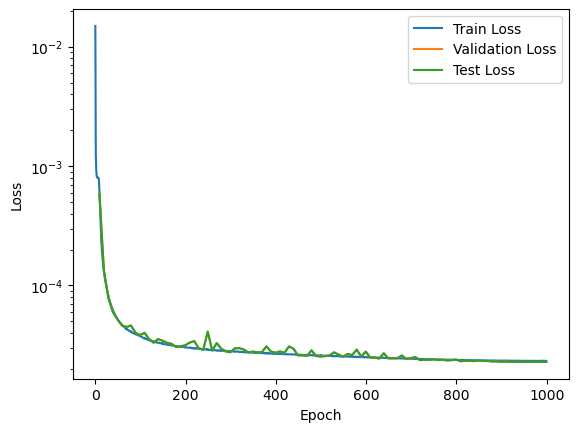

In [37]:
# Plotting
plt.plot(train_losses.numpy(), label='Train Loss')
plt.plot( np.arange(val_freq-1, num_epochs, val_freq),val_losses.numpy(), label='Validation Loss')
plt.plot(np.arange(test_freq-1, num_epochs, test_freq),test_losses.numpy(), label='Test Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

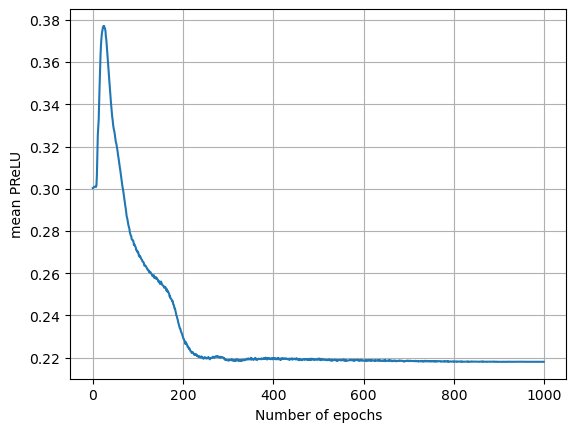

In [38]:
plt.plot(alphas.detach().numpy())
plt.xlabel('Number of epochs')
plt.ylabel('mean PReLU')    
plt.grid(True)
plt.show()

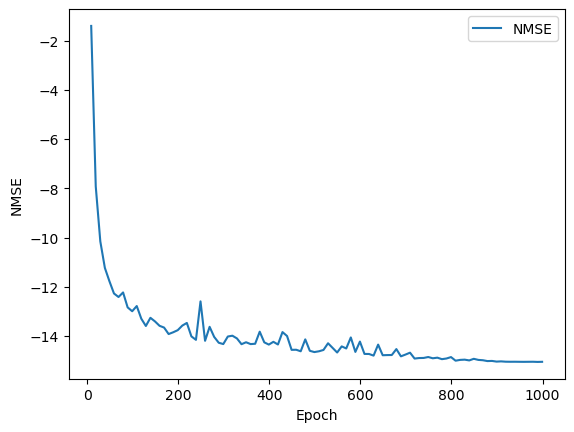

In [39]:
plt.plot(np.arange(test_freq-1, num_epochs, test_freq), test_nmses, label='NMSE')
plt.xlabel('Epoch')
plt.ylabel('NMSE')
plt.legend()
plt.show()

In [40]:
test_losses

tensor([5.8309e-04, 1.3368e-04, 7.8116e-05, 5.9725e-05, 5.1981e-05, 4.6175e-05,
        4.4902e-05, 4.6149e-05, 4.0168e-05, 3.8412e-05, 4.0167e-05, 3.5513e-05,
        3.3157e-05, 3.5581e-05, 3.4430e-05, 3.3070e-05, 3.2429e-05, 3.0488e-05,
        3.0906e-05, 3.1558e-05, 3.3181e-05, 3.4236e-05, 2.9805e-05, 2.8838e-05,
        4.1027e-05, 2.8461e-05, 3.2912e-05, 2.9477e-05, 2.8054e-05, 2.7552e-05,
        2.9719e-05, 2.9844e-05, 2.9029e-05, 2.7467e-05, 2.7912e-05, 2.7556e-05,
        2.7653e-05, 3.0888e-05, 2.7967e-05, 2.7350e-05, 2.8014e-05, 2.7322e-05,
        3.0825e-05, 2.9538e-05, 2.5946e-05, 2.5964e-05, 2.5677e-05, 2.8635e-05,
        2.5648e-05, 2.5383e-05, 2.5581e-05, 2.5905e-05, 2.7509e-05, 2.6343e-05,
        2.5283e-05, 2.6656e-05, 2.6112e-05, 2.9029e-05, 2.5350e-05, 2.7914e-05,
        2.4934e-05, 2.4840e-05, 2.4433e-05, 2.7049e-05, 2.4489e-05, 2.4537e-05,
        2.4558e-05, 2.5909e-05, 2.4216e-05, 2.4623e-05, 2.5096e-05, 2.3691e-05,
        2.3837e-05, 2.3847e-05, 2.4051e-

In [41]:
train_losses

tensor([1.4956e-02, 1.2609e-03, 9.2757e-04, 8.2546e-04, 8.0285e-04, 8.0089e-04,
        8.0059e-04, 7.9879e-04, 7.6297e-04, 6.4477e-04, 5.2343e-04, 3.9536e-04,
        2.9170e-04, 2.3863e-04, 2.0687e-04, 1.8529e-04, 1.6547e-04, 1.5166e-04,
        1.4003e-04, 1.3090e-04, 1.2199e-04, 1.1563e-04, 1.0943e-04, 1.0409e-04,
        1.0010e-04, 9.6161e-05, 9.2132e-05, 8.7314e-05, 8.4482e-05, 8.2684e-05,
        7.8249e-05, 7.6451e-05, 7.3886e-05, 7.1769e-05, 7.0056e-05, 6.8383e-05,
        6.7035e-05, 6.4918e-05, 6.3704e-05, 6.2211e-05, 6.0654e-05, 5.9750e-05,
        5.8244e-05, 5.7956e-05, 5.6455e-05, 5.5900e-05, 5.5061e-05, 5.3846e-05,
        5.2982e-05, 5.2573e-05, 5.2090e-05, 5.0963e-05, 5.0331e-05, 4.9979e-05,
        4.8953e-05, 4.8666e-05, 4.8486e-05, 4.7676e-05, 4.7299e-05, 4.7107e-05,
        4.6197e-05, 4.6051e-05, 4.5656e-05, 4.5280e-05, 4.4840e-05, 4.4798e-05,
        4.4039e-05, 4.3540e-05, 4.3769e-05, 4.2968e-05, 4.3160e-05, 4.2811e-05,
        4.2320e-05, 4.2198e-05, 4.1857e-

In [42]:
val_losses

tensor([5.8308e-04, 1.3367e-04, 7.8111e-05, 5.9723e-05, 5.1979e-05, 4.6172e-05,
        4.4899e-05, 4.6147e-05, 4.0166e-05, 3.8410e-05, 4.0165e-05, 3.5512e-05,
        3.3156e-05, 3.5579e-05, 3.4429e-05, 3.3068e-05, 3.2427e-05, 3.0487e-05,
        3.0904e-05, 3.1557e-05, 3.3180e-05, 3.4234e-05, 2.9803e-05, 2.8837e-05,
        4.1025e-05, 2.8460e-05, 3.2911e-05, 2.9476e-05, 2.8053e-05, 2.7550e-05,
        2.9717e-05, 2.9842e-05, 2.9028e-05, 2.7466e-05, 2.7911e-05, 2.7555e-05,
        2.7652e-05, 3.0887e-05, 2.7965e-05, 2.7349e-05, 2.8013e-05, 2.7320e-05,
        3.0823e-05, 2.9536e-05, 2.5945e-05, 2.5963e-05, 2.5676e-05, 2.8633e-05,
        2.5647e-05, 2.5382e-05, 2.5580e-05, 2.5903e-05, 2.7508e-05, 2.6342e-05,
        2.5282e-05, 2.6655e-05, 2.6110e-05, 2.9027e-05, 2.5349e-05, 2.7912e-05,
        2.4933e-05, 2.4839e-05, 2.4432e-05, 2.7048e-05, 2.4487e-05, 2.4536e-05,
        2.4557e-05, 2.5908e-05, 2.4214e-05, 2.4622e-05, 2.5095e-05, 2.3690e-05,
        2.3836e-05, 2.3845e-05, 2.4049e-